# Inner Core Lightning Threshold Analysis
In this notebook, we define the threshold for what constitutes a "lightning burst" in the inner core of a tropical cyclone. 

### How do we define a burst of lightning?
We define a lightning burst based off the number of lightning instances in a 30-minute time bin.

We start by evaluating each tropical cyclone (TC) individually, and then look at basin-level threshold trends and distributions. Below are the different basins:
* ATL - Atlantic Ocean basin
* CPAC - Central Pacific basin*
* EPAC - Eastern Pacific basin
* IO - Indian Ocean basin
* SHEM - Southern Hemisphere basin
* WPAC - Western North Pacific basin

*not included in basin-level analysis due to data sparsity. 

We only consider lightning data associated with wind speeds greater than 40 knots and time bins with lightning counts greater than 0 in our calculation of lightning burst thresholds. We log transform the lightning counts and use the following 6 threshold methods (referred to by the names in parentheses hereafter):
- [Median Absolute Deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) - 4 MAD (**MAD1**)
    - This method sets the threshold to be 4 times the median absolute deviation above the median log-lightning count
    - Equation: threshold = median + 4 * MAD
- Median Absolute Deviation - 5 MAD (**MAD2**)
    - This method sets the threshold to be 5 times the median absolute deviation above the median log-lightning count
    - Equation: threshold = median + 5 * MAD
- [Interquartile Range](https://en.wikipedia.org/wiki/Interquartile_range) - 1 IQR (**IQR1**)
    - This method sets the threshold to be 1 interquartile range higher than the upper quartile (Q3) log-lightning count
    - Equation: threshold = Q3 + 1 * IQR
- Interquartile Range - 1.5 IQR (**IQR2**)
    - This method sets the threshold to be 1.5 interquartile ranges higher than the upper quartile (Q3) log-lightning count
    - Equation: threshold = Q3 + 1.5 * IQR
- [Lognormal](https://en.wikipedia.org/wiki/Log-normal_distribution) - 2 Standard Deviations (**LOGN1**)
    - This method sets the threshold to be 2 standard deviations higher than the mean log-lightning count
    - Equation: threshold = mean + 2 * std dev
- Lognormal - 3 Standard Deviations (**LOGN2**)
    - This method sets the threshold to be 3 standard deviations higher than the mean log-lightning count
    - Equation: threshold = mean + 3 * std dev

**note that all methods use the log-lightning count as base (e.g. median refers to median log-lightning count, not median lightning count)

## Code
### Import Libraries and Files
Let's start by importing necessary libraries and files. The inner core dataset is created in the `data_processing.ipynb` notebook as `innercore_timebin_joined.csv`. This file can be found in the `data_pipeline/data/` directory of the repository.

In [4]:
import os
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import median_abs_deviation
from lightning_threshold_functions import *

In [5]:
# import data from csv file
innercore_data = pl.read_csv("../data_pipeline/data/innercore_timebin_joined.csv")
innercore_data = innercore_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"), # Parse basin from storm code
    pl.col("lightning_count").log1p().alias("log_lightning_count"), # Log transform the counts
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
innercore_data = innercore_data.with_columns(
    pl.when(pl.col("TC_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("TC_Category"))
    .alias("TC_Category")
)
innercore_data = innercore_data.rename({"Intensification_Category":"Intensification_Category_5", "TC_Category":"Current_Category"})
innercore_data.head()

shape: (5, 21)
┌────────────┬────────────┬────────────┬──────┬───┬────────────┬───────────┬───────────┬───────────┐
│ time_bin   ┆ storm_code ┆ lightning_ ┆ year ┆ … ┆ 24_hour_pr ┆ Current_C ┆ Intensifi ┆ log_light │
│ ---        ┆ ---        ┆ count      ┆ ---  ┆   ┆ essure_dif ┆ ategory   ┆ cation_Ca ┆ ning_coun │
│ datetime[μ ┆ str        ┆ ---        ┆ i64  ┆   ┆ f          ┆ ---       ┆ tegory_5  ┆ t         │
│ s]         ┆            ┆ i64        ┆      ┆   ┆ ---        ┆ str       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆      ┆   ┆ f64        ┆           ┆ str       ┆ f64       │
╞════════════╪════════════╪════════════╪══════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 2010-06-21 ┆ ATL_10_1   ┆ 1          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.693147  │
│ 07:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.0       │
│ 07:30:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.0       │
│ 08:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.0       │
│ 08:30:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.0       │
│ 09:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴──────┴───┴────────────┴───────────┴───────────┴───────────┘

We map the intensification bins into 3, combining the rapidly weakening and weakening bins, and the rapidly intensifying and intensifying bins.

In [6]:
# Mapping intensification bins into 3 category instead of 5
category_mapping = {
    "Rapidly Weakening": "Weakening",
    "Weakening": "Weakening",
    "Neutral": "Neutral",
    "Intensifying": "Intensifying",
    "Rapidly Intensifying": "Intensifying"
}

# Apply mapping to create new column
innercore_data = innercore_data.with_columns(
    innercore_data["Intensification_Category_5"].replace(category_mapping).alias("Intensification_Category_3")
)

innercore_data.head()

shape: (5, 22)
┌────────────┬────────────┬────────────┬──────┬───┬────────────┬───────────┬───────────┬───────────┐
│ time_bin   ┆ storm_code ┆ lightning_ ┆ year ┆ … ┆ Current_Ca ┆ Intensifi ┆ log_light ┆ Intensifi │
│ ---        ┆ ---        ┆ count      ┆ ---  ┆   ┆ tegory     ┆ cation_Ca ┆ ning_coun ┆ cation_Ca │
│ datetime[μ ┆ str        ┆ ---        ┆ i64  ┆   ┆ ---        ┆ tegory_5  ┆ t         ┆ tegory_3  │
│ s]         ┆            ┆ i64        ┆      ┆   ┆ str        ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆      ┆   ┆            ┆ str       ┆ f64       ┆ str       │
╞════════════╪════════════╪════════════╪══════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 2010-06-21 ┆ ATL_10_1   ┆ 1          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.693147  ┆ Neutral   │
│ 07:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.0       ┆ Neutral   │
│ 07:30:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.0       ┆ Neutral   │
│ 08:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.0       ┆ Neutral   │
│ 08:30:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.0       ┆ Neutral   │
│ 09:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴──────┴───┴────────────┴───────────┴───────────┴───────────┘

In [7]:
# Create dataframe for filtering later
storm_names = innercore_data[["storm_code", "storm_name"]].unique()

---------------------

### Individual TC Analysis
We start by applying the 6 different thresholds to each TC individually, where we evaluate burst thresholds in comparison to a TC's own lightning activity for time bins associated with wind speeds greater than or equal to 40 knots. We start by filtering out data associated with wind speeds less than 40 knots.

In [8]:
# Filter out data where wind is less than 40 knots for threshold analysis
analysis_data = innercore_data.filter(pl.col("knots") >= 40)
# Convert polars dataframe to pandas for application of functions
pd_data = analysis_data.to_pandas()

We then apply the functions to the data, including timebins with no lightning activity.

In [9]:
# Apply functions to data, including bins with 0 lightning
bursts_w_0 = apply_individual_thresholds(pd_data)

tc_summary_w_0 = create_tc_summary(bursts_w_0)
tc_summary_w_0.head(10)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   ATL_10_1           40           40        0.000000        0.000000   
1  ATL_10_11           54           54        0.000000        0.000000   
2  ATL_10_12           83           83        0.000000        0.000000   
3  ATL_10_13           43           35        1.732868        2.079442   
4  ATL_10_14           23           23        0.000000        0.000000   
5  ATL_10_17           75           75        0.000000        0.000000   
6  ATL_10_18            0            0        7.791445        9.023858   
7  ATL_10_19           58           58        0.000000        0.000000   
8  ATL_10_20           12            7        3.465736        4.158883   
9  ATL_10_21          100           75        3.465736        4.158883   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0           40           40        0.000000        0.000000            10   
1           54           54        0.000000        0.000000            25   
2           83           83        0.000000        0.000000            24   
3            6            1        4.552490        5.690612             6   
4           23           23        0.000000        0.000000            15   
5           57           56        1.386294        1.732868            24   
6            0            0        6.425564        7.595410             3   
7            1            0        5.344880        6.681100             6   
8            6            1        4.394449        5.493061             5   
9           35            2        5.545177        6.931472            34   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             4         1.964998         2.766760         168      23.81   
1            17         0.905833         1.299925         524      10.31   
2            10         2.714949         3.820770         347      23.92   
3             0         4.401910         5.986869         130      33.08   
4             5         1.092380         1.547290         144      15.97   
5             2         3.893827         5.435464         270      27.78   
6             0         5.929778         7.469033         180       0.00   
7             0         4.938227         6.723796         120      48.33   
8             0         4.549465         6.195277          77      15.58   
9             0         5.640493         7.671843         476      21.01   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      23.81      23.81      23.81        5.95        2.38  
1      10.31      10.31      10.31        4.77        3.24  
2      23.92      23.92      23.92        6.92        2.88  
3      26.92       4.62       0.77        4.62        0.00  
4      15.97      15.97      15.97       10.42        3.47  
5      27.78      21.11      20.74        8.89        0.74  
6       0.00       0.00       0.00        1.67        0.00  
7      48.33       0.83       0.00        5.00        0.00  
8       9.09       7.79       1.30        6.49        0.00  
9      15.76       7.35       0.42        7.14        0.00

In [10]:
# Get mean threshold value for each of the 6 options
tc_summary_w_0_mean = tc_summary_w_0.drop(columns=("storm_code")).mean()
print(tc_summary_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# Get median threshold value for each of the 6 options
tc_summary_w_0_median = tc_summary_w_0.drop(columns=("storm_code")).median()
print(tc_summary_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

mad1_threshold     1.080206
mad2_threshold     1.289705
iqr1_threshold     2.292736
iqr2_threshold     2.859537
logn1_threshold    3.085677
logn2_threshold    4.239224
dtype: float64
mad1_threshold     0.000000
mad2_threshold     0.000000
iqr1_threshold     1.386294
iqr2_threshold     1.732868
logn1_threshold    2.925341
logn2_threshold    4.069471
dtype: float64


We can see that the threshold values are all very low, meaning that any lightning activity is likely to be flagged as a burst. We plot one TC below to look at a specific example. This can be expected, as we know that many of the timebins have no lightning activity, therefore skewing the threshold lower.

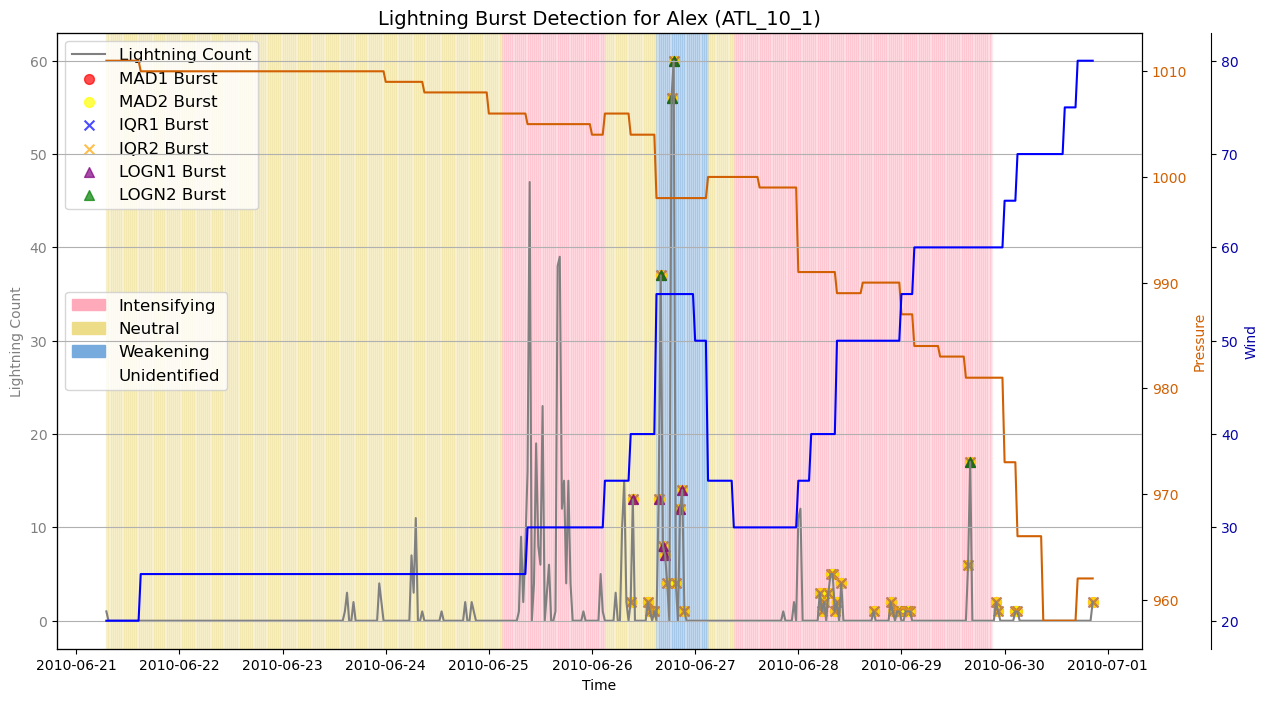

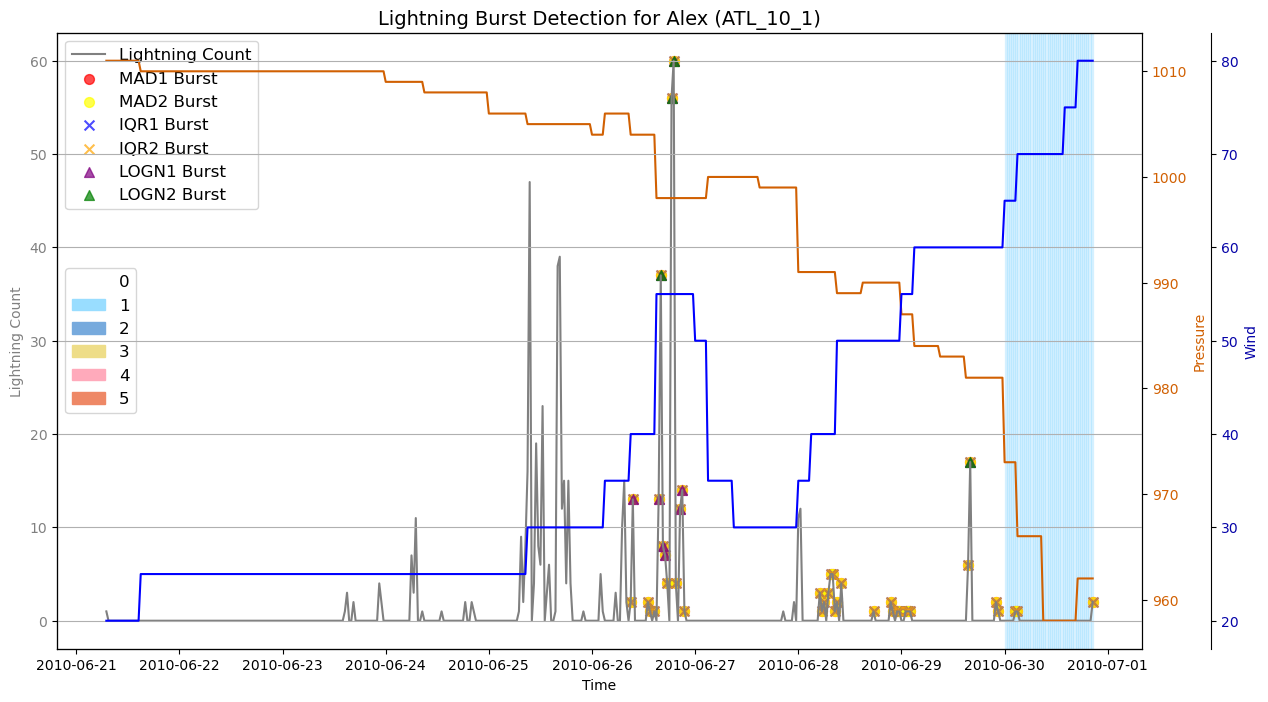

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   ATL_10_1           40           40             0.0             0.0   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0           40           40             0.0             0.0            10   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             4         1.964998          2.76676         168      23.81   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      23.81      23.81      23.81        5.95        2.38

In [11]:
# ATL_10_1 with 0 in the analysis
cyclone_id = 'ATL_10_1'
plot_tc(cyclone_id, bursts_w_0, storm_names, innercore_data, "i3")
plot_tc(cyclone_id, bursts_w_0, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary_w_0[tc_summary_w_0["storm_code"] == cyclone_id]

Next, we try applying the thresholds to the dataset without timebins with 0 lightning count. This slightly alters our definition of a lightning burst - we now compare each set of lightning events to other nonzero lightning events. This should bring up the threshold and bring down the percent of timebins flagged as a burst.

In [12]:
# Apply functions to data(exclude 0 lightning count)
pd_data_drop0 = pd_data[pd_data['lightning_count'] != 0]

bursts = apply_individual_thresholds(pd_data_drop0)

tc_summary = create_tc_summary(bursts)
tc_summary = pd.merge(storm_names.to_pandas(), tc_summary, on="storm_code")
tc_summary.head(10)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
0  SHEM_14_23        Ita            8            3        4.158883   
1   SHEM_10_6   Laurence            0            0        5.730405   
2  SHEM_13_16     Haruna            0            0        4.884519   
3  WPAC_14_10      Matmo            0            0        7.595027   
4  WPAC_15_20    Krovanh            0            0        6.378860   
5   ATL_17_13      Katia            0            0        5.274601   
6  WPAC_12_12     Haikui            0            0        0.693147   
7   EPAC_14_7  Genevieve            0            0        6.340359   
8  SHEM_10_16     Gelane            5            0        4.564348   
9  WPAC_12_11     Damrey            0            0        4.763267   

   mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
0        4.852030            8            5        3.859343        4.650892   
1        6.737856            0            0        4.688457        5.687284   
2        5.657709            0            0        3.912023        4.716742   
3        8.894310            0            0        6.774163        8.193051   
4        7.438992            1            0        5.620240        6.678726   
5        6.190892            5            1        3.912023        4.716742   
6        0.693147            0            0        0.693147        0.693147   
7        7.438972            0            0        4.937563        5.861341   
8        5.257495            8            0        4.382027        5.202880   
9        5.551725            0            0        4.031286        4.764455   

   ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0  ...             1         4.000593         5.131367         146       5.48   
1  ...             0         4.172715         5.302372         106       0.00   
2  ...             0         3.439097         4.332097          23       0.00   
3  ...             0         5.596799         7.086838         130       0.00   
4  ...             0         5.113089         6.439882          74       0.00   
5  ...             0         4.128978         5.295669          45       0.00   
6  ...             0              NaN              NaN           1       0.00   
7  ...             0         4.265152         5.350361          23       0.00   
8  ...             0         4.273303         5.408034         151       3.31   
9  ...             0         3.389658         4.212154          21       0.00   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0       2.05       5.48       3.42        5.48        0.68  
1       0.00       0.00       0.00        5.66        0.00  
2       0.00       0.00       0.00        4.35        0.00  
3       0.00       0.00       0.00        0.00        0.00  
4       0.00       1.35       0.00        1.35        0.00  
5       0.00      11.11       2.22        8.89        0.00  
6       0.00       0.00       0.00        0.00        0.00  
7       0.00       0.00       0.00        0.00        0.00  
8       0.00       5.30       0.00        5.96        0.00  
9       0.00       0.00       0.00        4.76        0.00  

[10 rows x 21 columns]

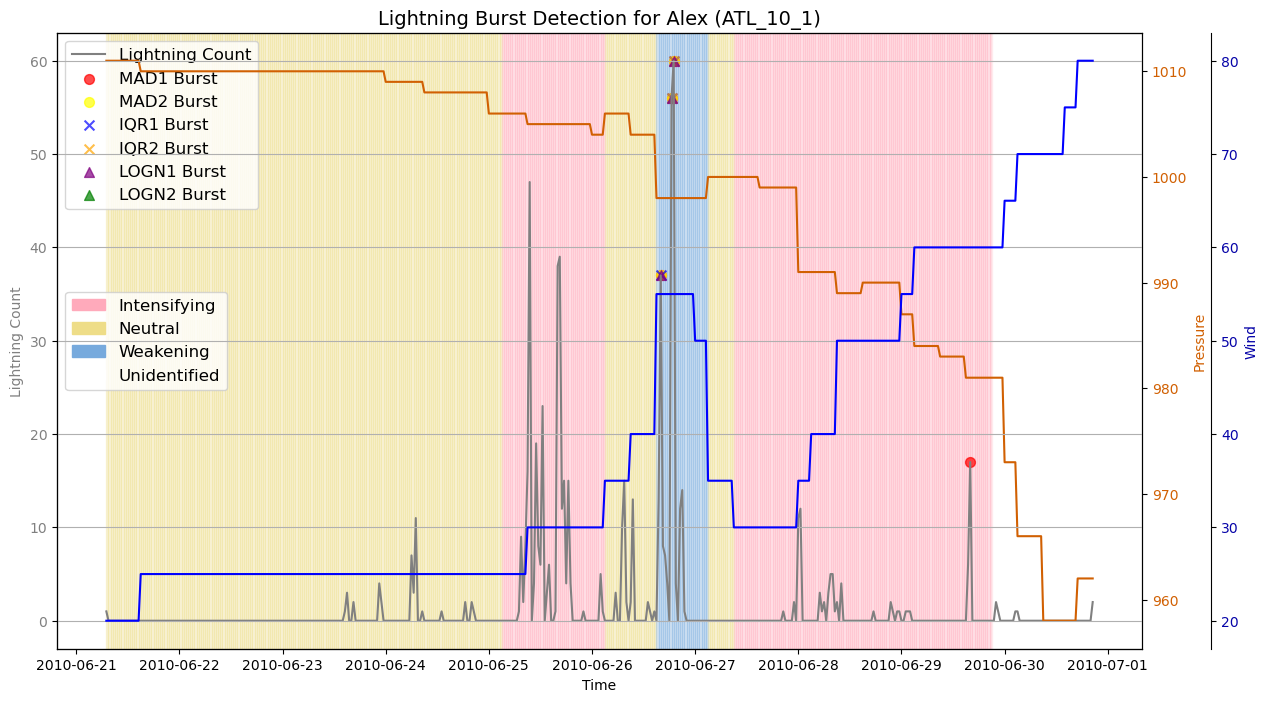

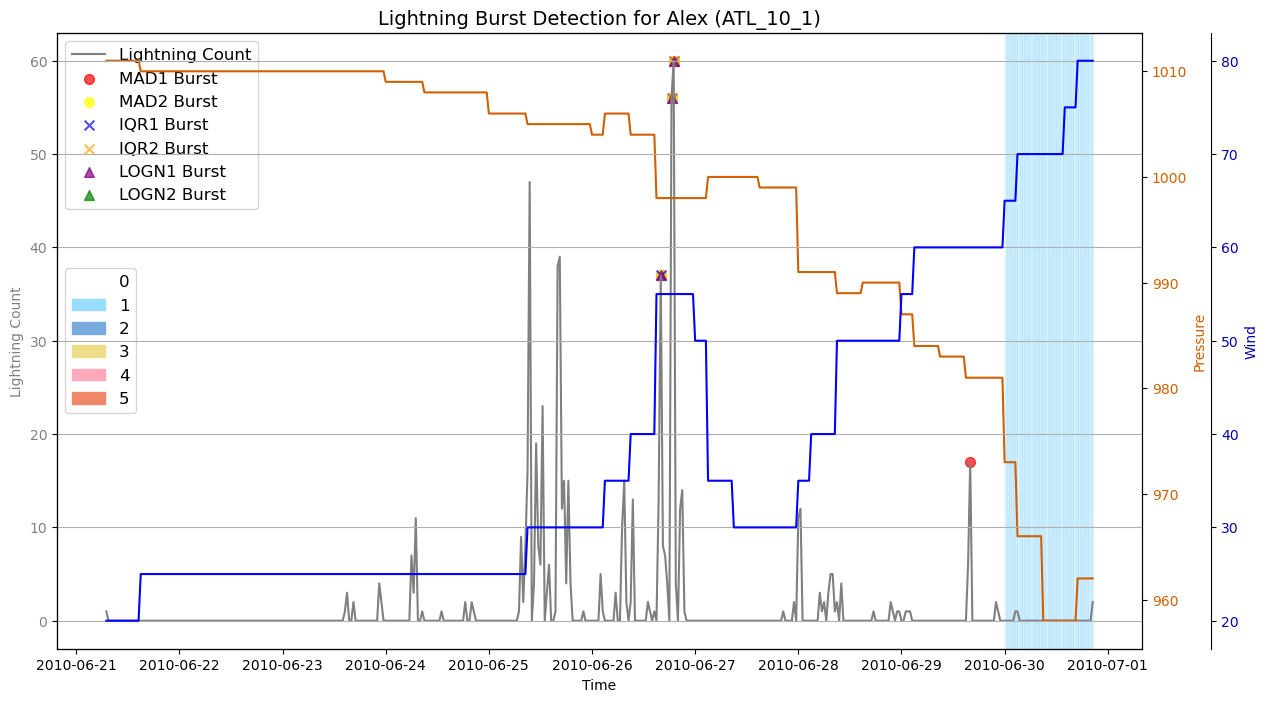

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
437   ATL_10_1       Alex            4            3        2.720473   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
437        3.125938            3            2        3.265439        3.908512   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
437  ...             0         3.469047         4.444476          40   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
437       10.0        7.5        7.5        5.0         7.5         0.0  

[1 rows x 21 columns]

In [13]:
# ATL_10_1 without 0 in threshold calculation
cyclone_id = 'ATL_10_1'
plot_tc(cyclone_id, bursts, storm_names, innercore_data, "i3")
plot_tc(cyclone_id, bursts, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

We see above that the analysis including timebins with 0 lightning events skews the threshold to 0, such that any lightning event is flagged as a burst. This is not realistic, and so we will not include the timebins with 0 lightning events in our threshold analysis.

Below, we look at a couple more TCs. We plot the lightning, wind, pressure, all detected lightning bursts using the 6 thresholds created above, and their intensification category/current category bins as color-coded backgrounds. Note that all data is plotted, regardless of if the point was included in the analysis (we do not consider data points associated with winds less than 40 knots in our threshold analysis).

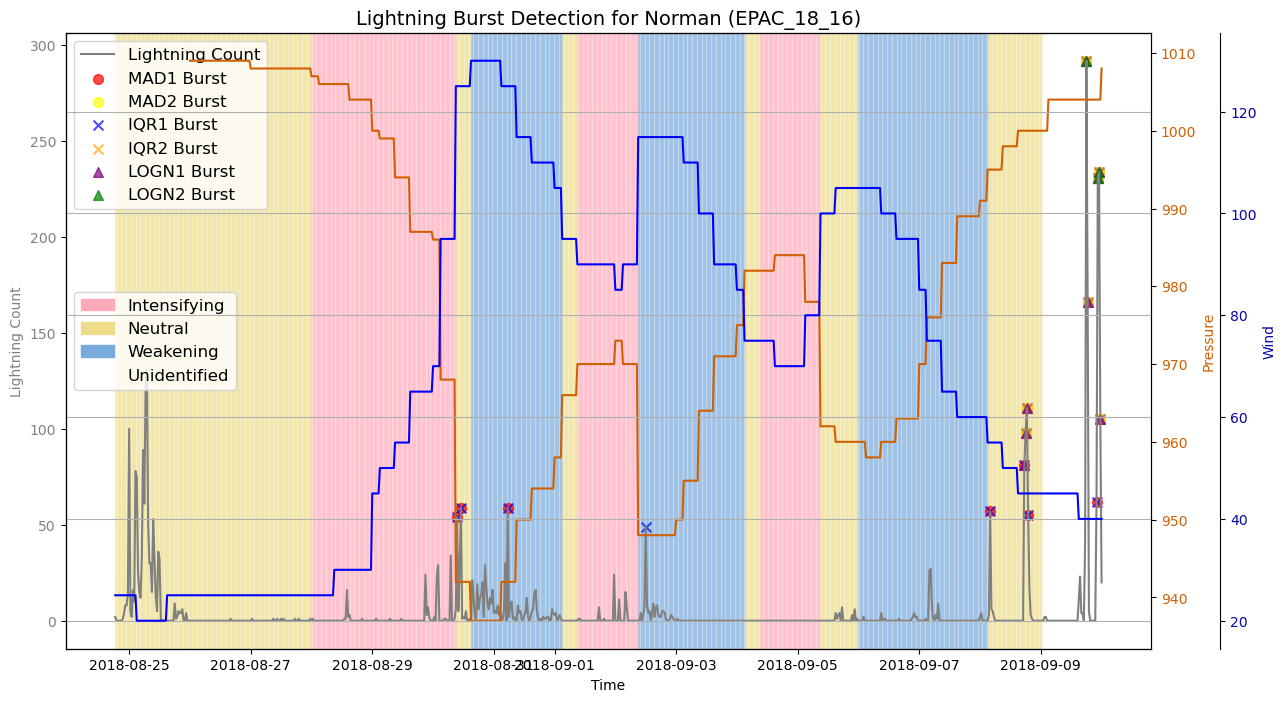

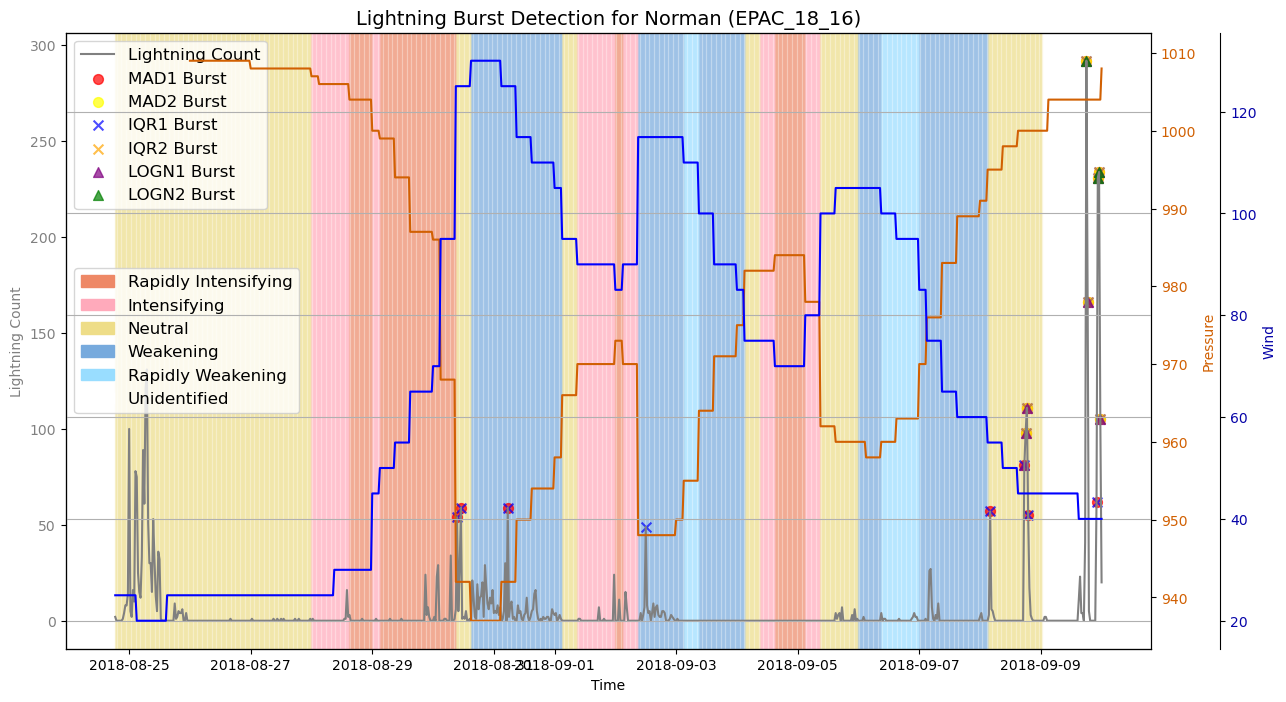

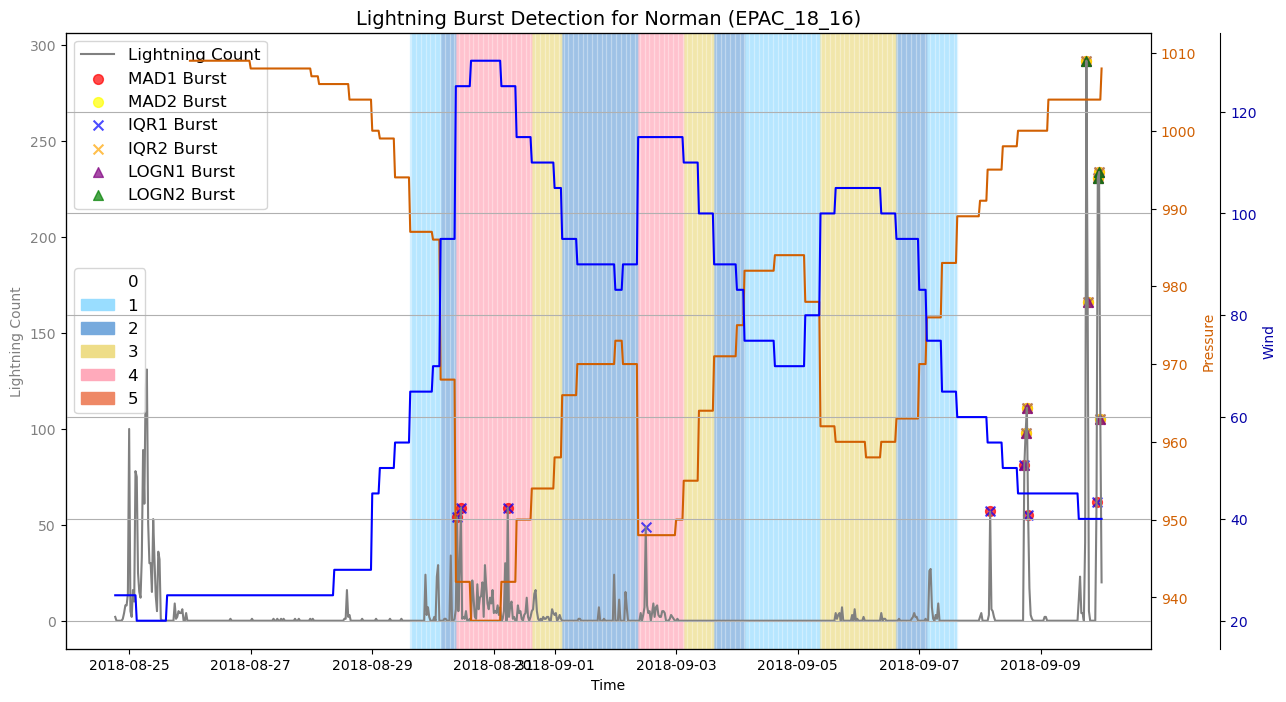

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
137  EPAC_18_16     Norman           14            7        3.960585   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
137        4.548371           15            7        3.871201        4.564348   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
137  ...             3         4.218458         5.368579         170   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
137       8.24       4.12       8.82       4.12        4.71        1.76  

[1 rows x 21 columns]

In [14]:
# EPAC_18_16 - Norman
cyclone_id = 'EPAC_18_16'
plot_tc(cyclone_id, bursts, storm_names, innercore_data, "i3")
plot_tc(cyclone_id, bursts, storm_names, innercore_data, "i5")
plot_tc(cyclone_id, bursts, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

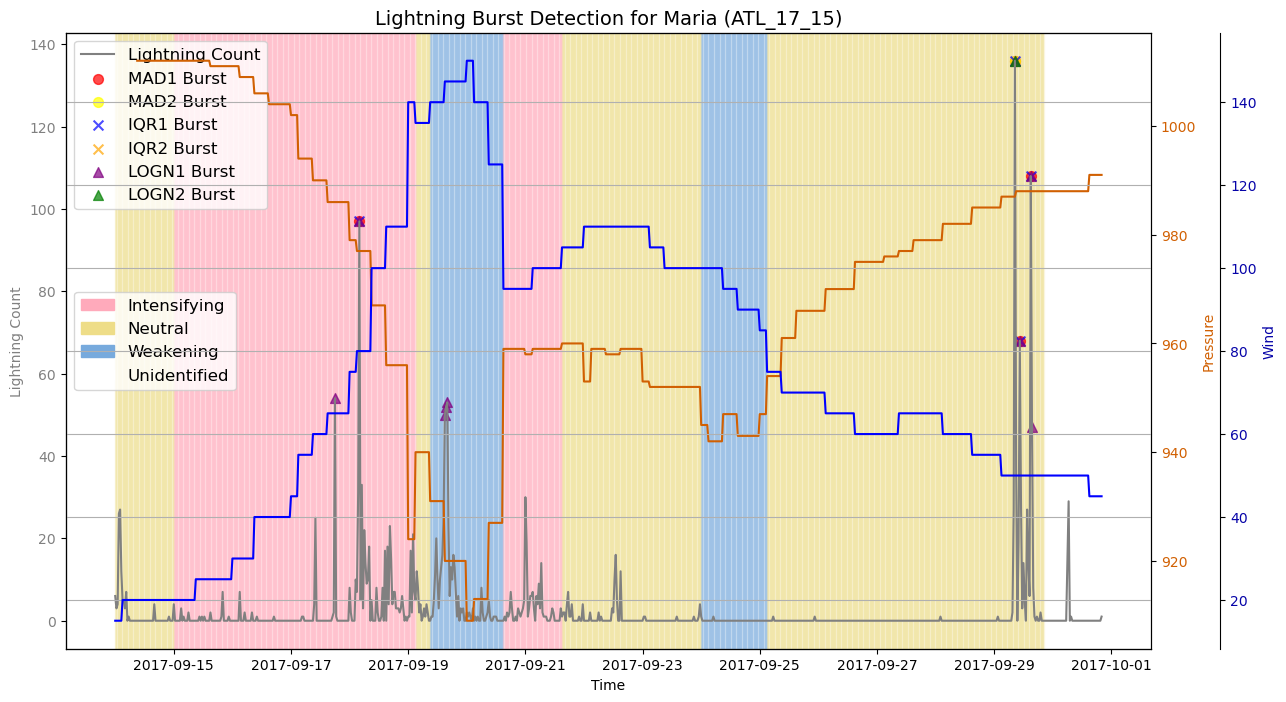

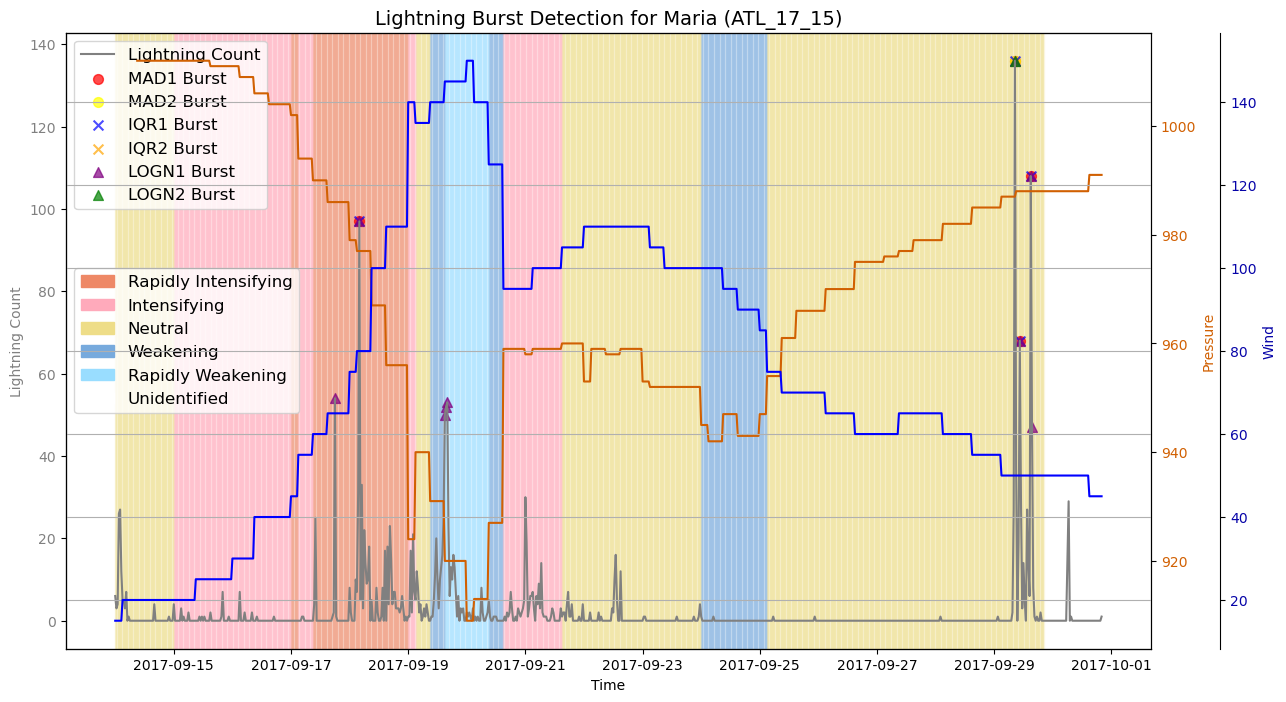

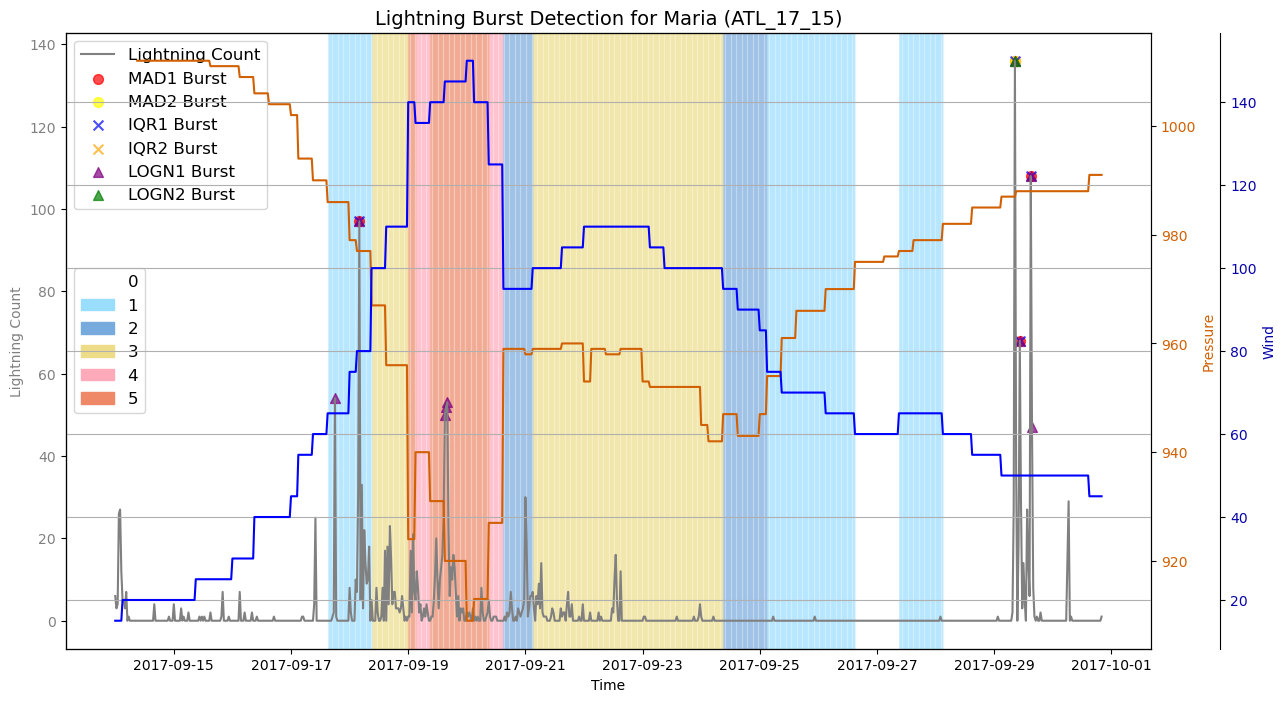

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
431  ATL_17_15      Maria            4            1        4.158883   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
431         4.85203            4            0        4.102643        4.955017   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
431  ...             1         3.761648         4.773138         191   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
431       2.09       0.52       2.09        0.0        4.71        0.52  

[1 rows x 21 columns]

In [15]:
# ATL_17_15 - Maria
cyclone_id = 'ATL_17_15'
plot_tc(cyclone_id, bursts, storm_names, innercore_data, "i3")
plot_tc(cyclone_id, bursts, storm_names, innercore_data, "i5")
plot_tc(cyclone_id, bursts, storm_names, innercore_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

In [14]:
# Export for external tool vis
innercore_data.write_csv("../analysis_data/innercore_lightning_data.csv")
tc_summary.to_csv("../analysis_data/innercore_threshold_summary.csv", index=False)
bursts.to_csv("../analysis_data/innercore_bursts.csv", index=False)

In [21]:
# Define threshold names for use later
threshold_names = {
    'mad1':['mad1_threshold','MAD1'],
    'mad2':['mad2_threshold','MAD2'],
    'iqr1':['iqr1_threshold','IQR1'],
    'iqr2':['iqr2_threshold','IQR2'],
    'logn1':['logn1_threshold','LOGN1'],
    'logn2':['logn2_threshold','LOGN2'],
}
threshold_keys = list(threshold_names.keys())
threshold_cols = [threshold_names[key][0] for key in threshold_keys]
threshold_labels = [threshold_names[key][1] for key in threshold_keys]

In [15]:
# No bursts detected
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
print(f"{(tc_summary_w_0[selected_columns].sum(axis=1) == 0).sum()} TCs of {len(tc_summary_w_0)} TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.")
no_bursts = tc_summary[tc_summary[selected_columns].sum(axis=1) == 0]
print(f"{len(no_bursts)} TCs of {len(tc_summary)} TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.")

11 TCs of 472 TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.
106 TCs of 478 TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.


Next, we generate the visualizations for each TC and save each as a .png file in the `visualizations/` folder. We loop through each storm code in the inner core dataset and generate 2 overall inner core burst visualizations (one with intensification stages background colors, one with current category background colors).

In [ ]:
# Loop through each storm code and generate visualizations as png files for each
# Initialize storm codes, background coloring types, output directory
tc_list = innercore_data[["storm_code", "storm_name"]].unique()
bg_types = ["i3", "c5"] # Intensification 3 bins, Current Category 5 bins
output_dir = "visualizations/"
# Check if output directory exists, if not create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Loop through each row in the TC list
for storm_code, storm_name in tc_list.iter_rows():
    # print(f"Exporting graphs for {storm_name} ({storm_code})")
    for bg_type in bg_types:
        # Call function to generate and save without displaying
        save_path = f"{output_dir}{storm_code}_{storm_name}_innercore_{bg_type}.png"
        plot_tc(storm_code, bursts, storm_names, innercore_data, bg_type, show=False, save_path=save_path)

-------------------

### EPAC Basin
We now look at lightning burst thresholds at the basin level, starting with EPAC. We take the individual TC thresholds for TCs in the EPAC basin and create a basin-level standard separated by current category, where categories 0-2 are grouped together and categories 3-5 are grouped together.

In [22]:
# Get list of EPAC storm codes
epac_data = innercore_data.filter(pl.col("basin") == "EPAC")
epac_storm_codes = epac_data["storm_code"].unique()
epac_storm_codes.head(5)

shape: (5,)
Series: 'storm_code' [str]
[
	"EPAC_11_2"
	"EPAC_15_15"
	"EPAC_16_5"
	"EPAC_13_5"
	"EPAC_11_7"
]

In [23]:
# Filter TC summary table to EPAC only
epac_tc_summary = tc_summary[tc_summary["storm_code"].isin(epac_storm_codes)]
epac_tc_summary.head()

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
7    EPAC_14_7  Genevieve            0            0        6.340359   
14   EPAC_11_9     Hilary            0            0        4.564348   
15   EPAC_15_5    Dolores            0            0        6.303652   
22   EPAC_16_7      Frank            0            0        7.355006   
29  EPAC_18_12       John            0            0        1.098612   

    mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
7         7.438972            0            0        4.937563        5.861341   
14        5.257495            2            0        3.911222        4.614375   
15        7.359705            0            0        5.703782        6.855075   
22        8.485888            0            0        6.034524        7.129400   
29        1.098612            0            0        1.098612        1.098612   

    ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
7   ...             0         4.265152         5.350361          23   
14  ...             0         3.668929         4.558539         156   
15  ...             0         5.126240         6.498985         101   
22  ...             0         5.904155         7.421015          66   
29  ...             0         1.380178         1.561508           5   

    mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
7         0.0        0.0       0.00        0.0        0.00         0.0  
14        0.0        0.0       1.28        0.0        3.21         0.0  
15        0.0        0.0       0.00        0.0        2.97         0.0  
22        0.0        0.0       0.00        0.0        0.00         0.0  
29        0.0        0.0       0.00        0.0        0.00         0.0  

[5 rows x 21 columns]

In [24]:
# Filter burst point data to EPAC only
epac_bursts = bursts[bursts["storm_code"].isin(epac_storm_codes)]
epac_bursts.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
10047 2010-06-19 18:30:00  EPAC_10_4                5  2010      6   19    18   
10048 2010-06-19 20:30:00  EPAC_10_4                1  2010      6   19    20   
10049 2010-06-20 11:30:00  EPAC_10_4                1  2010      6   20    11   
10050 2010-06-20 12:00:00  EPAC_10_4                7  2010      6   20    12   
10051 2010-06-20 12:30:00  EPAC_10_4               26  2010      6   20    12   

       minute   lat   lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
10047      30  12.4 -97.6  ...        5.172376        6.190817      False   
10048      30  12.4 -97.6  ...        5.172376        6.190817      False   
10049      30  11.8 -99.5  ...        5.172376        6.190817      False   
10050       0  11.8 -99.5  ...        5.172376        6.190817      False   
10051      30  11.8 -99.5  ...        5.172376        6.190817      False   

       burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
10047       False       6.704246         7.89383        False        False   
10048       False       6.704246         7.89383        False        False   
10049       False       6.704246         7.89383        False        False   
10050       False       6.704246         7.89383        False        False   
10051       False       6.704246         7.89383        False        False   

      logn1_threshold logn2_threshold  
10047        4.679426        5.944917  
10048        4.679426        5.944917  
10049        4.679426        5.944917  
10050        4.679426        5.944917  
10051        4.679426        5.944917  

[5 rows x 34 columns]

Let's look at the unweighted threshold distribution (1 occurence per TC) before splitting the timebins by current category.

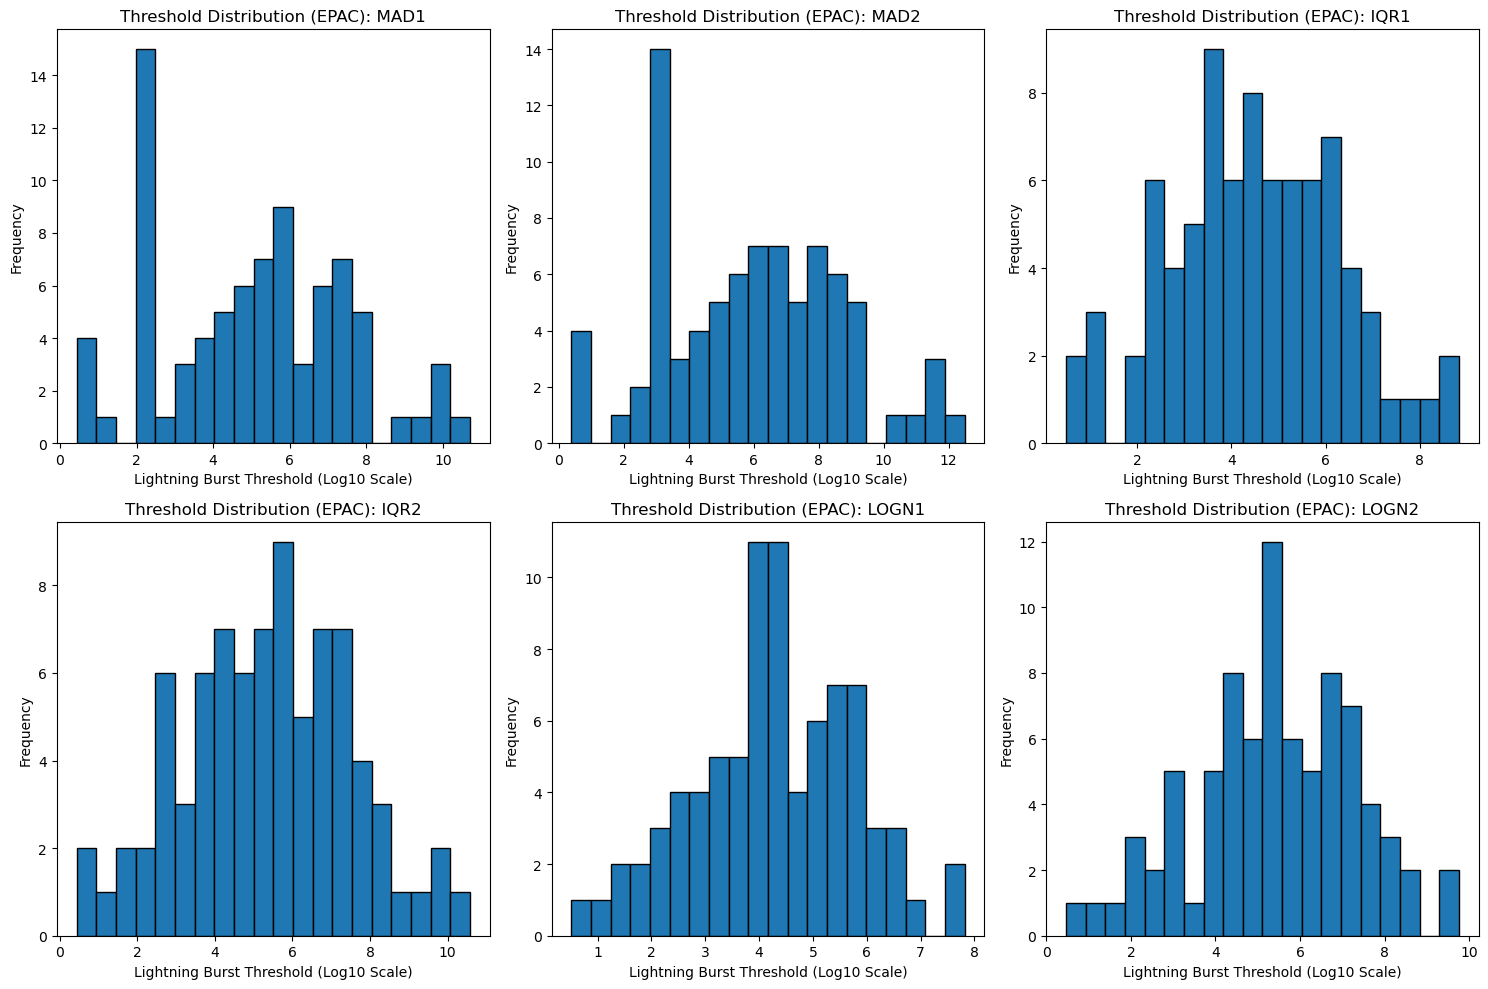

In [25]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_tc_summary, threshold, ax=axes[i])
    axes[i].set_title(f"Threshold Distribution (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

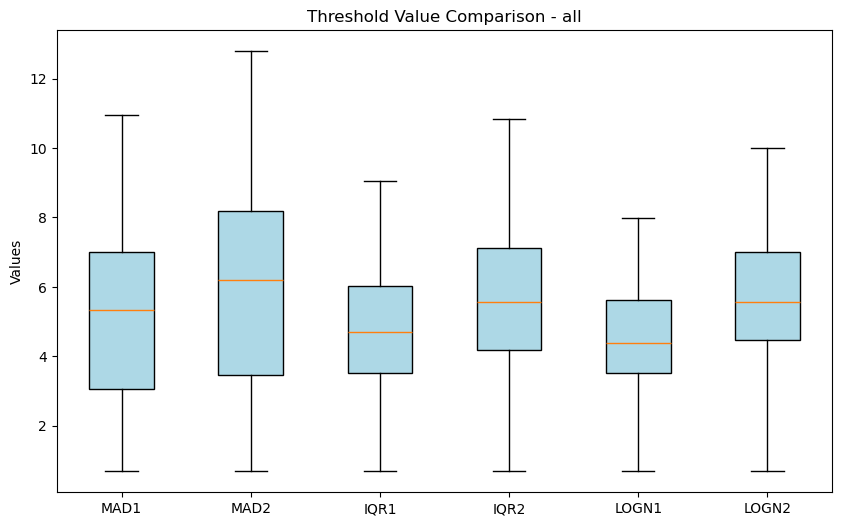

In [26]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_tc_summary, "all", ax=None)

We then create a summary for the weaker categories and create an initial basin-category threshold defined as 2 standard deviations + the mean or median.

In [265]:
# Group the data into weak and strong category datasets using function
# Note that this is grouping only the data used in the analysis (excluding less than 40 knots)
epac_weak0_lightning, epac_weak1_lightning, epac_strong_lightning = group_bins_category(epac_bursts)

3850 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
1561 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
1398 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


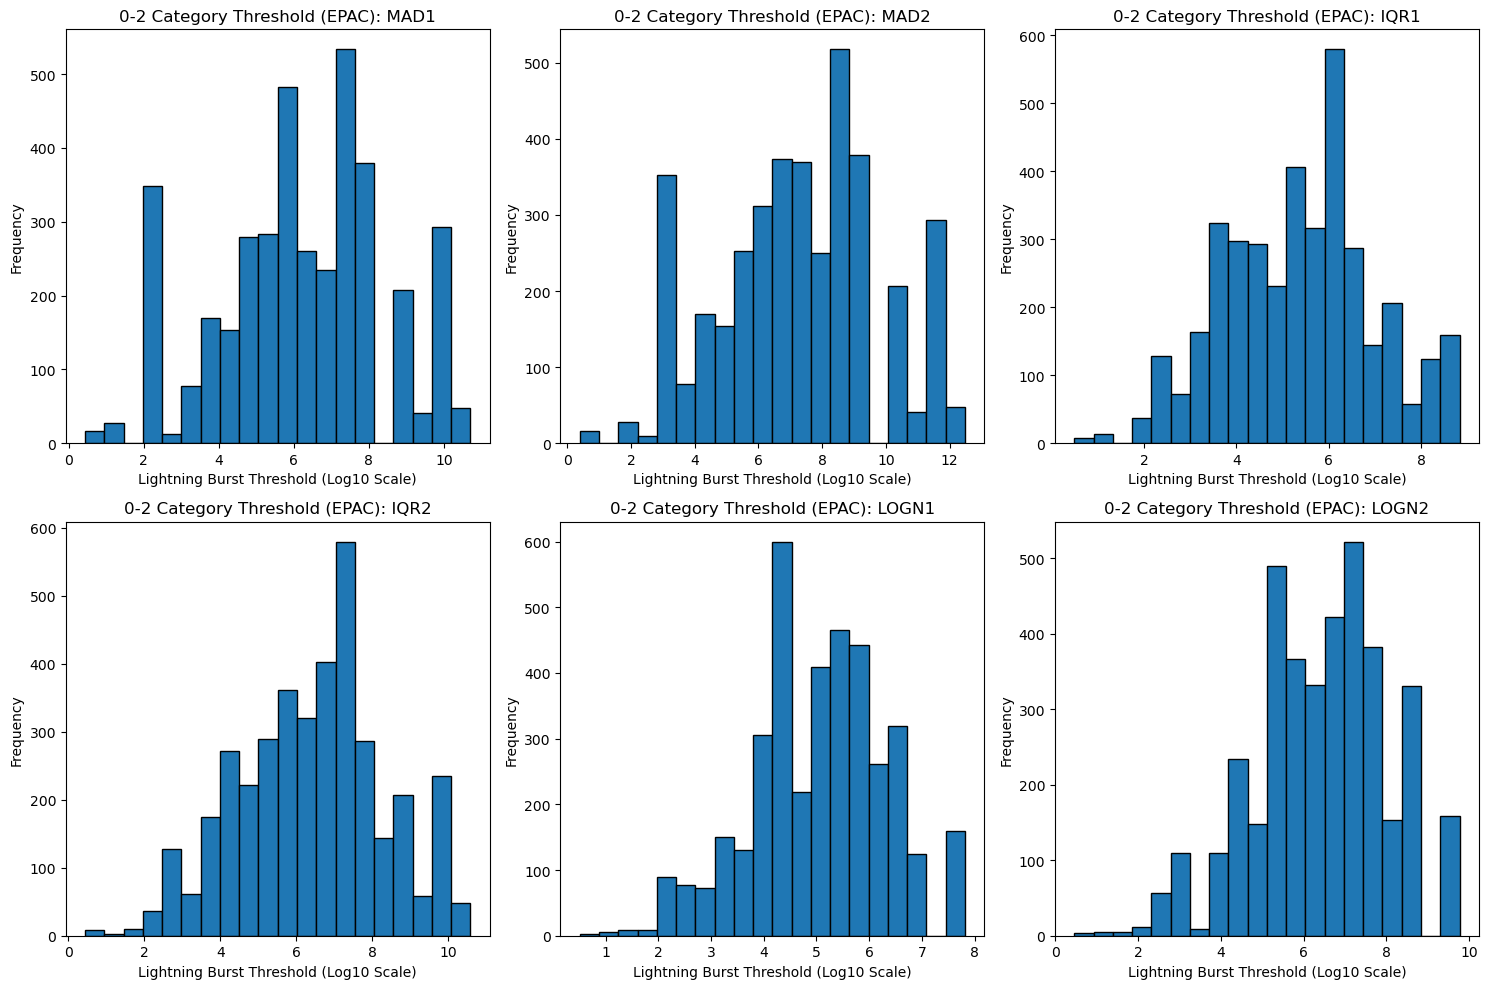

In [38]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak0_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

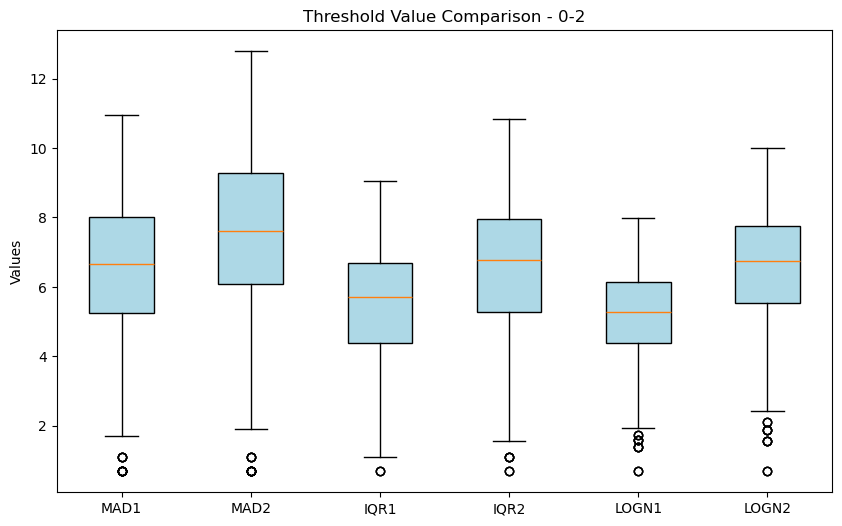

In [39]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_weak0_lightning, "0-2", ax=None)

In [40]:
# Create basin threshold based off mean and 2 standard dev - 0-2 categories
epac_weak0_summary = create_basin_summary(epac_weak0_lightning, "0-2", "EPAC")
epac_weak0_thresholds = calculate_basin_thresholds(epac_weak0_lightning, "0-2", "EPAC")
epac_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5  EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  
0  10.962409           82           3850              2.13  
1  12.785568           52           3850              1.35  
2   9.045240          119           3850              3.09  
3  10.829707           40           3850              1.04  
4   7.998327          141           3850              3.66  
5   9.996606            6           3850              0.16

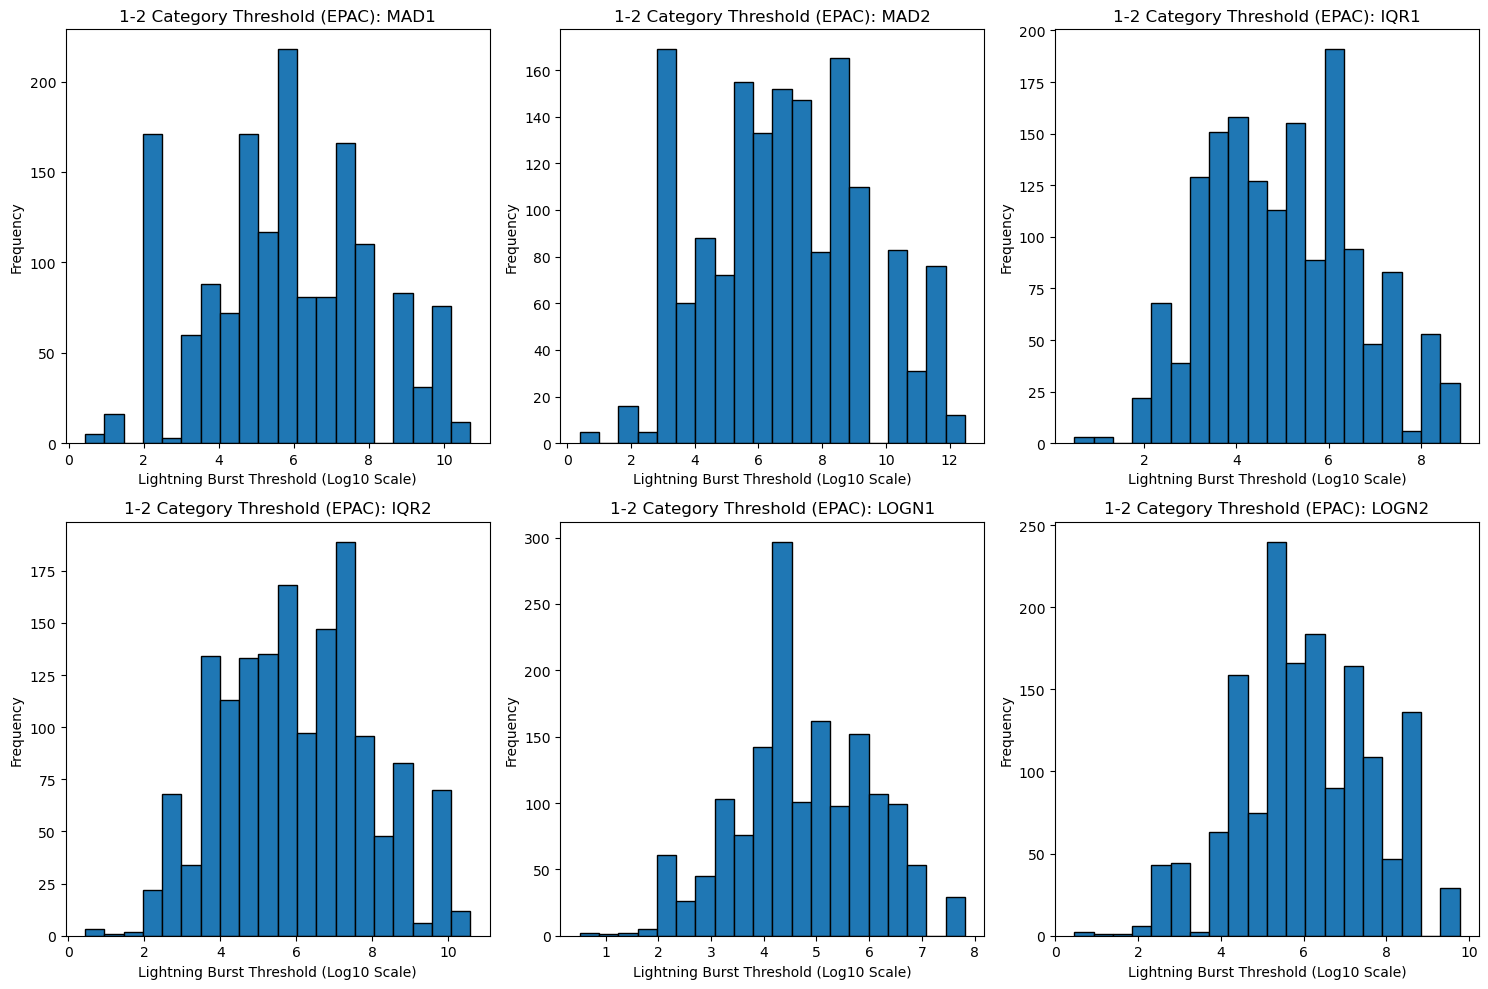

In [41]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak1_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

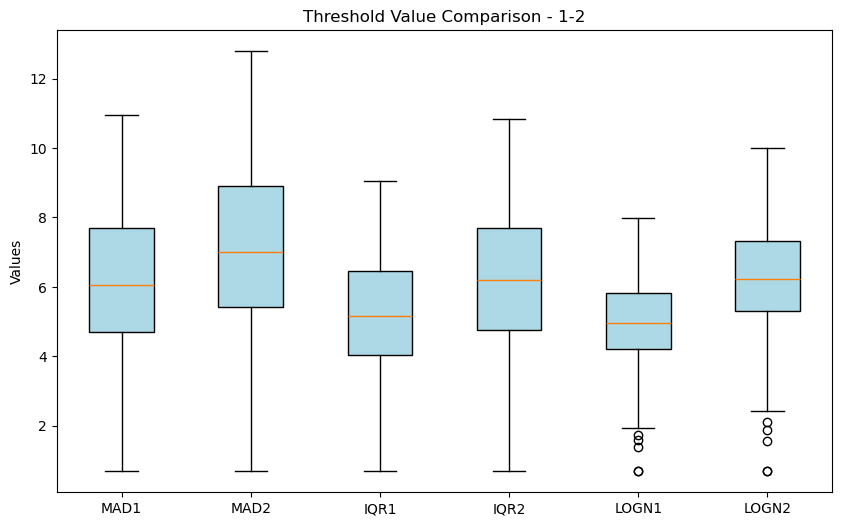

In [42]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_weak1_lightning, "1-2", ax=None)

In [43]:
# Create basin threshold based off mean and 2 standard dev - 1-2 categories
epac_weak1_summary = create_basin_summary(epac_weak1_lightning, "1-2", "EPAC")
epac_weak1_thresholds = calculate_basin_thresholds(epac_weak1_lightning, "1-2", "EPAC")
epac_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
1  EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
2  EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
3  EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
4  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
5  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  
0  10.962409           34           1561              2.18  
1  12.785568           25           1561              1.60  
2   9.045240           42           1561              2.69  
3  10.829707           15           1561              0.96  
4   7.998327           51           1561              3.27  
5   9.996606            2           1561              0.13

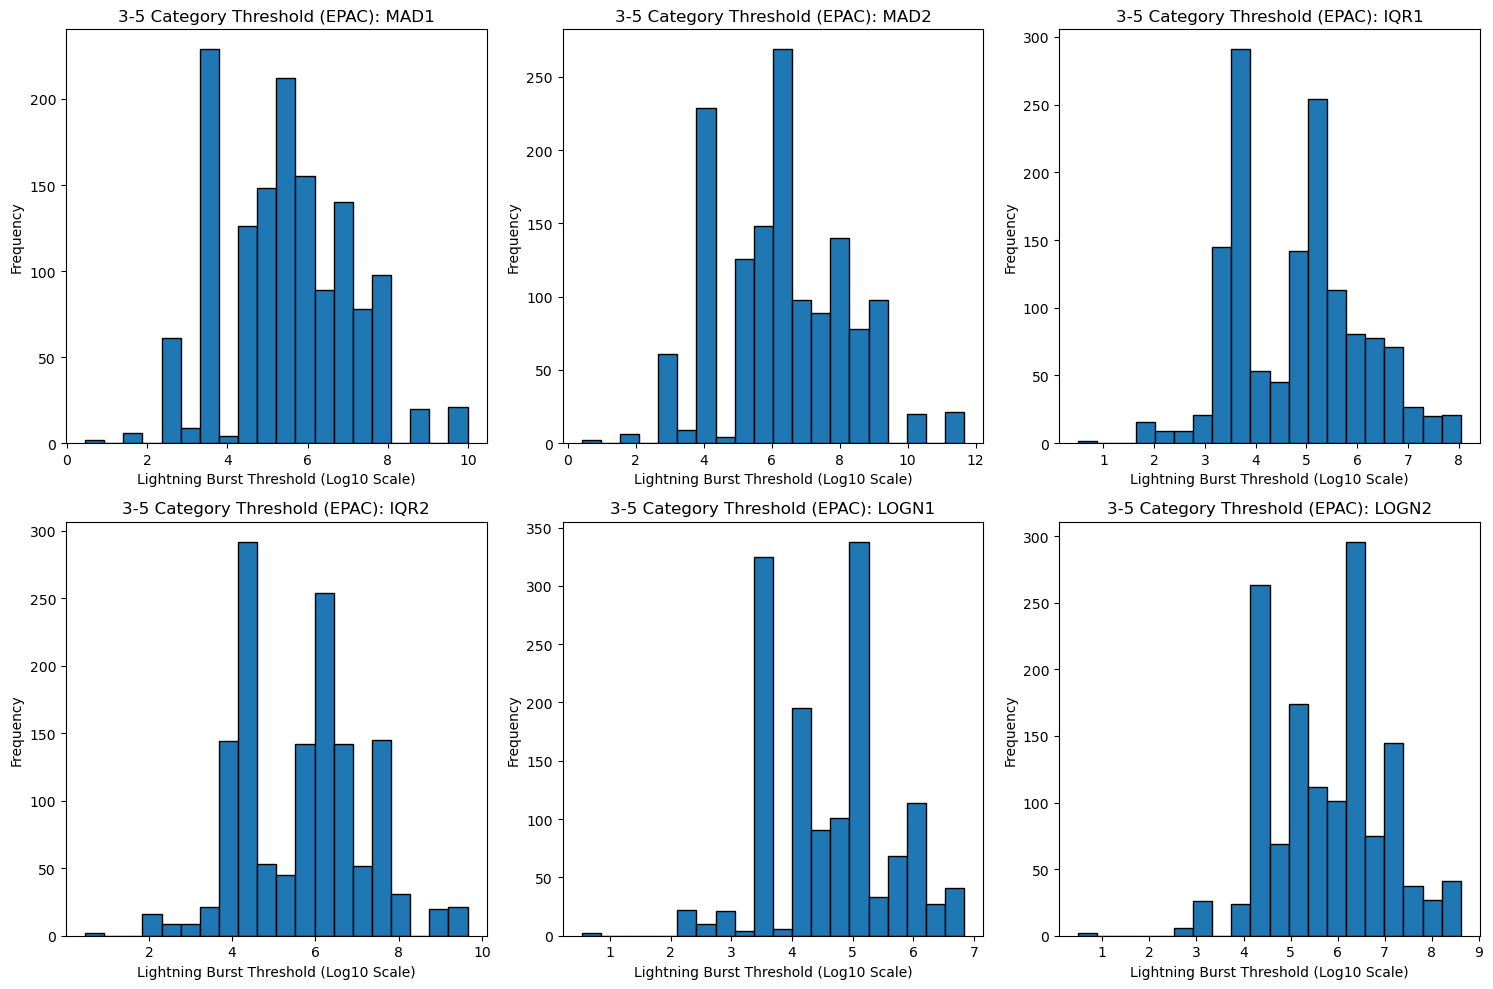

In [44]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_strong_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

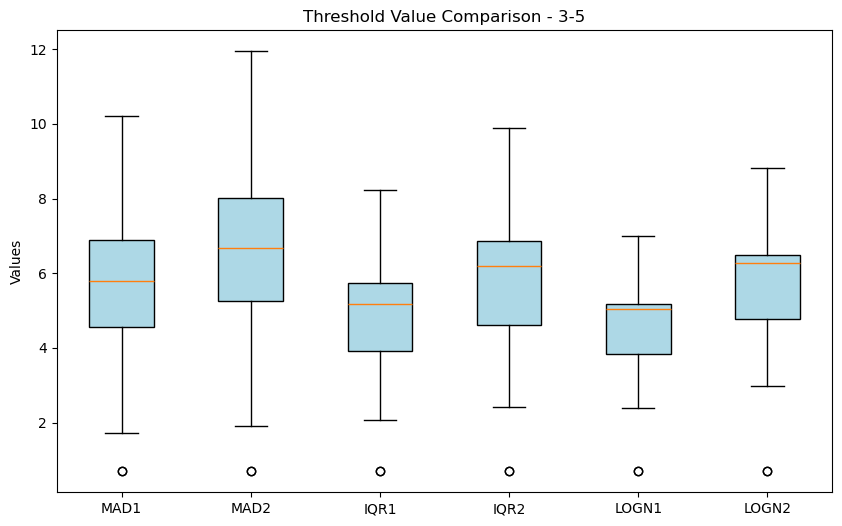

In [45]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_strong_lightning, "3-5", ax=None)

In [46]:
# Create basin threshold based off mean and 2 standard dev - 3-5 categories
epac_strong_summary = create_basin_summary(epac_strong_lightning, "3-5", "EPAC")
epac_strong_thresholds = calculate_basin_thresholds(epac_strong_lightning, "3-5", "EPAC")
epac_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
1  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
2  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
3  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
4  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
5  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  
0  10.223271           11           1398              0.79  
1  11.946037            1           1398              0.07  
2   8.230524           13           1398              0.93  
3   9.885795            0           1398              0.00  
4   6.999298           16           1398              1.14  
5   8.822181            0           1398              0.00

Apply the basin-category thresholds (mean and median based) to the basin by weak/strong category groupings. 

In [47]:
epac_weak0_summary, epac_weak0_bursts_mean, epac_weak0_summary_mean, epac_weak0_bursts_median, epac_weak0_summary_median = summarize_threshold_eval(epac_weak0_summary, epac_weak0_lightning, epac_weak0_thresholds)
epac_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5  EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.962409           82           3850              2.13   
1  12.785568           52           3850              1.35   
2   9.045240          119           3850              3.09   
3  10.829707           40           3850              1.04   
4   7.998327          141           3850              3.66   
5   9.996606            6           3850              0.16   

   Basin-Category  Threshold (Mean-Based) 2 SD  \
0                                    10.873827   
1                                    12.665256   
2                                     8.796140   
3                                    10.519485   
4                                     7.773955   
5                                     9.804544   

   Basin-Category  Threshold (Median-Based) 2 SD  \
0                                      11.014461   
1                                      12.700975   
2                                       8.907842   
3                                      10.635373   
4                                       7.825864   
5                                       9.959551   

   Basin-Category  Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    
5                                                  0    

   Basin-Category  Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                                0.0              
1                                                0.0              
2                                                0.0              
3                                                0.0              
4                                                0.0              
5                                                0.0              

   Basin-Category  Threshold Bursts (Median-Based) 2 SD  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      
5                                                  0      

   Basin-Category  Threshold Burst Percentage (Median-Based) 2 SD  
0                                                0.0               
1                                                0.0               
2                                                0.0               
3                                                0.0               
4                                                0.0               
5                                                0.0

We see that these basin-category thresholds are very high and end up flagging 0 timebins as bursts. Let's do the same for the stronger categories.

In [48]:
epac_weak1_summary, epac_weak1_bursts_mean, epac_weak1_summary_mean, epac_weak1_bursts_median, epac_weak1_summary_median = summarize_threshold_eval(epac_weak1_summary, epac_weak1_lightning, epac_weak1_thresholds)
epac_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
1  EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
2  EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
3  EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
4  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
5  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.962409           34           1561              2.18   
1  12.785568           25           1561              1.60   
2   9.045240           42           1561              2.69   
3  10.829707           15           1561              0.96   
4   7.998327           51           1561              3.27   
5   9.996606            2           1561              0.13   

   Basin-Category  Threshold (Mean-Based) 2 SD  \
0                                    10.451083   
1                                    12.192618   
2                                     8.423303   
3                                    10.095269   
4                                     7.443267   
5                                     9.410440   

   Basin-Category  Threshold (Median-Based) 2 SD  \
0                                      10.394819   
1                                      12.091953   
2                                       8.349279   
3                                      10.034941   
4                                       7.479467   
5                                       9.405154   

   Basin-Category  Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    
5                                                  0    

   Basin-Category  Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                                0.0              
1                                                0.0              
2                                                0.0              
3                                                0.0              
4                                                0.0              
5                                                0.0              

   Basin-Category  Threshold Bursts (Median-Based) 2 SD  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      
5                                                  0      

   Basin-Category  Threshold Burst Percentage (Median-Based) 2 SD  
0                                                0.0               
1                                                0.0               
2                                                0.0               
3                                                0.0               
4                                                0.0               
5                                                0.0

Let's do the same for the 3-5 category group.

In [49]:
epac_strong_summary, epac_strong_bursts_mean, epac_strong_summary_mean, epac_strong_bursts_median,  epac_strong_summary_median = summarize_threshold_eval(epac_strong_summary, epac_strong_lightning, epac_strong_thresholds)
epac_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
1  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
2  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
3  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
4  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
5  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.223271           11           1398              0.79   
1  11.946037            1           1398              0.07   
2   8.230524           13           1398              0.93   
3   9.885795            0           1398              0.00   
4   6.999298           16           1398              1.14   
5   8.822181            0           1398              0.00   

   Basin-Category  Threshold (Mean-Based) 2 SD  \
0                                     8.990233   
1                                    10.418769   
2                                     7.481199   
3                                     8.859763   
4                                     6.727951   
5                                     8.417509   

   Basin-Category  Threshold (Median-Based) 2 SD  \
0                                       9.062898   
1                                      10.492969   
2                                       7.663448   
3                                       9.152255   
4                                       7.005167   
5                                       8.738997   

   Basin-Category  Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    
5                                                  0    

   Basin-Category  Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                                0.0              
1                                                0.0              
2                                                0.0              
3                                                0.0              
4                                                0.0              
5                                                0.0              

   Basin-Category  Threshold Bursts (Median-Based) 2 SD  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      
5                                                  0      

   Basin-Category  Threshold Burst Percentage (Median-Based) 2 SD  
0                                                0.0               
1                                                0.0               
2                                                0.0               
3                                                0.0               
4                                                0.0               
5                                                0.0

Once again, we see no bursts using the basin-category thresholds (2 standard deviations from mean/median).

Let's look at the distribution of "effective" thresholds - ones where at least one timebin was flagged as a burst.

In [50]:
# Filter data to only those with at least one "True" value in the burst columns, grouped by storm code
# Do not include thresholds that don't flag a burst
epac_bursts_effective = filter_effective_thresholds(epac_bursts)
epac_storm_codes_effective = epac_bursts_effective["storm_code"].unique()
epac_tc_summary_effective = epac_tc_summary[epac_tc_summary["storm_code"].isin(epac_storm_codes_effective)]

epac_bursts_effective.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
10077 2010-06-22 07:30:00  EPAC_10_4              122  2010      6   22     7   
10097 2010-06-24 07:30:00  EPAC_10_4              135  2010      6   24     7   
10148 2010-08-24 03:00:00  EPAC_10_9              136  2010      8   24     3   
10155 2010-08-24 12:30:00  EPAC_10_9              138  2010      8   24    12   
10192 2010-08-25 14:30:00  EPAC_10_9              194  2010      8   25    14   

       minute   lat    lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
10077      30  11.6 -104.3  ...             NaN             NaN      False   
10097      30  12.3 -112.2  ...             NaN             NaN      False   
10148       0  15.2 -100.5  ...             NaN             NaN      False   
10155      30  15.4 -101.1  ...             NaN             NaN      False   
10192      30  16.5 -104.6  ...             NaN             NaN      False   

       burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
10077       False            NaN             NaN         True        False   
10097       False            NaN             NaN         True        False   
10148       False       6.063117             NaN         True        False   
10155       False       6.063117             NaN         True        False   
10192       False       6.063117             NaN         True        False   

      logn1_threshold logn2_threshold  
10077        4.679426             NaN  
10097        4.679426             NaN  
10148        4.643800             NaN  
10155        4.643800             NaN  
10192        4.643800             NaN  

[5 rows x 34 columns]

In [266]:
print(f"{len(epac_storm_codes_effective)} TCs of {len(epac_storm_codes)} EPAC TCs after filtering for bursts of any type")

59 TCs of 82 EPAC TCs after filtering for bursts of any type


In [267]:
epac_effective_summary = create_basin_summary(epac_bursts_effective, "all", "EPAC")
epac_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            all      mad1  4.570221  1.662344  4.270455  0.693147   
1  EPAC            all      mad2  3.907350  1.387424  3.125938  0.693147   
2  EPAC            all      iqr1  3.643620  0.960844  3.701302  1.386294   
3  EPAC            all      iqr2  3.946447  0.905727  4.453341  1.559581   
4  EPAC            all     logn1  4.624058  1.029793  4.560759  2.343750   
5  EPAC            all     logn2  5.006578  0.901697  5.368579  3.436726   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.258979           93            204             45.59  
1  8.132119           53            204             25.98  
2  6.191953          132            204             64.71  
3  5.891751           40            204             19.61  
4  6.767766          157            204             76.96  
5  5.986970            6            204              2.94

In this context, the burst percentage represents how much of the total number of flagged bursts (across all threshold types) the particular threshold type flagged. For example, 204 timebins means there are 204 total bursts across all TCs in the EPAC basin and across all 6 threshold types. Of these, 64.71% were flagged by the MAD method, specifically the first threshold value (the lower one). It can be noted that the burst percentages do not add up to 100% due to the fact that multiple thresholds will flag the same burst.

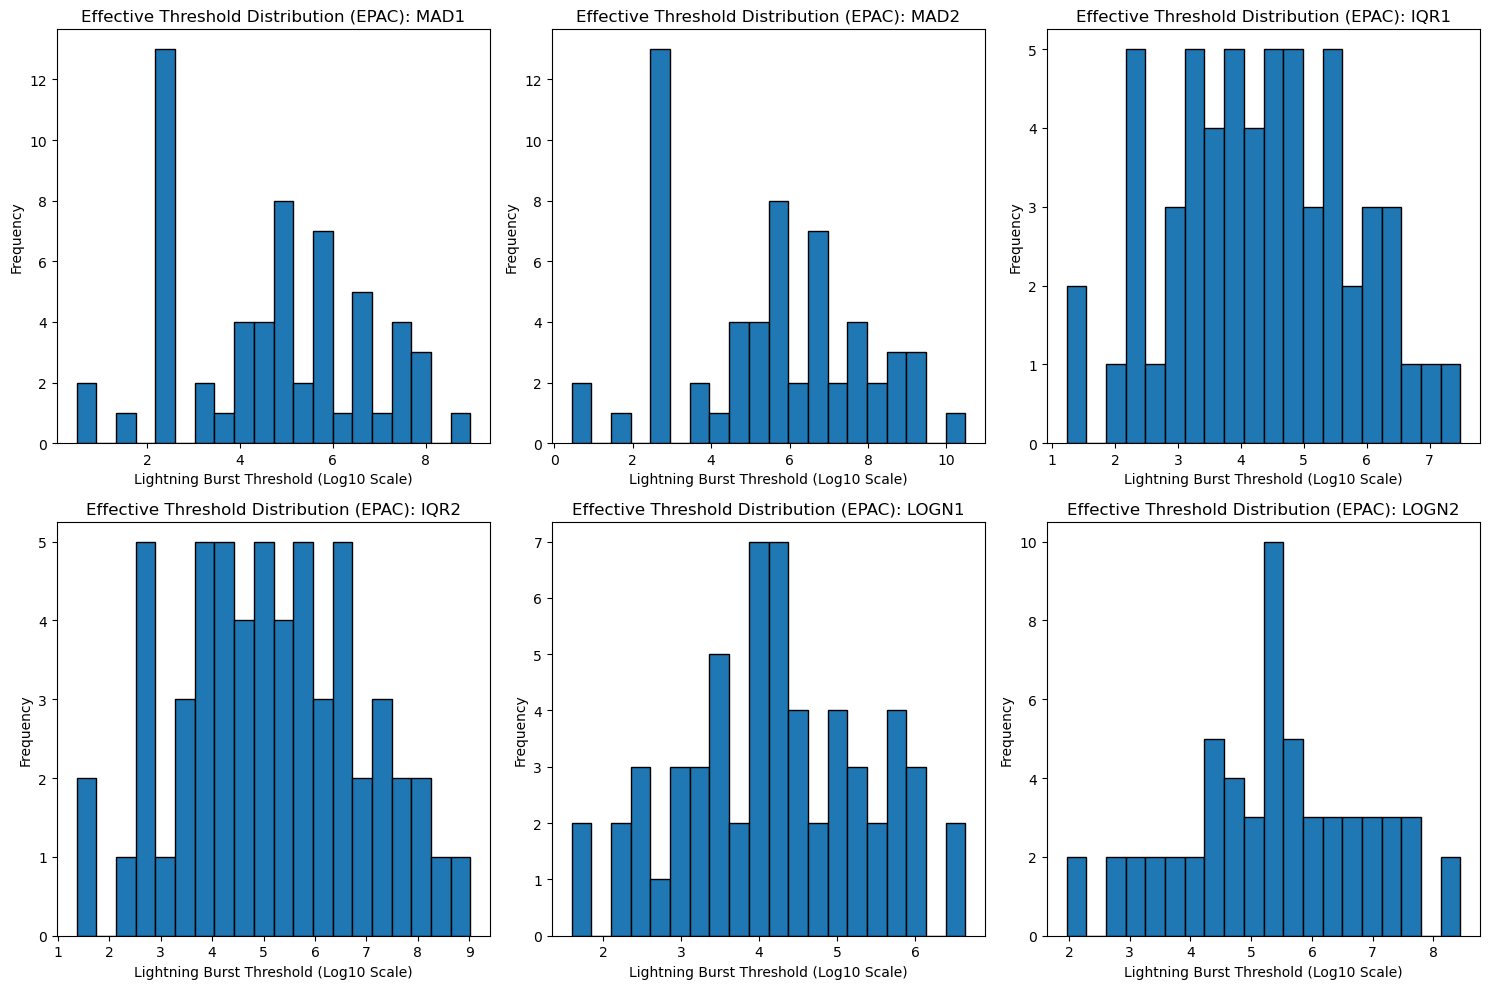

In [53]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_tc_summary_effective, threshold, ax=axes[i])
    axes[i].set_title(f"Effective Threshold Distribution (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [268]:
# Group the data into weak and strong category datasets using function
epac_weak0_effective_lightning, epac_weak1_effective_lightning, epac_strong_effective_lightning = group_bins_category(epac_bursts_effective)

181 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
68 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
23 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


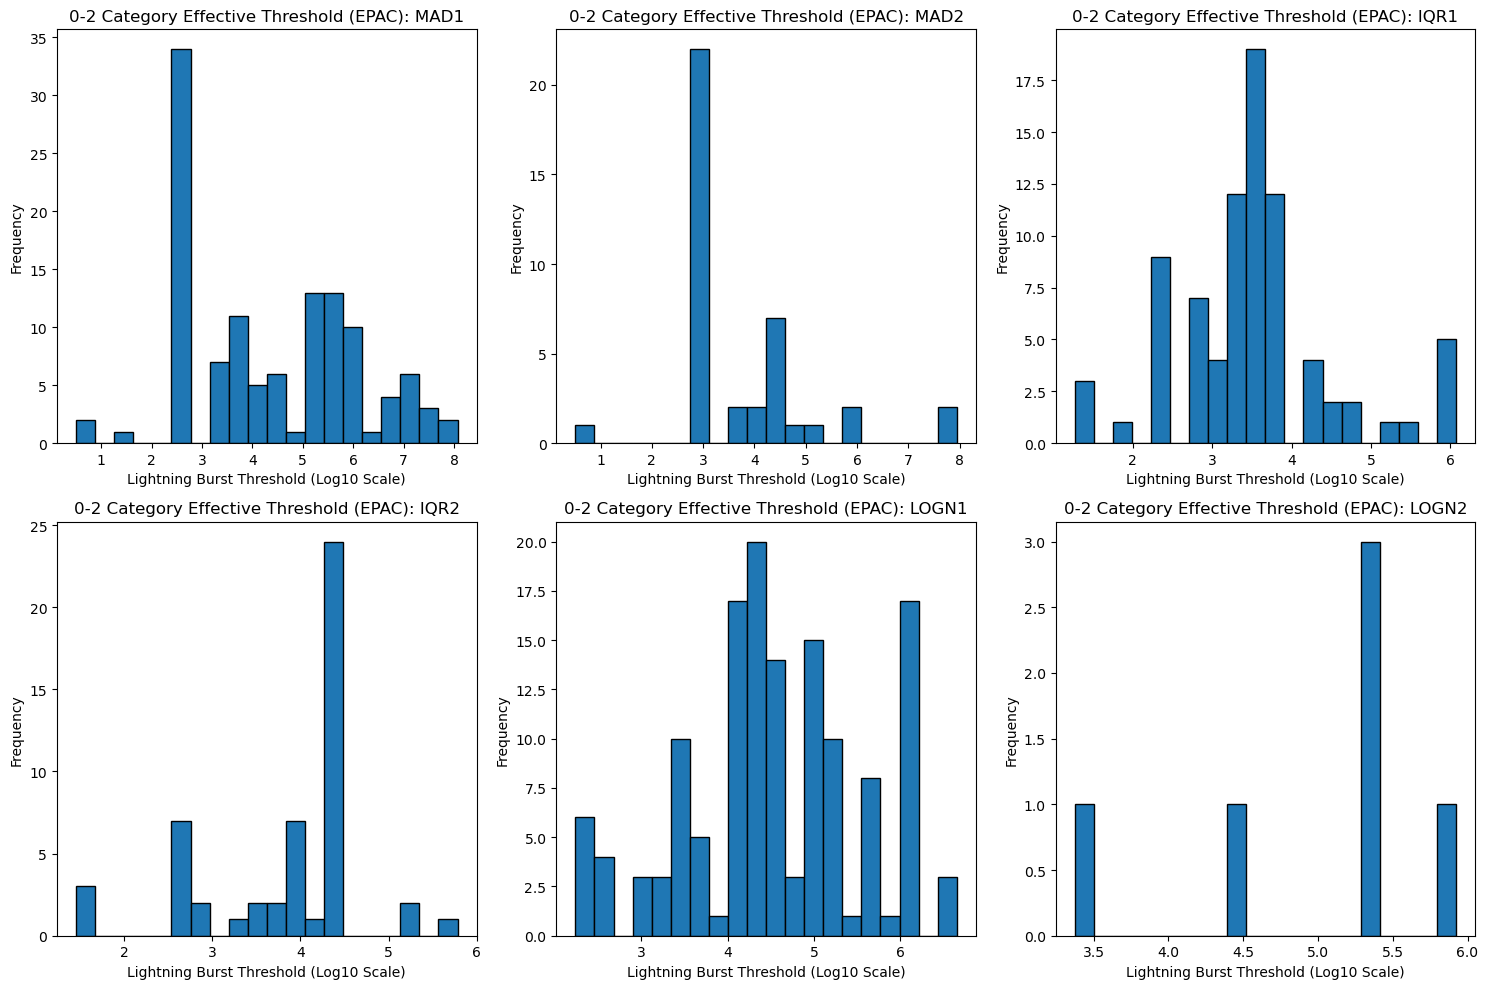

In [55]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak0_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Effective Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [56]:
# Get summary for effective thresholds - 0-2 categories
epac_weak0_effective_summary = create_basin_summary(epac_weak0_effective_lightning, "0-2", "EPAC")
epac_weak0_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  4.557847  1.722731  4.382027  0.693147   
1  EPAC            0-2      mad2  3.907350  1.387424  3.125938  0.693147   
2  EPAC            0-2      iqr1  3.642842  0.994310  3.701302  1.386294   
3  EPAC            0-2      iqr2  3.967640  0.901196  4.453341  1.559581   
4  EPAC            0-2     logn1  4.649019  1.041497  4.560759  2.343750   
5  EPAC            0-2     logn2  5.006578  0.901697  5.368579  3.436726   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.258979           82            181             45.30  
1  8.132119           52            181             28.73  
2  6.191953          119            181             65.75  
3  5.891751           40            181             22.10  
4  6.767766          141            181             77.90  
5  5.986970            6            181              3.31

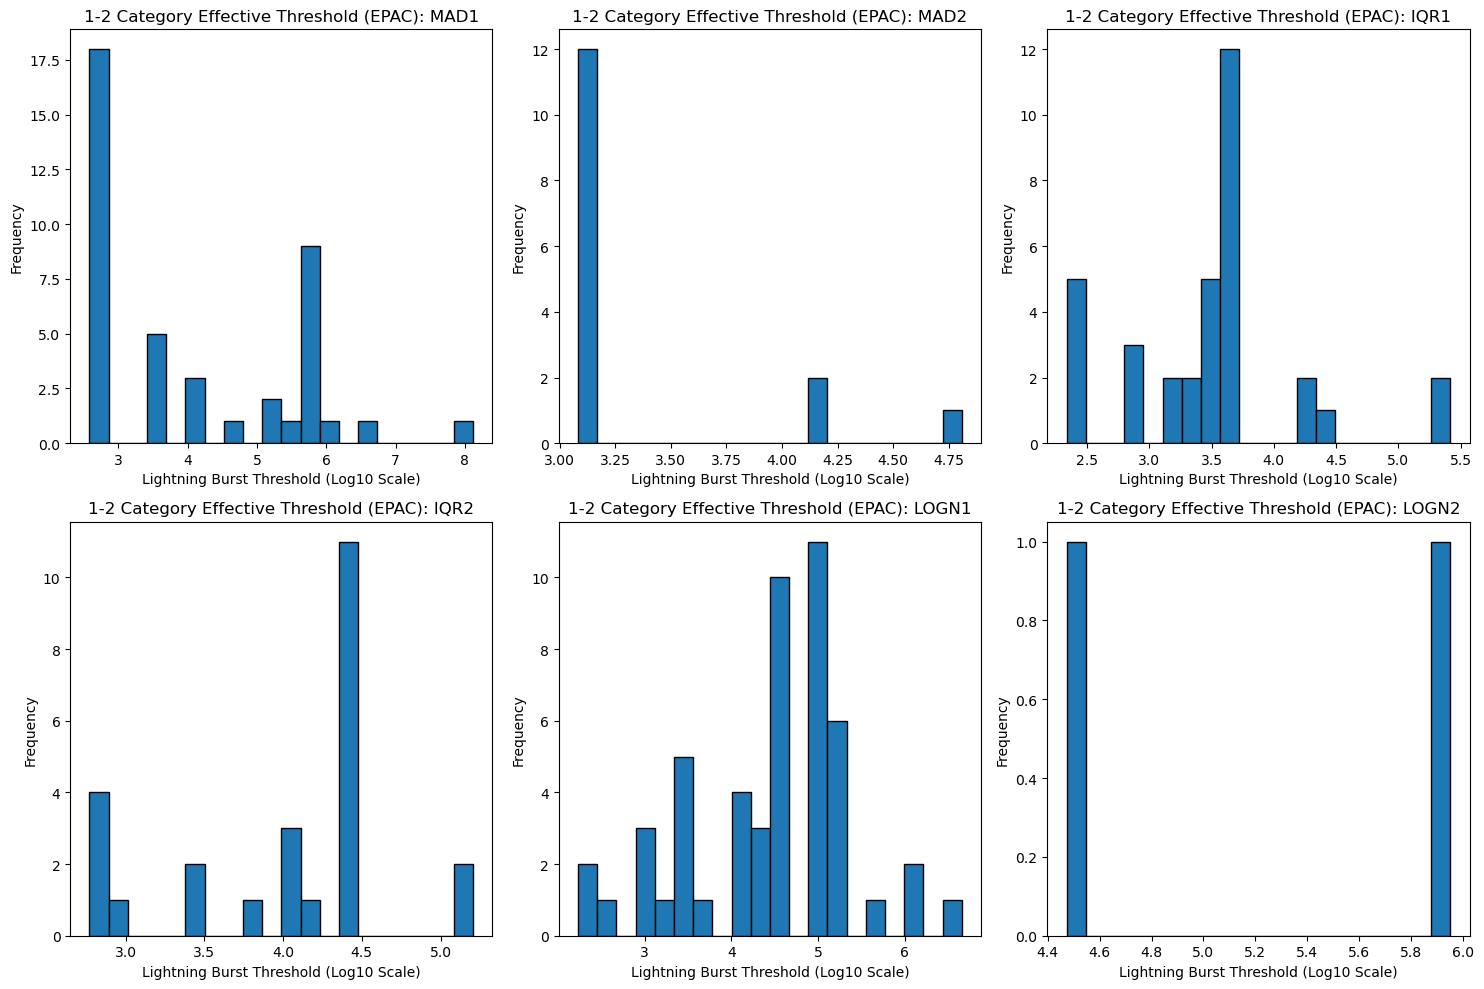

In [57]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak1_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Effective Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [269]:
# Get summary for effective thresholds - 1-2 categories
epac_weak1_effective_summary = create_basin_summary(epac_weak1_effective_lightning, "1-2", "EPAC")
epac_weak1_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  4.162957  1.547052  3.652740  2.720473   
1  EPAC            1-2      mad2  3.379361  0.545723  3.125938  3.125938   
2  EPAC            1-2      iqr1  3.545660  0.716110  3.612965  2.414157   
3  EPAC            1-2      iqr2  4.055095  0.717920  4.453341  2.831480   
4  EPAC            1-2     logn1  4.525435  0.957033  4.560759  2.343750   
5  EPAC            1-2     logn2  5.248504  1.044348  5.248504  4.510039   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.258979           34             68             50.00  
1  4.852030           25             68             36.76  
2  5.493061           42             68             61.76  
3  5.268244           15             68             22.06  
4  6.767766           51             68             75.00  
5  5.986970            2             68              2.94

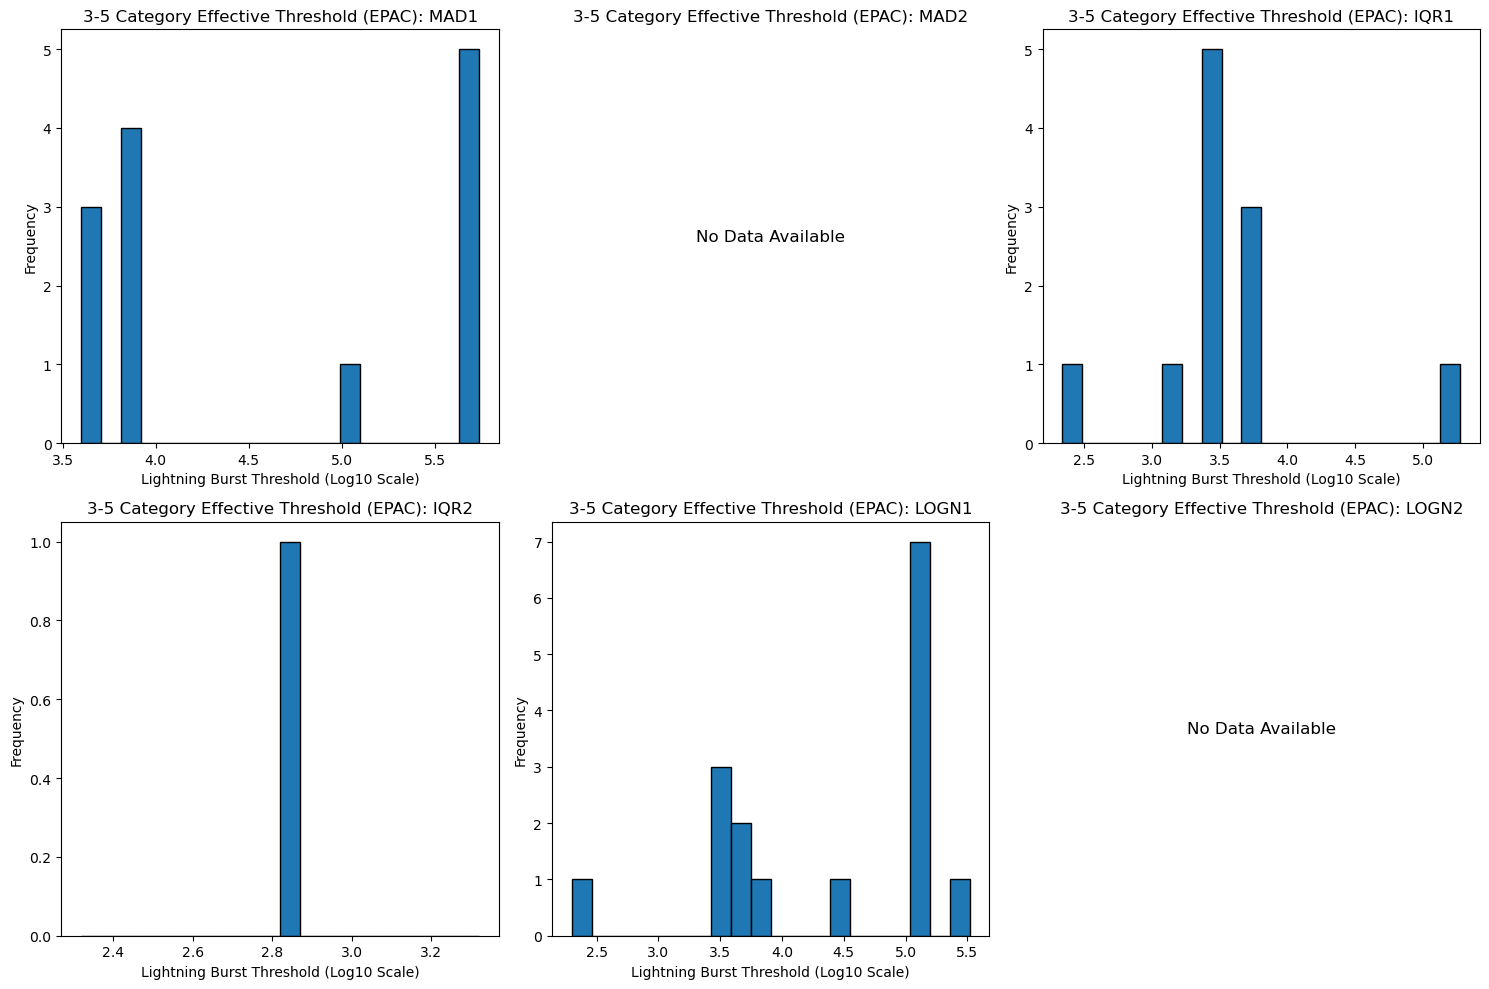

In [59]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_strong_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Effective Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [270]:
# Get summary for effective thresholds - 3-5 categories
epac_strong_effective_summary = create_basin_summary(epac_strong_effective_lightning, "3-5", "EPAC")
epac_strong_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  4.683494  0.983965  3.960585  3.652740   
1  EPAC            3-5      mad2       NaN       NaN       NaN       NaN   
2  EPAC            3-5      iqr1  3.649424  0.696790  3.524627  2.414157   
3  EPAC            3-5      iqr2  2.844409       NaN  2.844409  2.844409   
4  EPAC            3-5     logn1  4.404095  0.920568  4.816549  2.379402   
5  EPAC            3-5     logn2       NaN       NaN       NaN       NaN   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  5.792262           11             23             47.83  
1       NaN            1             23              4.35  
2  5.348297           13             23             56.52  
3  2.844409            0             23              0.00  
4  5.598135           16             23             69.57  
5       NaN            0             23              0.00

Let's calculate and apply the basin-level effective threshold. We'll try both 1.5 SD and 2 SD from the mean and median of the effective thresholds for each category group.

Start with the 0-2 category grouping.

In [61]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
epac_weak0_effective_thresholds = calculate_basin_thresholds(epac_weak0_effective_lightning, "0-2", "EPAC", threshold_type="effective")
epac_weak0_effective_thresholds_1_5sd = calculate_basin_thresholds(epac_weak0_effective_lightning, "0-2", "EPAC", std_dev=1.5, threshold_type="effective")
# Reset the summary dataframe to drop the basin-category threshold (not effective ver)
epac_weak0_summary = create_basin_summary(epac_weak0_lightning, "0-2", "EPAC")

In [62]:
# 0-2 categories, 2 SD
epac_weak0_summary_2sd, epac_weak0_eff_bursts_mean, epac_weak0_eff_summary_mean, epac_weak0_eff_bursts_median, epac_weak0_eff_summary_median = summarize_threshold_eval(epac_weak0_summary, epac_weak0_lightning, epac_weak0_effective_thresholds, threshold_type="effective")
epac_weak0_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5  EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.962409           82           3850              2.13   
1  12.785568           52           3850              1.35   
2   9.045240          119           3850              3.09   
3  10.829707           40           3850              1.04   
4   7.998327          141           3850              3.66   
5   9.996606            6           3850              0.16   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           8.003309      
1                                           6.682197      
2                                           5.631462      
3                                           5.770032      
4                                           6.732013      
5                                           6.809973      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           7.827488        
1                                           5.900785        
2                                           5.689922        
3                                           6.255733        
4                                           6.643753        
5                                           7.171973        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                 23             
2                                                170             
3                                                140             
4                                                 18             
5                                                 16             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.60                       
2                                               4.42                       
3                                               3.64                       
4                                               0.47                       
5                                               0.42                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                113               
2                                                157               
3                                                 72               
4                                                 27               
5                                                  3               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.00                        
1                                               2.94                        
2                                               4.08                        
3                                               1.87                        
4                                               0.70                        
5                                               0.08

In [63]:
# 0-2 categories, 1.5 SD
epac_weak0_summary_1_5sd, epac_weak0_eff_bursts_mean_1_5, epac_weak0_eff_summary_mean_1_5, epac_weak0_eff_bursts_median_1_5, epac_weak0_eff_summary_median_1_5 = summarize_threshold_eval(epac_weak0_summary, epac_weak0_lightning, epac_weak0_effective_thresholds_1_5sd, threshold_type="effective")
epac_weak0_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5  EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.962409           82           3850              2.13   
1  12.785568           52           3850              1.35   
2   9.045240          119           3850              3.09   
3  10.829707           40           3850              1.04   
4   7.998327          141           3850              3.66   
5   9.996606            6           3850              0.16   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           7.141943        
1                                           5.988485        
2                                           5.134307        
3                                           5.319434        
4                                           6.211264        
5                                           6.359124        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.966123          
1                                           5.207073          
2                                           5.192767          
3                                           5.805135          
4                                           6.123004          
5                                           6.721124          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  3               
1                                                103               
2                                                306               
3                                                247               
4                                                 77               
5                                                 56               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.08                         
1                                               2.68                         
2                                               7.95                         
3                                               6.42                         
4                                               2.00                         
5                                               1.45                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                  8                 
1                                                281                 
2                                                287                 
3                                                134                 
4                                                 88                 
5                                                 20                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               0.21                          
1                                               7.30                          
2                                               7.45                          
3                                               3.48                          
4                                               2.29                          
5                                               0.52

In [271]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = epac_weak0_summary_1_5sd.columns[-6: ].to_list()
keep.append(epac_weak0_summary_1_5sd.columns[2])
epac_weak0_summary = pd.merge(epac_weak0_summary_2sd, epac_weak0_summary_1_5sd[keep], on="Threshold")
epac_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5  EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   

         Max  Burst Count  Timebin Count  ...  \
0  10.962409           82           3850  ...   
1  12.785568           52           3850  ...   
2   9.045240          119           3850  ...   
3  10.829707           40           3850  ...   
4   7.998327          141           3850  ...   
5   9.996606            6           3850  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                 23             
2                                                170             
3                                                140             
4                                                 18             
5                                                 16             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.60                       
2                                               4.42                       
3                                               3.64                       
4                                               0.47                       
5                                               0.42                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                113               
2                                                157               
3                                                 72               
4                                                 27               
5                                                  3               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.00                         
1                                               2.94                         
2                                               4.08                         
3                                               1.87                         
4                                               0.70                         
5                                               0.08                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           7.141943        
1                                           5.988485        
2                                           5.134307        
3                                           5.319434        
4                                           6.211264        
5                                           6.359124        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.966123          
1                                           5.207073          
2                                           5.192767          
3                                           5.805135          
4                                           6.123004          
5                                           6.721124          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  3               
1                                                103               
2                              

Let's do the same for the other 2 category groupings.

1-2 categories:

In [65]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
epac_weak1_effective_thresholds = calculate_basin_thresholds(epac_weak1_effective_lightning, "1-2", "EPAC", threshold_type="effective")
epac_weak1_effective_thresholds_1_5sd = calculate_basin_thresholds(epac_weak1_effective_lightning, "1-2", "EPAC", std_dev=1.5, threshold_type="effective")
# Reset the summary dataframe to drop the basin-category threshold (not effective ver)
epac_weak1_summary = create_basin_summary(epac_weak1_lightning, "1-2", "EPAC")

In [66]:
# 1-2 categories, 2 SD
epac_weak1_summary_2sd, epac_weak1_eff_bursts_mean, epac_weak1_eff_summary_mean, epac_weak1_eff_bursts_median, epac_weak1_eff_summary_median = summarize_threshold_eval(epac_weak1_summary, epac_weak1_lightning, epac_weak1_effective_thresholds, threshold_type="effective")
epac_weak1_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
1  EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
2  EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
3  EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
4  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
5  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.962409           34           1561              2.18   
1  12.785568           25           1561              1.60   
2   9.045240           42           1561              2.69   
3  10.829707           15           1561              0.96   
4   7.998327           51           1561              3.27   
5   9.996606            2           1561              0.13   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           7.257060      
1                                           4.470807      
2                                           4.977881      
3                                           5.490936      
4                                           6.439500      
5                                           7.337200      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           6.746844        
1                                           4.217384        
2                                           5.045186        
3                                           5.889181        
4                                           6.474824        
5                                           7.337200        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  1             
1                                                107             
2                                                 63             
3                                                 30             
4                                                  3             
5                                                  1             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.06                       
1                                               6.85                       
2                                               4.04                       
3                                               1.92                       
4                                               0.19                       
5                                               0.06                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  2               
1                                                146               
2                                                 61               
3                                                 14               
4                                                  3               
5                                                  1               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.13                        
1                                               9.35                        
2                                               3.91                        
3                                               0.90                        
4                                               0.19                        
5                                               0.06

In [67]:
# 1-2 categories, 1.5 SD
epac_weak1_summary_1_5sd, epac_weak1_eff_bursts_mean_1_5, epac_weak1_eff_summary_mean_1_5, epac_weak1_eff_bursts_median_1_5, epac_weak1_eff_summary_median_1_5 = summarize_threshold_eval(epac_weak1_summary, epac_weak1_lightning, epac_weak1_effective_thresholds_1_5sd, threshold_type="effective")
epac_weak1_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
1  EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
2  EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
3  EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
4  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
5  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.962409           34           1561              2.18   
1  12.785568           25           1561              1.60   
2   9.045240           42           1561              2.69   
3  10.829707           15           1561              0.96   
4   7.998327           51           1561              3.27   
5   9.996606            2           1561              0.13   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.483535        
1                                           4.197946        
2                                           4.619825        
3                                           5.131976        
4                                           5.960984        
5                                           6.815026        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.973318          
1                                           3.944522          
2                                           4.687130          
3                                           5.530221          
4                                           5.996308          
5                                           6.815026          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  3               
1                                                146               
2                                                 96               
3                                                 57               
4                                                 12               
5                                                  2               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.19                         
1                                               9.35                         
2                                               6.15                         
3                                               3.65                         
4                                               0.77                         
5                                               0.13                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                 12                 
1                                                186                 
2                                                 90                 
3                                                 28                 
4                                                 12                 
5                                                  2                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               0.77                          
1                                              11.92                          
2                                               5.77                          
3                                               1.79                          
4                                               0.77                          
5                                               0.13

In [68]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = epac_weak1_summary_1_5sd.columns[-6: ].to_list()
keep.append(epac_weak1_summary_1_5sd.columns[2])
epac_weak1_summary = pd.merge(epac_weak1_summary_2sd, epac_weak1_summary_1_5sd[keep], on="Threshold")
epac_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
1  EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
2  EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
3  EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
4  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
5  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   

         Max  Burst Count  Timebin Count  ...  \
0  10.962409           34           1561  ...   
1  12.785568           25           1561  ...   
2   9.045240           42           1561  ...   
3  10.829707           15           1561  ...   
4   7.998327           51           1561  ...   
5   9.996606            2           1561  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  1             
1                                                107             
2                                                 63             
3                                                 30             
4                                                  3             
5                                                  1             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.06                       
1                                               6.85                       
2                                               4.04                       
3                                               1.92                       
4                                               0.19                       
5                                               0.06                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  2               
1                                                146               
2                                                 61               
3                                                 14               
4                                                  3               
5                                                  1               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.13                         
1                                               9.35                         
2                                               3.91                         
3                                               0.90                         
4                                               0.19                         
5                                               0.06                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.483535        
1                                           4.197946        
2                                           4.619825        
3                                           5.131976        
4                                           5.960984        
5                                           6.815026        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.973318          
1                                           3.944522          
2                                           4.687130          
3                                           5.530221          
4                                           5.996308          
5                                           6.815026          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  3               
1                                                146               
2                              

Next, we do the same for the stronger category group, 3-5.

In [69]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
epac_strong_effective_thresholds = calculate_basin_thresholds(epac_strong_effective_lightning, "3-5", "EPAC", threshold_type="effective")
epac_strong_effective_thresholds_1_5sd = calculate_basin_thresholds(epac_strong_effective_lightning, "3-5", "EPAC", std_dev=1.5, threshold_type="effective")
# Reset the summary dataframe to drop the basin-category threshold (not effective ver)
epac_strong_summary = create_basin_summary(epac_strong_lightning, "3-5", "EPAC")

In [70]:
# 3-5 categories, 2 SD
epac_strong_summary_2sd, epac_strong_eff_bursts_mean, epac_strong_eff_summary_mean, epac_strong_eff_bursts_median, epac_strong_eff_summary_median = summarize_threshold_eval(epac_strong_summary, epac_strong_lightning, epac_strong_effective_thresholds, threshold_type="effective")
epac_strong_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
1  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
2  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
3  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
4  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
5  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.223271           11           1398              0.79   
1  11.946037            1           1398              0.07   
2   8.230524           13           1398              0.93   
3   9.885795            0           1398              0.00   
4   6.999298           16           1398              1.14   
5   8.822181            0           1398              0.00   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           6.651423      
1                                                NaN      
2                                           5.043004      
3                                                NaN      
4                                           6.245231      
5                                                NaN      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           5.928514        
1                                                NaN        
2                                           4.918208        
3                                                NaN        
4                                           6.657686        
5                                                NaN        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  0             
2                                                 25             
3                                                  0             
4                                                  0             
5                                                  0             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.00                       
2                                               1.79                       
3                                               0.00                       
4                                               0.00                       
5                                               0.00                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  2               
1                                                  0               
2                                                 31               
3                                                  0               
4                                                  0               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.14                        
1                                               0.00                        
2                                               2.22                        
3                                               0.00                        
4                                               0.00                        
5                                               0.00

In [71]:
# 3-5 categories, 1.5 SD
epac_strong_summary_1_5sd, epac_strong_eff_bursts_mean_1_5, epac_strong_eff_summary_mean_1_5, epac_strong_eff_bursts_median_1_5, epac_strong_eff_summary_median_1_5 = summarize_threshold_eval(epac_strong_summary, epac_strong_lightning, epac_strong_effective_thresholds_1_5sd, threshold_type="effective")
epac_strong_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
1  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
2  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
3  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
4  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
5  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.223271           11           1398              0.79   
1  11.946037            1           1398              0.07   
2   8.230524           13           1398              0.93   
3   9.885795            0           1398              0.00   
4   6.999298           16           1398              1.14   
5   8.822181            0           1398              0.00   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.159441        
1                                                NaN        
2                                           4.694609        
3                                                NaN        
4                                           5.784947        
5                                                NaN        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.436531          
1                                                NaN          
2                                           4.569813          
3                                                NaN          
4                                           6.197402          
5                                                NaN          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  1               
1                                                  0               
2                                                 41               
3                                                  0               
4                                                  4               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.07                         
1                                               0.00                         
2                                               2.93                         
3                                               0.00                         
4                                               0.29                         
5                                               0.00                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                 11                 
1                                                  0                 
2                                                 52                 
3                                                  0                 
4                                                  1                 
5                                                  0                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               0.79                          
1                                               0.00                          
2                                               3.72                          
3                                               0.00                          
4                                               0.07                          
5                                               0.00

In [72]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = epac_strong_summary_1_5sd.columns[-6: ].to_list()
keep.append(epac_strong_summary_1_5sd.columns[2])
epac_strong_summary = pd.merge(epac_strong_summary_2sd, epac_strong_summary_1_5sd[keep], on="Threshold")
epac_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
1  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
2  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
3  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
4  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
5  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

         Max  Burst Count  Timebin Count  ...  \
0  10.223271           11           1398  ...   
1  11.946037            1           1398  ...   
2   8.230524           13           1398  ...   
3   9.885795            0           1398  ...   
4   6.999298           16           1398  ...   
5   8.822181            0           1398  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  0             
2                                                 25             
3                                                  0             
4                                                  0             
5                                                  0             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.00                       
2                                               1.79                       
3                                               0.00                       
4                                               0.00                       
5                                               0.00                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  2               
1                                                  0               
2                                                 31               
3                                                  0               
4                                                  0               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.14                         
1                                               0.00                         
2                                               2.22                         
3                                               0.00                         
4                                               0.00                         
5                                               0.00                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.159441        
1                                                NaN        
2                                           4.694609        
3                                                NaN        
4                                           5.784947        
5                                                NaN        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.436531          
1                                                NaN          
2                                           4.569813          
3                                                NaN          
4                                           6.197402          
5                                                NaN          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  1               
1                                                  0               
2                              

Concatenate the three dataframes into one for easier comparison at the basin level.

In [73]:
epac_basin_burst_summary = pd.concat([epac_weak0_summary, epac_weak1_summary, epac_strong_summary], ignore_index=True)
epac_basin_burst_summary.head()

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   

         Max  Burst Count  Timebin Count  ...  \
0  10.962409           82           3850  ...   
1  12.785568           52           3850  ...   
2   9.045240          119           3850  ...   
3  10.829707           40           3850  ...   
4   7.998327          141           3850  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                 23             
2                                                170             
3                                                140             
4                                                 18             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.60                       
2                                               4.42                       
3                                               3.64                       
4                                               0.47                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                113               
2                                                157               
3                                                 72               
4                                                 27               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.00                         
1                                               2.94                         
2                                               4.08                         
3                                               1.87                         
4                                               0.70                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           7.141943        
1                                           5.988485        
2                                           5.134307        
3                                           5.319434        
4                                           6.211264        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.966123          
1                                           5.207073          
2                                           5.192767          
3                                           5.805135          
4                                           6.123004          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  3               
1                                                103               
2                                                306               
3                                                247               
4                                                 77               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.08                         
1                                               2.68                         
2                                               7.95                         
3                                               6.4

In [74]:
epac_basin_burst_summary.to_csv("data/innercore_epac_basin_bursts_summary.csv", index=False)

In [75]:
# Concatenate the burst and summary datasets - weak0
# 2 SD
epac_weak0_bursts_effthreshold = combine_mean_median_datasets(epac_weak0_eff_bursts_mean, epac_weak0_eff_bursts_median, 2, "0-2")
epac_weak0_summary_effthreshold = combine_mean_median_datasets(epac_weak0_eff_summary_mean, epac_weak0_eff_summary_median, 2, "0-2")

# 1.5 SD
epac_weak0_bursts_effthreshold_1_5 = combine_mean_median_datasets(epac_weak0_eff_bursts_mean_1_5, epac_weak0_eff_bursts_median_1_5, 1.5, "0-2")
epac_weak0_summary_effthreshold_1_5 = combine_mean_median_datasets(epac_weak0_eff_summary_mean_1_5, epac_weak0_eff_summary_median_1_5, 1.5, "0-2")

# Concat all
epac_weak0_bursts_effthreshold = pd.concat([epac_weak0_bursts_effthreshold, epac_weak0_bursts_effthreshold_1_5], ignore_index=True)
epac_weak0_summary_effthreshold = pd.concat([epac_weak0_summary_effthreshold, epac_weak0_summary_effthreshold_1_5], ignore_index=True)

In [76]:
# Concatenate the burst and summary datasets - weak1
# 2 SD
epac_weak1_bursts_effthreshold = combine_mean_median_datasets(epac_weak1_eff_bursts_mean, epac_weak1_eff_bursts_median, 2, "1-2")
epac_weak1_summary_effthreshold = combine_mean_median_datasets(epac_weak1_eff_summary_mean, epac_weak1_eff_summary_median, 2, "1-2")

# 1.5 SD
epac_weak1_bursts_effthreshold_1_5 = combine_mean_median_datasets(epac_weak1_eff_bursts_mean_1_5, epac_weak1_eff_bursts_median_1_5, 1.5, "1-2")
epac_weak1_summary_effthreshold_1_5 = combine_mean_median_datasets(epac_weak1_eff_summary_mean_1_5, epac_weak1_eff_summary_median_1_5, 1.5, "1-2")

# Concat all
epac_weak1_bursts_effthreshold = pd.concat([epac_weak1_bursts_effthreshold, epac_weak1_bursts_effthreshold_1_5], ignore_index=True)
epac_weak1_summary_effthreshold = pd.concat([epac_weak1_summary_effthreshold, epac_weak1_summary_effthreshold_1_5], ignore_index=True)

In [77]:
# Concatenate the burst and summary datasets - strong
# 2 SD
epac_strong_bursts_effthreshold = combine_mean_median_datasets(epac_strong_eff_bursts_mean, epac_strong_eff_bursts_median, 2, "3-5")
epac_strong_summary_effthreshold = combine_mean_median_datasets(epac_strong_eff_summary_mean, epac_strong_eff_summary_median, 2, "3-5")

# 1.5 SD
epac_strong_bursts_effthreshold_1_5 = combine_mean_median_datasets(epac_strong_eff_bursts_mean_1_5, epac_strong_eff_bursts_median_1_5, 1.5, "3-5")
epac_strong_summary_effthreshold_1_5 = combine_mean_median_datasets(epac_strong_eff_summary_mean_1_5, epac_strong_eff_summary_median_1_5, 1.5, "3-5")

# Concat all
epac_strong_bursts_effthreshold = pd.concat([epac_strong_bursts_effthreshold, epac_strong_bursts_effthreshold_1_5], ignore_index=True)
epac_strong_summary_effthreshold = pd.concat([epac_strong_summary_effthreshold, epac_strong_summary_effthreshold_1_5], ignore_index=True)

In [78]:
# Concat the weak and strong categories
epac_bursts_effthreshold = pd.concat([pd.concat([epac_weak0_bursts_effthreshold, epac_weak1_bursts_effthreshold], ignore_index=True), epac_strong_bursts_effthreshold], ignore_index=True)
epac_tc_summary_effthreshold = pd.concat([pd.concat([epac_weak0_summary_effthreshold, epac_weak1_summary_effthreshold], ignore_index=True), epac_strong_summary_effthreshold], ignore_index=True)

In [79]:
# Export to csv files
epac_bursts_effthreshold.to_csv("data/innercore_epac_basin_threshold_bursts.csv", index=False)
epac_tc_summary_effthreshold.to_csv("data/innercore_epac_basin_threshold_tc_summary.csv", index=False)

---------------------

### ATL Basin
Let's perform the same analysis for the ATL basin. Start by filtering for the ATL TCs.

In [272]:
# Get list of ATL storm codes
atl_data = innercore_data.filter(pl.col("basin") == "ATL")
atl_storm_codes = atl_data["storm_code"].unique()
atl_storm_codes.head(5)

shape: (5,)
Series: 'storm_code' [str]
[
	"ATL_19_9"
	"ATL_16_9"
	"ATL_20_29"
	"ATL_10_14"
	"ATL_20_27"
]

In [81]:
# Filter aggregated table to ATL only
atl_tc_summary = tc_summary[tc_summary["storm_code"].isin(atl_storm_codes)]
atl_tc_summary.head()

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
5   ATL_17_13      Katia            0            0        5.274601   
11  ATL_18_14    Michael            0            0        7.012608   
16  ATL_12_14     Nadine            1            0        5.274601   
20   ATL_13_9   Humberto            0            0        7.308490   
21  ATL_19_18      Pablo            0            0        6.186209   

    mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
5         6.190892            5            1        3.912023        4.716742   
11        8.088747            0            0        5.554509        6.540776   
16        6.190892            2            0        5.140277        6.252059   
20        8.475848            0            0        5.982458        7.117552   
21        7.284821            0            0        5.257495        6.297216   

    ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
5   ...             0         4.128978         5.295669          45   
11  ...             0         5.330352         6.657978          87   
16  ...             0         4.741412         6.099608         120   
20  ...             0         5.108144         6.388638          34   
21  ...             0         4.756941         6.063573          21   

    mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
5        0.00        0.0      11.11       2.22        8.89         0.0  
11       0.00        0.0       0.00       0.00        2.30         0.0  
16       0.83        0.0       1.67       0.00        4.17         0.0  
20       0.00        0.0       0.00       0.00        0.00         0.0  
21       0.00        0.0       0.00       0.00        0.00         0.0  

[5 rows x 21 columns]

In [82]:
# Filter lightning point data to ATL only
atl_bursts = bursts[bursts["storm_code"].isin(atl_storm_codes)]
atl_bursts.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
0 2010-06-26 09:00:00   ATL_10_1                2  2010      6   26     9   
1 2010-06-26 09:30:00   ATL_10_1               13  2010      6   26     9   
2 2010-06-26 13:00:00   ATL_10_1                2  2010      6   26    13   
3 2010-06-26 13:30:00   ATL_10_1                1  2010      6   26    13   
4 2010-06-26 14:30:00   ATL_10_1                1  2010      6   26    14   

   minute   lat   lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
0       0  17.0 -86.2  ...        3.265439        3.908512      False   
1      30  17.0 -86.2  ...        3.265439        3.908512      False   
2       0  17.0 -86.2  ...        3.265439        3.908512      False   
3      30  17.0 -86.2  ...        3.265439        3.908512      False   
4      30  17.0 -86.2  ...        3.265439        3.908512      False   

   burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
0       False       2.720473        3.125938        False        False   
1       False       2.720473        3.125938        False        False   
2       False       2.720473        3.125938        False        False   
3       False       2.720473        3.125938        False        False   
4       False       2.720473        3.125938        False        False   

  logn1_threshold logn2_threshold  
0        3.469047        4.444476  
1        3.469047        4.444476  
2        3.469047        4.444476  
3        3.469047        4.444476  
4        3.469047        4.444476  

[5 rows x 34 columns]

Let's look at the unweighted threshold distribution (1 occurence per TC) before splitting the timebins by current category.

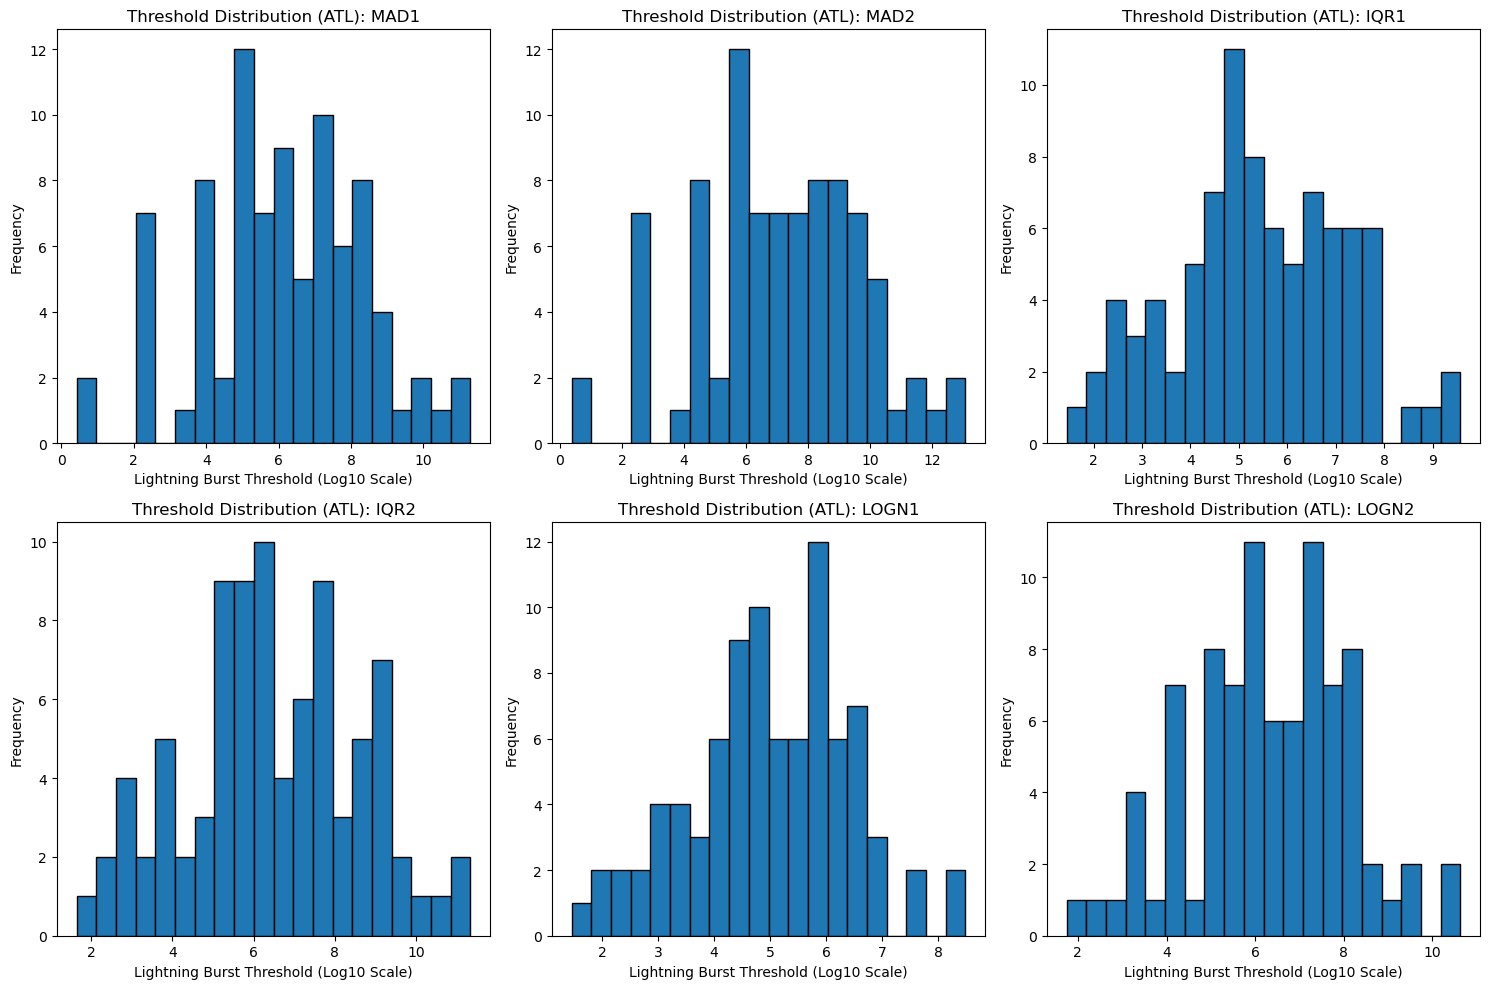

In [83]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_tc_summary, threshold, ax=axes[i])
    axes[i].set_title(f"Threshold Distribution (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

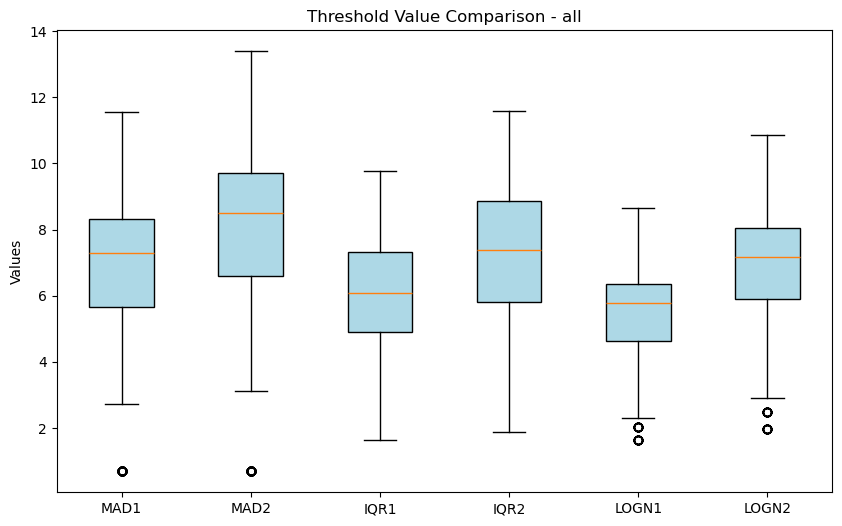

In [84]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(atl_bursts, "all", ax=None)

Create a summary for the weaker categories and create an initial basin-category threshold defined as 2 standard deviations + the mean or median.

In [273]:
# Group the data into weak and strong category datasets using function
atl_weak0_lightning, atl_weak1_lightning, atl_strong_lightning = group_bins_category(atl_bursts)

7879 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
2969 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
1564 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


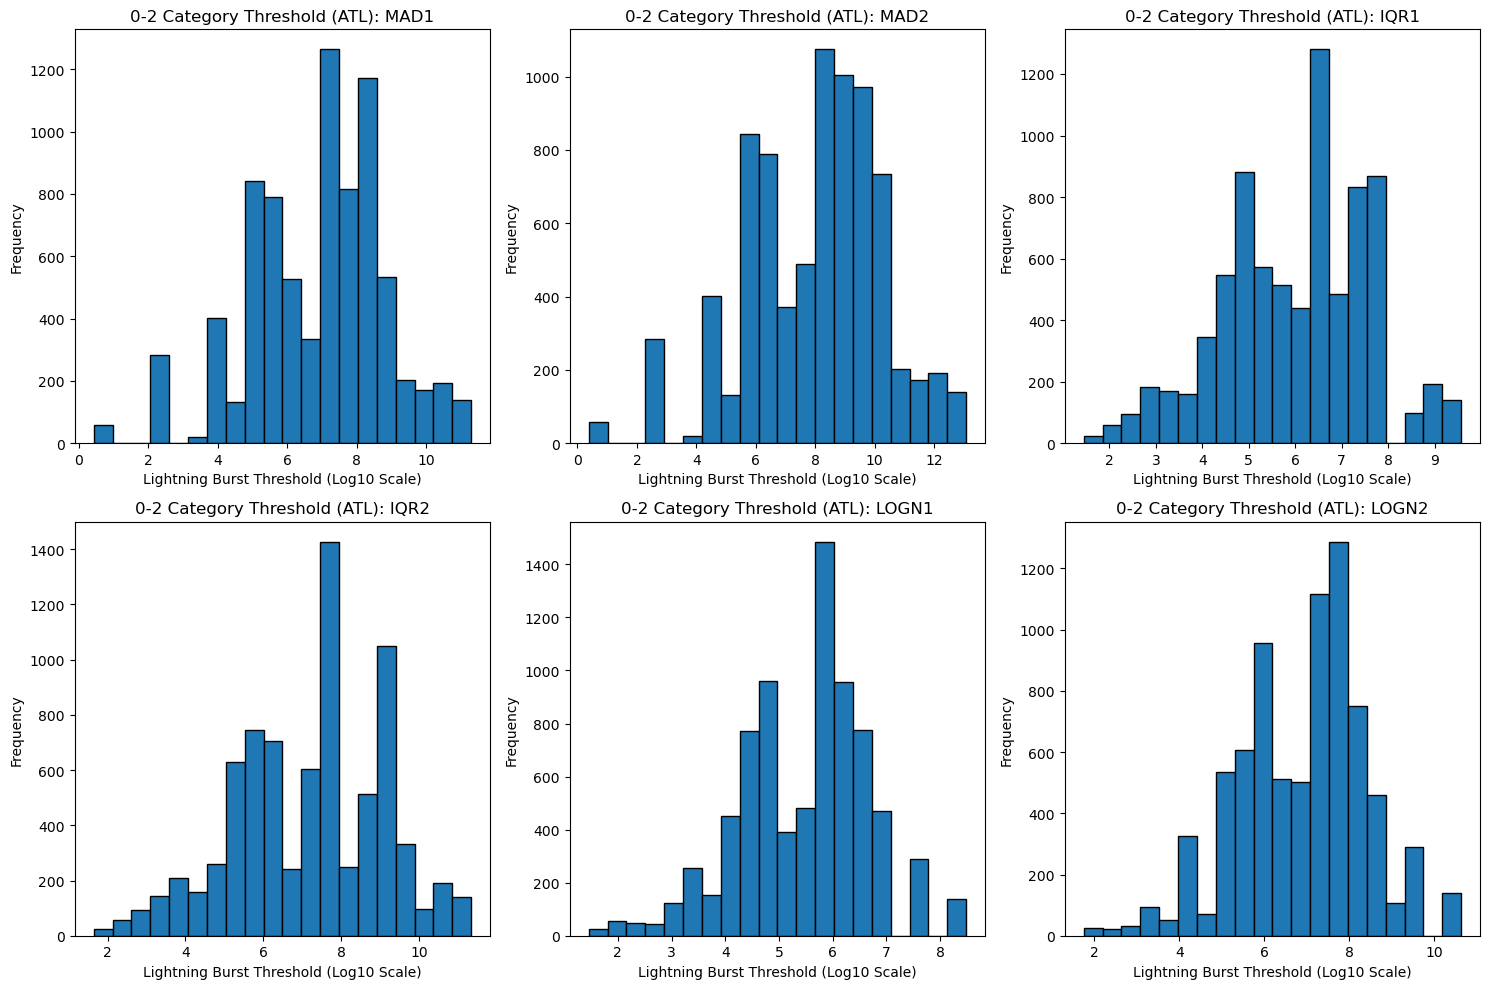

In [86]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_weak0_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Threshold (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

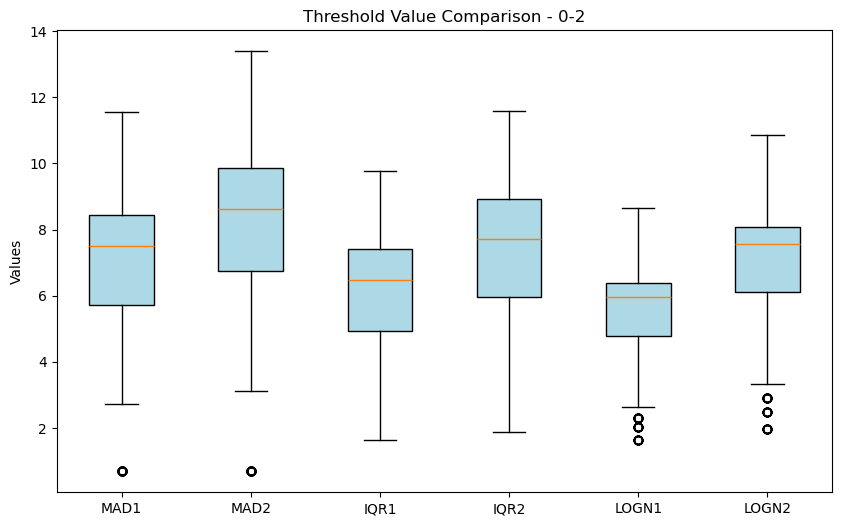

In [87]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(atl_weak0_lightning, "0-2", ax=None)

In [274]:
# Create basin summary for 0-2 category group
atl_weak0_summary = create_basin_summary(atl_weak0_lightning, "0-2", "ATL")
atl_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            0-2      mad1  7.120985  1.970386  7.501090  0.693147   
1   ATL            0-2      mad2  8.286976  2.294624  8.626454  0.693147   
2   ATL            0-2      iqr1  6.206470  1.602419  6.490420  1.647918   
3   ATL            0-2      iqr2  7.424062  1.933749  7.710666  1.886611   
4   ATL            0-2     logn1  5.636795  1.213463  5.963810  1.630575   
5   ATL            0-2     logn2  7.130890  1.523054  7.572206  1.969559   

         Max  Burst Count  Timebin Count  Burst Percentage  
0  11.566724          111           7879              1.41  
1  13.390425           58           7879              0.74  
2   9.774169          159           7879              2.02  
3  11.581476           41           7879              0.52  
4   8.659291          230           7879              2.92  
5  10.852508           11           7879              0.14

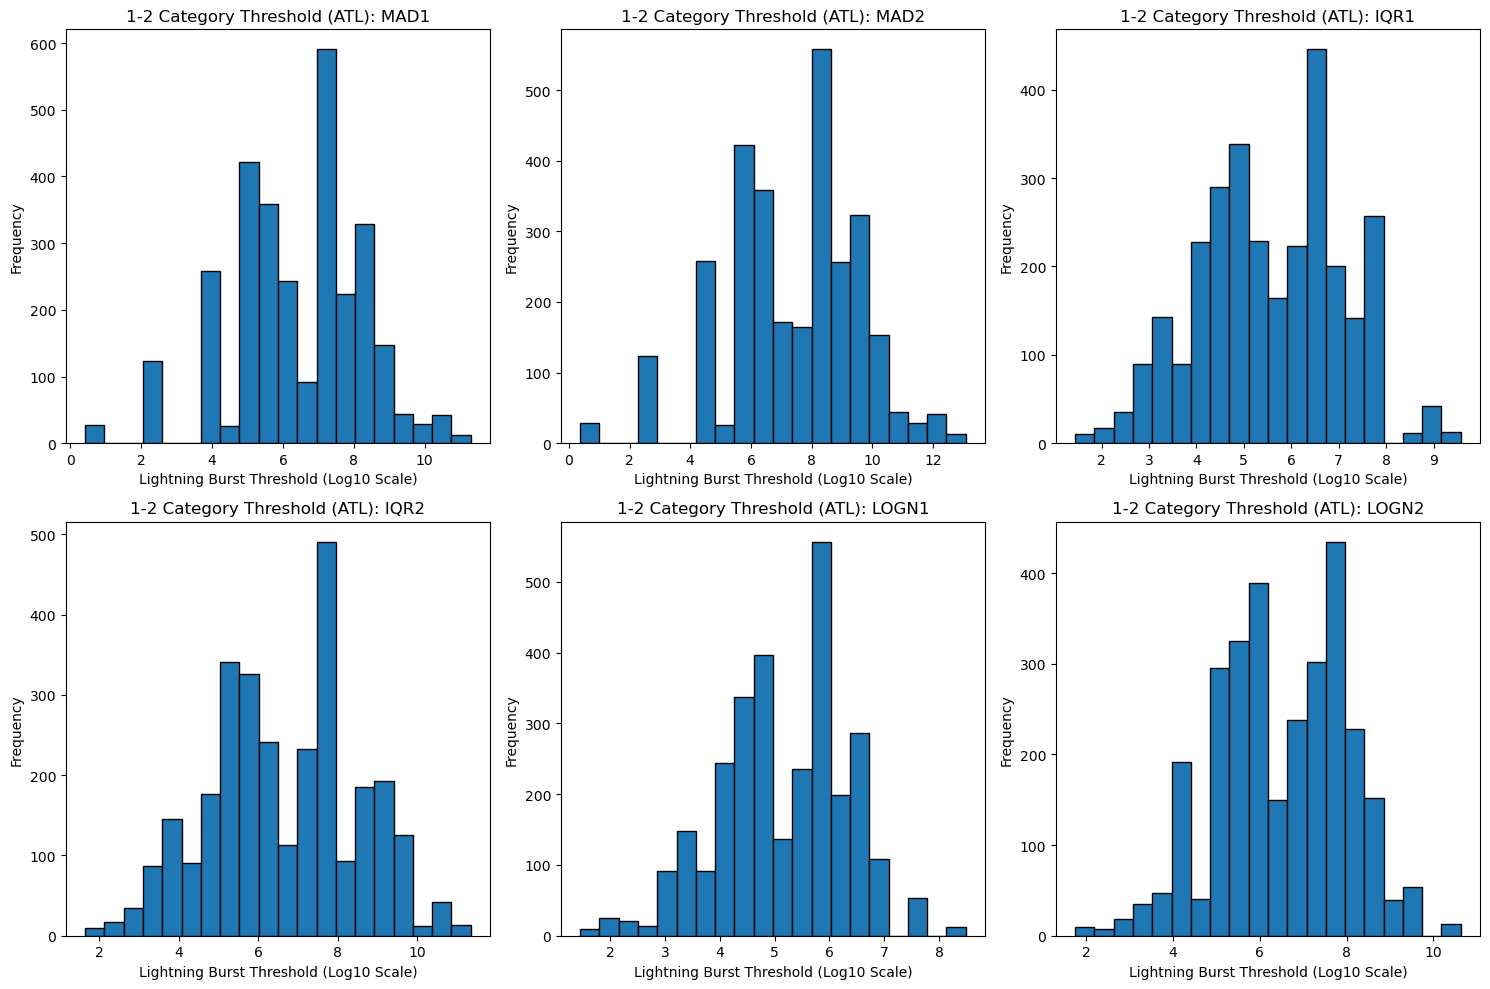

In [89]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_weak1_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Threshold (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

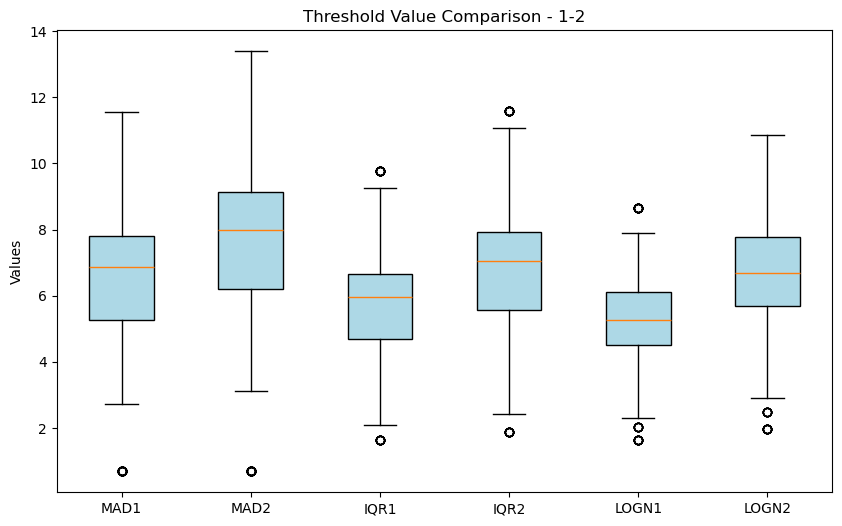

In [90]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(atl_weak1_lightning, "1-2", ax=None)

In [275]:
# Create basin summary for 1-2 category group
atl_weak1_summary = create_basin_summary(atl_weak1_lightning, "1-2", "ATL")
atl_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            1-2      mad1  6.624039  1.856517  6.879356  0.693147   
1   ATL            1-2      mad2  7.704062  2.163945  7.977968  0.693147   
2   ATL            1-2      iqr1  5.762948  1.543927  5.958941  1.647918   
3   ATL            1-2      iqr2  6.883465  1.867008  7.046317  1.886611   
4   ATL            1-2     logn1  5.324509  1.182646  5.278519  1.630575   
5   ATL            1-2     logn2  6.733456  1.492587  6.685786  1.969559   

         Max  Burst Count  Timebin Count  Burst Percentage  
0  11.566724           39           2969              1.31  
1  13.390425           24           2969              0.81  
2   9.774169           59           2969              1.99  
3  11.581476           15           2969              0.51  
4   8.659291           82           2969              2.76  
5  10.852508            5           2969              0.17

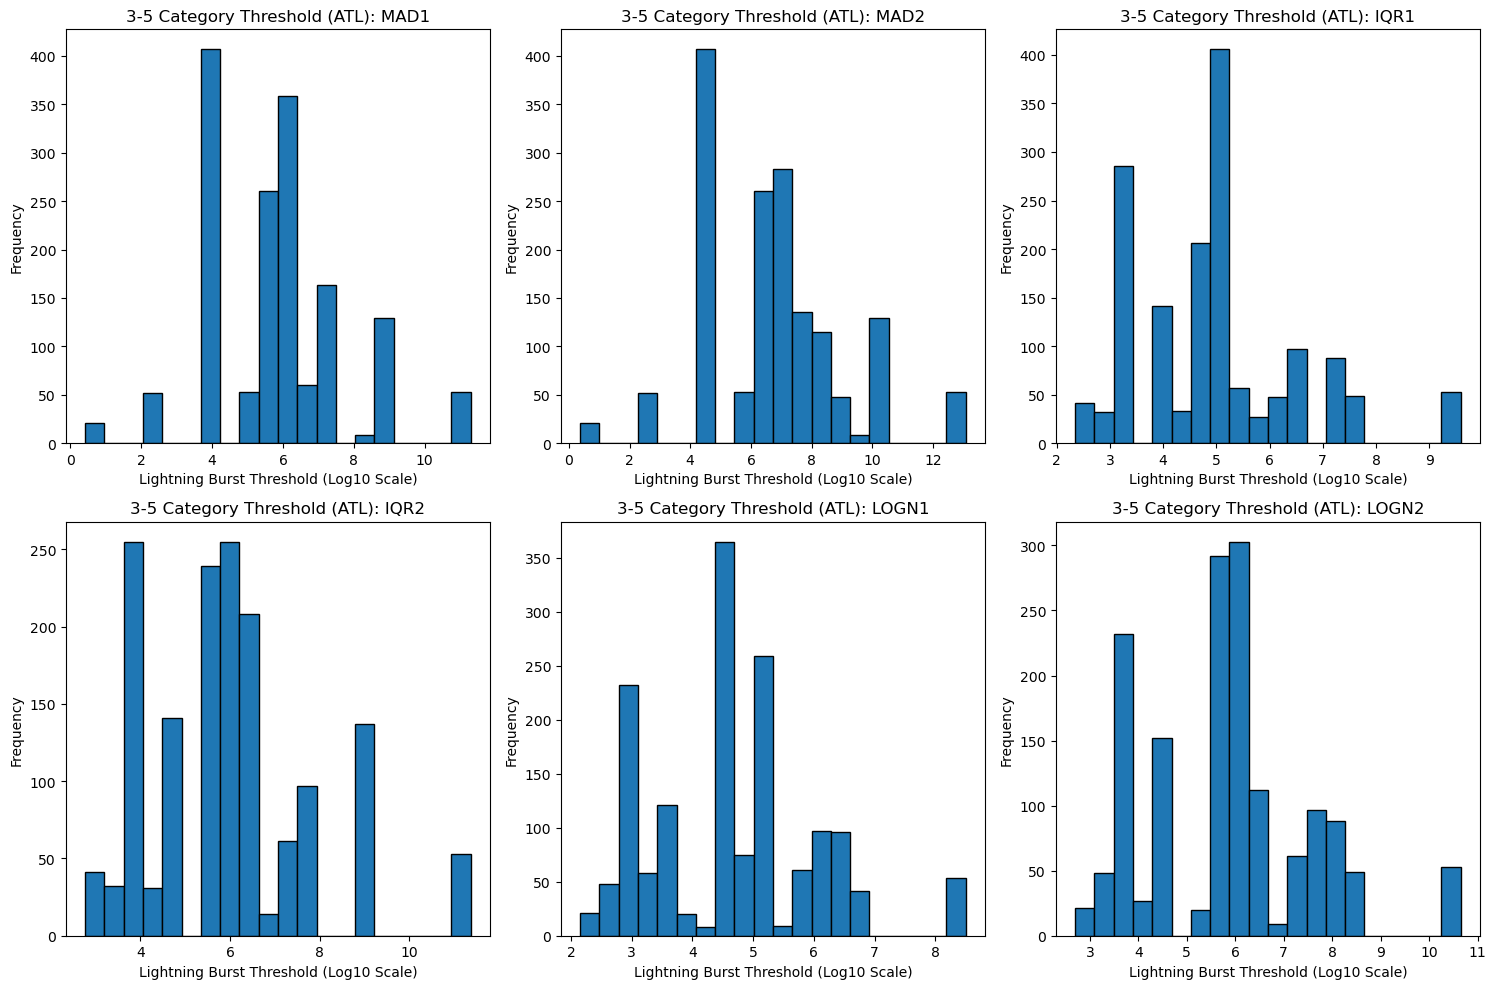

In [92]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_strong_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Threshold (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

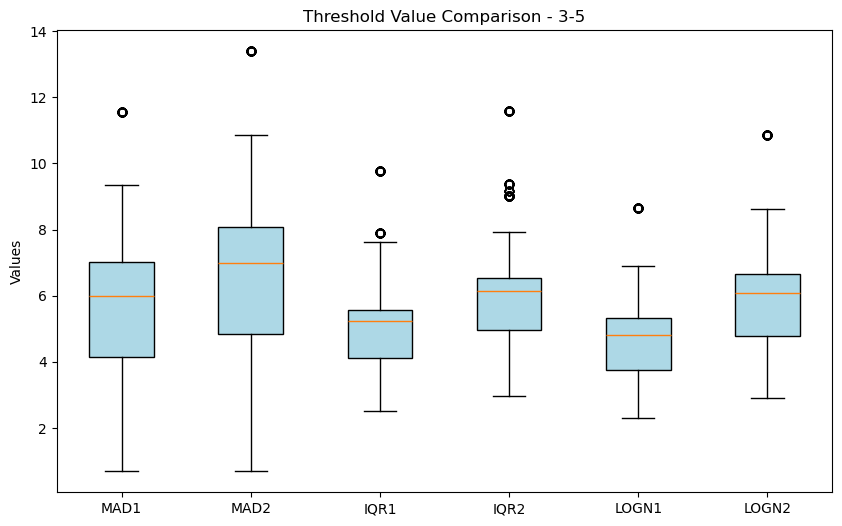

In [93]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(atl_strong_lightning, "3-5", ax=None)

In [276]:
# Create basin summary for 3-5 category group
atl_strong_summary = create_basin_summary(atl_strong_lightning, "3-5", "ATL")
atl_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            3-5      mad1  5.999954  1.946103  6.002759  0.693147   
1   ATL            3-5      mad2  6.954435  2.255699  6.983588  0.693147   
2   ATL            3-5      iqr1  5.167132  1.561338  5.225747  2.525729   
3   ATL            3-5      iqr2  6.144545  1.851532  6.129824  2.983874   
4   ATL            3-5     logn1  4.807281  1.347597  4.814249  2.310380   
5   ATL            3-5     logn2  6.041351  1.693730  6.073002  2.894751   

         Max  Burst Count  Timebin Count  Burst Percentage  
0  11.566724           13           1564              0.83  
1  13.390425            9           1564              0.58  
2   9.774169           13           1564              0.83  
3  11.581476            2           1564              0.13  
4   8.659291           22           1564              1.41  
5  10.852508            2           1564              0.13

Let's go ahead and filter the thresholds to just the "effective" thresholds and use these to calculate the basin-category threshold.

In [95]:
# Effective thresholds - ATL basin
atl_bursts_effective = filter_effective_thresholds(atl_bursts)
atl_storm_codes_effective = atl_bursts_effective["storm_code"].unique()
atl_tc_summary_effective = atl_tc_summary[atl_tc_summary["storm_code"].isin(atl_storm_codes_effective)]

atl_bursts_effective.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
6  2010-06-26 16:00:00   ATL_10_1               37  2010      6   26    16   
10 2010-06-26 18:30:00   ATL_10_1               56  2010      6   26    18   
11 2010-06-26 19:00:00   ATL_10_1               60  2010      6   26    19   
34 2010-06-29 16:00:00   ATL_10_1               17  2010      6   29    16   
41 2010-09-08 09:30:00  ATL_10_11                4  2010      9    8     9   

    minute   lat   lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
6        0  17.2 -87.3  ...        3.265439        3.908512       True   
10      30  17.2 -87.3  ...        3.265439        3.908512       True   
11       0  17.2 -87.3  ...        3.265439        3.908512       True   
34       0  22.9 -93.6  ...        3.265439             NaN       True   
41      30  13.8 -23.3  ...        2.525729        2.983874       True   

    burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
6         True       2.720473             NaN         True        False   
10        True       2.720473        3.125938         True        False   
11        True       2.720473        3.125938         True        False   
34       False            NaN             NaN        False        False   
41        True            NaN             NaN        False        False   

   logn1_threshold logn2_threshold  
6         3.469047             NaN  
10        3.469047             NaN  
11        3.469047             NaN  
34             NaN             NaN  
41             NaN             NaN  

[5 rows x 34 columns]

In [277]:
print(f"{len(atl_storm_codes_effective)} TCs of {len(atl_storm_codes)} ATL TCs after filtering for bursts of any type")

68 TCs of 84 ATL TCs after filtering for bursts of any type


In [97]:
atl_effective_summary = create_basin_summary(atl_bursts_effective, "all", "ATL")
atl_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            all      mad1  5.003362  1.475039  5.274601  2.720473   
1   ATL            all      mad2  4.806135  1.416886  4.852030  3.125938   
2   ATL            all      iqr1  3.784668  1.645467  3.121598  1.647918   
3   ATL            all      iqr2  3.703720  1.763110  2.983874  1.886611   
4   ATL            all     logn1  4.973278  1.153221  4.887570  2.031772   
5   ATL            all     logn2  5.158199  1.081248  5.227062  3.670688   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  7.650109          124            328             37.80  
1  6.944217           67            328             20.43  
2  7.836646          172            328             52.44  
3  9.145802           43            328             13.11  
4  7.225276          252            328             76.83  
5  7.602352           13            328              3.96

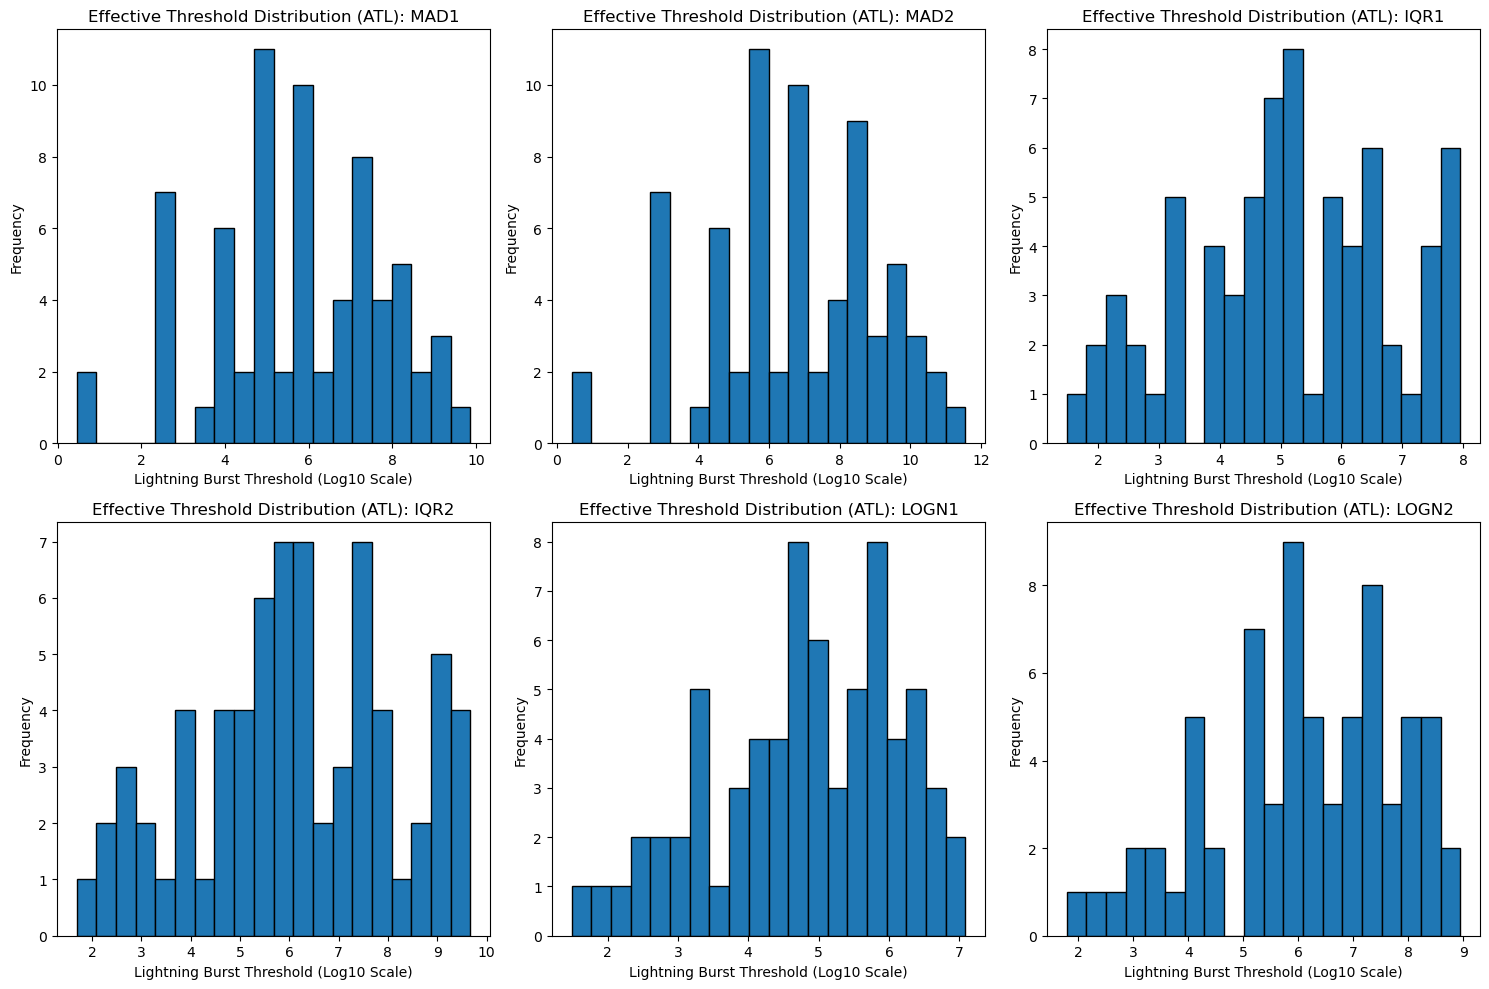

In [98]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_tc_summary_effective, threshold, ax=axes[i])
    axes[i].set_title(f"Effective Threshold Distribution (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [278]:
# Group the data into weak and strong category datasets using function
atl_weak0_effective_lightning, atl_weak1_effective_lightning, atl_strong_effective_lightning = group_bins_category(atl_bursts_effective)

296 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
107 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
32 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


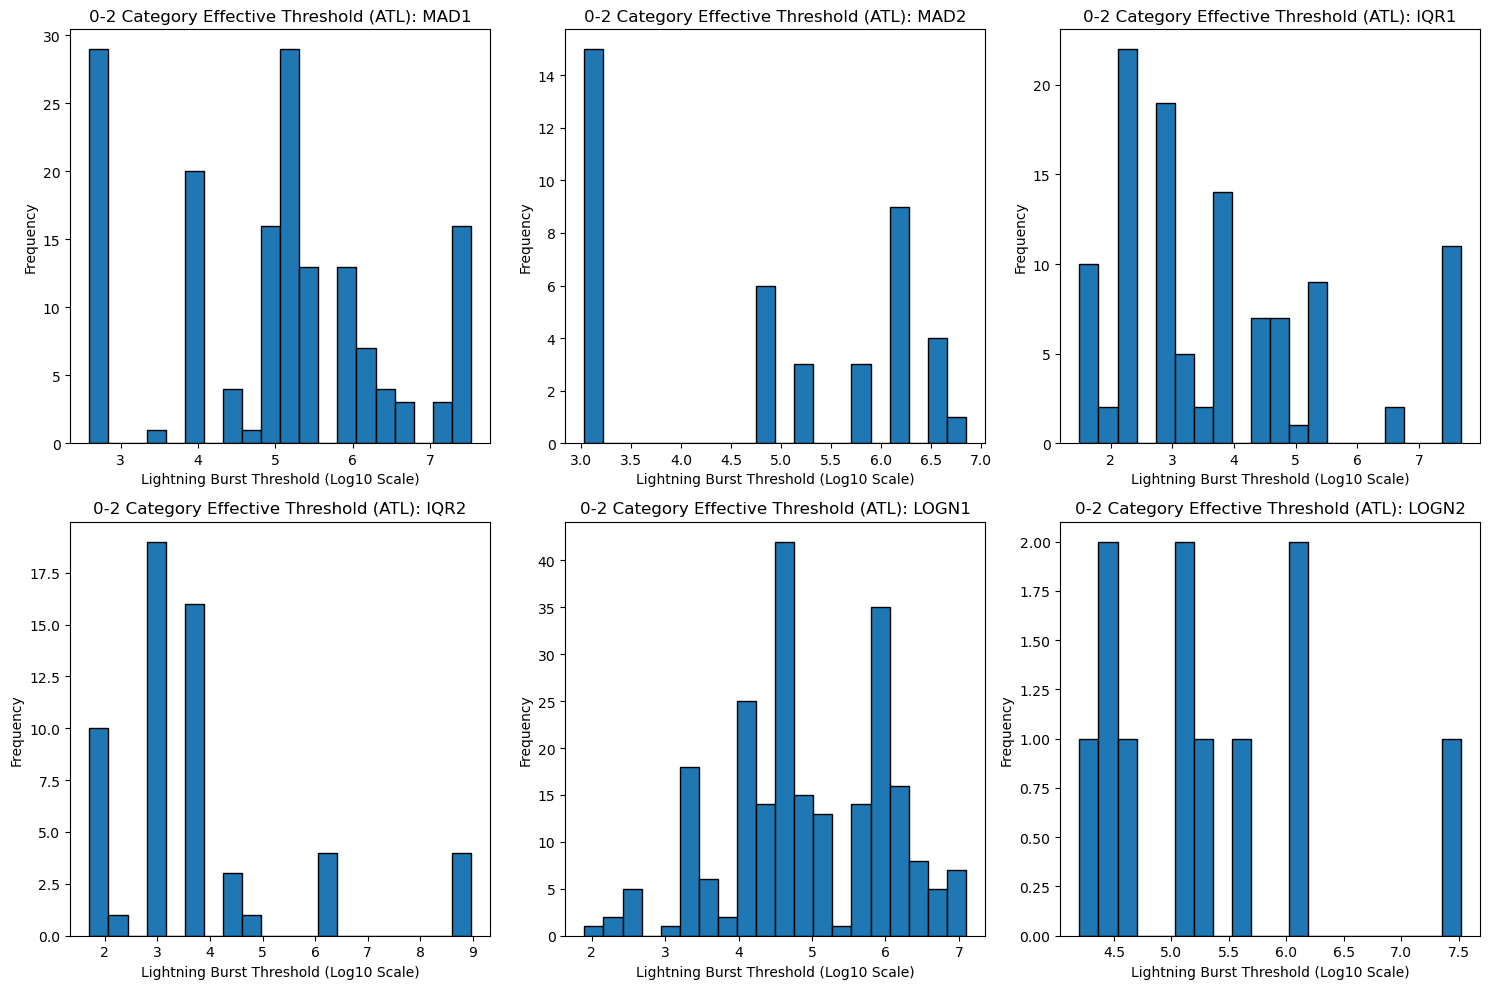

In [100]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_weak0_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Effective Threshold (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [101]:
# Get summary for effective thresholds - 0-2 categories
atl_weak0_effective_summary = create_basin_summary(atl_weak0_effective_lightning, "0-2", "ATL")
atl_weak0_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            0-2      mad1  5.095552  1.472615  5.274601  2.720473   
1   ATL            0-2      mad2  4.845996  1.426774  4.852030  3.125938   
2   ATL            0-2      iqr1  3.905736  1.696309  3.265439  1.647918   
3   ATL            0-2      iqr2  3.799703  1.877212  2.983874  1.886611   
4   ATL            0-2     logn1  5.077704  1.094783  4.887570  2.031772   
5   ATL            0-2     logn2  5.410130  0.973159  5.227062  4.282368   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  7.650109          111            296             37.50  
1  6.944217           58            296             19.59  
2  7.836646          159            296             53.72  
3  9.145802           41            296             13.85  
4  7.225276          230            296             77.70  
5  7.602352           11            296              3.72

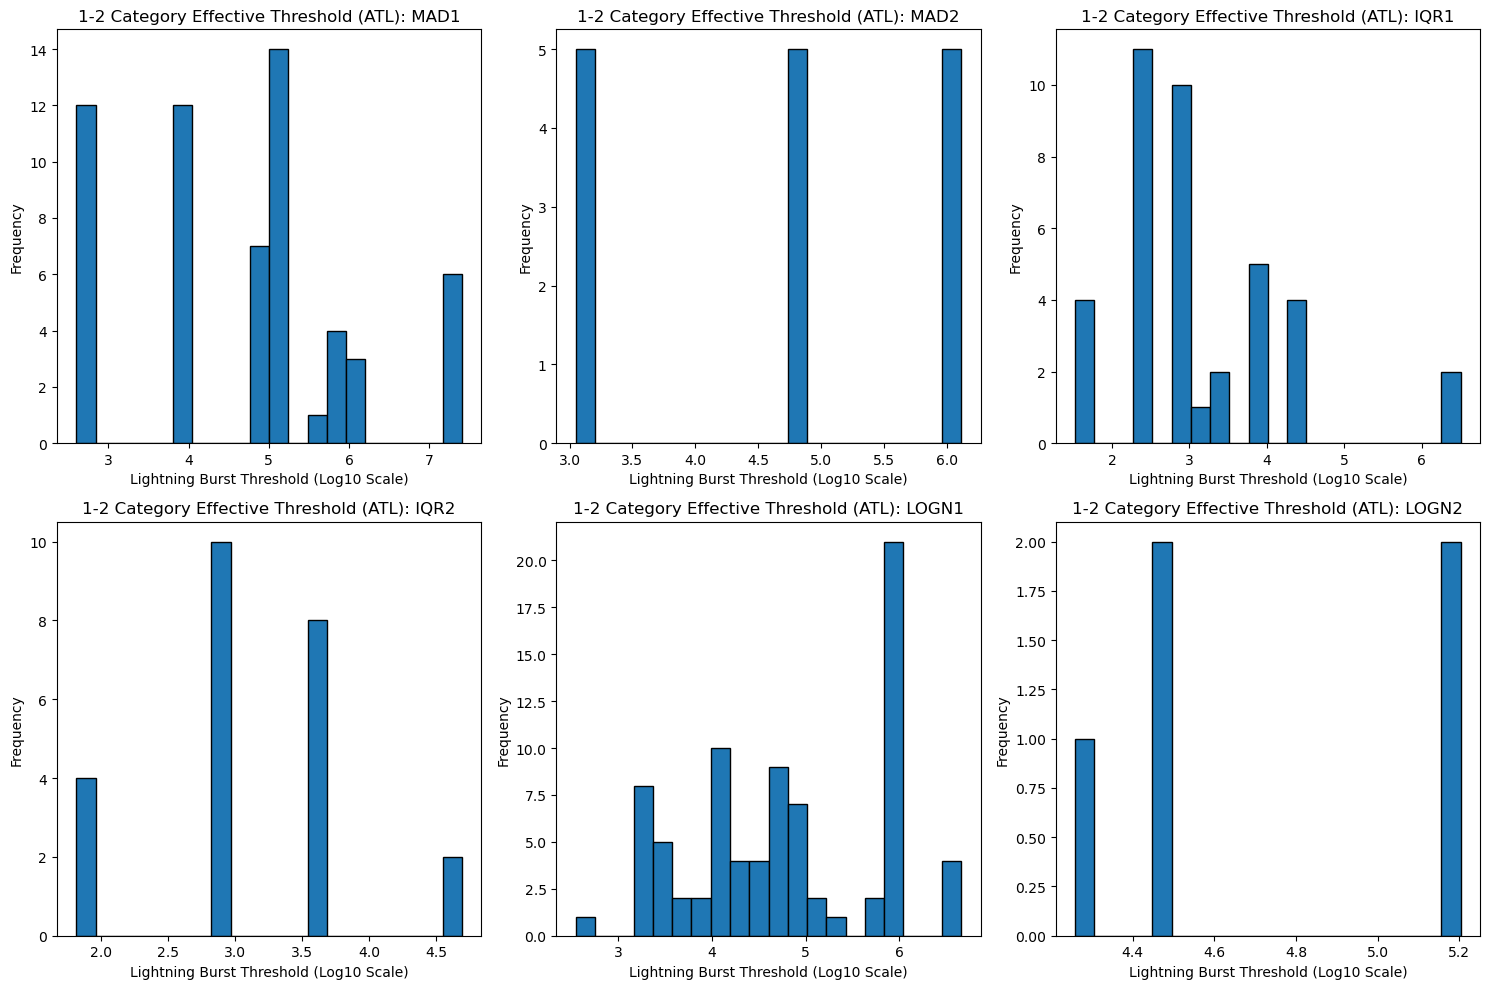

In [102]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_weak1_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Effective Threshold (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [103]:
# Get summary for effective thresholds - 1-2 categories
atl_weak1_effective_summary = create_basin_summary(atl_weak1_effective_lightning, "1-2", "ATL")
atl_weak1_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            1-2      mad1  4.832623  1.403405  5.111313  2.720473   
1   ATL            1-2      mad2  4.721255  1.296567  4.852030  3.125938   
2   ATL            1-2      iqr1  3.269912  1.130205  3.121598  1.647918   
3   ATL            1-2      iqr2  3.197657  0.793951  2.983874  1.886611   
4   ATL            1-2     logn1  4.900668  1.034308  4.887570  2.648261   
5   ATL            1-2     logn2  4.749365  0.445461  4.505166  4.282368   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  7.528262           39            107             36.45  
1  6.190892           24            107             22.43  
2  6.628041           59            107             55.14  
3  4.764455           15            107             14.02  
4  6.764857           82            107             76.64  
5  5.227062            5            107              4.67

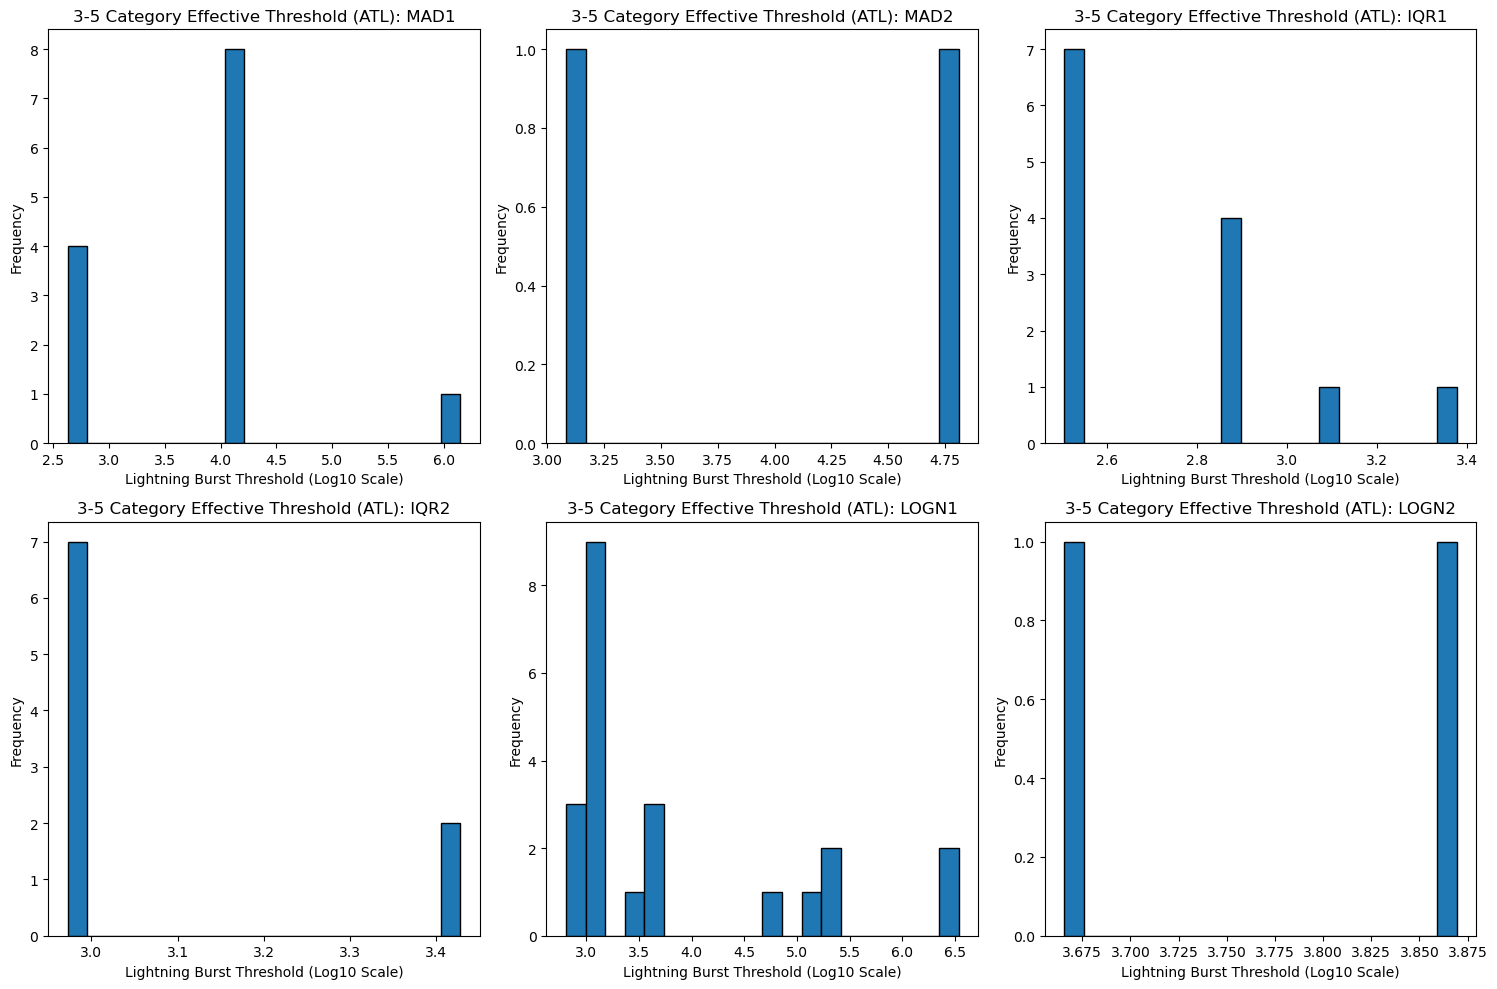

In [104]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(atl_strong_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Effective Threshold (ATL): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [105]:
# Get summary for effective thresholds - 3-5 categories
atl_strong_effective_summary = create_basin_summary(atl_strong_effective_lightning, "3-5", "ATL")
atl_strong_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            3-5      mad1  3.875810  0.980417  4.158883  2.720473   
1   ATL            3-5      mad2  3.988984  1.220532  3.988984  3.125938   
2   ATL            3-5      iqr1  2.750935  0.287248  2.525729  2.525729   
3   ATL            3-5      iqr2  3.085164  0.200991  2.983874  2.983874   
4   ATL            3-5     logn1  3.881556  1.207372  3.097071  2.900007   
5   ATL            3-5     logn2  3.772581  0.144099  3.772581  3.670688   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  6.232578           13             32             40.62  
1  4.852030            9             32             28.12  
2  3.398970           13             32             40.62  
3  3.439678            2             32              6.25  
4  6.626616           22             32             68.75  
5  3.874475            2             32              6.25

Let's calculate and apply the basin-level effective threshold. We'll try both 1.5 SD and 2 SD from the mean and median of the effective thresholds for each category group.

Start with the 0-2 category grouping.

In [106]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
atl_weak0_effective_thresholds = calculate_basin_thresholds(atl_weak0_effective_lightning, "0-2", "ATL", threshold_type="effective")
atl_weak0_effective_thresholds_1_5sd = calculate_basin_thresholds(atl_weak0_effective_lightning, "0-2", "ATL", std_dev=1.5, threshold_type="effective")

In [107]:
# 0-2 categories, 2 SD
atl_weak0_summary_2sd, atl_weak0_eff_bursts_mean, atl_weak0_eff_summary_mean, atl_weak0_eff_bursts_median, atl_weak0_eff_summary_median = summarize_threshold_eval(atl_weak0_summary, atl_weak0_lightning, atl_weak0_effective_thresholds, threshold_type="effective")
atl_weak0_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            0-2      mad1  7.120985  1.970386  7.501090  0.693147   
1   ATL            0-2      mad2  8.286976  2.294624  8.626454  0.693147   
2   ATL            0-2      iqr1  6.206470  1.602419  6.490420  1.647918   
3   ATL            0-2      iqr2  7.424062  1.933749  7.710666  1.886611   
4   ATL            0-2     logn1  5.636795  1.213463  5.963810  1.630575   
5   ATL            0-2     logn2  7.130890  1.523054  7.572206  1.969559   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  11.566724          111           7879              1.41   
1  13.390425           58           7879              0.74   
2   9.774169          159           7879              2.02   
3  11.581476           41           7879              0.52   
4   8.659291          230           7879              2.92   
5  10.852508           11           7879              0.14   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           8.040781      
1                                           7.699545      
2                                           7.298354      
3                                           7.554127      
4                                           7.267269      
5                                           7.356447      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           8.219830        
1                                           7.705579        
2                                           6.658057        
3                                           6.738298        
4                                           7.077135        
5                                           7.173379        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  2             
1                                                  8             
2                                                 22             
3                                                 11             
4                                                 23             
5                                                 17             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.03                       
1                                               0.10                       
2                                               0.28                       
3                                               0.14                       
4                                               0.29                       
5                                               0.22                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  1               
1                                                  8               
2                                                102               
3                                                 89               
4                                                 44               
5                                                 33               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.01                        
1                                               0.10                        
2                                               1.29                        
3                                               1.13                        
4                                               0.56                        
5                                               0.42

In [108]:
# 0-2 categories, 1.5 SD
atl_weak0_summary_1_5sd, atl_weak0_eff_bursts_mean_1_5, atl_weak0_eff_summary_mean_1_5, atl_weak0_eff_bursts_median_1_5, atl_weak0_eff_summary_median_1_5 = summarize_threshold_eval(atl_weak0_summary, atl_weak0_lightning, atl_weak0_effective_thresholds_1_5sd, threshold_type="effective")
atl_weak0_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            0-2      mad1  7.120985  1.970386  7.501090  0.693147   
1   ATL            0-2      mad2  8.286976  2.294624  8.626454  0.693147   
2   ATL            0-2      iqr1  6.206470  1.602419  6.490420  1.647918   
3   ATL            0-2      iqr2  7.424062  1.933749  7.710666  1.886611   
4   ATL            0-2     logn1  5.636795  1.213463  5.963810  1.630575   
5   ATL            0-2     logn2  7.130890  1.523054  7.572206  1.969559   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  11.566724          111           7879              1.41   
1  13.390425           58           7879              0.74   
2   9.774169          159           7879              2.02   
3  11.581476           41           7879              0.52   
4   8.659291          230           7879              2.92   
5  10.852508           11           7879              0.14   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           7.304474        
1                                           6.986158        
2                                           6.450200        
3                                           6.615521        
4                                           6.719878        
5                                           6.869868        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           7.483523          
1                                           6.992192          
2                                           5.809902          
3                                           5.799692          
4                                           6.529744          
5                                           6.686800          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 21               
1                                                 63               
2                                                150               
3                                                109               
4                                                 91               
5                                                 72               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.27                         
1                                               0.80                         
2                                               1.90                         
3                                               1.38                         
4                                               1.15                         
5                                               0.91                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                 14                 
1                                                 61                 
2                                                360                 
3                                                363                 
4                                                131                 
5                                                 98                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               0.18                          
1                                               0.77                          
2                                               4.57                          
3                                               4.61                          
4                                               1.66                          
5                                               1.24

In [109]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = atl_weak0_summary_1_5sd.columns[-6: ].to_list()
keep.append(atl_weak0_summary_1_5sd.columns[2])
atl_weak0_summary = pd.merge(atl_weak0_summary_2sd, atl_weak0_summary_1_5sd[keep], on="Threshold")
atl_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            0-2      mad1  7.120985  1.970386  7.501090  0.693147   
1   ATL            0-2      mad2  8.286976  2.294624  8.626454  0.693147   
2   ATL            0-2      iqr1  6.206470  1.602419  6.490420  1.647918   
3   ATL            0-2      iqr2  7.424062  1.933749  7.710666  1.886611   
4   ATL            0-2     logn1  5.636795  1.213463  5.963810  1.630575   
5   ATL            0-2     logn2  7.130890  1.523054  7.572206  1.969559   

         Max  Burst Count  Timebin Count  ...  \
0  11.566724          111           7879  ...   
1  13.390425           58           7879  ...   
2   9.774169          159           7879  ...   
3  11.581476           41           7879  ...   
4   8.659291          230           7879  ...   
5  10.852508           11           7879  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  2             
1                                                  8             
2                                                 22             
3                                                 11             
4                                                 23             
5                                                 17             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.03                       
1                                               0.10                       
2                                               0.28                       
3                                               0.14                       
4                                               0.29                       
5                                               0.22                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  1               
1                                                  8               
2                                                102               
3                                                 89               
4                                                 44               
5                                                 33               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.01                         
1                                               0.10                         
2                                               1.29                         
3                                               1.13                         
4                                               0.56                         
5                                               0.42                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           7.304474        
1                                           6.986158        
2                                           6.450200        
3                                           6.615521        
4                                           6.719878        
5                                           6.869868        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           7.483523          
1                                           6.992192          
2                                           5.809902          
3                                           5.799692          
4                                           6.529744          
5                                           6.686800          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 21               
1                                                 63               
2                              

Let's do the same for the other 2 category groupings.

1-2 categories:

In [110]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
atl_weak1_effective_thresholds = calculate_basin_thresholds(atl_weak1_effective_lightning, "1-2", "ATL", threshold_type="effective")
atl_weak1_effective_thresholds_1_5sd = calculate_basin_thresholds(atl_weak1_effective_lightning, "1-2", "ATL", std_dev=1.5, threshold_type="effective")

In [111]:
# 1-2 categories, 2 SD
atl_weak1_summary_2sd, atl_weak1_eff_bursts_mean, atl_weak1_eff_summary_mean, atl_weak1_eff_bursts_median, atl_weak1_eff_summary_median = summarize_threshold_eval(atl_weak1_summary, atl_weak1_lightning, atl_weak1_effective_thresholds, threshold_type="effective")
atl_weak1_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            1-2      mad1  6.624039  1.856517  6.879356  0.693147   
1   ATL            1-2      mad2  7.704062  2.163945  7.977968  0.693147   
2   ATL            1-2      iqr1  5.762948  1.543927  5.958941  1.647918   
3   ATL            1-2      iqr2  6.883465  1.867008  7.046317  1.886611   
4   ATL            1-2     logn1  5.324509  1.182646  5.278519  1.630575   
5   ATL            1-2     logn2  6.733456  1.492587  6.685786  1.969559   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  11.566724           39           2969              1.31   
1  13.390425           24           2969              0.81   
2   9.774169           59           2969              1.99   
3  11.581476           15           2969              0.51   
4   8.659291           82           2969              2.76   
5  10.852508            5           2969              0.17   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           7.639433      
1                                           7.314388      
2                                           5.530323      
3                                           4.785560      
4                                           6.969285      
5                                           5.640286      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           7.918123        
1                                           7.445163        
2                                           5.382009        
3                                           4.571777        
4                                           6.956186        
5                                           5.396088        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  3             
2                                                 75             
3                                                204             
4                                                 10             
5                                                 63             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.10                       
2                                               2.53                       
3                                               6.87                       
4                                               0.34                       
5                                               2.12                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                  1               
2                                                 92               
3                                                253               
4                                                 10               
5                                                 92               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.00                        
1                                               0.03                        
2                                               3.10                        
3                                               8.52                        
4                                               0.34                        
5                                               3.10

In [112]:
# 1-2 categories, 1.5 SD
atl_weak1_summary_1_5sd, atl_weak1_eff_bursts_mean_1_5, atl_weak1_eff_summary_mean_1_5, atl_weak1_eff_bursts_median_1_5, atl_weak1_eff_summary_median_1_5 = summarize_threshold_eval(atl_weak1_summary, atl_weak1_lightning, atl_weak1_effective_thresholds_1_5sd, threshold_type="effective")
atl_weak1_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            1-2      mad1  6.624039  1.856517  6.879356  0.693147   
1   ATL            1-2      mad2  7.704062  2.163945  7.977968  0.693147   
2   ATL            1-2      iqr1  5.762948  1.543927  5.958941  1.647918   
3   ATL            1-2      iqr2  6.883465  1.867008  7.046317  1.886611   
4   ATL            1-2     logn1  5.324509  1.182646  5.278519  1.630575   
5   ATL            1-2     logn2  6.733456  1.492587  6.685786  1.969559   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  11.566724           39           2969              1.31   
1  13.390425           24           2969              0.81   
2   9.774169           59           2969              1.99   
3  11.581476           15           2969              0.51   
4   8.659291           82           2969              2.76   
5  10.852508            5           2969              0.17   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.937731        
1                                           6.666105        
2                                           4.965220        
3                                           4.388584        
4                                           6.452130        
5                                           5.417556        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           7.216420          
1                                           6.796880          
2                                           4.816906          
3                                           4.174801          
4                                           6.439032          
5                                           5.173357          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 10               
1                                                 15               
2                                                165               
3                                                303               
4                                                 20               
5                                                 90               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.34                         
1                                               0.51                         
2                                               5.56                         
3                                              10.21                         
4                                               0.67                         
5                                               3.03                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                  5                 
1                                                 13                 
2                                                194                 
3                                                367                 
4                                                 20                 
5                                                120                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               0.17                          
1                                               0.44                          
2                                               6.53                          
3                                              12.36                          
4                                               0.67                          
5                                               4.04

In [113]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = atl_weak1_summary_1_5sd.columns[-6: ].to_list()
keep.append(atl_weak1_summary_1_5sd.columns[2])
atl_weak1_summary = pd.merge(atl_weak1_summary_2sd, atl_weak1_summary_1_5sd[keep], on="Threshold")
atl_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            1-2      mad1  6.624039  1.856517  6.879356  0.693147   
1   ATL            1-2      mad2  7.704062  2.163945  7.977968  0.693147   
2   ATL            1-2      iqr1  5.762948  1.543927  5.958941  1.647918   
3   ATL            1-2      iqr2  6.883465  1.867008  7.046317  1.886611   
4   ATL            1-2     logn1  5.324509  1.182646  5.278519  1.630575   
5   ATL            1-2     logn2  6.733456  1.492587  6.685786  1.969559   

         Max  Burst Count  Timebin Count  ...  \
0  11.566724           39           2969  ...   
1  13.390425           24           2969  ...   
2   9.774169           59           2969  ...   
3  11.581476           15           2969  ...   
4   8.659291           82           2969  ...   
5  10.852508            5           2969  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  3             
2                                                 75             
3                                                204             
4                                                 10             
5                                                 63             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.10                       
2                                               2.53                       
3                                               6.87                       
4                                               0.34                       
5                                               2.12                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                  1               
2                                                 92               
3                                                253               
4                                                 10               
5                                                 92               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.00                         
1                                               0.03                         
2                                               3.10                         
3                                               8.52                         
4                                               0.34                         
5                                               3.10                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.937731        
1                                           6.666105        
2                                           4.965220        
3                                           4.388584        
4                                           6.452130        
5                                           5.417556        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           7.216420          
1                                           6.796880          
2                                           4.816906          
3                                           4.174801          
4                                           6.439032          
5                                           5.173357          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 10               
1                                                 15               
2                              

Next, we do the same for the stronger category group, 3-5.

In [114]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
atl_strong_effective_thresholds = calculate_basin_thresholds(atl_strong_effective_lightning, "3-5", "ATL", threshold_type="effective")
atl_strong_effective_thresholds_1_5sd = calculate_basin_thresholds(atl_strong_effective_lightning, "3-5", "ATL", std_dev=1.5, threshold_type="effective")

In [115]:
# 3-5 categories, 2 SD
atl_strong_summary_2sd, atl_strong_eff_bursts_mean, atl_strong_eff_summary_mean, atl_strong_eff_bursts_median, atl_strong_eff_summary_median = summarize_threshold_eval(atl_strong_summary, atl_strong_lightning, atl_strong_effective_thresholds, threshold_type="effective")
atl_strong_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            3-5      mad1  5.999954  1.946103  6.002759  0.693147   
1   ATL            3-5      mad2  6.954435  2.255699  6.983588  0.693147   
2   ATL            3-5      iqr1  5.167132  1.561338  5.225747  2.525729   
3   ATL            3-5      iqr2  6.144545  1.851532  6.129824  2.983874   
4   ATL            3-5     logn1  4.807281  1.347597  4.814249  2.310380   
5   ATL            3-5     logn2  6.041351  1.693730  6.073002  2.894751   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  11.566724           13           1564              0.83   
1  13.390425            9           1564              0.58   
2   9.774169           13           1564              0.83   
3  11.581476            2           1564              0.13   
4   8.659291           22           1564              1.41   
5  10.852508            2           1564              0.13   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           5.836645      
1                                           6.430047      
2                                           3.325431      
3                                           3.487145      
4                                           6.296301      
5                                           4.060780      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           6.119718        
1                                           6.430047        
2                                           3.100224        
3                                           3.385855        
4                                           5.511816        
5                                           4.060780        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                 11             
1                                                  2             
2                                                264             
3                                                230             
4                                                  3             
5                                                132             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.70                       
1                                               0.13                       
2                                              16.88                       
3                                              14.71                       
4                                               0.19                       
5                                               8.44                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  4               
1                                                  2               
2                                                308               
3                                                250               
4                                                 20               
5                                                132               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.26                        
1                                               0.13                        
2                                              19.69                        
3                                              15.98                        
4                                               1.28                        
5                                               8.44

In [116]:
# 3-5 categories, 1.5 SD
atl_strong_summary_1_5sd, atl_strong_eff_bursts_mean_1_5, atl_strong_eff_summary_mean_1_5, atl_strong_eff_bursts_median_1_5, atl_strong_eff_summary_median_1_5 = summarize_threshold_eval(atl_strong_summary, atl_strong_lightning, atl_strong_effective_thresholds_1_5sd, threshold_type="effective")
atl_strong_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            3-5      mad1  5.999954  1.946103  6.002759  0.693147   
1   ATL            3-5      mad2  6.954435  2.255699  6.983588  0.693147   
2   ATL            3-5      iqr1  5.167132  1.561338  5.225747  2.525729   
3   ATL            3-5      iqr2  6.144545  1.851532  6.129824  2.983874   
4   ATL            3-5     logn1  4.807281  1.347597  4.814249  2.310380   
5   ATL            3-5     logn2  6.041351  1.693730  6.073002  2.894751   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  11.566724           13           1564              0.83   
1  13.390425            9           1564              0.58   
2   9.774169           13           1564              0.83   
3  11.581476            2           1564              0.13   
4   8.659291           22           1564              1.41   
5  10.852508            2           1564              0.13   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           5.346436        
1                                           5.819782        
2                                           3.181807        
3                                           3.386650        
4                                           5.692615        
5                                           3.988730        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.629509          
1                                           5.819782          
2                                           2.956600          
3                                           3.285360          
4                                           4.908130          
5                                           3.988730          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 25               
1                                                 11               
2                                                287               
3                                                250               
4                                                 14               
5                                                143               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               1.60                         
1                                               0.70                         
2                                              18.35                         
3                                              15.98                         
4                                               0.90                         
5                                               9.14                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                 17                 
1                                                 11                 
2                                                349                 
3                                                270                 
4                                                 55                 
5                                                143                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               1.09                          
1                                               0.70                          
2                                              22.31                          
3                                              17.26                          
4                                               3.52                          
5                                               9.14

In [117]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = atl_strong_summary_1_5sd.columns[-6: ].to_list()
keep.append(atl_strong_summary_1_5sd.columns[2])
atl_strong_summary = pd.merge(atl_strong_summary_2sd, atl_strong_summary_1_5sd[keep], on="Threshold")
atl_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            3-5      mad1  5.999954  1.946103  6.002759  0.693147   
1   ATL            3-5      mad2  6.954435  2.255699  6.983588  0.693147   
2   ATL            3-5      iqr1  5.167132  1.561338  5.225747  2.525729   
3   ATL            3-5      iqr2  6.144545  1.851532  6.129824  2.983874   
4   ATL            3-5     logn1  4.807281  1.347597  4.814249  2.310380   
5   ATL            3-5     logn2  6.041351  1.693730  6.073002  2.894751   

         Max  Burst Count  Timebin Count  ...  \
0  11.566724           13           1564  ...   
1  13.390425            9           1564  ...   
2   9.774169           13           1564  ...   
3  11.581476            2           1564  ...   
4   8.659291           22           1564  ...   
5  10.852508            2           1564  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                 11             
1                                                  2             
2                                                264             
3                                                230             
4                                                  3             
5                                                132             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.70                       
1                                               0.13                       
2                                              16.88                       
3                                              14.71                       
4                                               0.19                       
5                                               8.44                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  4               
1                                                  2               
2                                                308               
3                                                250               
4                                                 20               
5                                                132               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.26                         
1                                               0.13                         
2                                              19.69                         
3                                              15.98                         
4                                               1.28                         
5                                               8.44                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           5.346436        
1                                           5.819782        
2                                           3.181807        
3                                           3.386650        
4                                           5.692615        
5                                           3.988730        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.629509          
1                                           5.819782          
2                                           2.956600          
3                                           3.285360          
4                                           4.908130          
5                                           3.988730          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 25               
1                                                 11               
2                              

Concatenate the three dataframes into one for easier comparison at the basin level.

In [118]:
atl_basin_burst_summary = pd.concat([atl_weak0_summary, atl_weak1_summary, atl_strong_summary], ignore_index=True)
atl_basin_burst_summary.head()

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0   ATL            0-2      mad1  7.120985  1.970386  7.501090  0.693147   
1   ATL            0-2      mad2  8.286976  2.294624  8.626454  0.693147   
2   ATL            0-2      iqr1  6.206470  1.602419  6.490420  1.647918   
3   ATL            0-2      iqr2  7.424062  1.933749  7.710666  1.886611   
4   ATL            0-2     logn1  5.636795  1.213463  5.963810  1.630575   

         Max  Burst Count  Timebin Count  ...  \
0  11.566724          111           7879  ...   
1  13.390425           58           7879  ...   
2   9.774169          159           7879  ...   
3  11.581476           41           7879  ...   
4   8.659291          230           7879  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  2             
1                                                  8             
2                                                 22             
3                                                 11             
4                                                 23             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.03                       
1                                               0.10                       
2                                               0.28                       
3                                               0.14                       
4                                               0.29                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  1               
1                                                  8               
2                                                102               
3                                                 89               
4                                                 44               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.01                         
1                                               0.10                         
2                                               1.29                         
3                                               1.13                         
4                                               0.56                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           7.304474        
1                                           6.986158        
2                                           6.450200        
3                                           6.615521        
4                                           6.719878        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           7.483523          
1                                           6.992192          
2                                           5.809902          
3                                           5.799692          
4                                           6.529744          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 21               
1                                                 63               
2                                                150               
3                                                109               
4                                                 91               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.27                         
1                                               0.80                         
2                                               1.90                         
3                                               1.3

In [119]:
atl_basin_burst_summary.to_csv("data/innercore_atl_basin_bursts_summary.csv", index=False)

In [120]:
# Concatenate the burst and summary datasets - weak0
# 2 SD
atl_weak0_bursts_effthreshold = combine_mean_median_datasets(atl_weak0_eff_bursts_mean, atl_weak0_eff_bursts_median, 2, "0-2")
atl_weak0_summary_effthreshold = combine_mean_median_datasets(atl_weak0_eff_summary_mean, atl_weak0_eff_summary_median, 2, "0-2")

# 1.5 SD
atl_weak0_bursts_effthreshold_1_5 = combine_mean_median_datasets(atl_weak0_eff_bursts_mean_1_5, atl_weak0_eff_bursts_median_1_5, 1.5, "0-2")
atl_weak0_summary_effthreshold_1_5 = combine_mean_median_datasets(atl_weak0_eff_summary_mean_1_5, atl_weak0_eff_summary_median_1_5, 1.5, "0-2")

# Concat all
atl_weak0_bursts_effthreshold = pd.concat([atl_weak0_bursts_effthreshold, atl_weak0_bursts_effthreshold_1_5], ignore_index=True)
atl_weak0_summary_effthreshold = pd.concat([atl_weak0_summary_effthreshold, atl_weak0_summary_effthreshold_1_5], ignore_index=True)

In [121]:
# Concatenate the burst and summary datasets - weak1
# 2 SD
atl_weak1_bursts_effthreshold = combine_mean_median_datasets(atl_weak1_eff_bursts_mean, atl_weak1_eff_bursts_median, 2, "1-2")
atl_weak1_summary_effthreshold = combine_mean_median_datasets(atl_weak1_eff_summary_mean, atl_weak1_eff_summary_median, 2, "1-2")

# 1.5 SD
atl_weak1_bursts_effthreshold_1_5 = combine_mean_median_datasets(atl_weak1_eff_bursts_mean_1_5, atl_weak1_eff_bursts_median_1_5, 1.5, "1-2")
atl_weak1_summary_effthreshold_1_5 = combine_mean_median_datasets(atl_weak1_eff_summary_mean_1_5, atl_weak1_eff_summary_median_1_5, 1.5, "1-2")

# Concat all
atl_weak1_bursts_effthreshold = pd.concat([atl_weak1_bursts_effthreshold, atl_weak1_bursts_effthreshold_1_5], ignore_index=True)
atl_weak1_summary_effthreshold = pd.concat([atl_weak1_summary_effthreshold, atl_weak1_summary_effthreshold_1_5], ignore_index=True)

In [122]:
# Concatenate the burst and summary datasets - strong
# 2 SD
atl_strong_bursts_effthreshold = combine_mean_median_datasets(atl_strong_eff_bursts_mean, atl_strong_eff_bursts_median, 2, "3-5")
atl_strong_summary_effthreshold = combine_mean_median_datasets(atl_strong_eff_summary_mean, atl_strong_eff_summary_median, 2, "3-5")

# 1.5 SD
atl_strong_bursts_effthreshold_1_5 = combine_mean_median_datasets(atl_strong_eff_bursts_mean_1_5, atl_strong_eff_bursts_median_1_5, 1.5, "3-5")
atl_strong_summary_effthreshold_1_5 = combine_mean_median_datasets(atl_strong_eff_summary_mean_1_5, atl_strong_eff_summary_median_1_5, 1.5, "3-5")

# Concat all
atl_strong_bursts_effthreshold = pd.concat([atl_strong_bursts_effthreshold, atl_strong_bursts_effthreshold_1_5], ignore_index=True)
atl_strong_summary_effthreshold = pd.concat([atl_strong_summary_effthreshold, atl_strong_summary_effthreshold_1_5], ignore_index=True)

In [123]:
# Concat the weak and strong categories
atl_bursts_effthreshold = pd.concat([pd.concat([atl_weak0_bursts_effthreshold, atl_weak1_bursts_effthreshold], ignore_index=True), atl_strong_bursts_effthreshold], ignore_index=True)
atl_tc_summary_effthreshold = pd.concat([pd.concat([atl_weak0_summary_effthreshold, atl_weak1_summary_effthreshold], ignore_index=True), atl_strong_summary_effthreshold], ignore_index=True)

In [124]:
# Export to csv files
atl_bursts_effthreshold.to_csv("data/innercore_atl_basin_threshold_bursts.csv", index=False)
atl_tc_summary_effthreshold.to_csv("data/innercore_atl_basin_threshold_tc_summary.csv", index=False)

---------------------------

### SHEM Basin
Start by filtering for SHEM TCs.

In [279]:
# Get list of SHEM storm codes
shem_data = innercore_data.filter(pl.col("basin") == "SHEM")
shem_storm_codes = shem_data["storm_code"].unique()
shem_storm_codes.head(5)

shape: (5,)
Series: 'storm_code' [str]
[
	"SHEM_20_14"
	"SHEM_19_15"
	"SHEM_19_11"
	"SHEM_13_7"
	"SHEM_15_9"
]

In [280]:
# Filter aggregated table to SHEM only
shem_tc_summary = tc_summary[tc_summary["storm_code"].isin(shem_storm_codes)]
shem_tc_summary.head()

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
0   SHEM_14_23        Ita            8            3        4.158883   
1    SHEM_10_6   Laurence            0            0        5.730405   
2   SHEM_13_16     Haruna            0            0        4.884519   
8   SHEM_10_16     Gelane            5            0        4.564348   
10  SHEM_18_19       Keni            0            0        8.054815   

    mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
0         4.852030            8            5        3.859343        4.650892   
1         6.737856            0            0        4.688457        5.687284   
2         5.657709            0            0        3.912023        4.716742   
8         5.257495            8            0        4.382027        5.202880   
10        8.973600            0            0        6.622649        7.438899   

    ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
0   ...             1         4.000593         5.131367         146   
1   ...             0         4.172715         5.302372         106   
2   ...             0         3.439097         4.332097          23   
8   ...             0         4.273303         5.408034         151   
10  ...             0         6.879660         8.281426          46   

    mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0        5.48       2.05       5.48       3.42        5.48        0.68  
1        0.00       0.00       0.00       0.00        5.66        0.00  
2        0.00       0.00       0.00       0.00        4.35        0.00  
8        3.31       0.00       5.30       0.00        5.96        0.00  
10       0.00       0.00       0.00       0.00        0.00        0.00  

[5 rows x 21 columns]

In [127]:
# Filter lightning point data to SHEM only
shem_bursts = bursts[bursts["storm_code"].isin(shem_storm_codes)]
shem_bursts.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
16945 2009-11-15 00:30:00  SHEM_10_1                1  2009     11   15     0   
16946 2009-11-15 17:00:00  SHEM_10_1                1  2009     11   15    17   
16947 2009-11-16 11:00:00  SHEM_10_1                4  2009     11   16    11   
16948 2009-11-16 11:30:00  SHEM_10_1                1  2009     11   16    11   
16949 2009-11-16 13:00:00  SHEM_10_1               11  2009     11   16    13   

       minute   lat   lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
16945      30 -13.0  70.5  ...        2.525729        2.983874      False   
16946       0 -13.2  69.5  ...        2.525729        2.983874      False   
16947       0 -14.7  68.3  ...        2.525729        2.983874      False   
16948      30 -14.7  68.3  ...        2.525729        2.983874      False   
16949       0 -14.7  68.3  ...        2.525729        2.983874      False   

       burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
16945       False       2.720473        3.125938        False        False   
16946       False       2.720473        3.125938        False        False   
16947       False       2.720473        3.125938        False        False   
16948       False       2.720473        3.125938        False        False   
16949       False       2.720473        3.125938         True        False   

      logn1_threshold logn2_threshold  
16945        2.427185        3.018417  
16946        2.427185        3.018417  
16947        2.427185        3.018417  
16948        2.427185        3.018417  
16949        2.427185        3.018417  

[5 rows x 34 columns]

Let's look at the unweighted threshold distribution (1 occurence per TC) before splitting the timebins by current category.

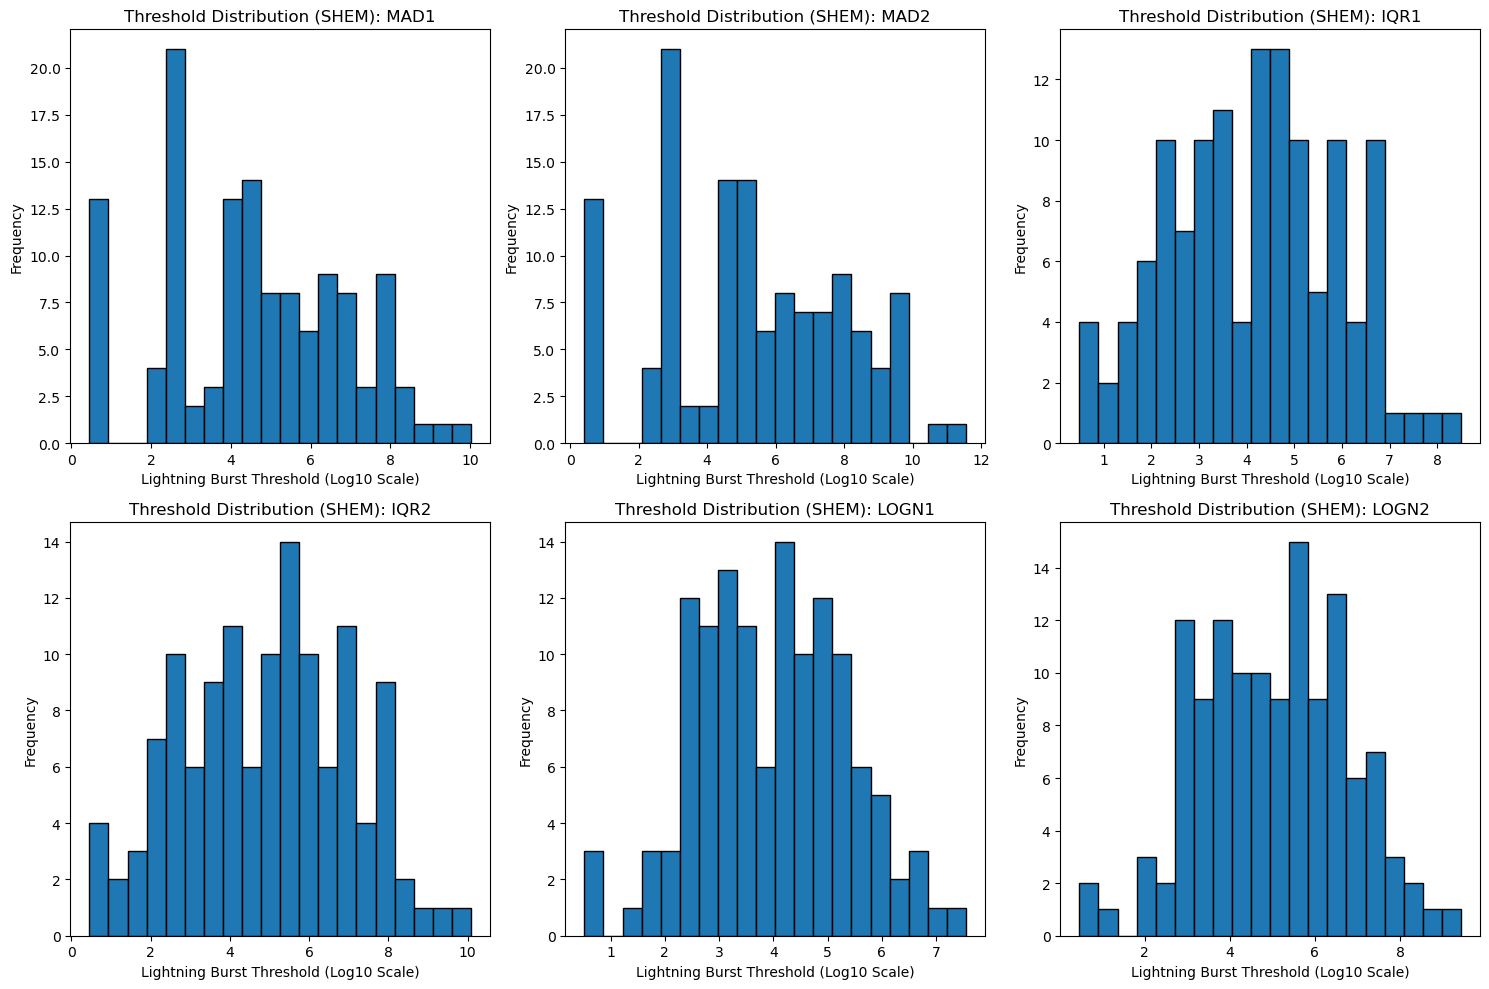

In [128]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(shem_tc_summary, threshold, ax=axes[i])
    axes[i].set_title(f"Threshold Distribution (SHEM): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

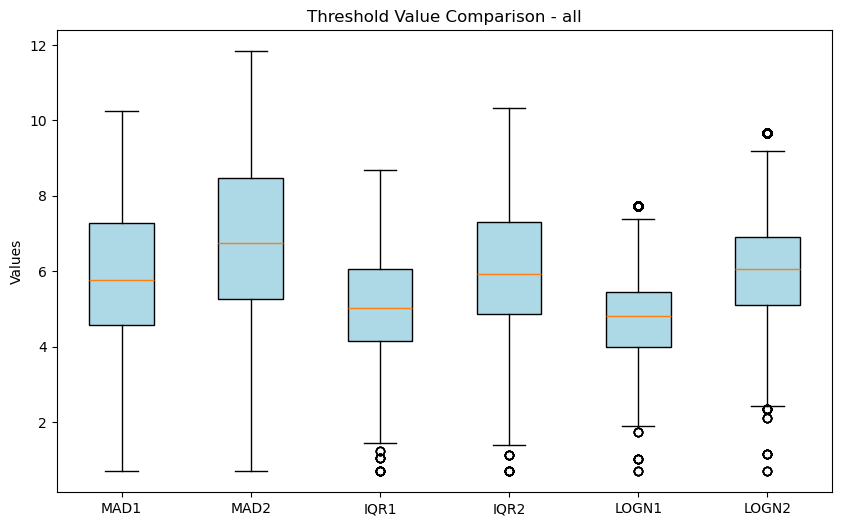

In [129]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(shem_bursts, "all", ax=None)

Create a summary for the weaker categories and create an initial basin-category threshold defined as 2 standard deviations + the mean or median.

In [281]:
# Group the data into weak and strong category datasets using function
shem_weak0_lightning, shem_weak1_lightning, shem_strong_lightning = group_bins_category(shem_bursts)

6172 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
2901 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
1561 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


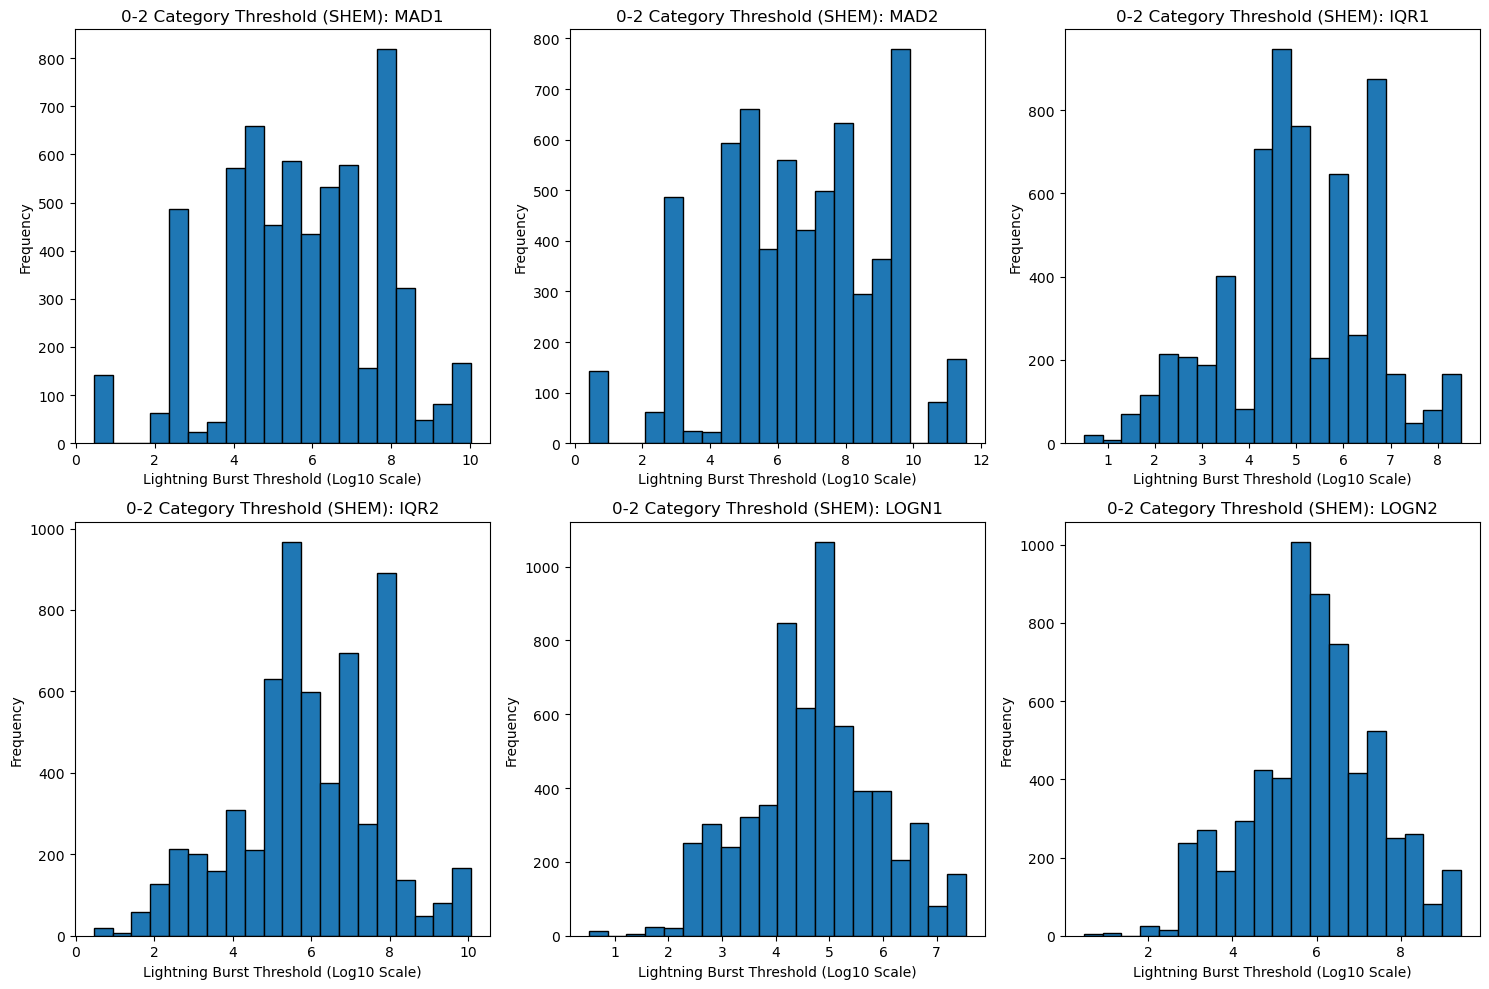

In [132]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(shem_weak0_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Threshold (SHEM): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

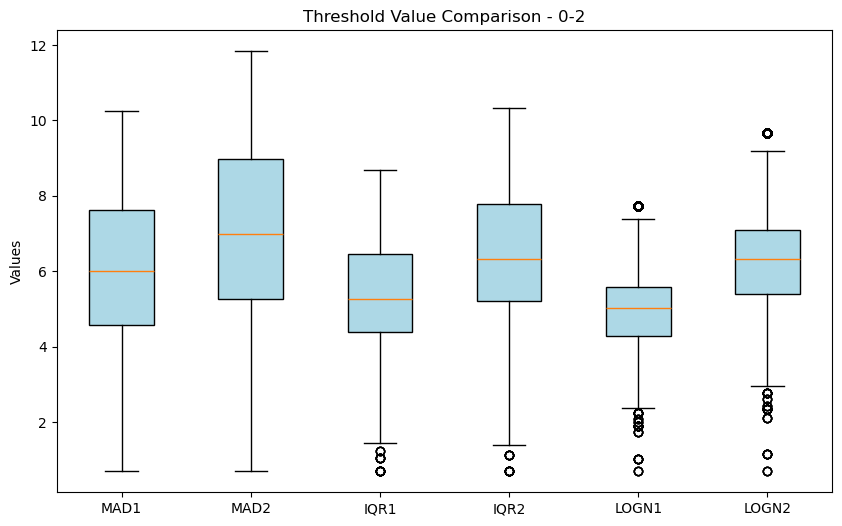

In [133]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(shem_weak0_lightning, "0-2", ax=None)

In [282]:
# Create basin summary for 0-2 category group
shem_weak0_summary = create_basin_summary(shem_weak0_lightning, "0-2", "SHEM")
shem_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            0-2      mad1  6.008510  2.036056  6.002759  0.693147   
1  SHEM            0-2      mad2  6.956304  2.366982  6.983588  0.693147   
2  SHEM            0-2      iqr1  5.234799  1.532244  5.257495  0.693147   
3  SHEM            0-2      iqr2  6.222593  1.830018  6.321377  0.693147   
4  SHEM            0-2     logn1  4.903402  1.221418  5.011738  0.693147   
5  SHEM            0-2     logn2  6.175259  1.510693  6.326662  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  
0  10.259878          154           6172              2.50  
1  11.832275           89           6172              1.44  
2   8.696232          177           6172              2.87  
3  10.320983           58           6172              0.94  
4   7.724278          209           6172              3.39  
5   9.653251           11           6172              0.18

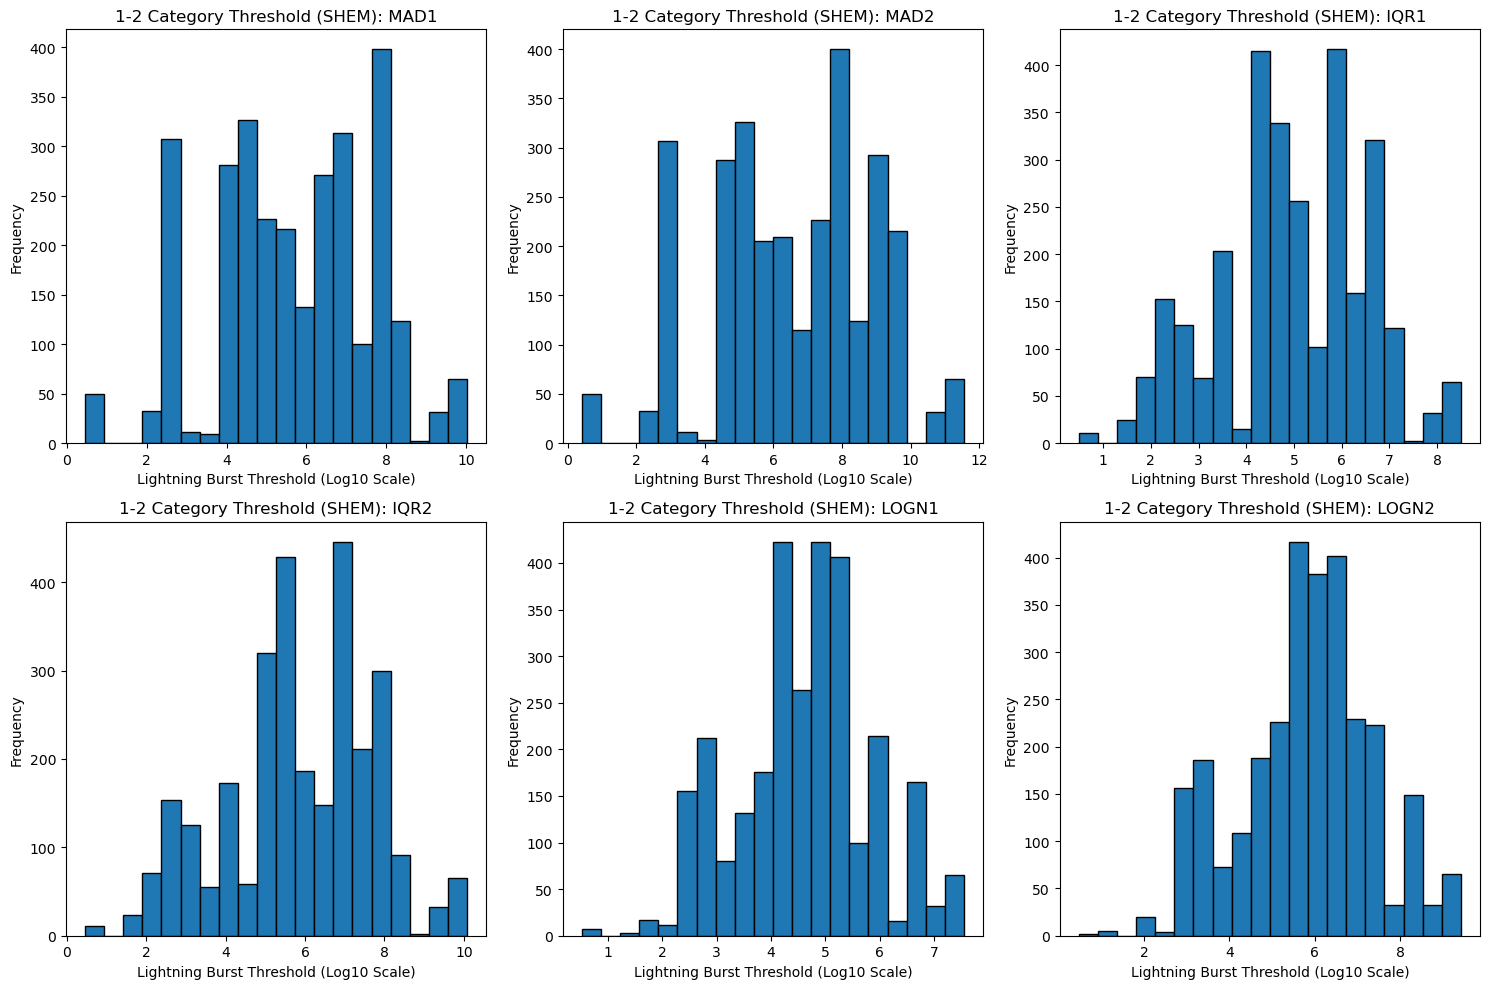

In [135]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(shem_weak1_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Threshold (SHEM): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

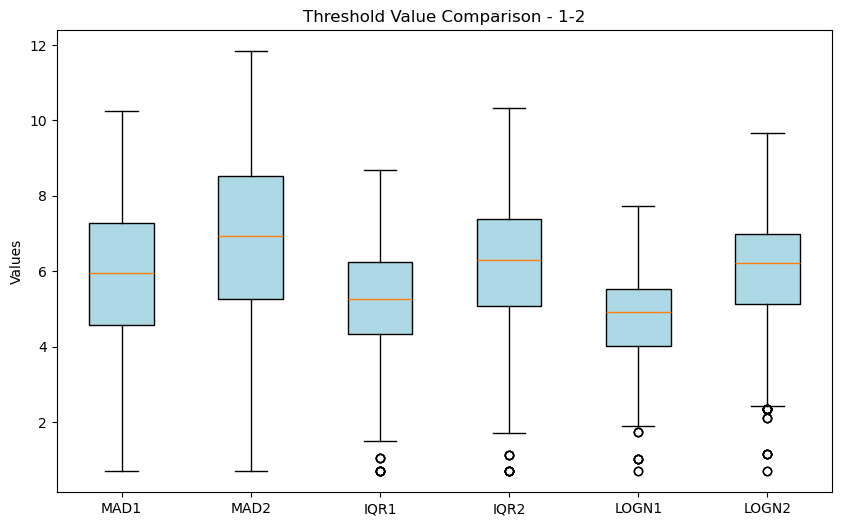

In [136]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(shem_weak1_lightning, "1-2", ax=None)

In [137]:
# Create basin summary for 1-2 category group
shem_weak1_summary = create_basin_summary(shem_weak1_lightning, "1-2", "SHEM")
shem_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            1-2      mad1  5.907728  2.016014  5.940025  0.693147   
1  SHEM            1-2      mad2  6.832220  2.341383  6.938554  0.693147   
2  SHEM            1-2      iqr1  5.145984  1.551917  5.257495  0.693147   
3  SHEM            1-2      iqr2  6.111225  1.854190  6.297216  0.693147   
4  SHEM            1-2     logn1  4.800662  1.247824  4.907602  0.693147   
5  SHEM            1-2     logn2  6.035782  1.543425  6.213425  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  
0  10.259878           58           2901              2.00  
1  11.832275           31           2901              1.07  
2   8.696232           61           2901              2.10  
3  10.320983           17           2901              0.59  
4   7.724278           63           2901              2.17  
5   9.653251            4           2901              0.14

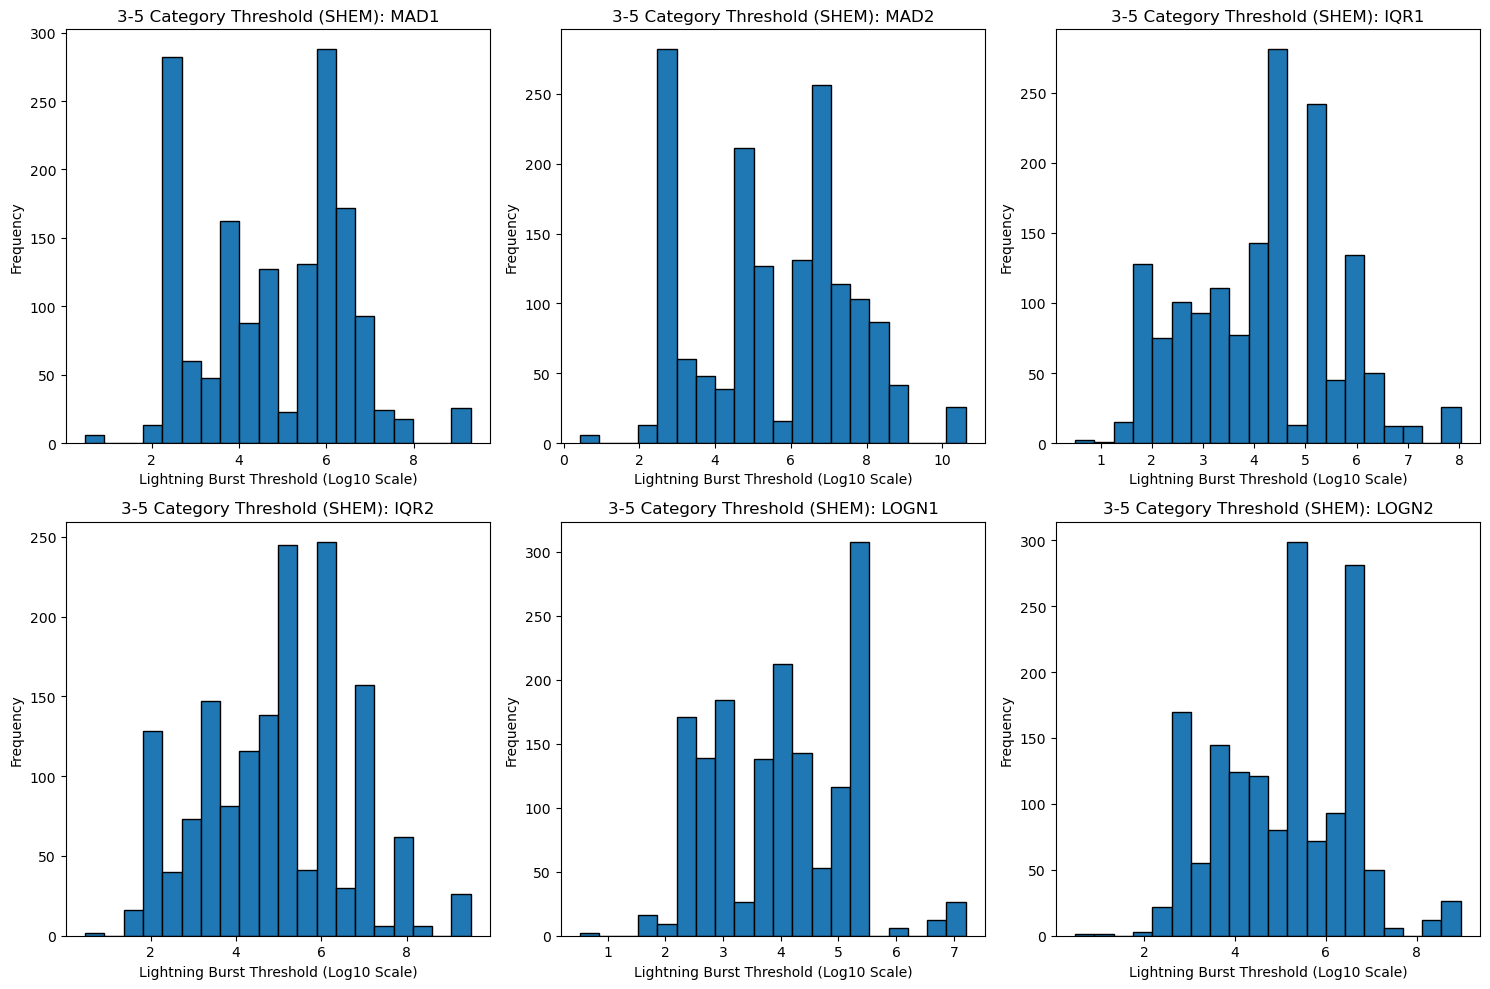

In [138]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(shem_strong_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Threshold (SHEM): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

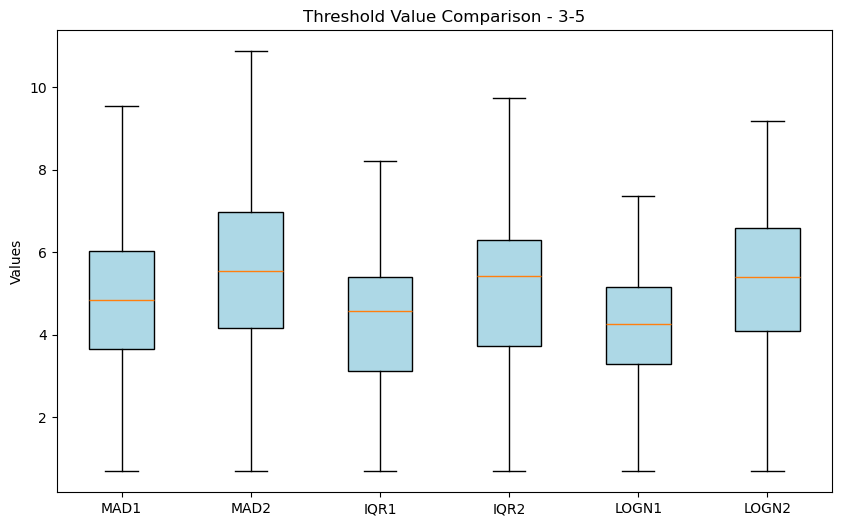

In [139]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(shem_strong_lightning, "3-5", ax=None)

In [283]:
# Create basin summary for 3-5 category group
shem_strong_summary = create_basin_summary(shem_strong_lightning, "3-5", "SHEM")
shem_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            3-5      mad1  5.027211  1.675949  4.852030  0.693147   
1  SHEM            3-5      mad2  5.805059  1.956636  5.545177  0.693147   
2  SHEM            3-5      iqr1  4.367917  1.415470  4.567814  0.693147   
3  SHEM            3-5      iqr2  5.172655  1.706297  5.435115  0.693147   
4  SHEM            3-5     logn1  4.185527  1.142475  4.273303  0.693147   
5  SHEM            3-5     logn2  5.253053  1.441042  5.408034  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  
0   9.532848           13           1561              0.83  
1  10.868646            3           1561              0.19  
2   8.220044           26           1561              1.67  
3   9.725749           10           1561              0.64  
4   7.370893           31           1561              1.99  
5   9.180769            1           1561              0.06

Let's go ahead and filter the thresholds to just the "effective" thresholds and use these to calculate the basin-category threshold.

In [141]:
# Effective thresholds - SHEM basin
shem_bursts_effective = filter_effective_thresholds(shem_bursts)
shem_storm_codes_effective = shem_bursts_effective["storm_code"].unique()
shem_tc_summary_effective = shem_tc_summary[shem_tc_summary["storm_code"].isin(shem_storm_codes_effective)]

shem_bursts_effective.head()

time_bin  storm_code  lightning_count  year  month  day  \
16949 2009-11-16 13:00:00   SHEM_10_1               11  2009     11   16   
16963 2010-02-01 03:00:00  SHEM_10_12              328  2010      2    1   
17005 2010-02-08 06:30:00  SHEM_10_14               52  2010      2    8   
17265 2010-02-20 11:30:00  SHEM_10_16              147  2010      2   20   
17269 2010-02-20 13:30:00  SHEM_10_16              108  2010      2   20   

       hour  minute   lat    lon  ...  iqr1_threshold  iqr2_threshold  \
16949    13       0 -14.7   68.3  ...             NaN             NaN   
16963     3       0 -12.5 -164.4  ...             NaN             NaN   
17005     6      30 -12.3 -160.9  ...             NaN             NaN   
17265    11      30 -19.4   61.5  ...        4.382027             NaN   
17269    13      30 -19.4   61.5  ...        4.382027             NaN   

      burst_mad1  burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  \
16949      False       False            NaN             NaN         True   
16963      False       False       7.230859             NaN         True   
17005      False       False            NaN             NaN         True   
17265       True       False       4.564348             NaN         True   
17269       True       False       4.564348             NaN         True   

       burst_logn2 logn1_threshold logn2_threshold  
16949        False        2.427185             NaN  
16963        False        5.219819             NaN  
17005        False        3.813104             NaN  
17265        False        4.273303             NaN  
17269        False        4.273303             NaN  

[5 rows x 34 columns]

In [284]:
print(f"{len(shem_storm_codes_effective)} TCs of {len(shem_storm_codes)} SHEM TCs after filtering for bursts of any type")

102 TCs of 127 SHEM TCs after filtering for bursts of any type


In [143]:
shem_effective_summary = create_basin_summary(shem_bursts_effective, "all", "SHEM")
shem_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            all      mad1  3.983895  1.834002  4.158883  0.693147   
1  SHEM            all      mad2  3.097117  1.779817  3.125938  0.693147   
2  SHEM            all      iqr1  3.078818  1.225781  2.890372  0.693147   
3  SHEM            all      iqr2  2.863906  1.235753  2.426015  0.693147   
4  SHEM            all     logn1  4.333043  1.119383  4.467035  1.008509   
5  SHEM            all     logn2  4.081379  0.844423  4.027492  3.126854   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.506842          167            341             48.97  
1  7.284821           92            341             26.98  
2  5.399839          203            341             59.53  
3  6.447372           68            341             19.94  
4  7.724278          240            341             70.38  
5  5.804040           12            341              3.52

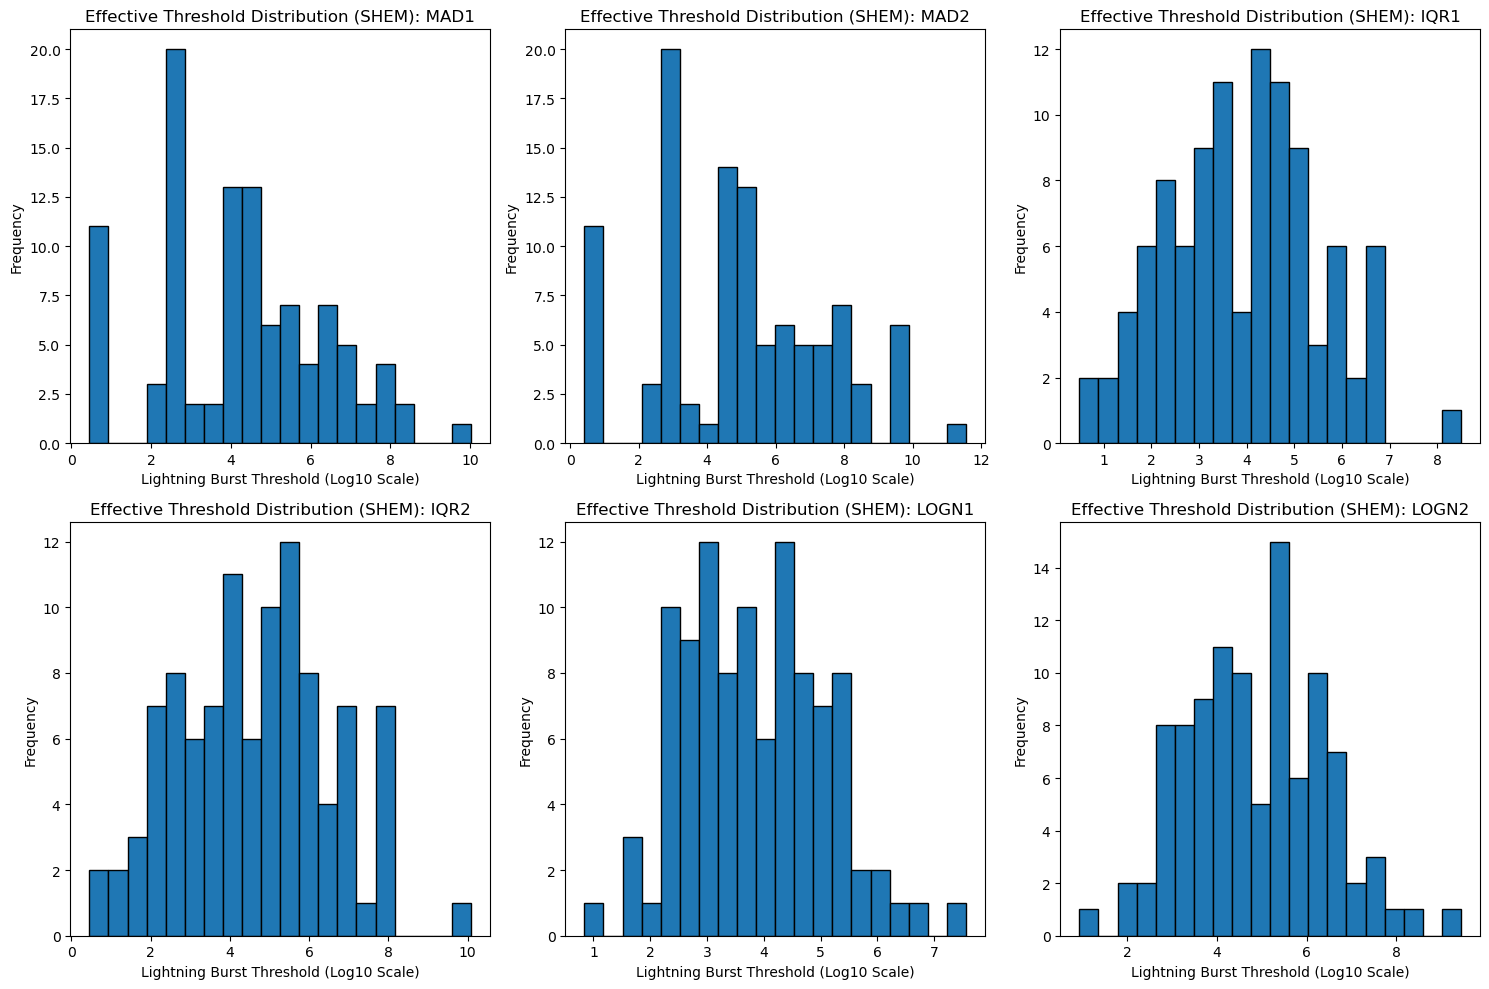

In [144]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(shem_tc_summary_effective, threshold, ax=axes[i])
    axes[i].set_title(f"Effective Threshold Distribution (SHEM): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [285]:
# Group the data into weak and strong category datasets using function
shem_weak0_effective_lightning, shem_weak1_effective_lightning, shem_strong_effective_lightning = group_bins_category(shem_bursts_effective)

300 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
102 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
41 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


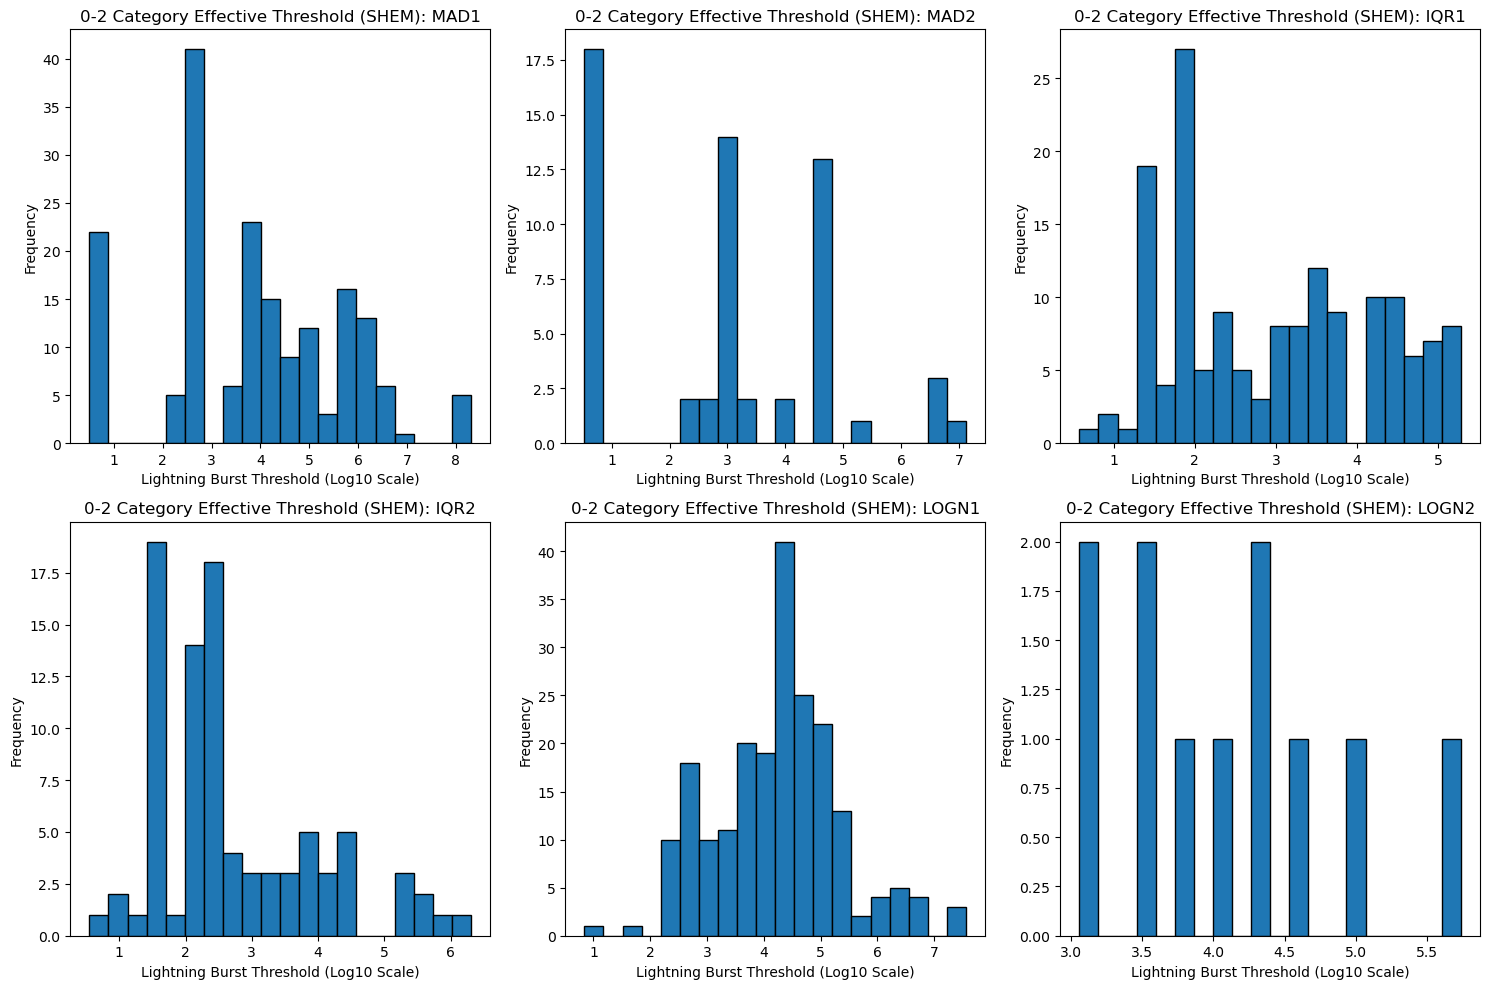

In [146]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(shem_weak0_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Effective Threshold (SHEM): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [147]:
# Get summary for effective thresholds - 0-2 categories
shem_weak0_effective_summary = create_basin_summary(shem_weak0_effective_lightning, "0-2", "SHEM")
shem_weak0_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            0-2      mad1  4.023602  1.885241  4.158883  0.693147   
1  SHEM            0-2      mad2  3.074258  1.924286  3.125938  0.693147   
2  SHEM            0-2      iqr1  3.109152  1.264200  3.060271  0.693147   
3  SHEM            0-2      iqr2  2.855887  1.252744  2.426015  0.693147   
4  SHEM            0-2     logn1  4.422074  1.102530  4.531068  1.008509   
5  SHEM            0-2     logn2  4.168154  0.827623  4.146815  3.126854   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.506842          154            300             51.33  
1  7.284821           89            300             29.67  
2  5.399839          177            300             59.00  
3  6.447372           58            300             19.33  
4  7.724278          209            300             69.67  
5  5.804040           11            300              3.67

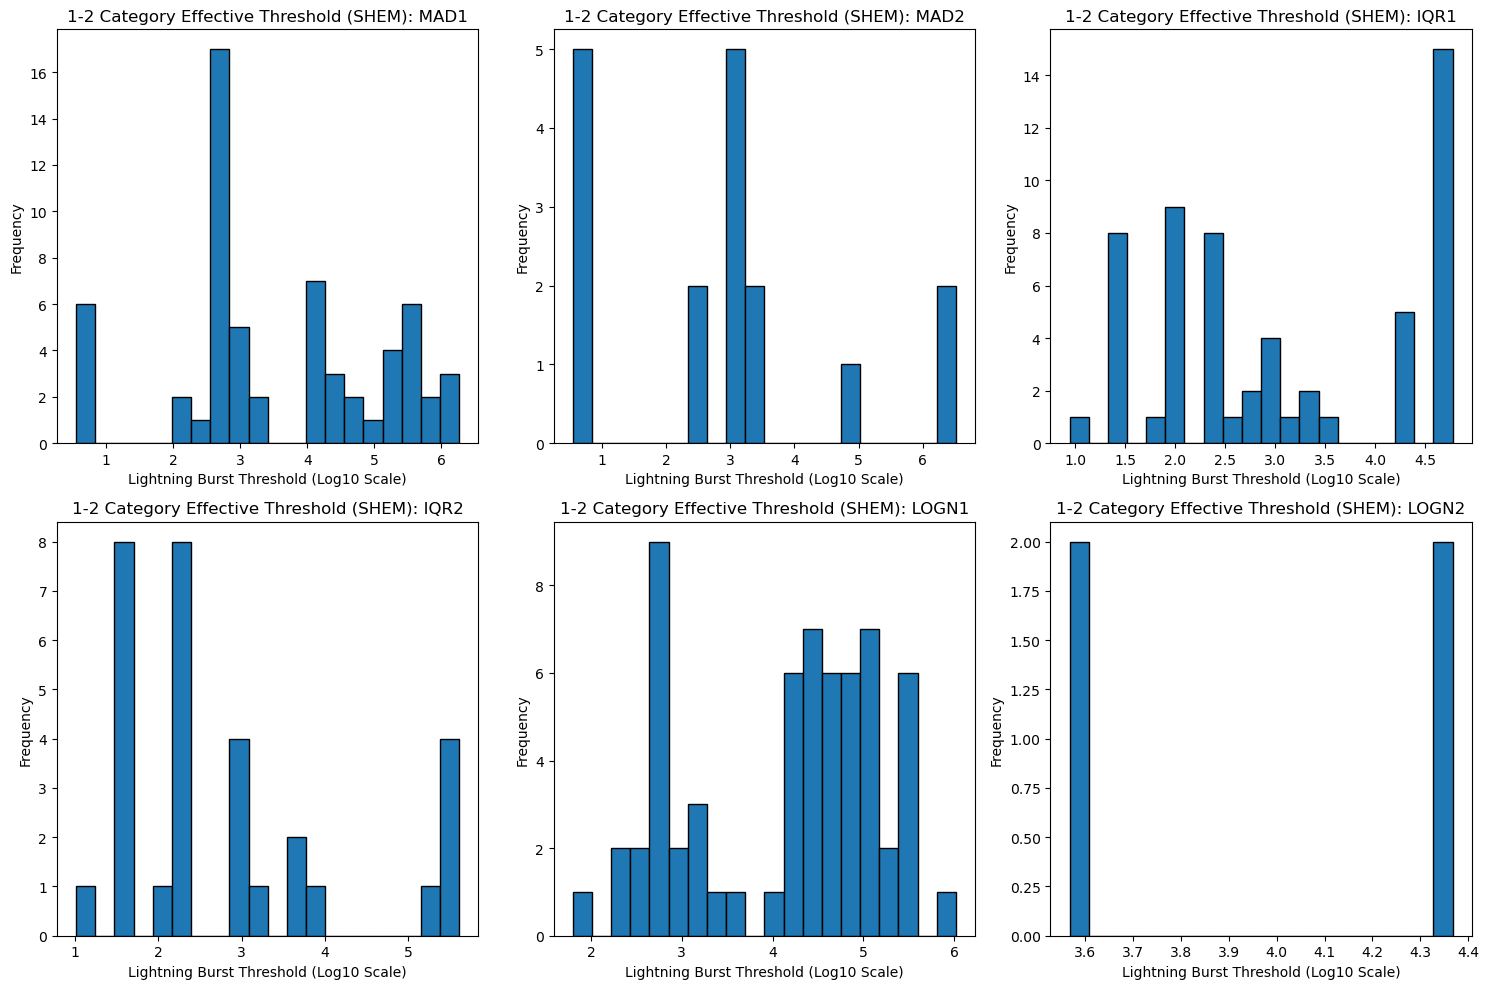

In [148]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(shem_weak1_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Effective Threshold (SHEM): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [286]:
# Get summary for effective thresholds - 1-2 categories
shem_weak1_effective_summary = create_basin_summary(shem_weak1_effective_lightning, "1-2", "SHEM")
shem_weak1_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            1-2      mad1  3.679701  1.609606  3.008155  0.693147   
1  SHEM            1-2      mad2  2.896655  1.903796  3.125938  0.693147   
2  SHEM            1-2      iqr1  3.118719  1.231111  2.841790  1.039721   
3  SHEM            1-2      iqr2  2.929965  1.363919  2.426015  1.126364   
4  SHEM            1-2     logn1  4.256785  1.068649  4.536489  1.905468   
5  SHEM            1-2     logn2  3.987285  0.461790  3.987285  3.587363   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  6.408224           58            102             56.86  
1  6.666314           31            102             30.39  
2  4.867711           61            102             59.80  
3  5.730405           17            102             16.67  
4  6.123277           63            102             61.76  
5  4.387206            4            102              3.92

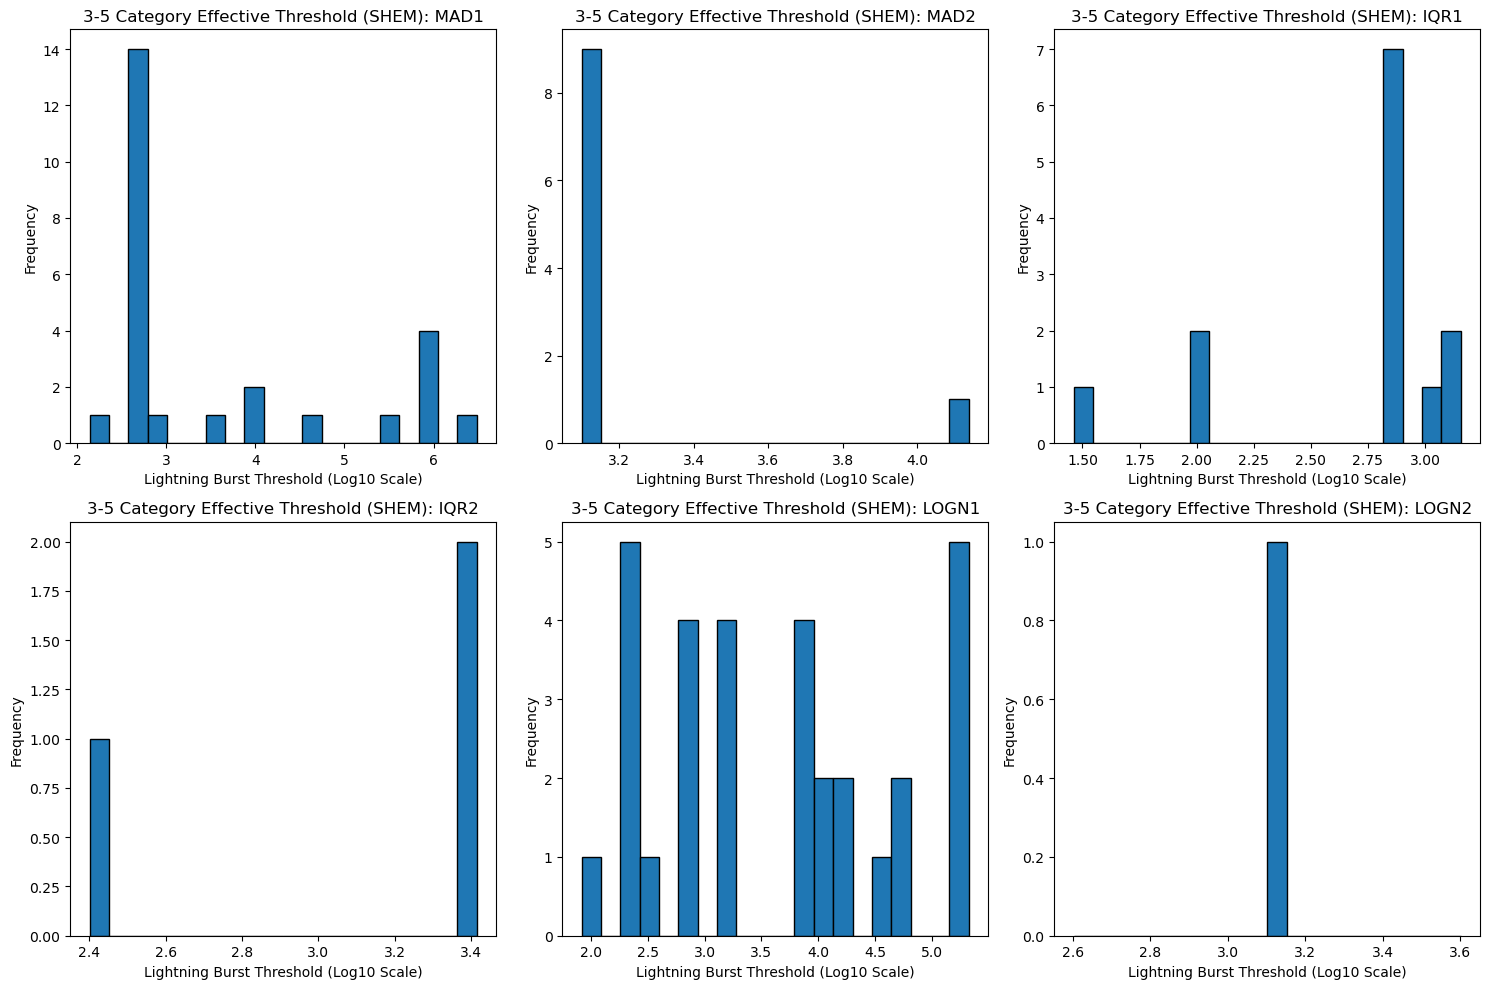

In [150]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(shem_strong_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Effective Threshold (SHEM): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [151]:
# Get summary for effective thresholds - 3-5 categories
shem_strong_effective_summary = create_basin_summary(shem_strong_effective_lightning, "3-5", "SHEM")
shem_strong_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            3-5      mad1  3.713582  1.438524  2.720473  2.249341   
1  SHEM            3-5      mad2  3.229701  0.328127  3.125938  3.125938   
2  SHEM            3-5      iqr1  2.719475  0.506320  2.890372  1.504077   
3  SHEM            3-5      iqr2  3.101790  0.585238  3.439678  2.426015   
4  SHEM            3-5     logn1  3.732804  1.061549  3.885230  2.003217   
5  SHEM            3-5     logn2  3.126854       NaN  3.126854  3.126854   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  6.591674           13             41             31.71  
1  4.163566            3             41              7.32  
2  3.198673           26             41             63.41  
3  3.439678           10             41             24.39  
4  5.408574           31             41             75.61  
5  3.126854            1             41              2.44

Let's calculate and apply the basin-level effective threshold. We'll try both 1.5 SD and 2 SD from the mean and median of the effective thresholds for each category group.

Start with the 0-2 category grouping.

In [152]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
shem_weak0_effective_thresholds = calculate_basin_thresholds(shem_weak0_effective_lightning, "0-2", "SHEM", threshold_type="effective")
shem_weak0_effective_thresholds_1_5sd = calculate_basin_thresholds(shem_weak0_effective_lightning, "0-2", "SHEM", std_dev=1.5, threshold_type="effective")

In [153]:
# 0-2 categories, 2 SD
shem_weak0_summary_2sd, shem_weak0_eff_bursts_mean, shem_weak0_eff_summary_mean, shem_weak0_eff_bursts_median, shem_weak0_eff_summary_median = summarize_threshold_eval(shem_weak0_summary, shem_weak0_lightning, shem_weak0_effective_thresholds, threshold_type="effective")
shem_weak0_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            0-2      mad1  6.008510  2.036056  6.002759  0.693147   
1  SHEM            0-2      mad2  6.956304  2.366982  6.983588  0.693147   
2  SHEM            0-2      iqr1  5.234799  1.532244  5.257495  0.693147   
3  SHEM            0-2      iqr2  6.222593  1.830018  6.321377  0.693147   
4  SHEM            0-2     logn1  4.903402  1.221418  5.011738  0.693147   
5  SHEM            0-2     logn2  6.175259  1.510693  6.326662  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.259878          154           6172              2.50   
1  11.832275           89           6172              1.44   
2   8.696232          177           6172              2.87   
3  10.320983           58           6172              0.94   
4   7.724278          209           6172              3.39   
5   9.653251           11           6172              0.18   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           7.794083      
1                                           6.922830      
2                                           5.637552      
3                                           5.361376      
4                                           6.627134      
5                                           5.823400      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           7.929364        
1                                           6.974510        
2                                           5.588670        
3                                           4.931504        
4                                           6.736128        
5                                           5.802061        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  3             
1                                                 14             
2                                                149             
3                                                226             
4                                                 27             
5                                                 96             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.05                       
1                                               0.23                       
2                                               2.41                       
3                                               3.66                       
4                                               0.44                       
5                                               1.56                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  1               
1                                                 13               
2                                                156               
3                                                416               
4                                                 23               
5                                                103               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.02                        
1                                               0.21                        
2                                               2.53                        
3                                               6.74                        
4                                               0.37                        
5                                               1.67

In [154]:
# 0-2 categories, 1.5 SD
shem_weak0_summary_1_5sd, shem_weak0_eff_bursts_mean_1_5, shem_weak0_eff_summary_mean_1_5, shem_weak0_eff_bursts_median_1_5, shem_weak0_eff_summary_median_1_5 = summarize_threshold_eval(shem_weak0_summary, shem_weak0_lightning, shem_weak0_effective_thresholds_1_5sd, threshold_type="effective")
shem_weak0_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            0-2      mad1  6.008510  2.036056  6.002759  0.693147   
1  SHEM            0-2      mad2  6.956304  2.366982  6.983588  0.693147   
2  SHEM            0-2      iqr1  5.234799  1.532244  5.257495  0.693147   
3  SHEM            0-2      iqr2  6.222593  1.830018  6.321377  0.693147   
4  SHEM            0-2     logn1  4.903402  1.221418  5.011738  0.693147   
5  SHEM            0-2     logn2  6.175259  1.510693  6.326662  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.259878          154           6172              2.50   
1  11.832275           89           6172              1.44   
2   8.696232          177           6172              2.87   
3  10.320983           58           6172              0.94   
4   7.724278          209           6172              3.39   
5   9.653251           11           6172              0.18   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.851462        
1                                           5.960687        
2                                           5.005452        
3                                           4.735004        
4                                           6.075869        
5                                           5.409589        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.986744          
1                                           6.012367          
2                                           4.956571          
3                                           4.305131          
4                                           6.184863          
5                                           5.388250          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 16               
1                                                 74               
2                                                374               
3                                                539               
4                                                 62               
5                                                217               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.26                         
1                                               1.20                         
2                                               6.06                         
3                                               8.73                         
4                                               1.00                         
5                                               3.52                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                 12                 
1                                                 67                 
2                                                400                 
3                                                820                 
4                                                 53                 
5                                                221                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               0.19                          
1                                               1.09                          
2                                               6.48                          
3                                              13.29                          
4                                               0.86                          
5                                               3.58

In [155]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = shem_weak0_summary_1_5sd.columns[-6: ].to_list()
keep.append(shem_weak0_summary_1_5sd.columns[2])
shem_weak0_summary = pd.merge(shem_weak0_summary_2sd, shem_weak0_summary_1_5sd[keep], on="Threshold")
shem_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            0-2      mad1  6.008510  2.036056  6.002759  0.693147   
1  SHEM            0-2      mad2  6.956304  2.366982  6.983588  0.693147   
2  SHEM            0-2      iqr1  5.234799  1.532244  5.257495  0.693147   
3  SHEM            0-2      iqr2  6.222593  1.830018  6.321377  0.693147   
4  SHEM            0-2     logn1  4.903402  1.221418  5.011738  0.693147   
5  SHEM            0-2     logn2  6.175259  1.510693  6.326662  0.693147   

         Max  Burst Count  Timebin Count  ...  \
0  10.259878          154           6172  ...   
1  11.832275           89           6172  ...   
2   8.696232          177           6172  ...   
3  10.320983           58           6172  ...   
4   7.724278          209           6172  ...   
5   9.653251           11           6172  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  3             
1                                                 14             
2                                                149             
3                                                226             
4                                                 27             
5                                                 96             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.05                       
1                                               0.23                       
2                                               2.41                       
3                                               3.66                       
4                                               0.44                       
5                                               1.56                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  1               
1                                                 13               
2                                                156               
3                                                416               
4                                                 23               
5                                                103               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.02                         
1                                               0.21                         
2                                               2.53                         
3                                               6.74                         
4                                               0.37                         
5                                               1.67                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.851462        
1                                           5.960687        
2                                           5.005452        
3                                           4.735004        
4                                           6.075869        
5                                           5.409589        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.986744          
1                                           6.012367          
2                                           4.956571          
3                                           4.305131          
4                                           6.184863          
5                                           5.388250          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 16               
1                                                 74               
2                              

Let's do the same for the other 2 category groupings.

1-2 categories:

In [156]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
shem_weak1_effective_thresholds = calculate_basin_thresholds(shem_weak1_effective_lightning, "1-2", "SHEM", threshold_type="effective")
shem_weak1_effective_thresholds_1_5sd = calculate_basin_thresholds(shem_weak1_effective_lightning, "1-2", "SHEM", std_dev=1.5, threshold_type="effective")

In [157]:
# 1-2 categories, 2 SD
shem_weak1_summary_2sd, shem_weak1_eff_bursts_mean, shem_weak1_eff_summary_mean, shem_weak1_eff_bursts_median, shem_weak1_eff_summary_median = summarize_threshold_eval(shem_weak1_summary, shem_weak1_lightning, shem_weak1_effective_thresholds, threshold_type="effective")
shem_weak1_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            1-2      mad1  5.907728  2.016014  5.940025  0.693147   
1  SHEM            1-2      mad2  6.832220  2.341383  6.938554  0.693147   
2  SHEM            1-2      iqr1  5.145984  1.551917  5.257495  0.693147   
3  SHEM            1-2      iqr2  6.111225  1.854190  6.297216  0.693147   
4  SHEM            1-2     logn1  4.800662  1.247824  4.907602  0.693147   
5  SHEM            1-2     logn2  6.035782  1.543425  6.213425  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.259878           58           2901              2.00   
1  11.832275           31           2901              1.07   
2   8.696232           61           2901              2.10   
3  10.320983           17           2901              0.59   
4   7.724278           63           2901              2.17   
5   9.653251            4           2901              0.14   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           6.898913      
1                                           6.704247      
2                                           5.580941      
3                                           5.657803      
4                                           6.394083      
5                                           4.910864      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           6.227367        
1                                           6.933530        
2                                           5.304012        
3                                           5.153853        
4                                           6.673788        
5                                           4.910864        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  2             
2                                                 49             
3                                                 46             
4                                                  4             
5                                                146             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.07                       
2                                               1.69                       
3                                               1.59                       
4                                               0.14                       
5                                               5.03                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  7               
1                                                  0               
2                                                 81               
3                                                100               
4                                                  2               
5                                                146               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.24                        
1                                               0.00                        
2                                               2.79                        
3                                               3.45                        
4                                               0.07                        
5                                               5.03

In [158]:
# 1-2 categories, 1.5 SD
shem_weak1_summary_1_5sd, shem_weak1_eff_bursts_mean_1_5, shem_weak1_eff_summary_mean_1_5, shem_weak1_eff_bursts_median_1_5, shem_weak1_eff_summary_median_1_5 = summarize_threshold_eval(shem_weak1_summary, shem_weak1_lightning, shem_weak1_effective_thresholds_1_5sd, threshold_type="effective")
shem_weak1_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            1-2      mad1  5.907728  2.016014  5.940025  0.693147   
1  SHEM            1-2      mad2  6.832220  2.341383  6.938554  0.693147   
2  SHEM            1-2      iqr1  5.145984  1.551917  5.257495  0.693147   
3  SHEM            1-2      iqr2  6.111225  1.854190  6.297216  0.693147   
4  SHEM            1-2     logn1  4.800662  1.247824  4.907602  0.693147   
5  SHEM            1-2     logn2  6.035782  1.543425  6.213425  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  10.259878           58           2901              2.00   
1  11.832275           31           2901              1.07   
2   8.696232           61           2901              2.10   
3  10.320983           17           2901              0.59   
4   7.724278           63           2901              2.17   
5   9.653251            4           2901              0.14   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.094110        
1                                           5.752349        
2                                           4.965385        
3                                           4.975843        
4                                           5.859758        
5                                           4.679969        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.422564          
1                                           5.981632          
2                                           4.688457          
3                                           4.471893          
4                                           6.139463          
5                                           4.679969          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 12               
1                                                 35               
2                                                134               
3                                                131               
4                                                 23               
5                                                214               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.41                         
1                                               1.21                         
2                                               4.62                         
3                                               4.52                         
4                                               0.79                         
5                                               7.38                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                 71                 
1                                                 17                 
2                                                209                 
3                                                264                 
4                                                 10                 
5                                                214                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               2.45                          
1                                               0.59                          
2                                               7.20                          
3                                               9.10                          
4                                               0.34                          
5                                               7.38

In [159]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = shem_weak1_summary_1_5sd.columns[-6: ].to_list()
keep.append(shem_weak1_summary_1_5sd.columns[2])
shem_weak1_summary = pd.merge(shem_weak1_summary_2sd, shem_weak1_summary_1_5sd[keep], on="Threshold")
shem_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            1-2      mad1  5.907728  2.016014  5.940025  0.693147   
1  SHEM            1-2      mad2  6.832220  2.341383  6.938554  0.693147   
2  SHEM            1-2      iqr1  5.145984  1.551917  5.257495  0.693147   
3  SHEM            1-2      iqr2  6.111225  1.854190  6.297216  0.693147   
4  SHEM            1-2     logn1  4.800662  1.247824  4.907602  0.693147   
5  SHEM            1-2     logn2  6.035782  1.543425  6.213425  0.693147   

         Max  Burst Count  Timebin Count  ...  \
0  10.259878           58           2901  ...   
1  11.832275           31           2901  ...   
2   8.696232           61           2901  ...   
3  10.320983           17           2901  ...   
4   7.724278           63           2901  ...   
5   9.653251            4           2901  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  2             
2                                                 49             
3                                                 46             
4                                                  4             
5                                                146             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.07                       
2                                               1.69                       
3                                               1.59                       
4                                               0.14                       
5                                               5.03                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  7               
1                                                  0               
2                                                 81               
3                                                100               
4                                                  2               
5                                                146               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.24                         
1                                               0.00                         
2                                               2.79                         
3                                               3.45                         
4                                               0.07                         
5                                               5.03                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.094110        
1                                           5.752349        
2                                           4.965385        
3                                           4.975843        
4                                           5.859758        
5                                           4.679969        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.422564          
1                                           5.981632          
2                                           4.688457          
3                                           4.471893          
4                                           6.139463          
5                                           4.679969          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 12               
1                                                 35               
2                              

Next, we do the same for the stronger category group, 3-5.

In [160]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
shem_strong_effective_thresholds = calculate_basin_thresholds(shem_strong_effective_lightning, "3-5", "SHEM", threshold_type="effective")
shem_strong_effective_thresholds_1_5sd = calculate_basin_thresholds(shem_strong_effective_lightning, "3-5", "SHEM", std_dev=1.5, threshold_type="effective")

In [161]:
# 3-5 categories, 2 SD
shem_strong_summary_2sd, shem_strong_eff_bursts_mean, shem_strong_eff_summary_mean, shem_strong_eff_bursts_median, shem_strong_eff_summary_median = summarize_threshold_eval(shem_strong_summary, shem_strong_lightning, shem_strong_effective_thresholds, threshold_type="effective")
shem_strong_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            3-5      mad1  5.027211  1.675949  4.852030  0.693147   
1  SHEM            3-5      mad2  5.805059  1.956636  5.545177  0.693147   
2  SHEM            3-5      iqr1  4.367917  1.415470  4.567814  0.693147   
3  SHEM            3-5      iqr2  5.172655  1.706297  5.435115  0.693147   
4  SHEM            3-5     logn1  4.185527  1.142475  4.273303  0.693147   
5  SHEM            3-5     logn2  5.253053  1.441042  5.408034  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0   9.532848           13           1561              0.83   
1  10.868646            3           1561              0.19   
2   8.220044           26           1561              1.67   
3   9.725749           10           1561              0.64   
4   7.370893           31           1561              1.99   
5   9.180769            1           1561              0.06   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           6.590631      
1                                           3.885954      
2                                           3.732116      
3                                           4.272267      
4                                           5.855901      
5                                                NaN      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           5.597521        
1                                           3.782192        
2                                           3.903012        
3                                           4.610155        
4                                           6.008327        
5                                                NaN        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                117             
2                                                143             
3                                                 70             
4                                                  1             
5                                                  0             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               7.50                       
2                                               9.16                       
3                                               4.48                       
4                                               0.06                       
5                                               0.00                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  4               
1                                                131               
2                                                115               
3                                                 45               
4                                                  0               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.26                        
1                                               8.39                        
2                                               7.37                        
3                                               2.88                        
4                                               0.00                        
5                                               0.00

In [162]:
# 3-5 categories, 1.5 SD
shem_strong_summary_1_5sd, shem_strong_eff_bursts_mean_1_5, shem_strong_eff_summary_mean_1_5, shem_strong_eff_bursts_median_1_5, shem_strong_eff_summary_median_1_5 = summarize_threshold_eval(shem_strong_summary, shem_strong_lightning, shem_strong_effective_thresholds_1_5sd, threshold_type="effective")
shem_strong_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            3-5      mad1  5.027211  1.675949  4.852030  0.693147   
1  SHEM            3-5      mad2  5.805059  1.956636  5.545177  0.693147   
2  SHEM            3-5      iqr1  4.367917  1.415470  4.567814  0.693147   
3  SHEM            3-5      iqr2  5.172655  1.706297  5.435115  0.693147   
4  SHEM            3-5     logn1  4.185527  1.142475  4.273303  0.693147   
5  SHEM            3-5     logn2  5.253053  1.441042  5.408034  0.693147   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0   9.532848           13           1561              0.83   
1  10.868646            3           1561              0.19   
2   8.220044           26           1561              1.67   
3   9.725749           10           1561              0.64   
4   7.370893           31           1561              1.99   
5   9.180769            1           1561              0.06   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           5.871369        
1                                           3.721891        
2                                           3.478955        
3                                           3.979648        
4                                           5.325127        
5                                                NaN        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           4.878259          
1                                           3.618128          
2                                           3.649852          
3                                           4.317536          
4                                           5.477553          
5                                                NaN          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  1               
1                                                143               
2                                                183               
3                                                 98               
4                                                 11               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.06                         
1                                               9.16                         
2                                              11.72                         
3                                               6.28                         
4                                               0.70                         
5                                               0.00                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                 27                 
1                                                155                 
2                                                151                 
3                                                 67                 
4                                                  5                 
5                                                  0                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               1.73                          
1                                               9.93                          
2                                               9.67                          
3                                               4.29                          
4                                               0.32                          
5                                               0.00

In [163]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = shem_strong_summary_1_5sd.columns[-6: ].to_list()
keep.append(shem_strong_summary_1_5sd.columns[2])
shem_strong_summary = pd.merge(shem_strong_summary_2sd, shem_strong_summary_1_5sd[keep], on="Threshold")
shem_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            3-5      mad1  5.027211  1.675949  4.852030  0.693147   
1  SHEM            3-5      mad2  5.805059  1.956636  5.545177  0.693147   
2  SHEM            3-5      iqr1  4.367917  1.415470  4.567814  0.693147   
3  SHEM            3-5      iqr2  5.172655  1.706297  5.435115  0.693147   
4  SHEM            3-5     logn1  4.185527  1.142475  4.273303  0.693147   
5  SHEM            3-5     logn2  5.253053  1.441042  5.408034  0.693147   

         Max  Burst Count  Timebin Count  ...  \
0   9.532848           13           1561  ...   
1  10.868646            3           1561  ...   
2   8.220044           26           1561  ...   
3   9.725749           10           1561  ...   
4   7.370893           31           1561  ...   
5   9.180769            1           1561  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                117             
2                                                143             
3                                                 70             
4                                                  1             
5                                                  0             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               7.50                       
2                                               9.16                       
3                                               4.48                       
4                                               0.06                       
5                                               0.00                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  4               
1                                                131               
2                                                115               
3                                                 45               
4                                                  0               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.26                         
1                                               8.39                         
2                                               7.37                         
3                                               2.88                         
4                                               0.00                         
5                                               0.00                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           5.871369        
1                                           3.721891        
2                                           3.478955        
3                                           3.979648        
4                                           5.325127        
5                                                NaN        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           4.878259          
1                                           3.618128          
2                                           3.649852          
3                                           4.317536          
4                                           5.477553          
5                                                NaN          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  1               
1                                                143               
2                              

Concatenate the three dataframes into one for easier comparison at the basin level.

In [164]:
shem_basin_burst_summary = pd.concat([shem_weak0_summary, shem_weak1_summary, shem_strong_summary], ignore_index=True)
shem_basin_burst_summary.head()

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  SHEM            0-2      mad1  6.008510  2.036056  6.002759  0.693147   
1  SHEM            0-2      mad2  6.956304  2.366982  6.983588  0.693147   
2  SHEM            0-2      iqr1  5.234799  1.532244  5.257495  0.693147   
3  SHEM            0-2      iqr2  6.222593  1.830018  6.321377  0.693147   
4  SHEM            0-2     logn1  4.903402  1.221418  5.011738  0.693147   

         Max  Burst Count  Timebin Count  ...  \
0  10.259878          154           6172  ...   
1  11.832275           89           6172  ...   
2   8.696232          177           6172  ...   
3  10.320983           58           6172  ...   
4   7.724278          209           6172  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  3             
1                                                 14             
2                                                149             
3                                                226             
4                                                 27             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.05                       
1                                               0.23                       
2                                               2.41                       
3                                               3.66                       
4                                               0.44                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  1               
1                                                 13               
2                                                156               
3                                                416               
4                                                 23               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.02                         
1                                               0.21                         
2                                               2.53                         
3                                               6.74                         
4                                               0.37                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.851462        
1                                           5.960687        
2                                           5.005452        
3                                           4.735004        
4                                           6.075869        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.986744          
1                                           6.012367          
2                                           4.956571          
3                                           4.305131          
4                                           6.184863          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 16               
1                                                 74               
2                                                374               
3                                                539               
4                                                 62               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.26                         
1                                               1.20                         
2                                               6.06                         
3                                               8.7

In [165]:
shem_basin_burst_summary.to_csv("data/innercore_shem_basin_bursts_summary.csv", index=False)

In [166]:
# Concatenate the burst and summary datasets - weak0
# 2 SD
shem_weak0_bursts_effthreshold = combine_mean_median_datasets(shem_weak0_eff_bursts_mean, shem_weak0_eff_bursts_median, 2, "0-2")
shem_weak0_summary_effthreshold = combine_mean_median_datasets(shem_weak0_eff_summary_mean, shem_weak0_eff_summary_median, 2, "0-2")

# 1.5 SD
shem_weak0_bursts_effthreshold_1_5 = combine_mean_median_datasets(shem_weak0_eff_bursts_mean_1_5, shem_weak0_eff_bursts_median_1_5, 1.5, "0-2")
shem_weak0_summary_effthreshold_1_5 = combine_mean_median_datasets(shem_weak0_eff_summary_mean_1_5, shem_weak0_eff_summary_median_1_5, 1.5, "0-2")

# Concat all
shem_weak0_bursts_effthreshold = pd.concat([shem_weak0_bursts_effthreshold, shem_weak0_bursts_effthreshold_1_5], ignore_index=True)
shem_weak0_summary_effthreshold = pd.concat([shem_weak0_summary_effthreshold, shem_weak0_summary_effthreshold_1_5], ignore_index=True)

In [167]:
# Concatenate the burst and summary datasets - weak1
# 2 SD
shem_weak1_bursts_effthreshold = combine_mean_median_datasets(shem_weak1_eff_bursts_mean, shem_weak1_eff_bursts_median, 2, "1-2")
shem_weak1_summary_effthreshold = combine_mean_median_datasets(shem_weak1_eff_summary_mean, shem_weak1_eff_summary_median, 2, "1-2")

# 1.5 SD
shem_weak1_bursts_effthreshold_1_5 = combine_mean_median_datasets(shem_weak1_eff_bursts_mean_1_5, shem_weak1_eff_bursts_median_1_5, 1.5, "1-2")
shem_weak1_summary_effthreshold_1_5 = combine_mean_median_datasets(shem_weak1_eff_summary_mean_1_5, shem_weak1_eff_summary_median_1_5, 1.5, "1-2")

# Concat all
shem_weak1_bursts_effthreshold = pd.concat([shem_weak1_bursts_effthreshold, shem_weak1_bursts_effthreshold_1_5], ignore_index=True)
shem_weak1_summary_effthreshold = pd.concat([shem_weak1_summary_effthreshold, shem_weak1_summary_effthreshold_1_5], ignore_index=True)

In [168]:
# Concatenate the burst and summary datasets - strong
# 2 SD
shem_strong_bursts_effthreshold = combine_mean_median_datasets(shem_strong_eff_bursts_mean, shem_strong_eff_bursts_median, 2, "3-5")
shem_strong_summary_effthreshold = combine_mean_median_datasets(shem_strong_eff_summary_mean, shem_strong_eff_summary_median, 2, "3-5")

# 1.5 SD
shem_strong_bursts_effthreshold_1_5 = combine_mean_median_datasets(shem_strong_eff_bursts_mean_1_5, shem_strong_eff_bursts_median_1_5, 1.5, "3-5")
shem_strong_summary_effthreshold_1_5 = combine_mean_median_datasets(shem_strong_eff_summary_mean_1_5, shem_strong_eff_summary_median_1_5, 1.5, "3-5")

# Concat all
shem_strong_bursts_effthreshold = pd.concat([shem_strong_bursts_effthreshold, shem_strong_bursts_effthreshold_1_5], ignore_index=True)
shem_strong_summary_effthreshold = pd.concat([shem_strong_summary_effthreshold, shem_strong_summary_effthreshold_1_5], ignore_index=True)

In [169]:
# Concat the weak and strong categories
shem_bursts_effthreshold = pd.concat([pd.concat([shem_weak0_bursts_effthreshold, shem_weak1_bursts_effthreshold], ignore_index=True), shem_strong_bursts_effthreshold], ignore_index=True)
shem_tc_summary_effthreshold = pd.concat([pd.concat([shem_weak0_summary_effthreshold, shem_weak1_summary_effthreshold], ignore_index=True), shem_strong_summary_effthreshold], ignore_index=True)

In [170]:
# Export to csv files
shem_bursts_effthreshold.to_csv("data/innercore_shem_basin_threshold_bursts.csv", index=False)
shem_tc_summary_effthreshold.to_csv("data/innercore_shem_basin_threshold_tc_summary.csv", index=False)

--------------------

### WPAC Basin
Start by filtering for WPAC basin.

In [287]:
# Get list of WPAC storm codes
wpac_data = innercore_data.filter(pl.col("basin") == "WPAC")
wpac_storm_codes = wpac_data["storm_code"].unique()
wpac_storm_codes.head(5)

shape: (5,)
Series: 'storm_code' [str]
[
	"WPAC_14_3"
	"WPAC_12_18"
	"WPAC_14_6"
	"WPAC_13_19"
	"WPAC_10_4"
]

In [288]:
# Filter aggregated table to WPAC only
wpac_tc_summary = tc_summary[tc_summary["storm_code"].isin(wpac_storm_codes)]
wpac_tc_summary.head()

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
3   WPAC_14_10      Matmo            0            0        7.595027   
4   WPAC_15_20    Krovanh            0            0        6.378860   
6   WPAC_12_12     Haikui            0            0        0.693147   
9   WPAC_12_11     Damrey            0            0        4.763267   
12  WPAC_20_25      Vamco            4            3        2.720473   

    mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
3         8.894310            0            0        6.774163        8.193051   
4         7.438992            1            0        5.620240        6.678726   
6         0.693147            0            0        0.693147        0.693147   
9         5.551725            0            0        4.031286        4.764455   
12        3.125938            1            0        3.876651        4.672527   

    ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
3   ...             0         5.596799         7.086838         130   
4   ...             0         5.113089         6.439882          74   
6   ...             0              NaN              NaN           1   
9   ...             0         3.389658         4.212154          21   
12  ...             0         3.733141         4.800198          26   

    mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
3        0.00       0.00       0.00        0.0        0.00         0.0  
4        0.00       0.00       1.35        0.0        1.35         0.0  
6        0.00       0.00       0.00        0.0        0.00         0.0  
9        0.00       0.00       0.00        0.0        4.76         0.0  
12      15.38      11.54       3.85        0.0        3.85         0.0  

[5 rows x 21 columns]

In [173]:
# Filter lightning point data to WPAC only
wpac_bursts = bursts[bursts["storm_code"].isin(wpac_storm_codes)]
wpac_bursts.head()

time_bin  storm_code  lightning_count  year  month  day  \
24678 2010-09-09 02:00:00  WPAC_10_11                1  2010      9    9   
24679 2010-09-09 14:30:00  WPAC_10_11                2  2010      9    9   
24680 2010-09-09 15:00:00  WPAC_10_11                6  2010      9    9   
24681 2010-09-09 15:30:00  WPAC_10_11                2  2010      9    9   
24682 2010-09-09 18:00:00  WPAC_10_11                1  2010      9    9   

       hour  minute   lat    lon  ...  iqr1_threshold  iqr2_threshold  \
24678     2       0  21.3  119.2  ...        1.504077         1.70681   
24679    14      30  23.0  118.9  ...        1.504077         1.70681   
24680    15       0  24.3  118.7  ...        1.504077         1.70681   
24681    15      30  24.3  118.7  ...        1.504077         1.70681   
24682    18       0  24.3  118.7  ...        1.504077         1.70681   

      burst_mad1  burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  \
24678      False       False       1.909543        2.112275        False   
24679      False       False       1.909543        2.112275        False   
24680       True       False       1.909543        2.112275         True   
24681      False       False       1.909543        2.112275        False   
24682      False       False       1.909543        2.112275        False   

       burst_logn2 logn1_threshold logn2_threshold  
24678        False        1.878512        2.291531  
24679        False        1.878512        2.291531  
24680        False        1.878512        2.291531  
24681        False        1.878512        2.291531  
24682        False        1.878512        2.291531  

[5 rows x 34 columns]

Let's look at the unweighted threshold distribution (1 occurence per TC) before splitting the timebins by current category.

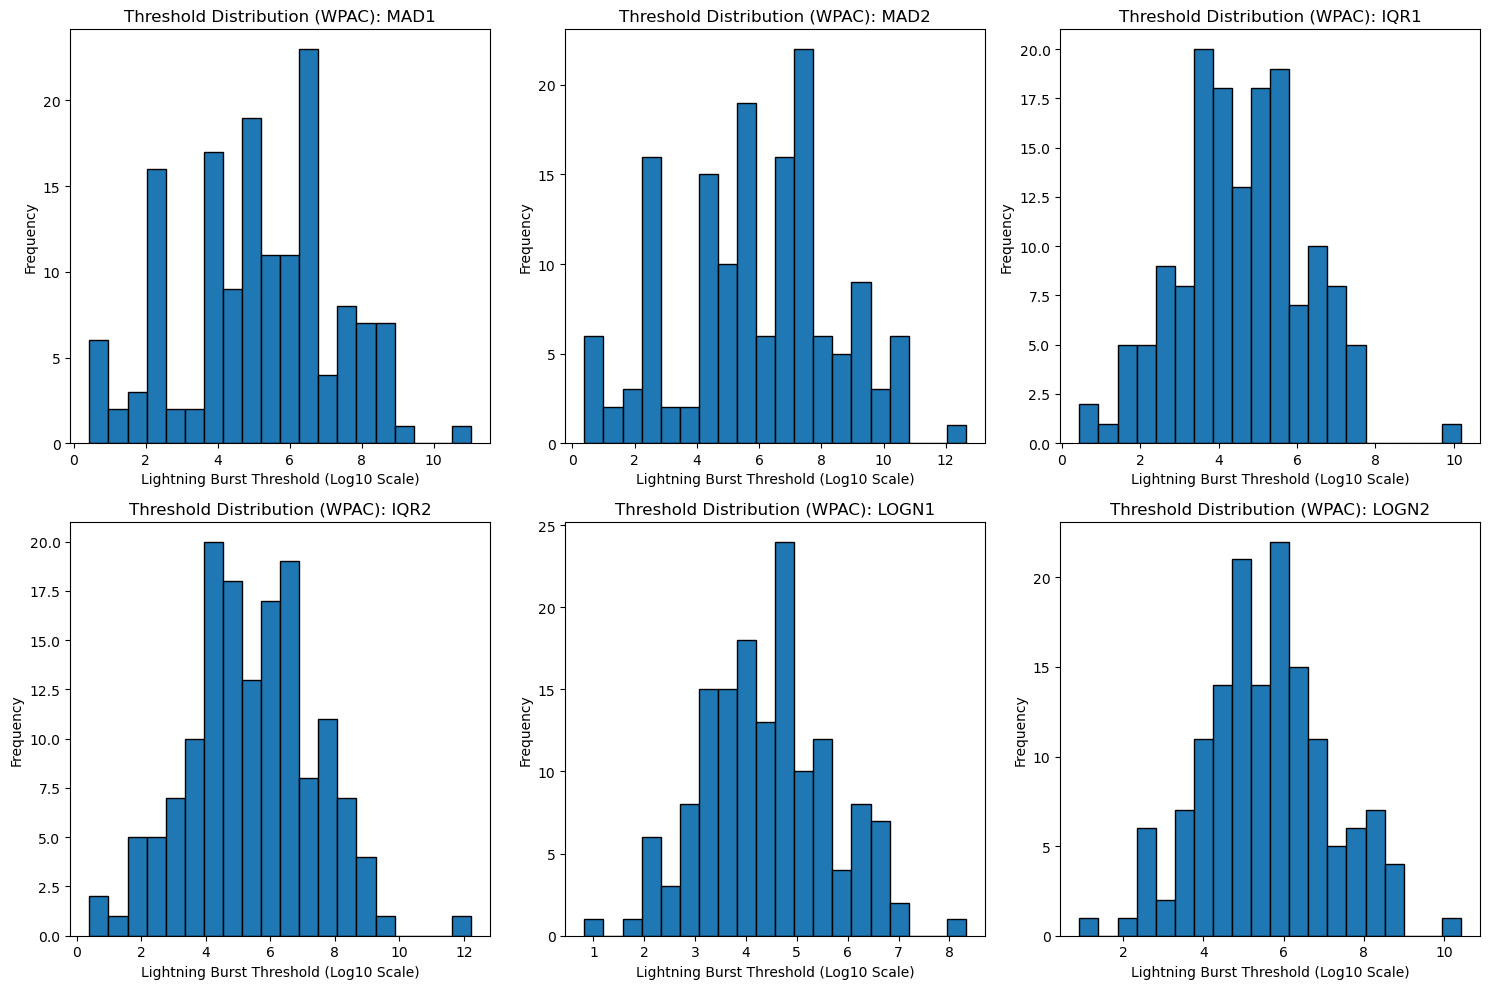

In [174]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(wpac_tc_summary, threshold, ax=axes[i])
    axes[i].set_title(f"Threshold Distribution (WPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

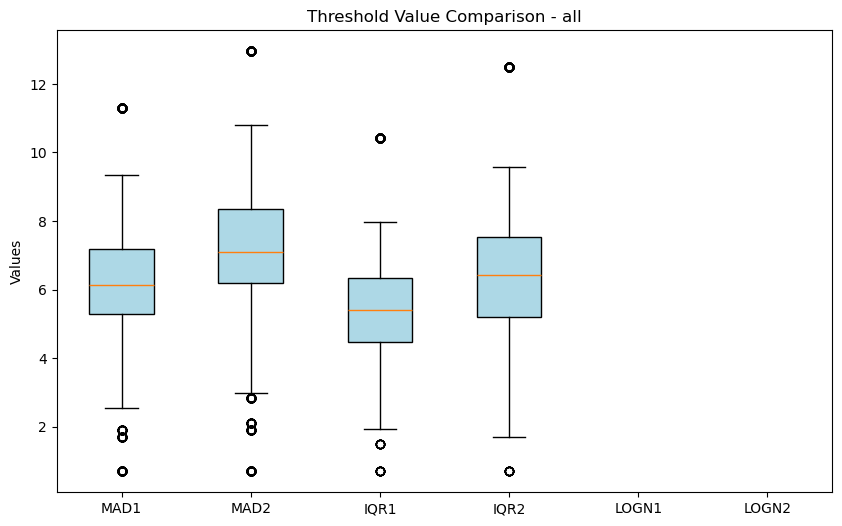

In [ ]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(wpac_bursts, "all", ax=None)

Create a summary for the weaker categories and create an initial basin-category threshold defined as 2 standard deviations + the mean or median.

In [289]:
# Group the data into weak and strong category datasets using function
wpac_weak0_lightning, wpac_weak1_lightning, wpac_strong_lightning = group_bins_category(wpac_bursts)

7307 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
4020 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
4699 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


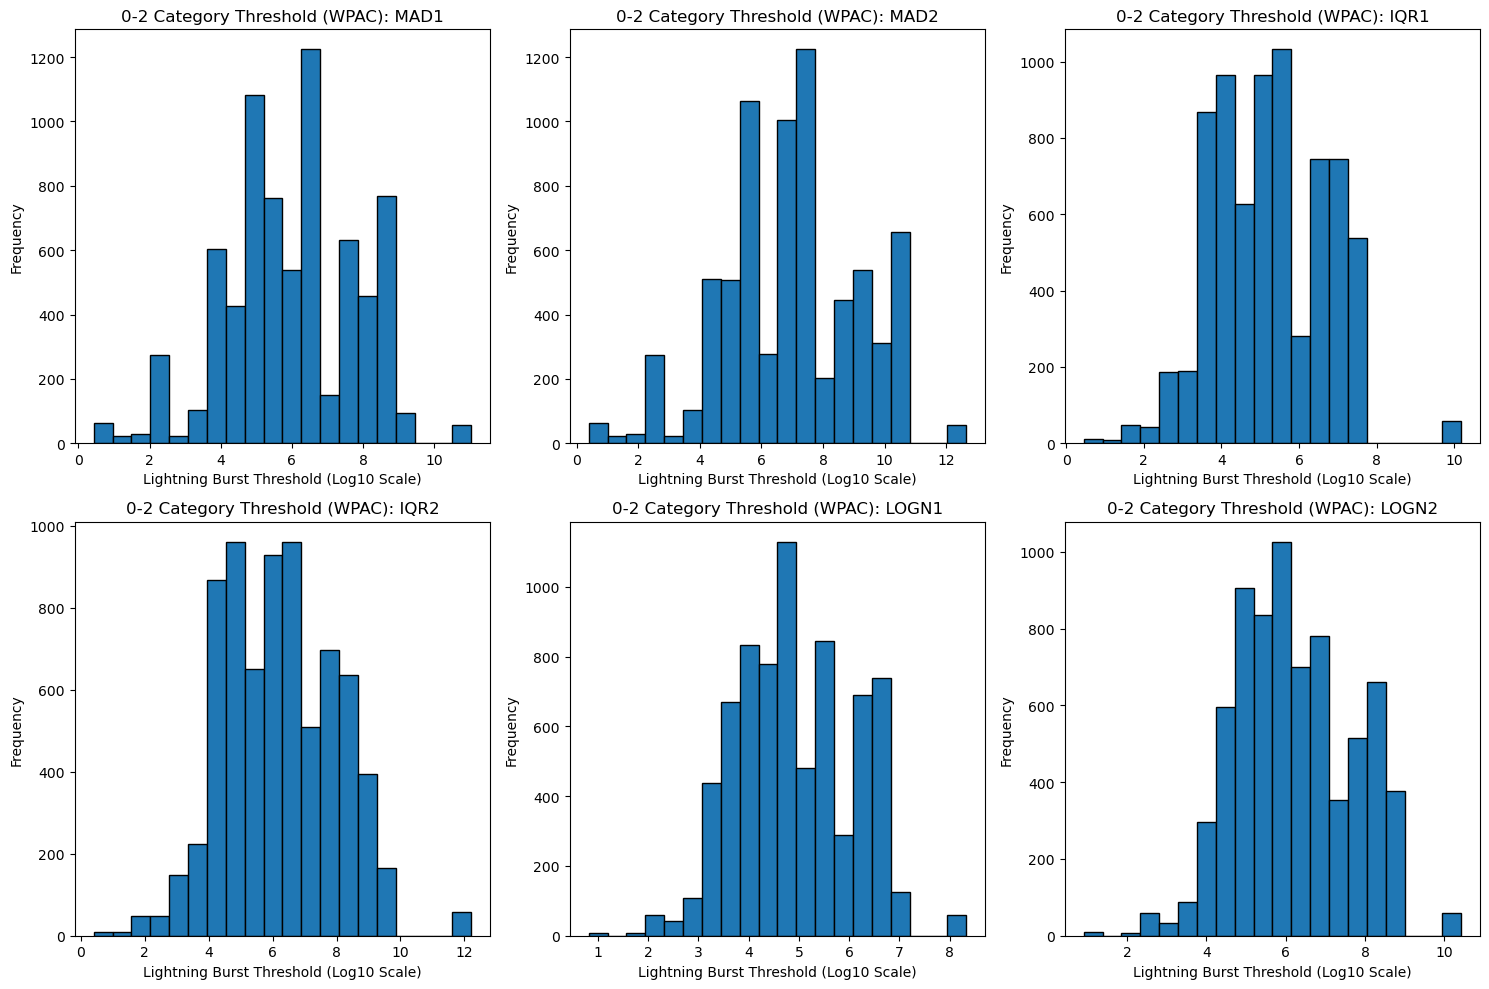

In [178]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(wpac_weak0_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Threshold (WPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

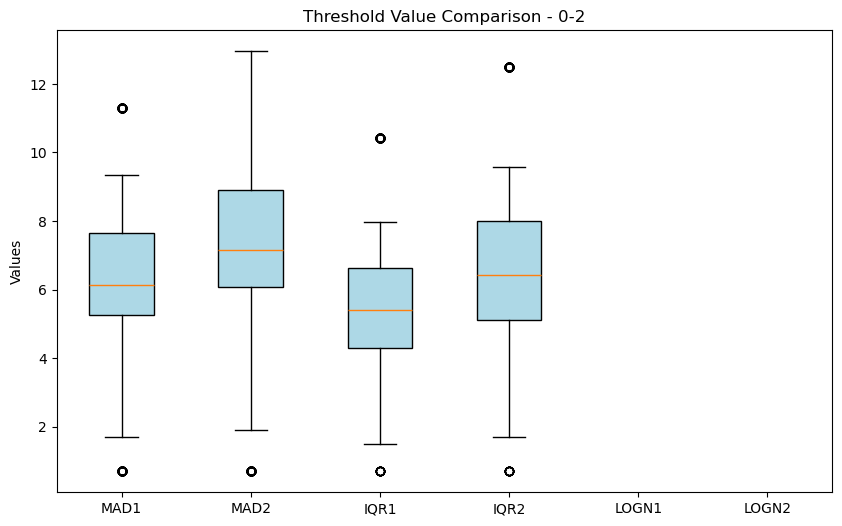

In [179]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(wpac_weak0_lightning, "0-2", ax=None)

In [180]:
# Create basin summary for 0-2 category group
wpac_weak0_summary = create_basin_summary(wpac_weak0_lightning, "0-2", "WPAC")
wpac_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            0-2      mad1  6.283197  1.839124  6.120542  0.693147   
1  WPAC            0-2      mad2  7.292880  2.145611  7.141925  0.693147   
2  WPAC            0-2      iqr1  5.479201  1.463539  5.416100  0.693147   
3  WPAC            0-2      iqr2  6.522259  1.759916  6.423552  0.693147   
4  WPAC            0-2     logn1  5.107833  1.163845  5.009504  1.008509   
5  WPAC            0-2     logn2  6.446268  1.468313  6.300064  1.143664   

         Max  Burst Count  Timebin Count  Burst Percentage  
0  11.302806          135           7307              1.85  
1  12.955115           68           7307              0.93  
2  10.421219          210           7307              2.87  
3  12.506663           61           7307              0.83  
4   8.512225          251           7307              3.44  
5  10.659483           10           7307              0.14

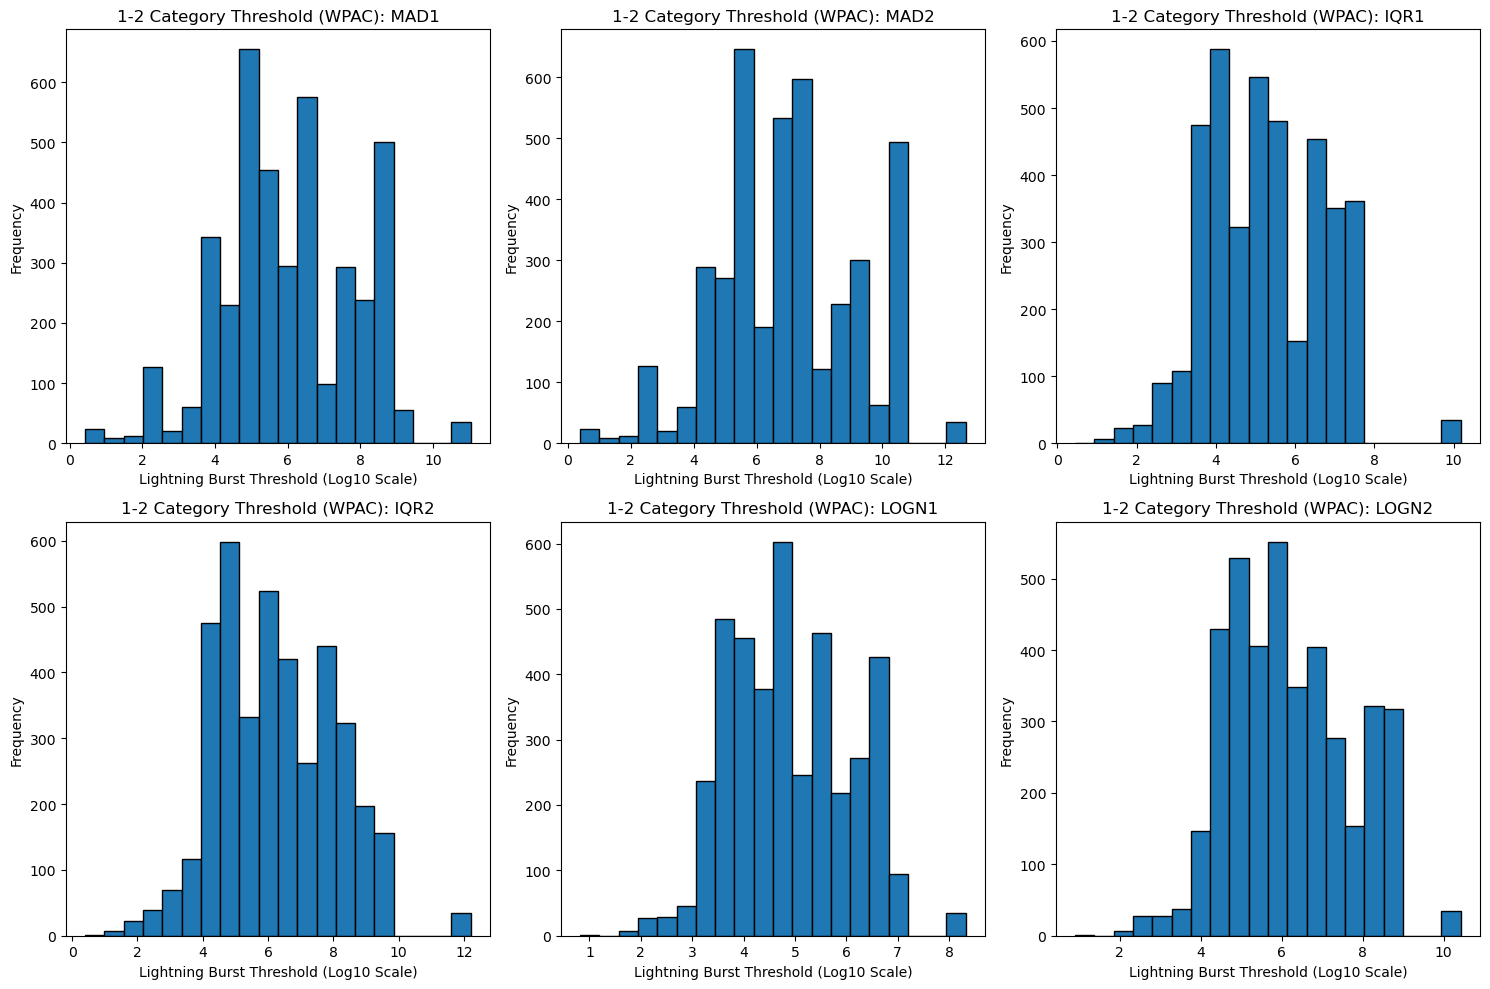

In [181]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(wpac_weak1_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Threshold (WPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

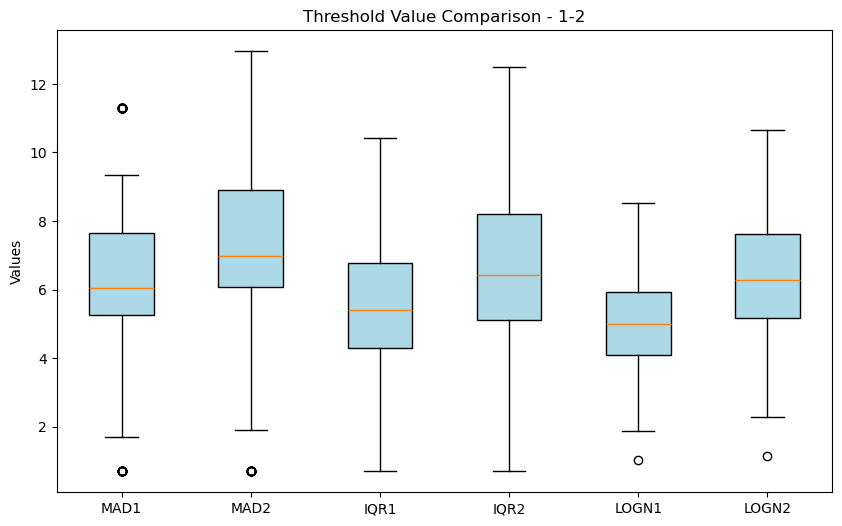

In [182]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(wpac_weak1_lightning, "1-2", ax=None)

In [183]:
# Create basin summary for 1-2 category group
wpac_weak1_summary = create_basin_summary(wpac_weak1_lightning, "1-2", "WPAC")
wpac_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            1-2      mad1  6.327345  1.841147  6.041101  0.693147   
1  WPAC            1-2      mad2  7.344785  2.149250  6.983588  0.693147   
2  WPAC            1-2      iqr1  5.495006  1.496275  5.416100  0.693147   
3  WPAC            1-2      iqr2  6.538750  1.800045  6.423552  0.693147   
4  WPAC            1-2     logn1  5.102825  1.187806  4.987400  1.008509   
5  WPAC            1-2     logn2  6.435607  1.499676  6.290301  1.143664   

         Max  Burst Count  Timebin Count  Burst Percentage  
0  11.302806           52           4020              1.29  
1  12.955115           26           4020              0.65  
2  10.421219           81           4020              2.01  
3  12.506663           23           4020              0.57  
4   8.512225          113           4020              2.81  
5  10.659483            5           4020              0.12

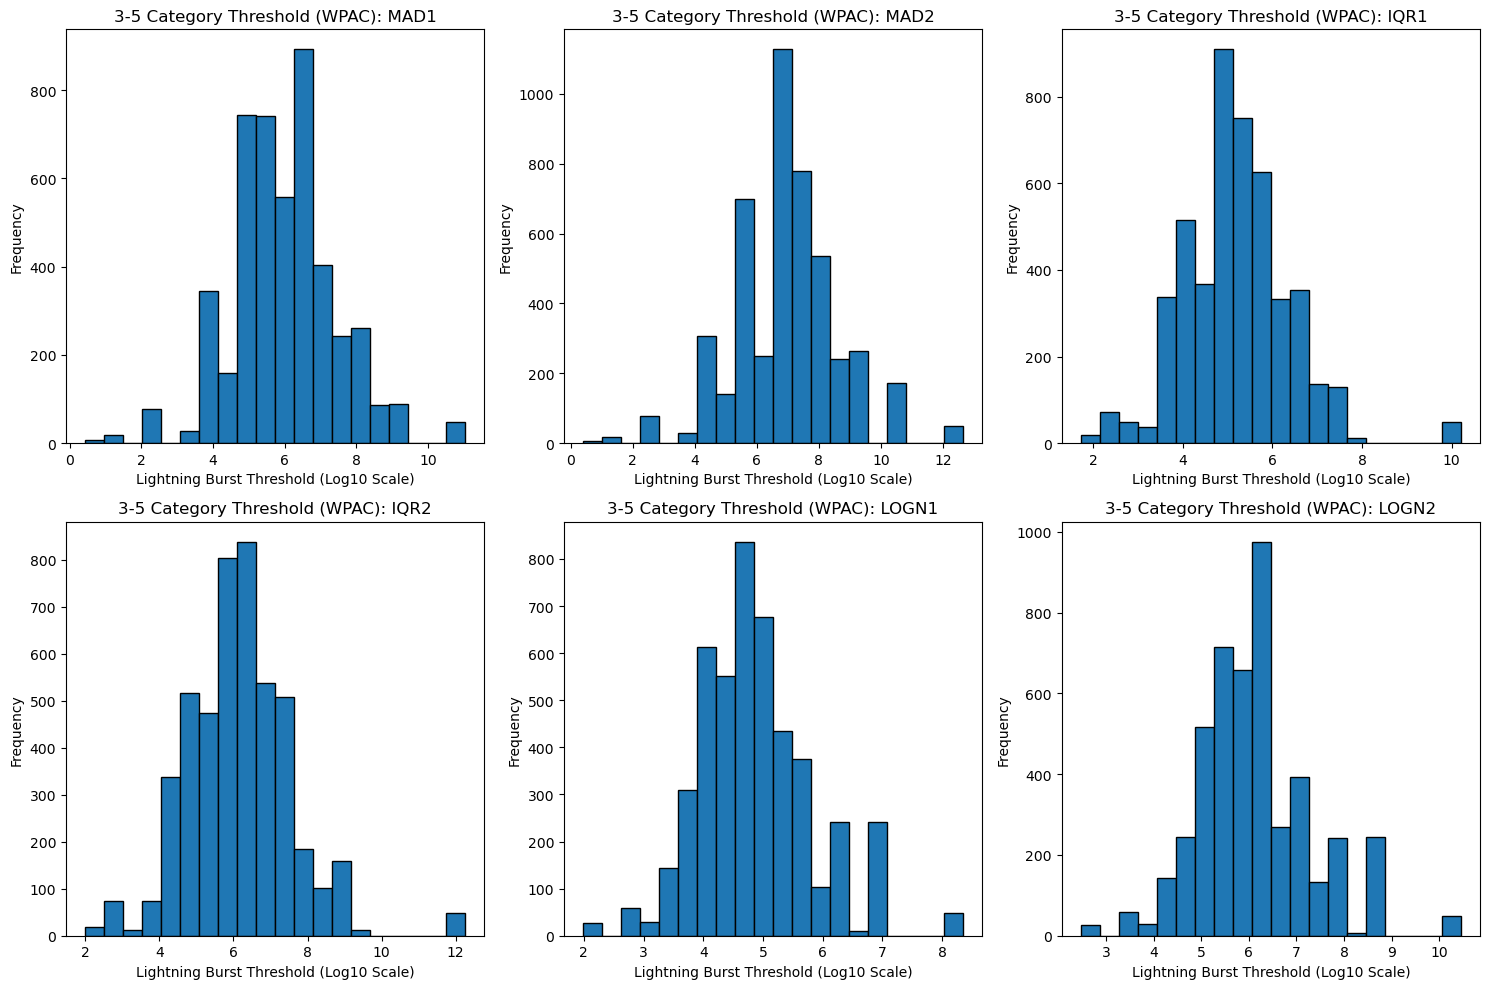

In [184]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(wpac_strong_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Threshold (WPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

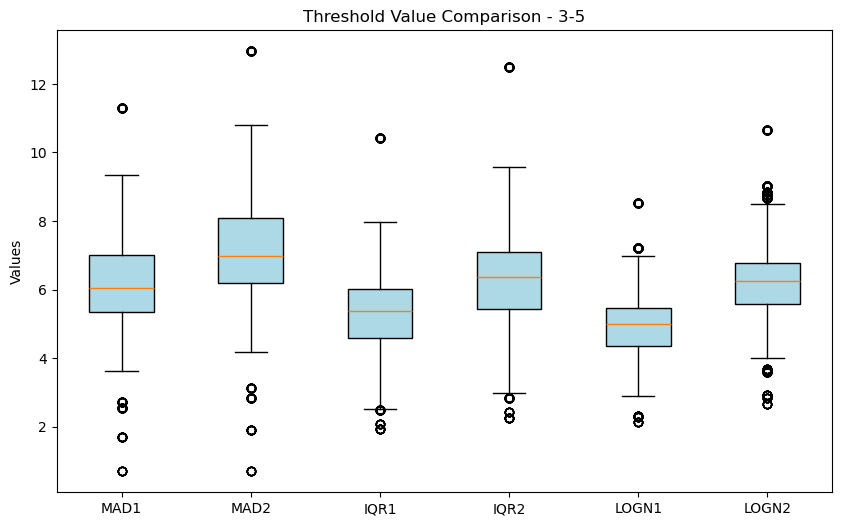

In [185]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(wpac_strong_lightning, "3-5", ax=None)

In [186]:
# Create basin summary for 3-5 category group
wpac_strong_summary = create_basin_summary(wpac_strong_lightning, "3-5", "WPAC")
wpac_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            3-5      mad1  6.294824  1.453543  6.041101  0.693147   
1  WPAC            3-5      mad2  7.269432  1.668656  6.983588  0.693147   
2  WPAC            3-5      iqr1  5.379036  1.196913  5.365248  1.935601   
3  WPAC            3-5      iqr2  6.368476  1.424711  6.359987  2.246214   
4  WPAC            3-5     logn1  5.030119  0.956564  4.979083  2.141959   
5  WPAC            3-5     logn2  6.305512  1.185882  6.247248  2.670544   

         Max  Burst Count  Timebin Count  Burst Percentage  
0  11.302806           16           4699              0.34  
1  12.955115           10           4699              0.21  
2  10.421219           44           4699              0.94  
3  12.506663            8           4699              0.17  
4   8.512225           61           4699              1.30  
5  10.659483            1           4699              0.02

Let's filter the thresholds to just the "effective" thresholds and use these to calculate the basin-category threshold.

In [187]:
# Effective thresholds - WPAC basin
wpac_bursts_effective = filter_effective_thresholds(wpac_bursts)
wpac_storm_codes_effective = wpac_bursts_effective["storm_code"].unique()
wpac_tc_summary_effective = wpac_tc_summary[wpac_tc_summary["storm_code"].isin(wpac_storm_codes_effective)]

wpac_bursts_effective.head()

time_bin  storm_code  lightning_count  year  month  day  \
24680 2010-09-09 15:00:00  WPAC_10_11                6  2010      9    9   
24696 2010-09-17 02:30:00  WPAC_10_12              116  2010      9   17   
24744 2010-09-24 07:00:00  WPAC_10_13               32  2010      9   24   
24751 2010-09-24 22:00:00  WPAC_10_13               17  2010      9   24   
24766 2010-10-14 01:30:00  WPAC_10_15              498  2010     10   14   

       hour  minute   lat    lon  ...  iqr1_threshold  iqr2_threshold  \
24680    15       0  24.3  118.7  ...        1.504077             NaN   
24696     2      30  22.5  128.2  ...             NaN             NaN   
24744     7       0  26.3  141.2  ...        2.644212        3.012632   
24751    22       0  31.1  142.5  ...             NaN             NaN   
24766     1      30  12.2  139.9  ...        5.416100             NaN   

      burst_mad1  burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  \
24680       True       False       1.909543        2.112275         True   
24696      False       False       6.002759             NaN         True   
24744       True        True       2.955327        3.291799         True   
24751      False       False       2.955327             NaN        False   
24766       True       False       5.967748             NaN         True   

       burst_logn2 logn1_threshold logn2_threshold  
24680        False        1.878512             NaN  
24696        False        4.138512             NaN  
24744        False        3.082137             NaN  
24751        False             NaN             NaN  
24766        False        5.042576             NaN  

[5 rows x 34 columns]

In [290]:
print(f"{len(wpac_storm_codes_effective)} TCs of {len(wpac_storm_codes)} WPAC TCs after filtering for bursts of any type")

112 TCs of 146 WPAC TCs after filtering for bursts of any type


In [189]:
wpac_effective_summary = create_basin_summary(wpac_bursts_effective, "all", "WPAC")
wpac_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            all      mad1  4.839430  1.376800  5.010635  0.693147   
1  WPAC            all      mad2  4.605133  1.606280  4.852030  0.693147   
2  WPAC            all      iqr1  3.774528  1.073434  3.701302  0.693147   
3  WPAC            all      iqr2  4.141975  1.300320  3.776883  0.693147   
4  WPAC            all     logn1  4.588643  1.001566  4.519241  1.008509   
5  WPAC            all     logn2  5.181531  0.888831  5.198783  2.913312   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.575529          151            396             38.13  
1  7.101371           78            396             19.70  
2  5.744604          254            396             64.14  
3  7.007469           69            396             17.42  
4  7.221087          312            396             78.79  
5  6.346034           11            396              2.78

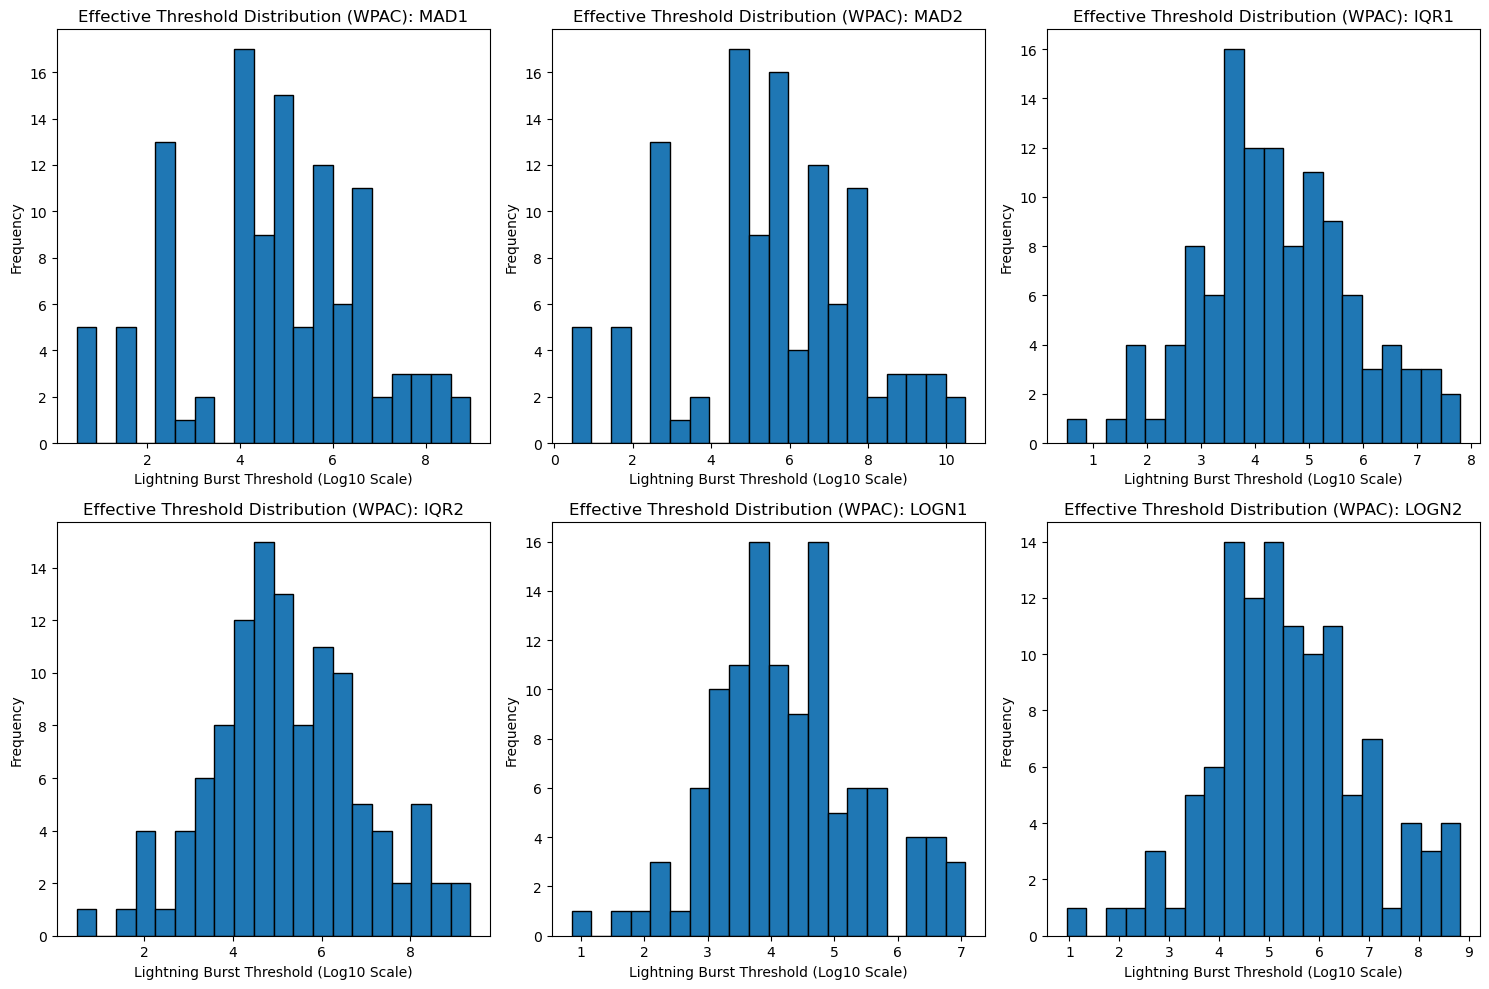

In [190]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(wpac_tc_summary_effective, threshold, ax=axes[i])
    axes[i].set_title(f"Effective Threshold Distribution (WPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [291]:
# Group the data into weak and strong category datasets using function
wpac_weak0_effective_lightning, wpac_weak1_effective_lightning, wpac_strong_effective_lightning = group_bins_category(wpac_bursts_effective)

324 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
139 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
72 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


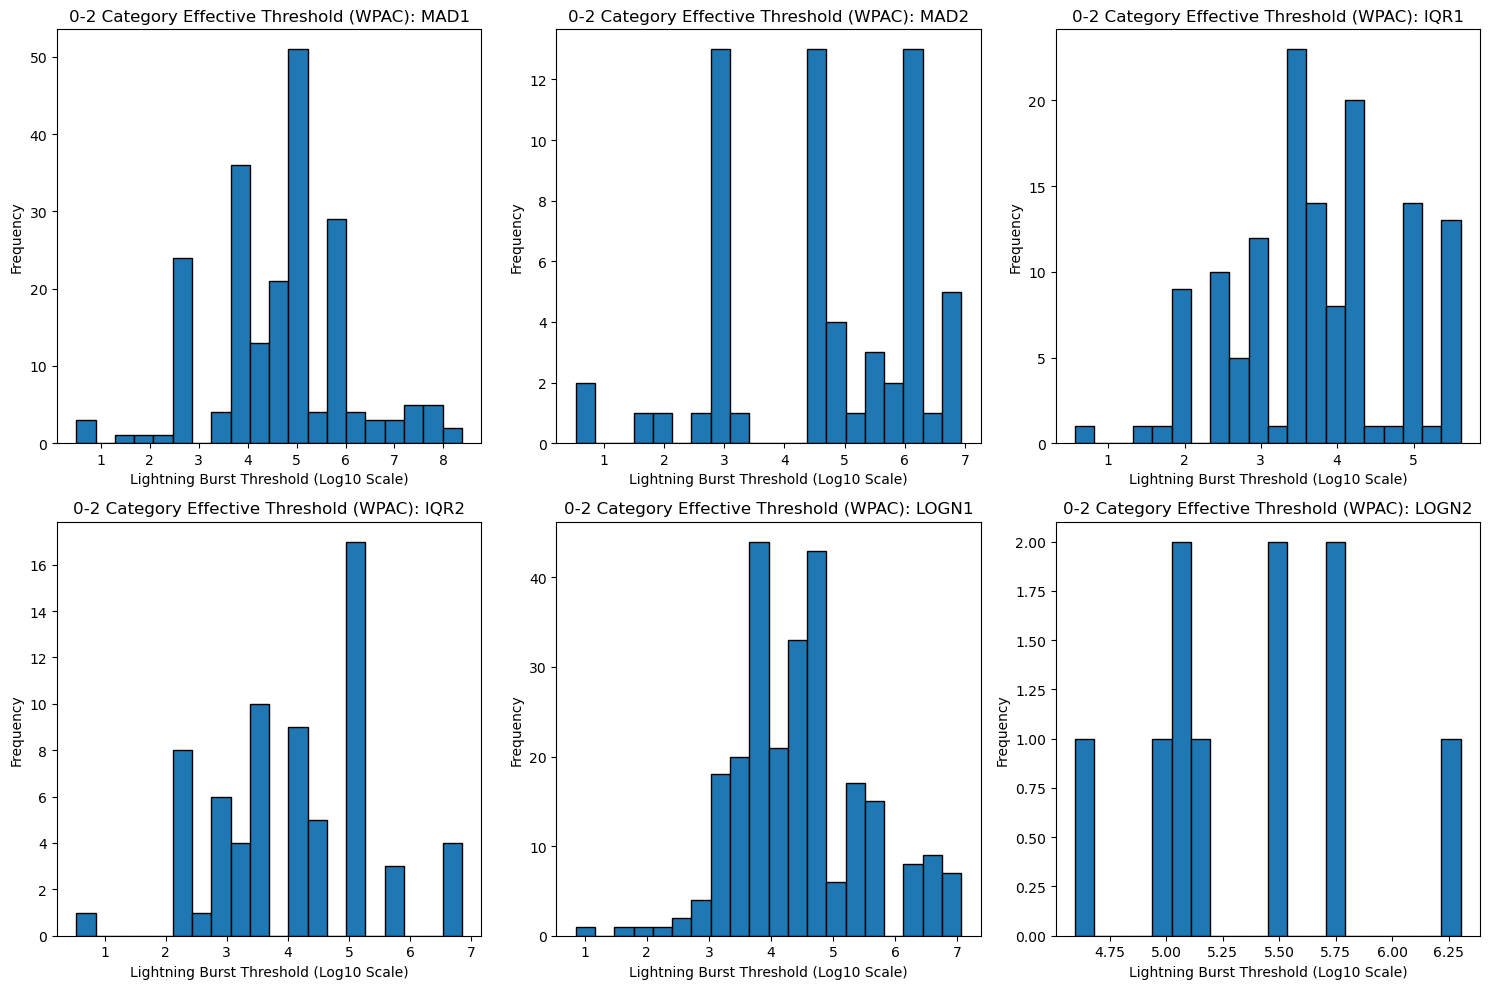

In [192]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(wpac_weak0_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Effective Threshold (WPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [193]:
# Get summary for effective thresholds - 0-2 categories
wpac_weak0_effective_summary = create_basin_summary(wpac_weak0_effective_lightning, "0-2", "WPAC")
wpac_weak0_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            0-2      mad1  4.880592  1.396711  5.111313  0.693147   
1  WPAC            0-2      mad2  4.779877  1.577157  4.852030  0.693147   
2  WPAC            0-2      iqr1  3.867638  1.059264  3.801637  0.693147   
3  WPAC            0-2      iqr2  4.286765  1.313039  4.400080  0.693147   
4  WPAC            0-2     logn1  4.613745  1.038302  4.519241  1.008509   
5  WPAC            0-2     logn2  5.408353  0.498988  5.381630  4.640100   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.575529          135            324             41.67  
1  7.101371           68            324             20.99  
2  5.744604          210            324             64.81  
3  7.007469           61            324             18.83  
4  7.221087          251            324             77.47  
5  6.346034           10            324              3.09

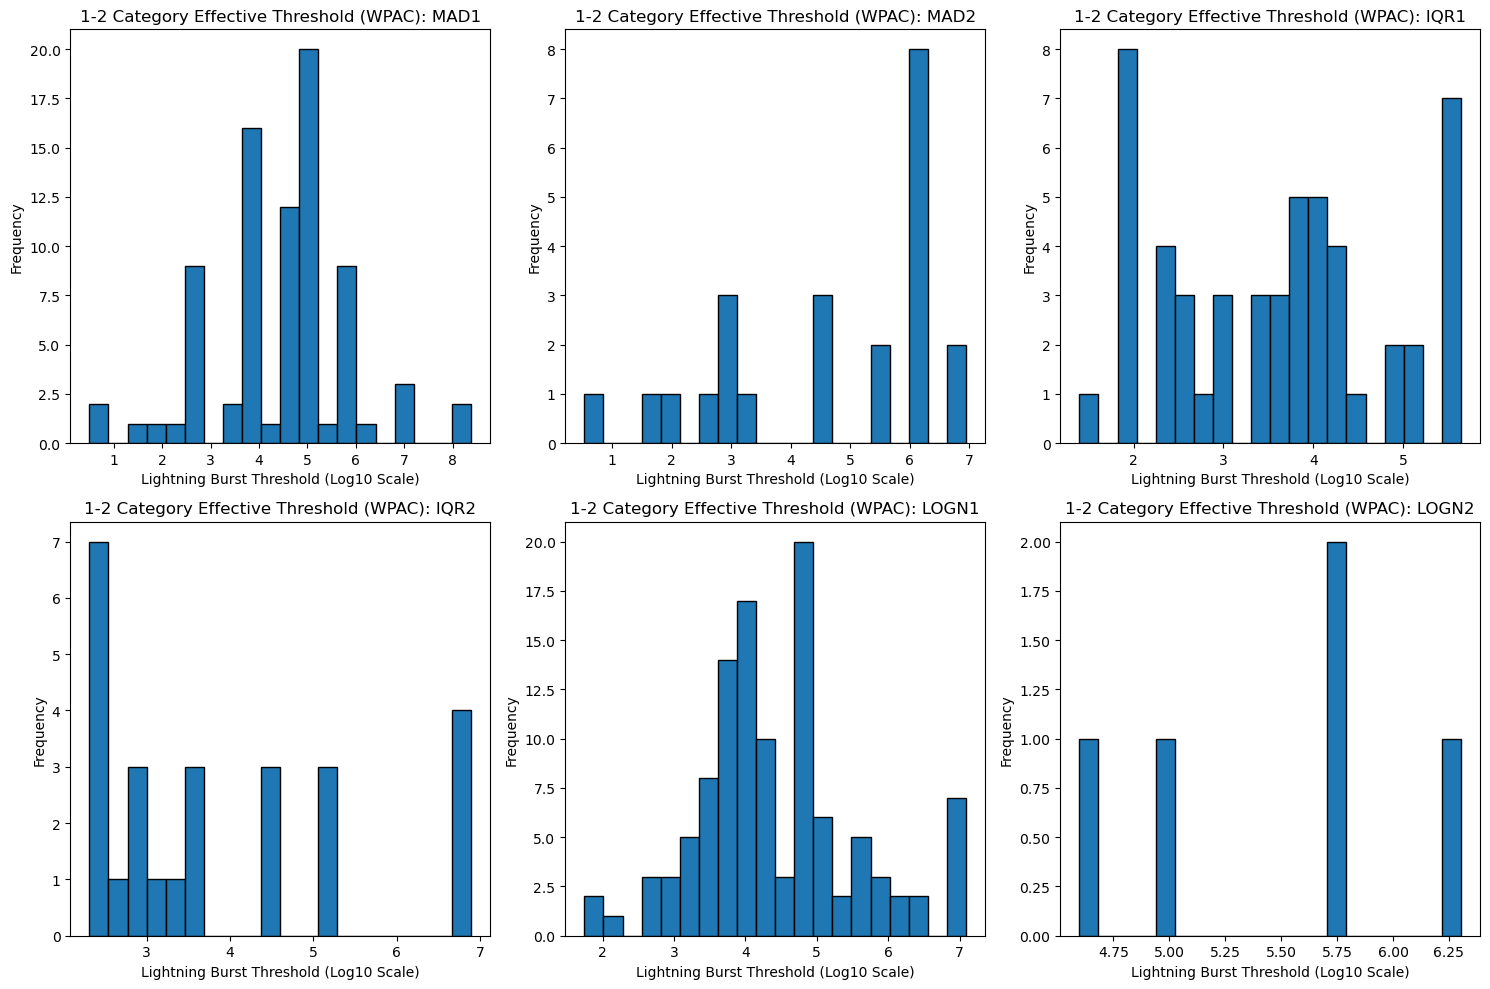

In [194]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(wpac_weak1_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Effective Threshold (WPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [195]:
# Get summary for effective thresholds - 1-2 categories
wpac_weak1_effective_summary = create_basin_summary(wpac_weak1_effective_lightning, "1-2", "WPAC")
wpac_weak1_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            1-2      mad1  4.679539  1.453045  4.949725  0.693147   
1  WPAC            1-2      mad2  4.765161  1.836603  5.551725  0.693147   
2  WPAC            1-2      iqr1  3.713180  1.236216  3.786915  1.504077   
3  WPAC            1-2      iqr2  4.018345  1.619966  3.565097  2.426015   
4  WPAC            1-2     logn1  4.574242  1.091878  4.429469  1.878512   
5  WPAC            1-2     logn2  5.513463  0.687153  5.795458  4.640100   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.575529           52            139             37.41  
1  7.101371           26            139             18.71  
2  5.744604           81            139             58.27  
3  7.007469           23            139             16.55  
4  7.221087          113            139             81.29  
5  6.346034            5            139              3.60

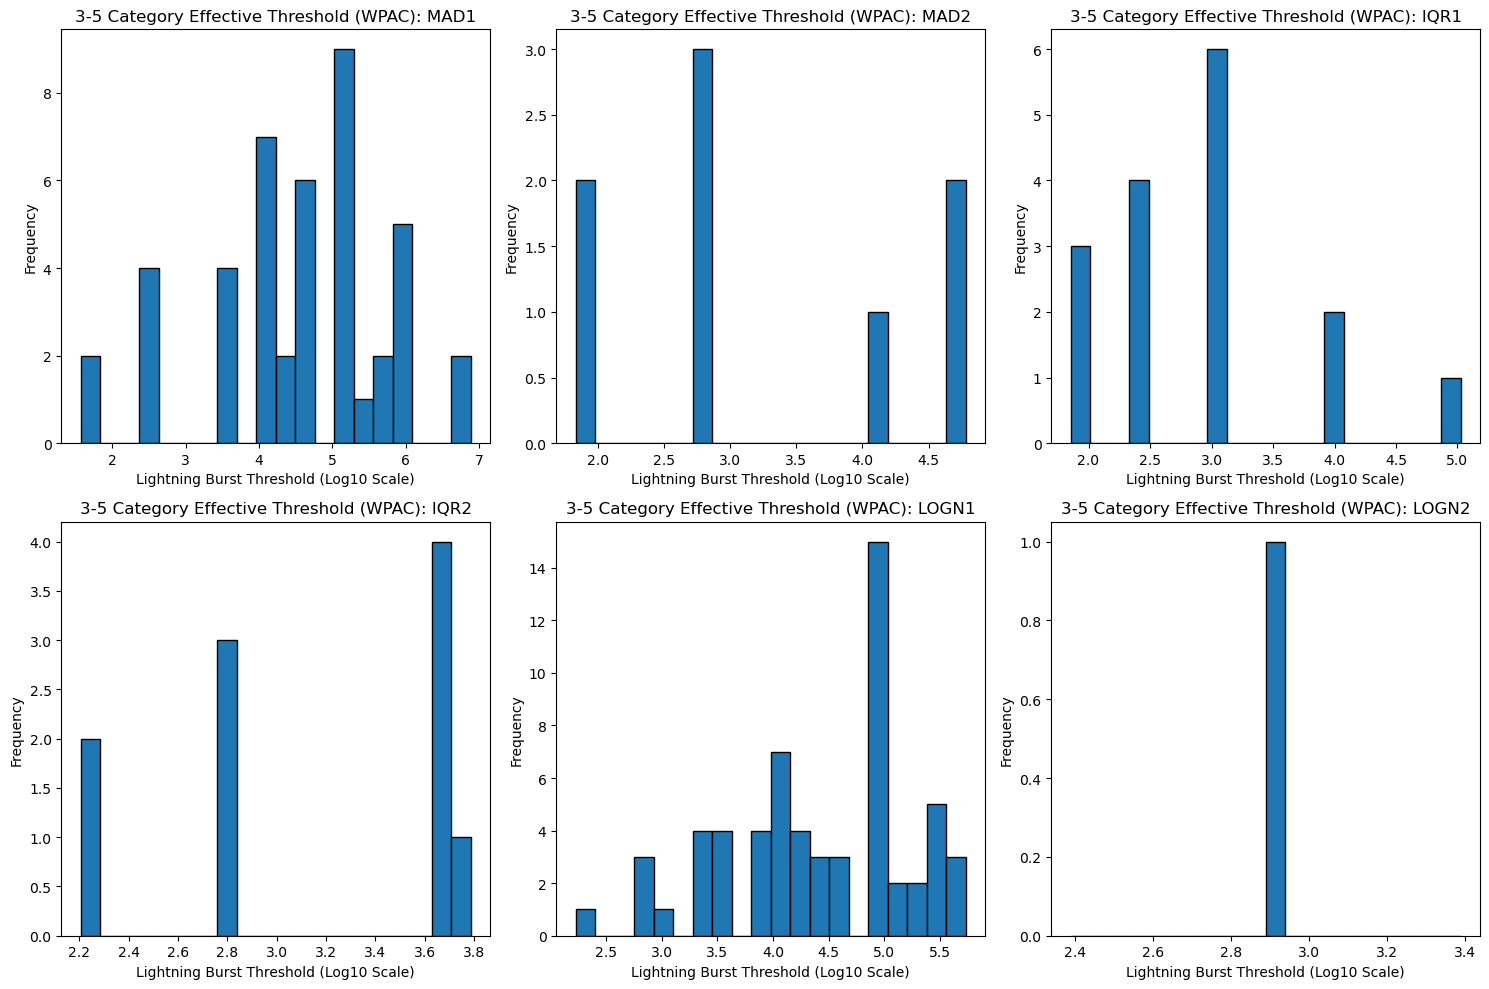

In [196]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(wpac_strong_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Effective Threshold (WPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [197]:
# Get summary for effective thresholds - 3-5 categories
wpac_strong_effective_summary = create_basin_summary(wpac_strong_effective_lightning, "3-5", "WPAC")
wpac_strong_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            3-5      mad1  4.642974  1.274159  4.763267  1.706810   
1  WPAC            3-5      mad2  3.272704  1.203460  2.824705  1.909543   
2  WPAC            3-5      iqr1  2.988916  0.873329  3.091042  1.935601   
3  WPAC            3-5      iqr2  3.157399  0.629092  3.260998  2.246214   
4  WPAC            3-5     logn1  4.485351  0.833144  4.572814  2.315777   
5  WPAC            3-5     logn2  2.913312       NaN  2.913312  2.913312   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  7.012608           16             72             22.22  
1  4.852030           10             72             13.89  
2  5.103923           44             72             61.11  
3  3.825055            8             72             11.11  
4  5.818266           61             72             84.72  
5  2.913312            1             72              1.39

Let's calculate and apply the basin-level effective threshold. We'll try both 1.5 SD and 2 SD from the mean and median of the effective thresholds for each category group.

Start with the 0-2 category grouping.

In [198]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
wpac_weak0_effective_thresholds = calculate_basin_thresholds(wpac_weak0_effective_lightning, "0-2", "WPAC", threshold_type="effective")
wpac_weak0_effective_thresholds_1_5sd = calculate_basin_thresholds(wpac_weak0_effective_lightning, "0-2", "WPAC", std_dev=1.5, threshold_type="effective")

In [199]:
# 0-2 categories, 2 SD
wpac_weak0_summary_2sd, wpac_weak0_eff_bursts_mean, wpac_weak0_eff_summary_mean, wpac_weak0_eff_bursts_median, wpac_weak0_eff_summary_median = summarize_threshold_eval(wpac_weak0_summary, wpac_weak0_lightning, wpac_weak0_effective_thresholds, threshold_type="effective")
wpac_weak0_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            0-2      mad1  6.283197  1.839124  6.120542  0.693147   
1  WPAC            0-2      mad2  7.292880  2.145611  7.141925  0.693147   
2  WPAC            0-2      iqr1  5.479201  1.463539  5.416100  0.693147   
3  WPAC            0-2      iqr2  6.522259  1.759916  6.423552  0.693147   
4  WPAC            0-2     logn1  5.107833  1.163845  5.009504  1.008509   
5  WPAC            0-2     logn2  6.446268  1.468313  6.300064  1.143664   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  11.302806          135           7307              1.85   
1  12.955115           68           7307              0.93   
2  10.421219          210           7307              2.87   
3  12.506663           61           7307              0.83   
4   8.512225          251           7307              3.44   
5  10.659483           10           7307              0.14   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           7.674015      
1                                           7.934191      
2                                           5.986165      
3                                           6.912843      
4                                           6.690350      
5                                           6.406329      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           7.904736        
1                                           8.006344        
2                                           5.920165        
3                                           7.026158        
4                                           6.595845        
5                                           6.379606        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  0             
2                                                163             
3                                                 18             
4                                                 30             
5                                                 79             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.00                       
2                                               2.23                       
3                                               0.25                       
4                                               0.41                       
5                                               1.08                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                  0               
2                                                176               
3                                                 17               
4                                                 41               
5                                                 87               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.00                        
1                                               0.00                        
2                                               2.41                        
3                                               0.23                        
4                                               0.56                        
5                                               1.19

In [200]:
# 0-2 categories, 1.5 SD
wpac_weak0_summary_1_5sd, wpac_weak0_eff_bursts_mean_1_5, wpac_weak0_eff_summary_mean_1_5, wpac_weak0_eff_bursts_median_1_5, wpac_weak0_eff_summary_median_1_5 = summarize_threshold_eval(wpac_weak0_summary, wpac_weak0_lightning, wpac_weak0_effective_thresholds_1_5sd, threshold_type="effective")
wpac_weak0_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            0-2      mad1  6.283197  1.839124  6.120542  0.693147   
1  WPAC            0-2      mad2  7.292880  2.145611  7.141925  0.693147   
2  WPAC            0-2      iqr1  5.479201  1.463539  5.416100  0.693147   
3  WPAC            0-2      iqr2  6.522259  1.759916  6.423552  0.693147   
4  WPAC            0-2     logn1  5.107833  1.163845  5.009504  1.008509   
5  WPAC            0-2     logn2  6.446268  1.468313  6.300064  1.143664   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  11.302806          135           7307              1.85   
1  12.955115           68           7307              0.93   
2  10.421219          210           7307              2.87   
3  12.506663           61           7307              0.83   
4   8.512225          251           7307              3.44   
5  10.659483           10           7307              0.14   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.975659        
1                                           7.145612        
2                                           5.456533        
3                                           6.256323        
4                                           6.171199        
5                                           6.156835        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           7.206380          
1                                           7.217766          
2                                           5.390533          
3                                           6.369638          
4                                           6.076694          
5                                           6.130112          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 18               
1                                                 12               
2                                                342               
3                                                111               
4                                                125               
5                                                128               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.25                         
1                                               0.16                         
2                                               4.68                         
3                                               1.52                         
4                                               1.71                         
5                                               1.75                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                  9                 
1                                                  9                 
2                                                376                 
3                                                 88                 
4                                                143                 
5                                                134                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               0.12                          
1                                               0.12                          
2                                               5.15                          
3                                               1.20                          
4                                               1.96                          
5                                               1.83

In [201]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = wpac_weak0_summary_1_5sd.columns[-6: ].to_list()
keep.append(wpac_weak0_summary_1_5sd.columns[2])
wpac_weak0_summary = pd.merge(wpac_weak0_summary_2sd, wpac_weak0_summary_1_5sd[keep], on="Threshold")
wpac_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            0-2      mad1  6.283197  1.839124  6.120542  0.693147   
1  WPAC            0-2      mad2  7.292880  2.145611  7.141925  0.693147   
2  WPAC            0-2      iqr1  5.479201  1.463539  5.416100  0.693147   
3  WPAC            0-2      iqr2  6.522259  1.759916  6.423552  0.693147   
4  WPAC            0-2     logn1  5.107833  1.163845  5.009504  1.008509   
5  WPAC            0-2     logn2  6.446268  1.468313  6.300064  1.143664   

         Max  Burst Count  Timebin Count  ...  \
0  11.302806          135           7307  ...   
1  12.955115           68           7307  ...   
2  10.421219          210           7307  ...   
3  12.506663           61           7307  ...   
4   8.512225          251           7307  ...   
5  10.659483           10           7307  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  0             
2                                                163             
3                                                 18             
4                                                 30             
5                                                 79             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.00                       
2                                               2.23                       
3                                               0.25                       
4                                               0.41                       
5                                               1.08                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                  0               
2                                                176               
3                                                 17               
4                                                 41               
5                                                 87               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.00                         
1                                               0.00                         
2                                               2.41                         
3                                               0.23                         
4                                               0.56                         
5                                               1.19                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.975659        
1                                           7.145612        
2                                           5.456533        
3                                           6.256323        
4                                           6.171199        
5                                           6.156835        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           7.206380          
1                                           7.217766          
2                                           5.390533          
3                                           6.369638          
4                                           6.076694          
5                                           6.130112          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 18               
1                                                 12               
2                              

Let's do the same for the other 2 category groupings.

1-2 categories:

In [202]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
wpac_weak1_effective_thresholds = calculate_basin_thresholds(wpac_weak1_effective_lightning, "1-2", "WPAC", threshold_type="effective")
wpac_weak1_effective_thresholds_1_5sd = calculate_basin_thresholds(wpac_weak1_effective_lightning, "1-2", "WPAC", std_dev=1.5, threshold_type="effective")

In [203]:
# 1-2 categories, 2 SD
wpac_weak1_summary_2sd, wpac_weak1_eff_bursts_mean, wpac_weak1_eff_summary_mean, wpac_weak1_eff_bursts_median, wpac_weak1_eff_summary_median = summarize_threshold_eval(wpac_weak1_summary, wpac_weak1_lightning, wpac_weak1_effective_thresholds, threshold_type="effective")
wpac_weak1_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            1-2      mad1  6.327345  1.841147  6.041101  0.693147   
1  WPAC            1-2      mad2  7.344785  2.149250  6.983588  0.693147   
2  WPAC            1-2      iqr1  5.495006  1.496275  5.416100  0.693147   
3  WPAC            1-2      iqr2  6.538750  1.800045  6.423552  0.693147   
4  WPAC            1-2     logn1  5.102825  1.187806  4.987400  1.008509   
5  WPAC            1-2     logn2  6.435607  1.499676  6.290301  1.143664   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  11.302806           52           4020              1.29   
1  12.955115           26           4020              0.65   
2  10.421219           81           4020              2.01   
3  12.506663           23           4020              0.57   
4   8.512225          113           4020              2.81   
5  10.659483            5           4020              0.12   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           7.585629      
1                                           8.438366      
2                                           6.185612      
3                                           7.258278      
4                                           6.757998      
5                                           6.887769      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           7.855816        
1                                           9.224930        
2                                           6.259347        
3                                           6.805030        
4                                           6.613225        
5                                           7.169764        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  0             
2                                                 72             
3                                                  3             
4                                                 16             
5                                                 10             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.00                       
2                                               1.79                       
3                                               0.07                       
4                                               0.40                       
5                                               0.25                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                  0               
2                                                 65               
3                                                 14               
4                                                 24               
5                                                  4               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.00                        
1                                               0.00                        
2                                               1.62                        
3                                               0.35                        
4                                               0.60                        
5                                               0.10

In [204]:
# 1-2 categories, 1.5 SD
wpac_weak1_summary_1_5sd, wpac_weak1_eff_bursts_mean_1_5, wpac_weak1_eff_summary_mean_1_5, wpac_weak1_eff_bursts_median_1_5, wpac_weak1_eff_summary_median_1_5 = summarize_threshold_eval(wpac_weak1_summary, wpac_weak1_lightning, wpac_weak1_effective_thresholds_1_5sd, threshold_type="effective")
wpac_weak1_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            1-2      mad1  6.327345  1.841147  6.041101  0.693147   
1  WPAC            1-2      mad2  7.344785  2.149250  6.983588  0.693147   
2  WPAC            1-2      iqr1  5.495006  1.496275  5.416100  0.693147   
3  WPAC            1-2      iqr2  6.538750  1.800045  6.423552  0.693147   
4  WPAC            1-2     logn1  5.102825  1.187806  4.987400  1.008509   
5  WPAC            1-2     logn2  6.435607  1.499676  6.290301  1.143664   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  11.302806           52           4020              1.29   
1  12.955115           26           4020              0.65   
2  10.421219           81           4020              2.01   
3  12.506663           23           4020              0.57   
4   8.512225          113           4020              2.81   
5  10.659483            5           4020              0.12   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.859107        
1                                           7.520065        
2                                           5.567504        
3                                           6.448295        
4                                           6.212059        
5                                           6.544192        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           7.129293          
1                                           8.306629          
2                                           5.641239          
3                                           5.995047          
4                                           6.067286          
5                                           6.826187          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 11               
1                                                  0               
2                                                151               
3                                                 42               
4                                                 69               
5                                                 30               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.27                         
1                                               0.00                         
2                                               3.76                         
3                                               1.04                         
4                                               1.72                         
5                                               0.75                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                  4                 
1                                                  0                 
2                                                135                 
3                                                 91                 
4                                                 82                 
5                                                 13                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               0.10                          
1                                               0.00                          
2                                               3.36                          
3                                               2.26                          
4                                               2.04                          
5                                               0.32

In [205]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = wpac_weak1_summary_1_5sd.columns[-6: ].to_list()
keep.append(wpac_weak1_summary_1_5sd.columns[2])
wpac_weak1_summary = pd.merge(wpac_weak1_summary_2sd, wpac_weak1_summary_1_5sd[keep], on="Threshold")
wpac_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            1-2      mad1  6.327345  1.841147  6.041101  0.693147   
1  WPAC            1-2      mad2  7.344785  2.149250  6.983588  0.693147   
2  WPAC            1-2      iqr1  5.495006  1.496275  5.416100  0.693147   
3  WPAC            1-2      iqr2  6.538750  1.800045  6.423552  0.693147   
4  WPAC            1-2     logn1  5.102825  1.187806  4.987400  1.008509   
5  WPAC            1-2     logn2  6.435607  1.499676  6.290301  1.143664   

         Max  Burst Count  Timebin Count  ...  \
0  11.302806           52           4020  ...   
1  12.955115           26           4020  ...   
2  10.421219           81           4020  ...   
3  12.506663           23           4020  ...   
4   8.512225          113           4020  ...   
5  10.659483            5           4020  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  0             
2                                                 72             
3                                                  3             
4                                                 16             
5                                                 10             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.00                       
2                                               1.79                       
3                                               0.07                       
4                                               0.40                       
5                                               0.25                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                  0               
2                                                 65               
3                                                 14               
4                                                 24               
5                                                  4               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.00                         
1                                               0.00                         
2                                               1.62                         
3                                               0.35                         
4                                               0.60                         
5                                               0.10                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.859107        
1                                           7.520065        
2                                           5.567504        
3                                           6.448295        
4                                           6.212059        
5                                           6.544192        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           7.129293          
1                                           8.306629          
2                                           5.641239          
3                                           5.995047          
4                                           6.067286          
5                                           6.826187          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 11               
1                                                  0               
2                              

Do the same for the stronger category group (3-5).

In [206]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
wpac_strong_effective_thresholds = calculate_basin_thresholds(wpac_strong_effective_lightning, "3-5", "WPAC", threshold_type="effective")
wpac_strong_effective_thresholds_1_5sd = calculate_basin_thresholds(wpac_strong_effective_lightning, "3-5", "WPAC", std_dev=1.5, threshold_type="effective")

In [207]:
# 3-5 categories, 2 SD
wpac_strong_summary_2sd, wpac_strong_eff_bursts_mean, wpac_strong_eff_summary_mean, wpac_strong_eff_bursts_median, wpac_strong_eff_summary_median = summarize_threshold_eval(wpac_strong_summary, wpac_strong_lightning, wpac_strong_effective_thresholds, threshold_type="effective")
wpac_strong_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            3-5      mad1  6.294824  1.453543  6.041101  0.693147   
1  WPAC            3-5      mad2  7.269432  1.668656  6.983588  0.693147   
2  WPAC            3-5      iqr1  5.379036  1.196913  5.365248  1.935601   
3  WPAC            3-5      iqr2  6.368476  1.424711  6.359987  2.246214   
4  WPAC            3-5     logn1  5.030119  0.956564  4.979083  2.141959   
5  WPAC            3-5     logn2  6.305512  1.185882  6.247248  2.670544   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  11.302806           16           4699              0.34   
1  12.955115           10           4699              0.21   
2  10.421219           44           4699              0.94   
3  12.506663            8           4699              0.17   
4   8.512225           61           4699              1.30   
5  10.659483            1           4699              0.02   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           7.191292      
1                                           5.679624      
2                                           4.735573      
3                                           4.415582      
4                                           6.151639      
5                                                NaN      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           7.311586        
1                                           5.231625        
2                                           4.837700        
3                                           4.519181        
4                                           6.239103        
5                                                NaN        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                 57             
2                                                255             
3                                                403             
4                                                 28             
5                                                  0             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               1.21                       
2                                               5.43                       
3                                               8.58                       
4                                               0.60                       
5                                               0.00                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                117               
2                                                209               
3                                                349               
4                                                 26               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.00                        
1                                               2.49                        
2                                               4.45                        
3                                               7.43                        
4                                               0.55                        
5                                               0.00

In [208]:
# 3-5 categories, 1.5 SD
wpac_strong_summary_1_5sd, wpac_strong_eff_bursts_mean_1_5, wpac_strong_eff_summary_mean_1_5, wpac_strong_eff_bursts_median_1_5, wpac_strong_eff_summary_median_1_5 = summarize_threshold_eval(wpac_strong_summary, wpac_strong_lightning, wpac_strong_effective_thresholds_1_5sd, threshold_type="effective")
wpac_strong_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            3-5      mad1  6.294824  1.453543  6.041101  0.693147   
1  WPAC            3-5      mad2  7.269432  1.668656  6.983588  0.693147   
2  WPAC            3-5      iqr1  5.379036  1.196913  5.365248  1.935601   
3  WPAC            3-5      iqr2  6.368476  1.424711  6.359987  2.246214   
4  WPAC            3-5     logn1  5.030119  0.956564  4.979083  2.141959   
5  WPAC            3-5     logn2  6.305512  1.185882  6.247248  2.670544   

         Max  Burst Count  Timebin Count  Burst Percentage  \
0  11.302806           16           4699              0.34   
1  12.955115           10           4699              0.21   
2  10.421219           44           4699              0.94   
3  12.506663            8           4699              0.17   
4   8.512225           61           4699              1.30   
5  10.659483            1           4699              0.02   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.554213        
1                                           5.077894        
2                                           4.298909        
3                                           4.101036        
4                                           5.735067        
5                                                NaN        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.674506          
1                                           4.629895          
2                                           4.401035          
3                                           4.204636          
4                                           5.822531          
5                                                NaN          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 12               
1                                                153               
2                                                472               
3                                                611               
4                                                 49               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.26                         
1                                               3.26                         
2                                              10.04                         
3                                              13.00                         
4                                               1.04                         
5                                               0.00                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                  9                 
1                                                303                 
2                                                409                 
3                                                542                 
4                                                 44                 
5                                                  0                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               0.19                          
1                                               6.45                          
2                                               8.70                          
3                                              11.53                          
4                                               0.94                          
5                                               0.00

In [209]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = wpac_strong_summary_1_5sd.columns[-6: ].to_list()
keep.append(wpac_strong_summary_1_5sd.columns[2])
wpac_strong_summary = pd.merge(wpac_strong_summary_2sd, wpac_strong_summary_1_5sd[keep], on="Threshold")
wpac_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            3-5      mad1  6.294824  1.453543  6.041101  0.693147   
1  WPAC            3-5      mad2  7.269432  1.668656  6.983588  0.693147   
2  WPAC            3-5      iqr1  5.379036  1.196913  5.365248  1.935601   
3  WPAC            3-5      iqr2  6.368476  1.424711  6.359987  2.246214   
4  WPAC            3-5     logn1  5.030119  0.956564  4.979083  2.141959   
5  WPAC            3-5     logn2  6.305512  1.185882  6.247248  2.670544   

         Max  Burst Count  Timebin Count  ...  \
0  11.302806           16           4699  ...   
1  12.955115           10           4699  ...   
2  10.421219           44           4699  ...   
3  12.506663            8           4699  ...   
4   8.512225           61           4699  ...   
5  10.659483            1           4699  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                 57             
2                                                255             
3                                                403             
4                                                 28             
5                                                  0             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               1.21                       
2                                               5.43                       
3                                               8.58                       
4                                               0.60                       
5                                               0.00                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                117               
2                                                209               
3                                                349               
4                                                 26               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.00                         
1                                               2.49                         
2                                               4.45                         
3                                               7.43                         
4                                               0.55                         
5                                               0.00                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.554213        
1                                           5.077894        
2                                           4.298909        
3                                           4.101036        
4                                           5.735067        
5                                                NaN        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.674506          
1                                           4.629895          
2                                           4.401035          
3                                           4.204636          
4                                           5.822531          
5                                                NaN          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 12               
1                                                153               
2                              

Concatenate the three dataframes into one for easier comparison at the basin level.

In [210]:
wpac_basin_burst_summary = pd.concat([wpac_weak0_summary, wpac_weak1_summary, wpac_strong_summary], ignore_index=True)
wpac_basin_burst_summary.head()

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  WPAC            0-2      mad1  6.283197  1.839124  6.120542  0.693147   
1  WPAC            0-2      mad2  7.292880  2.145611  7.141925  0.693147   
2  WPAC            0-2      iqr1  5.479201  1.463539  5.416100  0.693147   
3  WPAC            0-2      iqr2  6.522259  1.759916  6.423552  0.693147   
4  WPAC            0-2     logn1  5.107833  1.163845  5.009504  1.008509   

         Max  Burst Count  Timebin Count  ...  \
0  11.302806          135           7307  ...   
1  12.955115           68           7307  ...   
2  10.421219          210           7307  ...   
3  12.506663           61           7307  ...   
4   8.512225          251           7307  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  0             
2                                                163             
3                                                 18             
4                                                 30             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.00                       
2                                               2.23                       
3                                               0.25                       
4                                               0.41                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                  0               
2                                                176               
3                                                 17               
4                                                 41               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.00                         
1                                               0.00                         
2                                               2.41                         
3                                               0.23                         
4                                               0.56                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.975659        
1                                           7.145612        
2                                           5.456533        
3                                           6.256323        
4                                           6.171199        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           7.206380          
1                                           7.217766          
2                                           5.390533          
3                                           6.369638          
4                                           6.076694          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                 18               
1                                                 12               
2                                                342               
3                                                111               
4                                                125               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.25                         
1                                               0.16                         
2                                               4.68                         
3                                               1.5

In [211]:
# Export to csv
wpac_basin_burst_summary.to_csv("data/innercore_wpac_basin_bursts_summary.csv", index=False)

In [212]:
# Concatenate the burst and summary datasets - weak0
# 2 SD
wpac_weak0_bursts_effthreshold = combine_mean_median_datasets(wpac_weak0_eff_bursts_mean, wpac_weak0_eff_bursts_median, 2, "0-2")
wpac_weak0_summary_effthreshold = combine_mean_median_datasets(wpac_weak0_eff_summary_mean, wpac_weak0_eff_summary_median, 2, "0-2")

# 1.5 SD
wpac_weak0_bursts_effthreshold_1_5 = combine_mean_median_datasets(wpac_weak0_eff_bursts_mean_1_5, wpac_weak0_eff_bursts_median_1_5, 1.5, "0-2")
wpac_weak0_summary_effthreshold_1_5 = combine_mean_median_datasets(wpac_weak0_eff_summary_mean_1_5, wpac_weak0_eff_summary_median_1_5, 1.5, "0-2")

# Concat all
wpac_weak0_bursts_effthreshold = pd.concat([wpac_weak0_bursts_effthreshold, wpac_weak0_bursts_effthreshold_1_5], ignore_index=True)
wpac_weak0_summary_effthreshold = pd.concat([wpac_weak0_summary_effthreshold, wpac_weak0_summary_effthreshold_1_5], ignore_index=True)

In [213]:
# Concatenate the burst and summary datasets - weak1
# 2 SD
wpac_weak1_bursts_effthreshold = combine_mean_median_datasets(wpac_weak1_eff_bursts_mean, wpac_weak1_eff_bursts_median, 2, "1-2")
wpac_weak1_summary_effthreshold = combine_mean_median_datasets(wpac_weak1_eff_summary_mean, wpac_weak1_eff_summary_median, 2, "1-2")

# 1.5 SD
wpac_weak1_bursts_effthreshold_1_5 = combine_mean_median_datasets(wpac_weak1_eff_bursts_mean_1_5, wpac_weak1_eff_bursts_median_1_5, 1.5, "1-2")
wpac_weak1_summary_effthreshold_1_5 = combine_mean_median_datasets(wpac_weak1_eff_summary_mean_1_5, wpac_weak1_eff_summary_median_1_5, 1.5, "1-2")

# Concat all
wpac_weak1_bursts_effthreshold = pd.concat([wpac_weak1_bursts_effthreshold, wpac_weak1_bursts_effthreshold_1_5], ignore_index=True)
wpac_weak1_summary_effthreshold = pd.concat([wpac_weak1_summary_effthreshold, wpac_weak1_summary_effthreshold_1_5], ignore_index=True)

In [214]:
# Concatenate the burst and summary datasets - strong
# 2 SD
wpac_strong_bursts_effthreshold = combine_mean_median_datasets(wpac_strong_eff_bursts_mean, wpac_strong_eff_bursts_median, 2, "3-5")
wpac_strong_summary_effthreshold = combine_mean_median_datasets(wpac_strong_eff_summary_mean, wpac_strong_eff_summary_median, 2, "3-5")

# 1.5 SD
wpac_strong_bursts_effthreshold_1_5 = combine_mean_median_datasets(wpac_strong_eff_bursts_mean_1_5, wpac_strong_eff_bursts_median_1_5, 1.5, "3-5")
wpac_strong_summary_effthreshold_1_5 = combine_mean_median_datasets(wpac_strong_eff_summary_mean_1_5, wpac_strong_eff_summary_median_1_5, 1.5, "3-5")

# Concat all
wpac_strong_bursts_effthreshold = pd.concat([wpac_strong_bursts_effthreshold, wpac_strong_bursts_effthreshold_1_5], ignore_index=True)
wpac_strong_summary_effthreshold = pd.concat([wpac_strong_summary_effthreshold, wpac_strong_summary_effthreshold_1_5], ignore_index=True)

In [215]:
# Concat the weak and strong categories
wpac_bursts_effthreshold = pd.concat([pd.concat([wpac_weak0_bursts_effthreshold, wpac_weak1_bursts_effthreshold], ignore_index=True), wpac_strong_bursts_effthreshold], ignore_index=True)
wpac_tc_summary_effthreshold = pd.concat([pd.concat([wpac_weak0_summary_effthreshold, wpac_weak1_summary_effthreshold], ignore_index=True), wpac_strong_summary_effthreshold], ignore_index=True)

In [216]:
# Export to csv files
wpac_bursts_effthreshold.to_csv("data/innercore_wpac_basin_threshold_bursts.csv", index=False)
wpac_tc_summary_effthreshold.to_csv("data/innercore_wpac_basin_threshold_tc_summary.csv", index=False)

-----------------------------

### IO Basin
Start by filtering for TCs in IO basin.

In [292]:
# Get list of IO storm codes
io_data = innercore_data.filter(pl.col("basin") == "IO")
io_storm_codes = io_data["storm_code"].unique()
io_storm_codes.head(5)

shape: (5,)
Series: 'storm_code' [str]
[
	"IO_19_3"
	"IO_11_6"
	"IO_19_5"
	"IO_18_6"
	"IO_19_4"
]

In [293]:
# Filter aggregated table to IO only
io_tc_summary = tc_summary[tc_summary["storm_code"].isin(io_storm_codes)]
io_tc_summary.head()

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
31    IO_15_4    Chapala           11           11        0.693147   
34    IO_18_6      Titli            0            0        3.806662   
38    IO_13_6       Madi            0            0        3.652740   
42    IO_18_5      Luban            0            0        0.693147   
95    IO_19_2       Vayu            0            0        3.008155   

    mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
31        0.693147            0            0        2.079442        2.426015   
34        4.355969            0            0        3.554213        4.168113   
38        4.163566            0            0        3.060271        3.550685   
42        0.693147            0            0        0.693147        0.693147   
95        3.413620            2            1        2.484907        2.831480   

    ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
31  ...             0         1.831725         2.242746          25   
34  ...             0         3.188800         3.941883          48   
38  ...             0         2.926543         3.580746          25   
42  ...             0              NaN              NaN           1   
95  ...             0         2.642472         3.243199          40   

    mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
31       44.0       44.0        0.0        0.0         0.0         0.0  
34        0.0        0.0        0.0        0.0         0.0         0.0  
38        0.0        0.0        0.0        0.0         0.0         0.0  
42        0.0        0.0        0.0        0.0         0.0         0.0  
95        0.0        0.0        5.0        2.5         2.5         0.0  

[5 rows x 21 columns]

In [219]:
# Filter lightning point data to IO only
io_bursts = bursts[bursts["storm_code"].isin(io_storm_codes)]
io_bursts.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
15295 2010-05-18 03:00:00    IO_10_1               53  2010      5   18     3   
15296 2010-05-18 03:30:00    IO_10_1                1  2010      5   18     3   
15297 2010-05-18 04:30:00    IO_10_1                1  2010      5   18     4   
15298 2010-05-18 06:00:00    IO_10_1                3  2010      5   18     6   
15299 2010-05-18 06:30:00    IO_10_1                5  2010      5   18     6   

       minute   lat   lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
15295       0  12.4  84.6  ...        5.865051        6.883373      False   
15296      30  12.4  84.6  ...        5.865051        6.883373      False   
15297      30  12.4  84.6  ...        5.865051        6.883373      False   
15298       0  12.4  84.6  ...        5.865051        6.883373      False   
15299      30  12.4  84.6  ...        5.865051        6.883373      False   

       burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
15295       False       6.757535        7.787154        False        False   
15296       False       6.757535        7.787154        False        False   
15297       False       6.757535        7.787154        False        False   
15298       False       6.757535        7.787154        False        False   
15299       False       6.757535        7.787154        False        False   

      logn1_threshold logn2_threshold  
15295        5.296419        6.574623  
15296        5.296419        6.574623  
15297        5.296419        6.574623  
15298        5.296419        6.574623  
15299        5.296419        6.574623  

[5 rows x 34 columns]

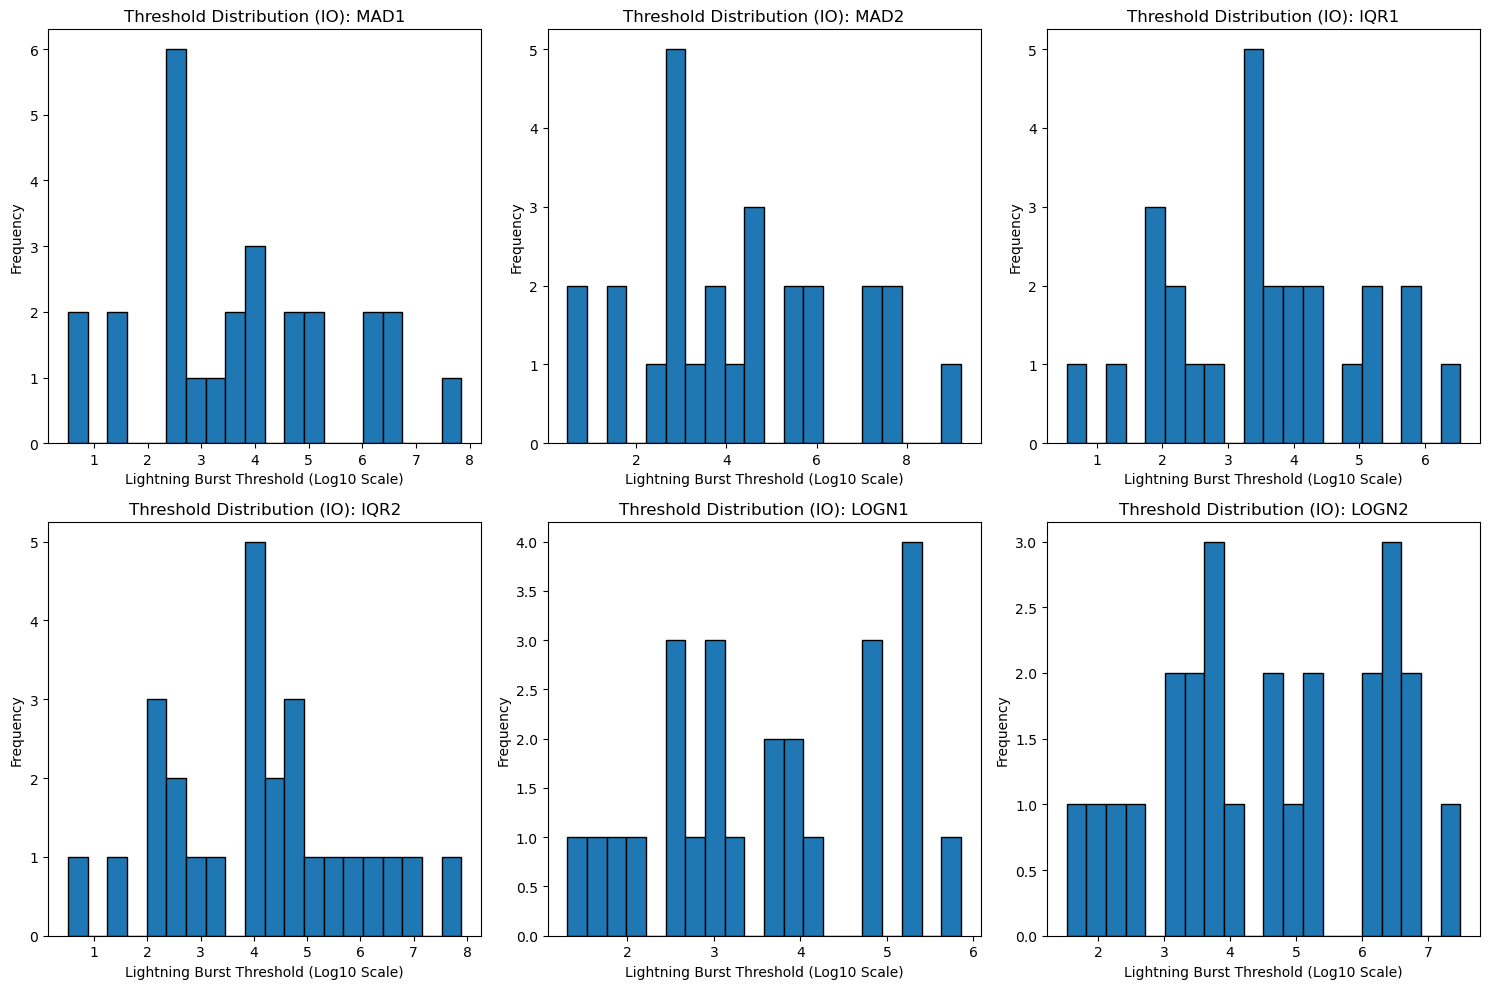

In [220]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(io_tc_summary, threshold, ax=axes[i])
    axes[i].set_title(f"Threshold Distribution (IO): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

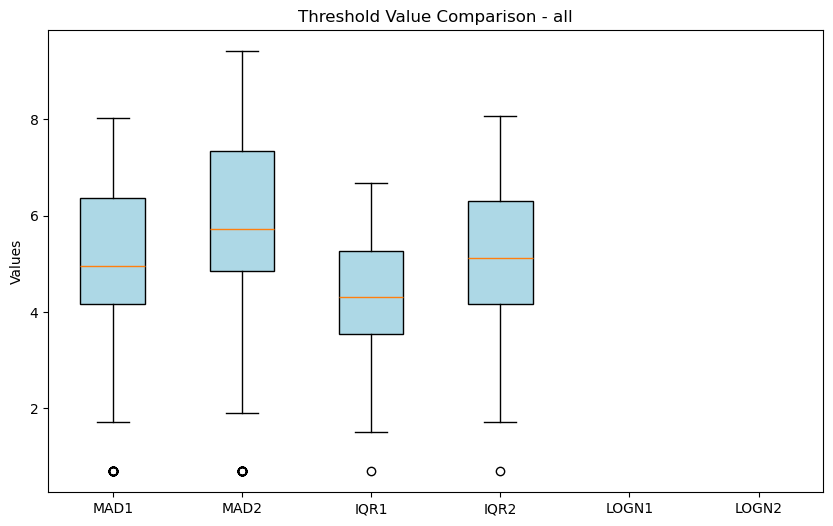

In [ ]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(io_bursts, "all", ax=None)

Create a summary for the weaker categories and create an initial basin-category threshold defined as 2 standard deviations + the mean or median.

In [294]:
# Group the data into weak and strong category datasets using function
io_weak0_lightning, io_weak1_lightning, io_strong_lightning = group_bins_category(io_bursts)

1328 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
553 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
322 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


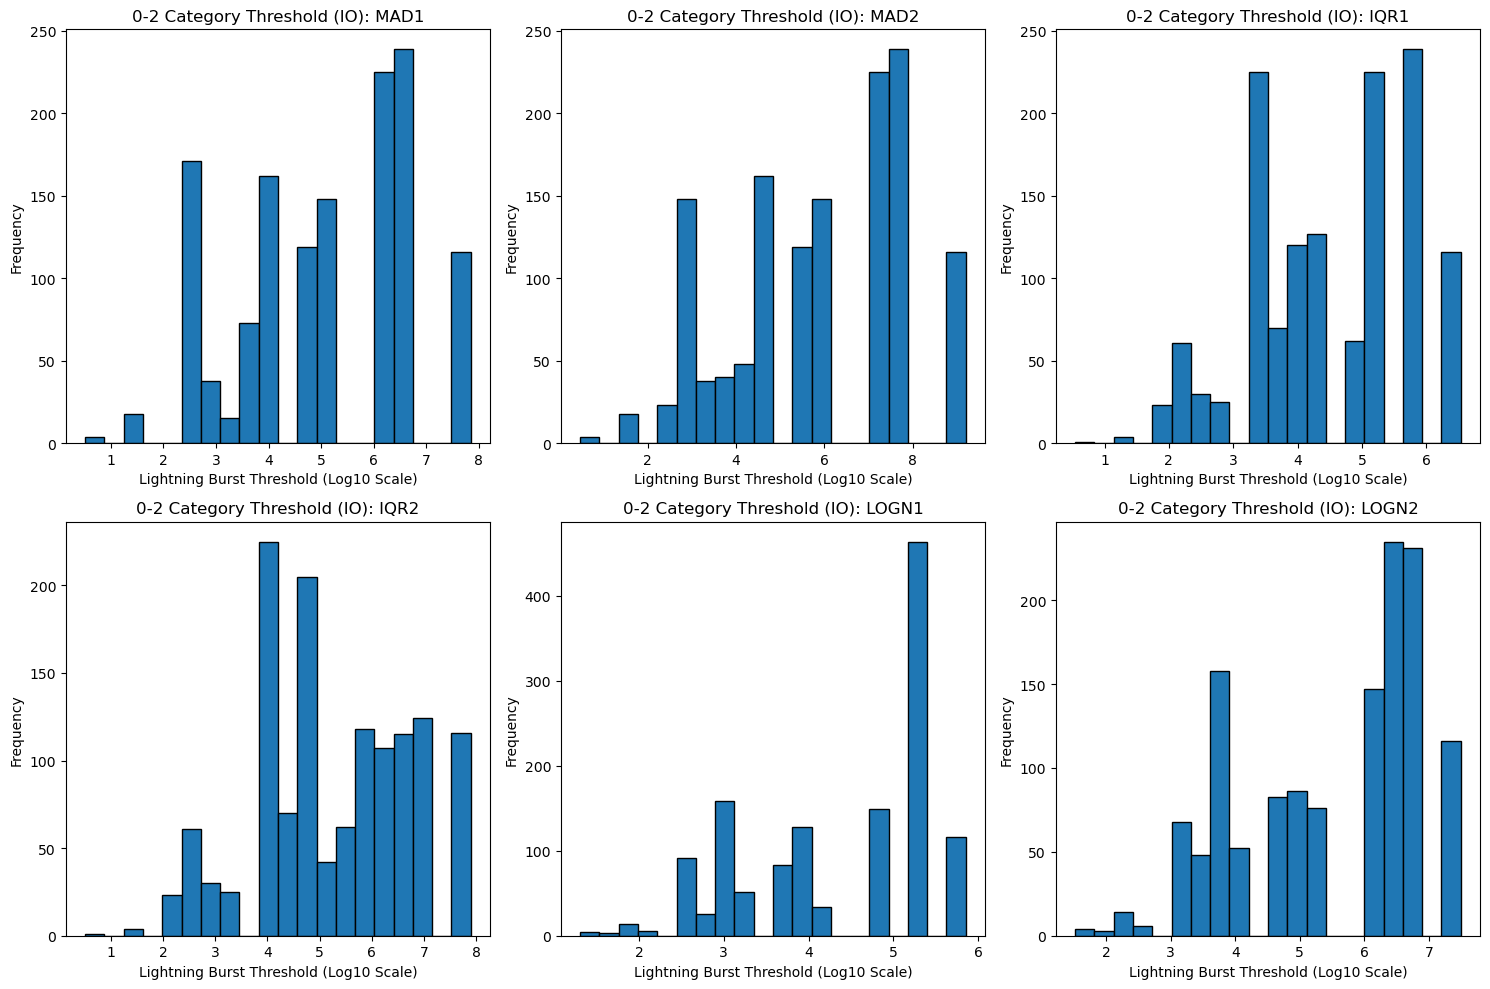

In [223]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(io_weak0_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Threshold (IO): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

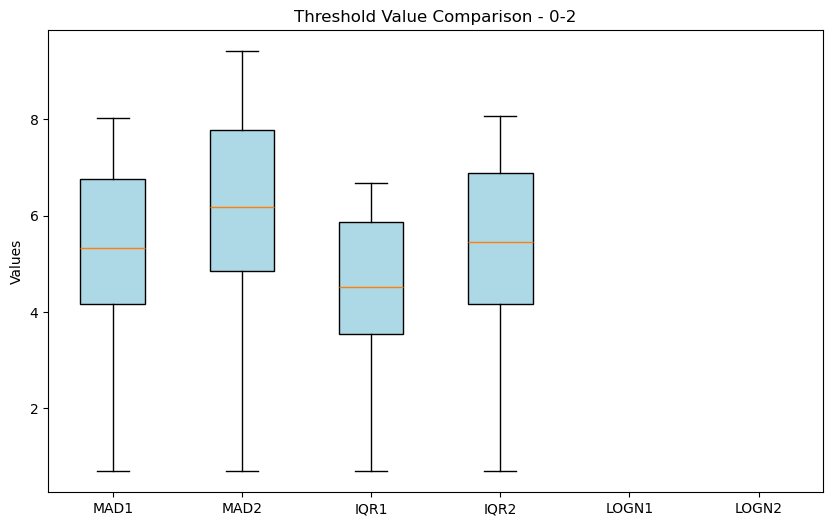

In [224]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(io_weak0_lightning, "0-2", ax=None)

In [295]:
# Create basin summary for 0-2 category group
io_weak0_summary = create_basin_summary(io_weak0_lightning, "0-2", "IO")
io_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            0-2      mad1  5.240345  1.683532  5.335102  0.693147   
1    IO            0-2      mad2  6.080661  1.986855  6.182399  0.693147   
2    IO            0-2      iqr1  4.609678  1.249549  4.510860  0.693147   
3    IO            0-2      iqr2  5.482275  1.508187  5.465288  0.693147   
4    IO            0-2     logn1  4.464874  1.101479  5.002996  1.419204   
5    IO            0-2     logn2  5.648240  1.424865  6.403760  1.668879   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.030084           41           1328              3.09  
1  9.416378           16           1328              1.20  
2  6.685028           62           1328              4.67  
3  8.081632           24           1328              1.81  
4  5.968313           63           1328              4.74  
5  7.641044            2           1328              0.15

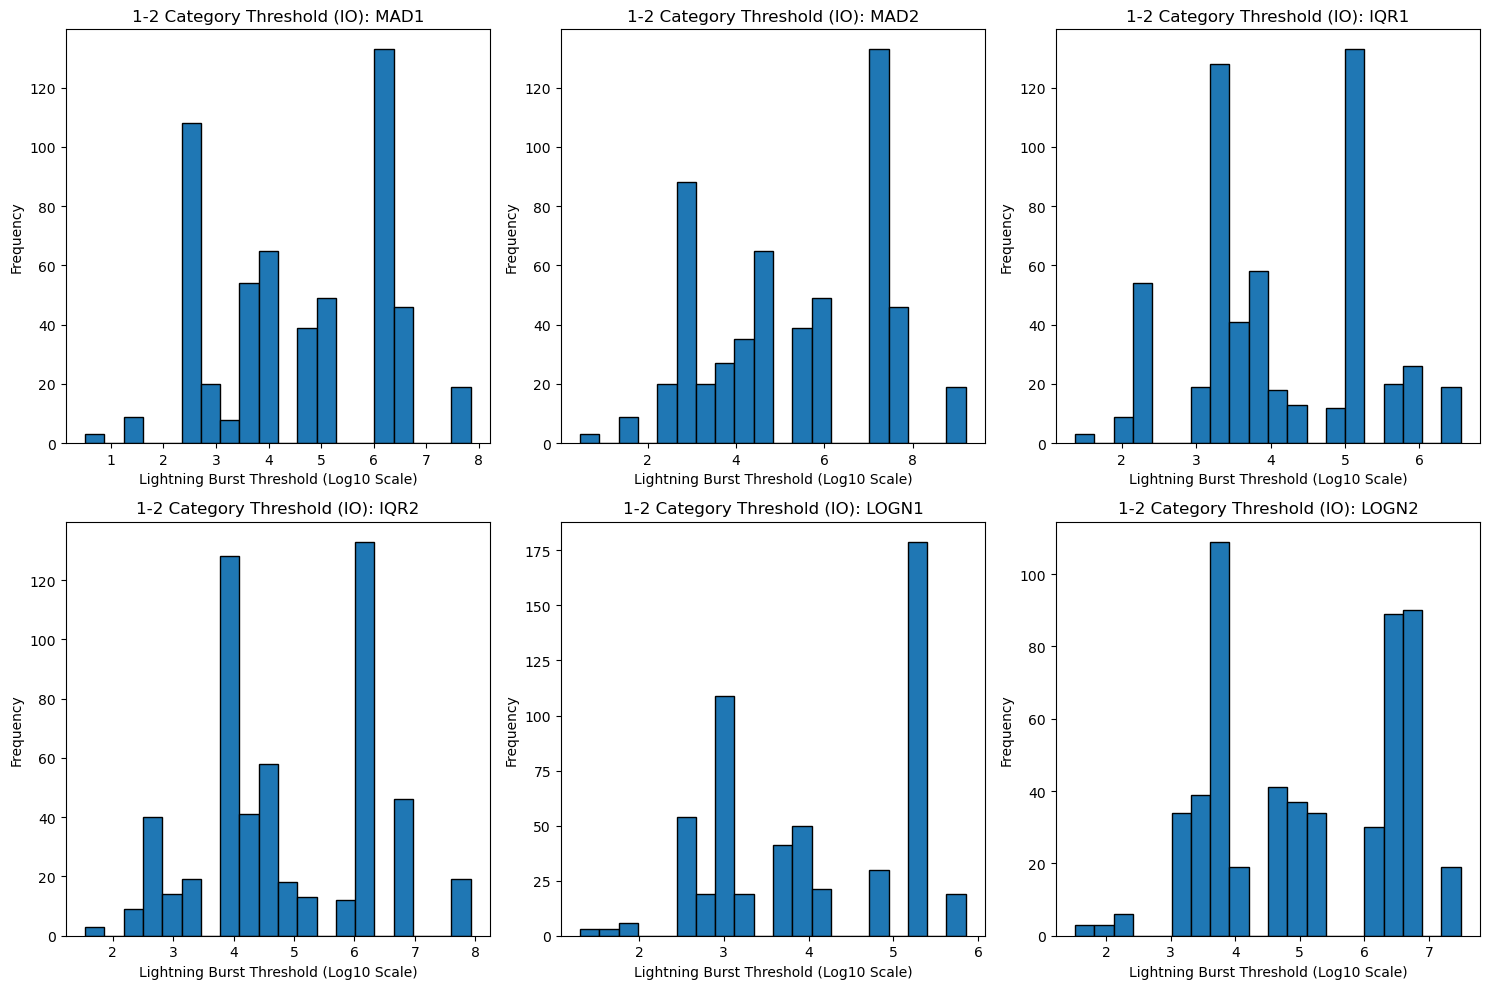

In [226]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(io_weak1_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Threshold (IO): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

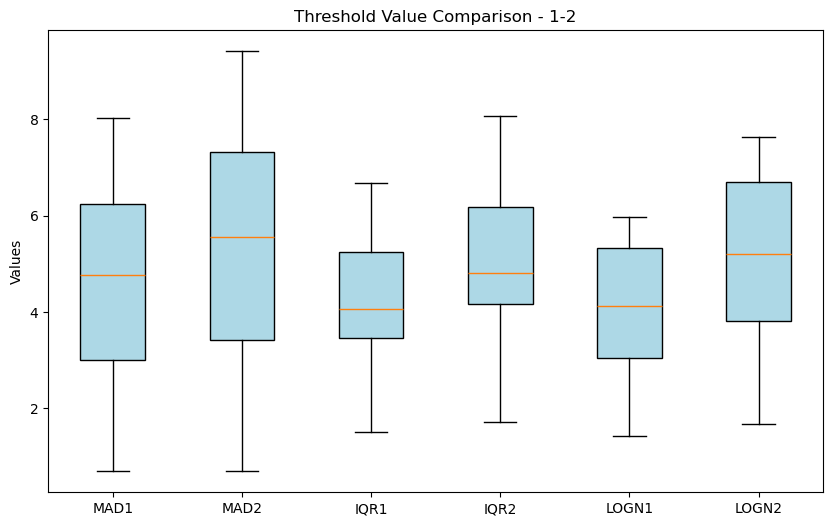

In [227]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(io_weak1_lightning, "1-2", ax=None)

In [228]:
# Create basin summary for 1-2 category group
io_weak1_summary = create_basin_summary(io_weak1_lightning, "1-2", "IO")
io_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            1-2      mad1  4.744996  1.638105  4.763267  0.693147   
1    IO            1-2      mad2  5.495768  1.934734  5.551725  0.693147   
2    IO            1-2      iqr1  4.232509  1.160133  4.068340  1.504077   
3    IO            1-2      iqr2  5.025938  1.397764  4.810772  1.706810   
4    IO            1-2     logn1  4.143373  1.119251  4.135262  1.419204   
5    IO            1-2     logn2  5.235005  1.454826  5.204225  1.668879   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.030084           11            553              1.99  
1  9.416378            3            553              0.54  
2  6.685028           11            553              1.99  
3  8.081632            2            553              0.36  
4  5.968313           11            553              1.99  
5  7.641044            1            553              0.18

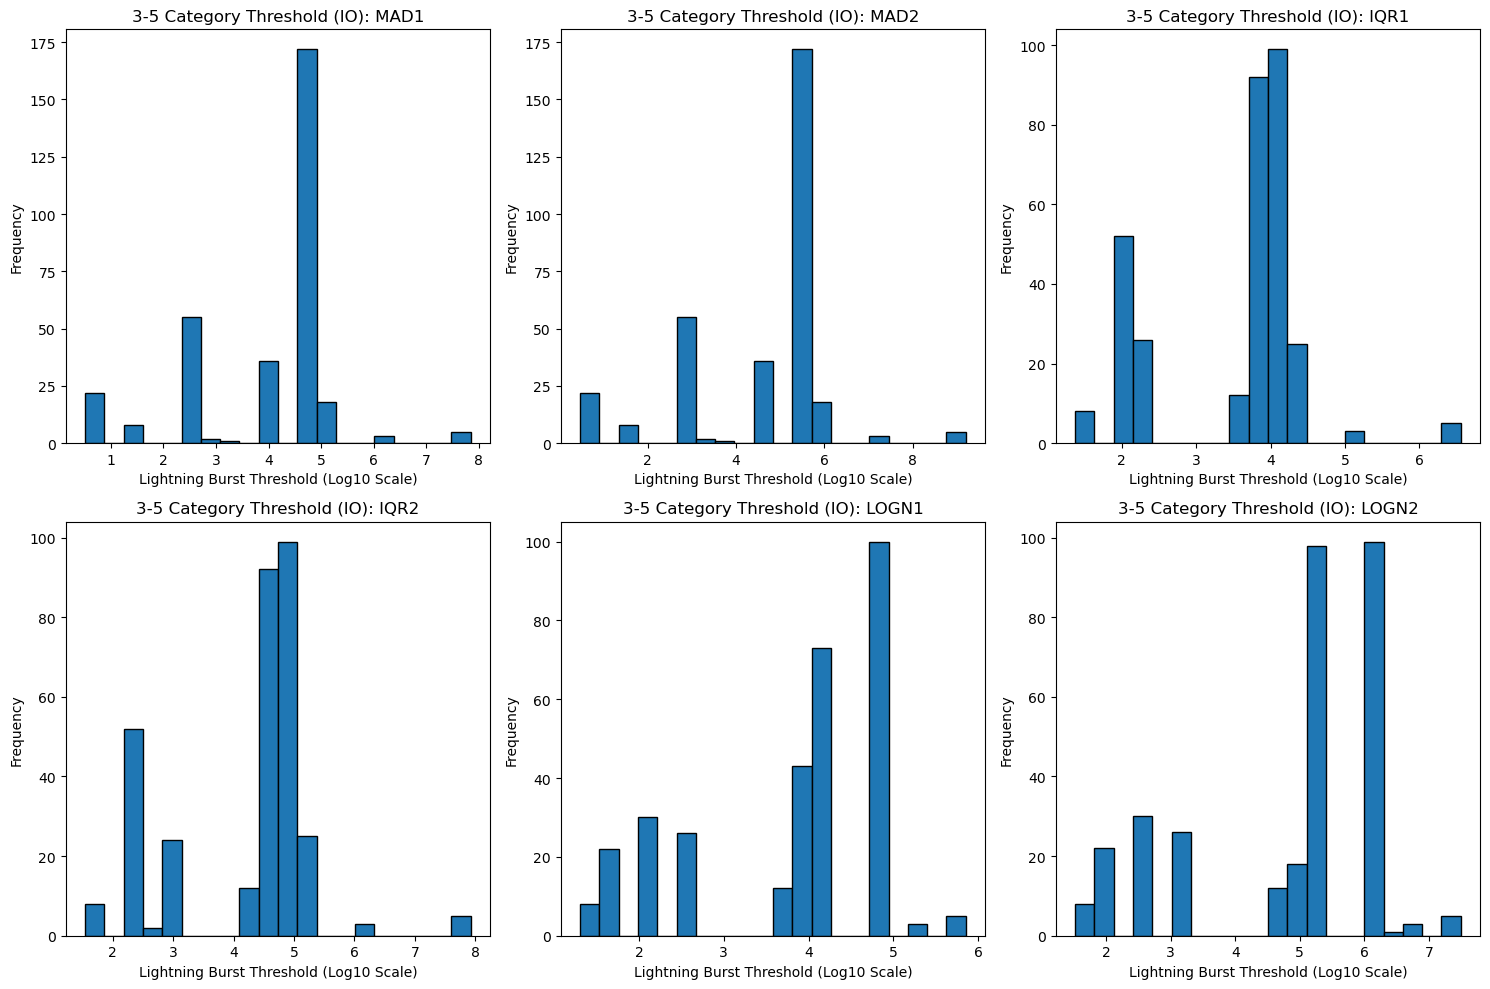

In [229]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(io_strong_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Threshold (IO): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

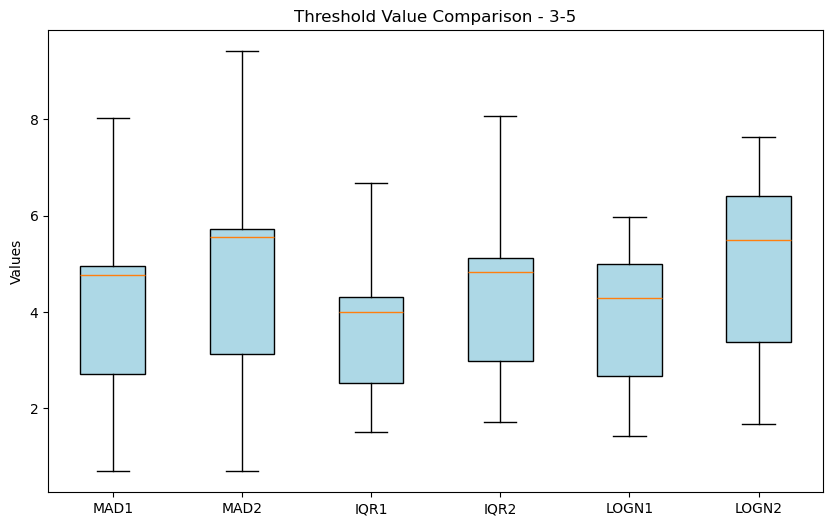

In [230]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(io_strong_lightning, "3-5", ax=None)

In [231]:
# Create basin summary for 3-5 category group
io_strong_summary = create_basin_summary(io_strong_lightning, "3-5", "IO")
io_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            3-5      mad1  4.131889  1.401351  4.763267  0.693147   
1    IO            3-5      mad2  4.782175  1.657083  5.551725  0.693147   
2    IO            3-5      iqr1  3.693065  1.008610  4.007333  1.504077   
3    IO            3-5      iqr2  4.402592  1.234582  4.835880  1.706810   
4    IO            3-5     logn1  3.942271  1.151285  4.285217  1.419204   
5    IO            3-5     logn2  5.023104  1.514494  5.505117  1.668879   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.030084           18            322              5.59  
1  9.416378           11            322              3.42  
2  6.685028           13            322              4.04  
3  8.081632            6            322              1.86  
4  5.968313           13            322              4.04  
5  7.641044            0            322              0.00

Filter the thresholds to just the "effective" thresholds and use these to calculate the basin-category threshold.

In [232]:
# Effective thresholds - IO basin
io_bursts_effective = filter_effective_thresholds(io_bursts)
io_storm_codes_effective = io_bursts_effective["storm_code"].unique()
io_tc_summary_effective = io_tc_summary[io_tc_summary["storm_code"].isin(io_storm_codes_effective)]

io_bursts_effective.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
15411 2010-06-01 09:30:00    IO_10_3               12  2010      6    1     9   
15427 2010-06-02 23:30:00    IO_10_3               10  2010      6    2    23   
15437 2010-06-03 13:30:00    IO_10_3               13  2010      6    3    13   
15463 2010-11-04 22:00:00    IO_10_5               39  2010     11    4    22   
15480 2010-11-05 20:30:00    IO_10_5               32  2010     11    5    20   

       minute   lat   lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
15411      30  16.8  62.3  ...             NaN             NaN      False   
15427      30  18.4  59.8  ...             NaN             NaN      False   
15437      30  20.0  59.5  ...             NaN             NaN      False   
15463       0   9.0  89.3  ...             NaN             NaN      False   
15480      30  10.1  86.5  ...             NaN             NaN      False   

       burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
15411       False       2.720473        3.125938         True        False   
15427       False       2.720473             NaN         True        False   
15437       False       2.720473        3.125938         True        False   
15463       False       4.158883             NaN         True        False   
15480       False       4.158883             NaN         True        False   

      logn1_threshold logn2_threshold  
15411        2.259291             NaN  
15427        2.259291             NaN  
15437        2.259291             NaN  
15463        3.357533             NaN  
15480        3.357533             NaN  

[5 rows x 34 columns]

In [296]:
print(f"{len(io_storm_codes_effective)} TCs of {len(io_storm_codes)} IO TCs after filtering for bursts of any type")

21 TCs of 26 IO TCs after filtering for bursts of any type


In [234]:
io_effective_summary = create_basin_summary(io_bursts_effective, "all", "IO")
io_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            all      mad1  4.843914  1.213651  4.949725  2.537023   
1    IO            all      mad2  5.286634  1.194522  5.719947  2.824705   
2    IO            all      iqr1  3.534300  0.954315  3.701302  2.079442   
3    IO            all      iqr2  3.625884  1.220261  2.983874  2.426015   
4    IO            all     logn1  4.413020  1.014516  4.928103  2.259291   
5    IO            all     logn2  3.866282  0.549679  3.866282  3.477600   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.030084           59            106             55.66  
1  7.316996           27            106             25.47  
2  5.257495           75            106             70.75  
3  5.465288           30            106             28.30  
4  5.968313           76            106             71.70  
5  4.254964            2            106              1.89

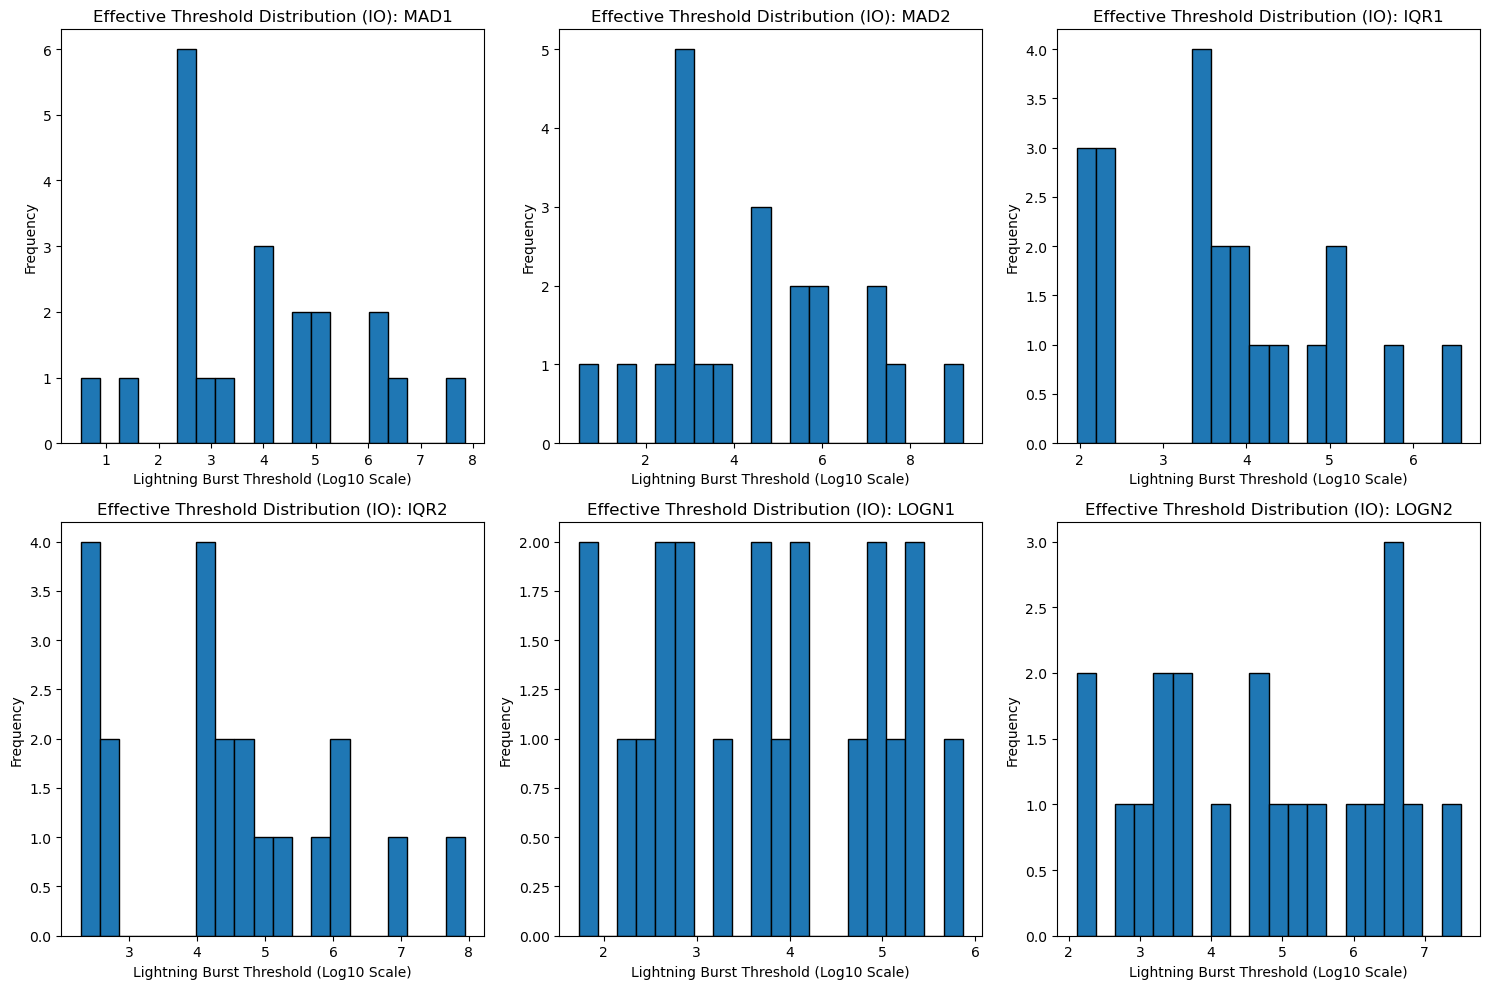

In [235]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(io_tc_summary_effective, threshold, ax=axes[i])
    axes[i].set_title(f"Effective Threshold Distribution (IO): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [297]:
# Group the data into weak and strong category datasets using function
io_weak0_effective_lightning, io_weak1_effective_lightning, io_strong_effective_lightning = group_bins_category(io_bursts_effective)

82 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
17 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
24 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


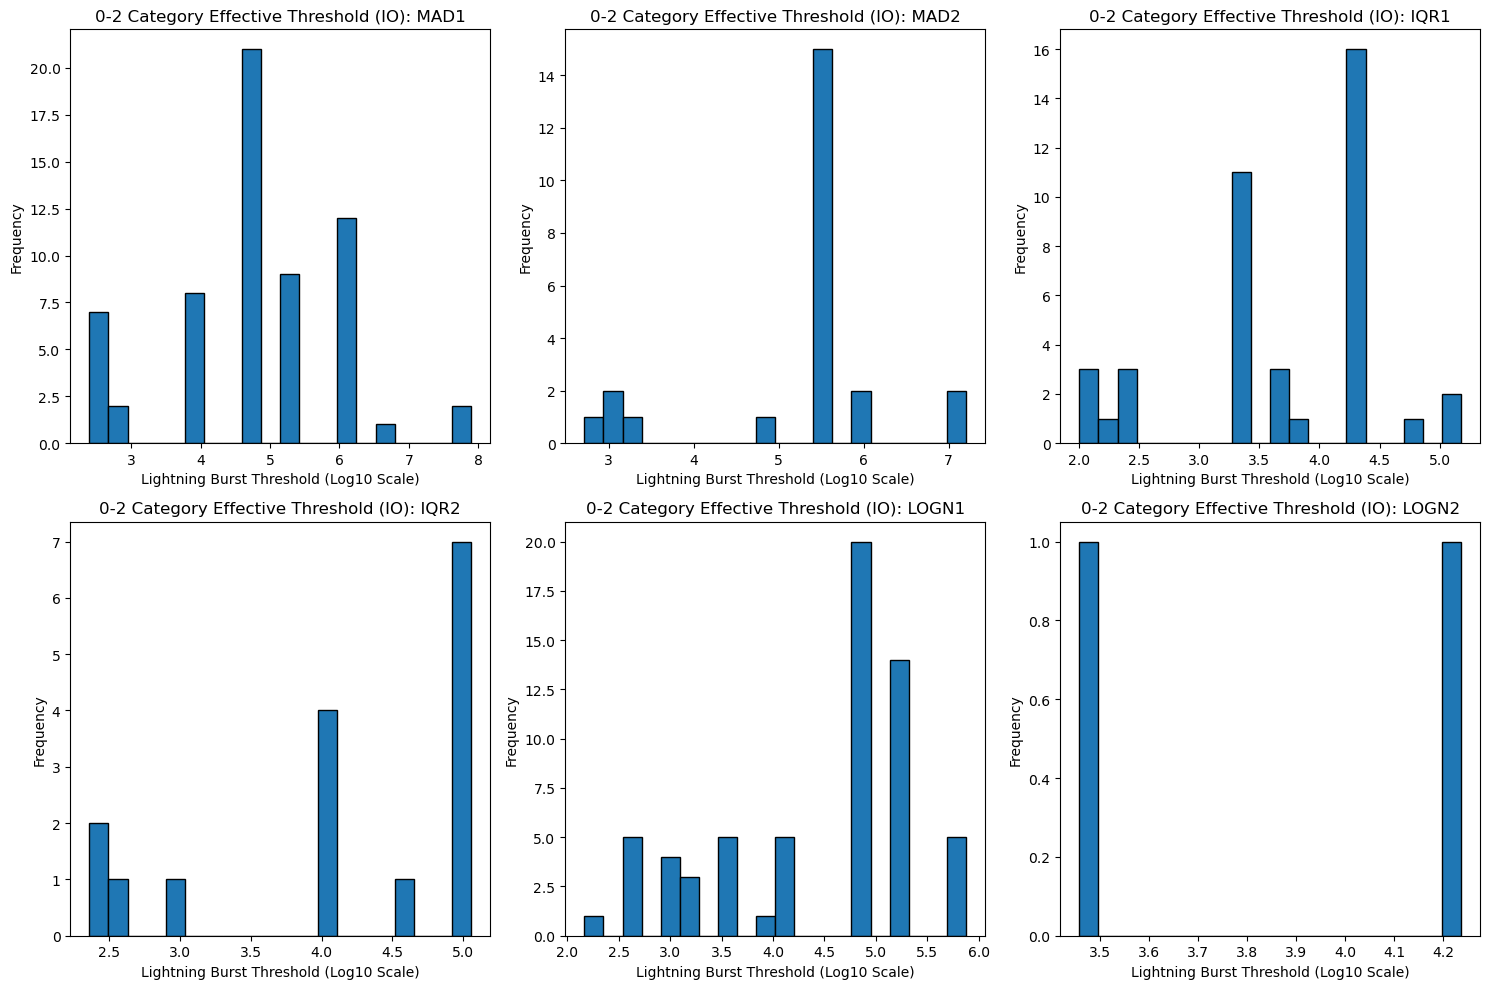

In [237]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(io_weak0_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Effective Threshold (IO): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [298]:
# Get summary for effective thresholds - 0-2 categories
io_weak0_effective_summary = create_basin_summary(io_weak0_effective_lightning, "0-2", "IO")
io_weak0_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            0-2      mad1  4.969417  1.241144  4.949725  2.537023   
1    IO            0-2      mad2  5.422510  1.166903  5.719947  2.824705   
2    IO            0-2      iqr1  3.749116  0.819803  3.701302  2.079442   
3    IO            0-2      iqr2  4.225972  1.039247  4.383890  2.426015   
4    IO            0-2     logn1  4.538211  1.011998  5.002996  2.259291   
5    IO            0-2     logn2  3.866282  0.549679  3.866282  3.477600   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  8.030084           41             82             50.00  
1  7.316996           16             82             19.51  
2  5.257495           62             82             75.61  
3  5.122207           24             82             29.27  
4  5.968313           63             82             76.83  
5  4.254964            2             82              2.44

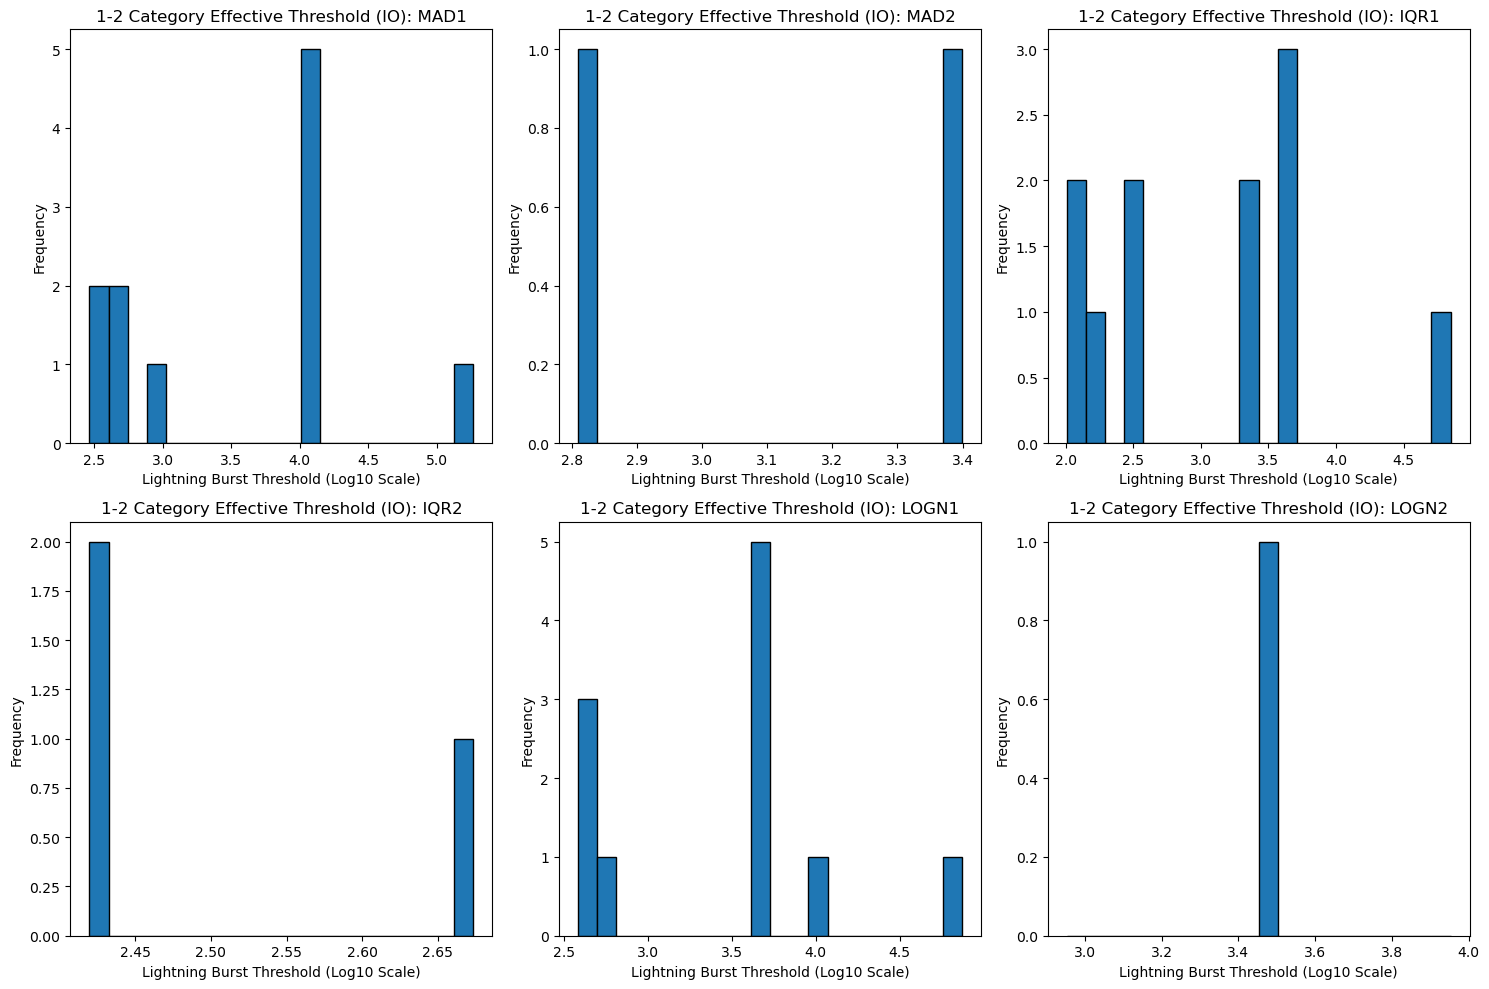

In [239]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(io_weak1_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Effective Threshold (IO): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [299]:
# Get summary for effective thresholds - 1-2 categories
io_weak1_effective_summary = create_basin_summary(io_weak1_effective_lightning, "1-2", "IO")
io_weak1_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            1-2      mad1  3.604788  0.934309  4.158883  2.537023   
1    IO            1-2      mad2  3.119162  0.416426  3.119162  2.824705   
2    IO            1-2      iqr1  3.132351  0.892108  3.465736  2.079442   
3    IO            1-2      iqr2  2.510602  0.146508  2.426015  2.426015   
4    IO            1-2     logn1  3.485837  0.722619  3.708659  2.642472   
5    IO            1-2     logn2  3.477600       NaN  3.477600  3.477600   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  5.335102           11             17             64.71  
1  3.413620            3             17             17.65  
2  4.919003           11             17             64.71  
3  2.679775            2             17             11.76  
4  4.928103           11             17             64.71  
5  3.477600            1             17              5.88

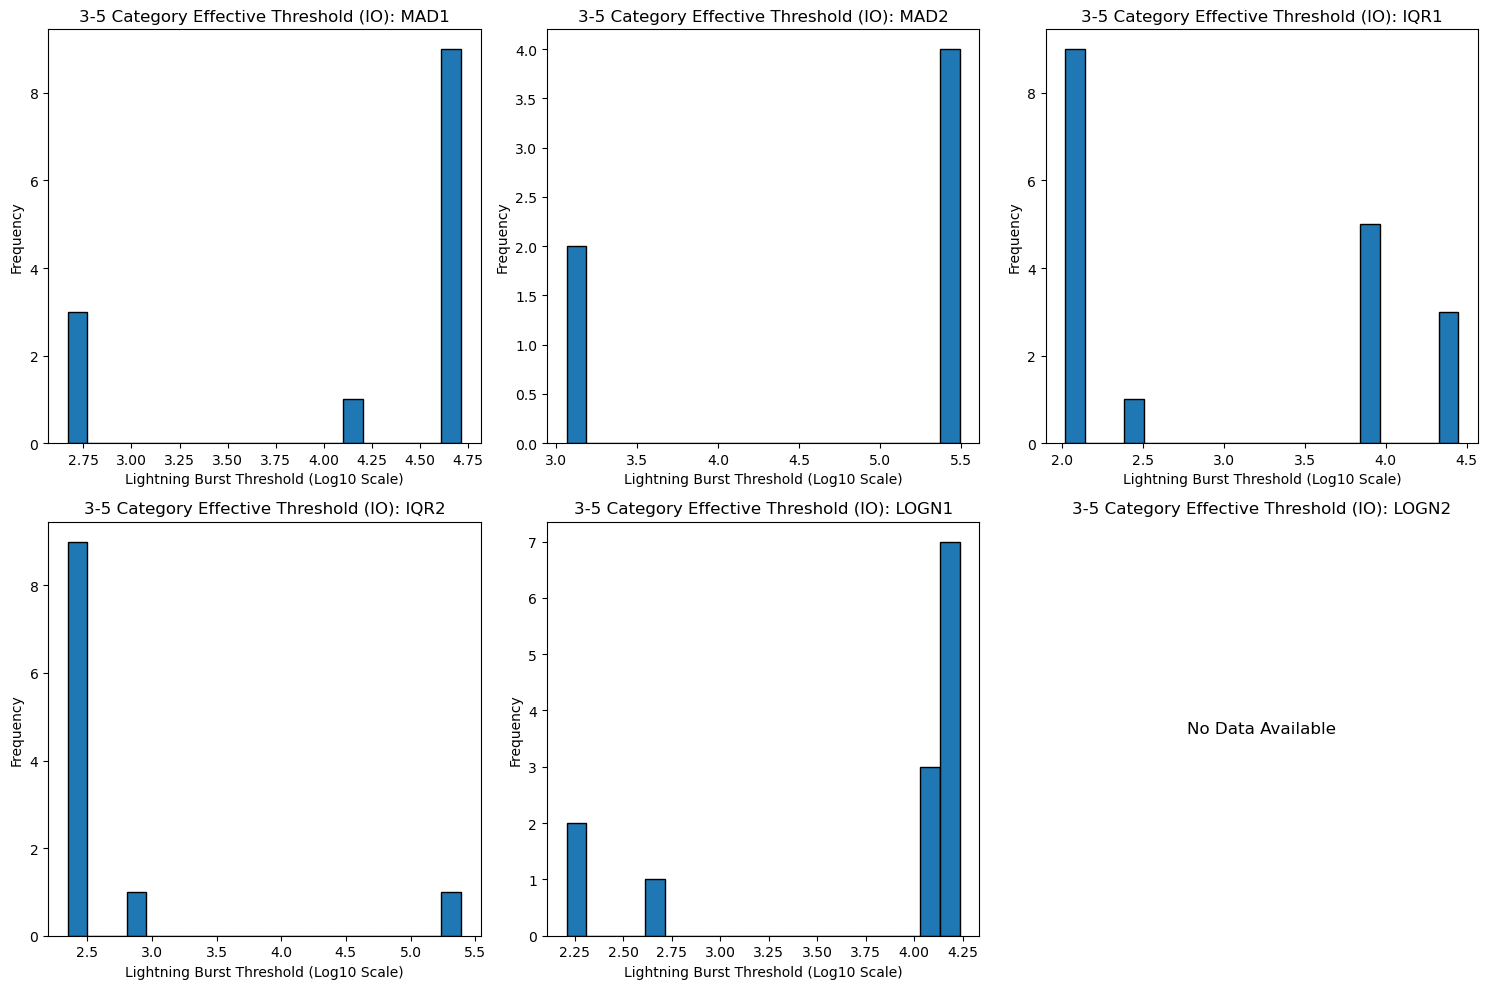

In [241]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(io_strong_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Effective Threshold (IO): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [300]:
# Get summary for effective thresholds - 3-5 categories
io_strong_effective_summary = create_basin_summary(io_strong_effective_lightning, "3-5", "IO")
io_strong_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            3-5      mad1  4.245362  0.884938  4.763267  2.720473   
1    IO            3-5      mad2  4.743129  1.252671  5.551725  3.125938   
2    IO            3-5      iqr1  3.044997  1.077498  2.302585  2.079442   
3    IO            3-5      iqr2  2.753027  0.914991  2.426015  2.426015   
4    IO            3-5     logn1  3.806328  0.812620  4.285217  2.259291   
5    IO            3-5     logn2       NaN       NaN       NaN       NaN   

        Max  Burst Count  Timebin Count  Burst Percentage  
0  4.763267           18             24             75.00  
1  5.551725           11             24             45.83  
2  4.510860           13             24             54.17  
3  5.465288            6             24             25.00  
4  4.285217           13             24             54.17  
5       NaN            0             24              0.00

Let's calculate and apply the basin-level effective threshold. We'll try both 1.5 SD and 2 SD from the mean and median of the effective thresholds for each category group.

Start with the 0-2 category grouping.

In [243]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
io_weak0_effective_thresholds = calculate_basin_thresholds(io_weak0_effective_lightning, "0-2", "IO", threshold_type="effective")
io_weak0_effective_thresholds_1_5sd = calculate_basin_thresholds(io_weak0_effective_lightning, "0-2", "IO", std_dev=1.5, threshold_type="effective")

In [244]:
# 0-2 categories, 2 SD
io_weak0_summary_2sd, io_weak0_eff_bursts_mean, io_weak0_eff_summary_mean, io_weak0_eff_bursts_median, io_weak0_eff_summary_median = summarize_threshold_eval(io_weak0_summary, io_weak0_lightning, io_weak0_effective_thresholds, threshold_type="effective")
io_weak0_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            0-2      mad1  5.240345  1.683532  5.335102  0.693147   
1    IO            0-2      mad2  6.080661  1.986855  6.182399  0.693147   
2    IO            0-2      iqr1  4.609678  1.249549  4.510860  0.693147   
3    IO            0-2      iqr2  5.482275  1.508187  5.465288  0.693147   
4    IO            0-2     logn1  4.464874  1.101479  5.002996  1.419204   
5    IO            0-2     logn2  5.648240  1.424865  6.403760  1.668879   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  8.030084           41           1328              3.09   
1  9.416378           16           1328              1.20   
2  6.685028           62           1328              4.67   
3  8.081632           24           1328              1.81   
4  5.968313           63           1328              4.74   
5  7.641044            2           1328              0.15   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           7.451706      
1                                           7.756315      
2                                           5.388722      
3                                           6.304467      
4                                           6.562207      
5                                           4.965641      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           7.432013        
1                                           8.053753        
2                                           5.340908        
3                                           6.462385        
4                                           7.026993        
5                                           4.965641        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  0             
2                                                 29             
3                                                  7             
4                                                  5             
5                                                 64             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.00                       
2                                               2.18                       
3                                               0.53                       
4                                               0.38                       
5                                               4.82                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                  0               
2                                                 33               
3                                                  6               
4                                                  0               
5                                                 64               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.00                        
1                                               0.00                        
2                                               2.48                        
3                                               0.45                        
4                                               0.00                        
5                                               4.82

In [245]:
# 0-2 categories, 1.5 SD
io_weak0_summary_1_5sd, io_weak0_eff_bursts_mean_1_5, io_weak0_eff_summary_mean_1_5, io_weak0_eff_bursts_median_1_5, io_weak0_eff_summary_median_1_5 = summarize_threshold_eval(io_weak0_summary, io_weak0_lightning, io_weak0_effective_thresholds_1_5sd, threshold_type="effective")
io_weak0_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            0-2      mad1  5.240345  1.683532  5.335102  0.693147   
1    IO            0-2      mad2  6.080661  1.986855  6.182399  0.693147   
2    IO            0-2      iqr1  4.609678  1.249549  4.510860  0.693147   
3    IO            0-2      iqr2  5.482275  1.508187  5.465288  0.693147   
4    IO            0-2     logn1  4.464874  1.101479  5.002996  1.419204   
5    IO            0-2     logn2  5.648240  1.424865  6.403760  1.668879   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  8.030084           41           1328              3.09   
1  9.416378           16           1328              1.20   
2  6.685028           62           1328              4.67   
3  8.081632           24           1328              1.81   
4  5.968313           63           1328              4.74   
5  7.641044            2           1328              0.15   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.831133        
1                                           7.172864        
2                                           4.978820        
3                                           5.784843        
4                                           6.056208        
5                                           4.690801        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.811441          
1                                           7.470301          
2                                           4.931007          
3                                           5.942761          
4                                           6.520993          
5                                           4.690801          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  3               
1                                                  0               
2                                                 64               
3                                                 21               
4                                                  9               
5                                                 79               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.23                         
1                                               0.00                         
2                                               4.82                         
3                                               1.58                         
4                                               0.68                         
5                                               5.95                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                  3                 
1                                                  0                 
2                                                 67                 
3                                                 15                 
4                                                  6                 
5                                                 79                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               0.23                          
1                                               0.00                          
2                                               5.05                          
3                                               1.13                          
4                                               0.45                          
5                                               5.95

In [246]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = io_weak0_summary_1_5sd.columns[-6: ].to_list()
keep.append(io_weak0_summary_1_5sd.columns[2])
io_weak0_summary = pd.merge(io_weak0_summary_2sd, io_weak0_summary_1_5sd[keep], on="Threshold")
io_weak0_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            0-2      mad1  5.240345  1.683532  5.335102  0.693147   
1    IO            0-2      mad2  6.080661  1.986855  6.182399  0.693147   
2    IO            0-2      iqr1  4.609678  1.249549  4.510860  0.693147   
3    IO            0-2      iqr2  5.482275  1.508187  5.465288  0.693147   
4    IO            0-2     logn1  4.464874  1.101479  5.002996  1.419204   
5    IO            0-2     logn2  5.648240  1.424865  6.403760  1.668879   

        Max  Burst Count  Timebin Count  ...  \
0  8.030084           41           1328  ...   
1  9.416378           16           1328  ...   
2  6.685028           62           1328  ...   
3  8.081632           24           1328  ...   
4  5.968313           63           1328  ...   
5  7.641044            2           1328  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  0             
2                                                 29             
3                                                  7             
4                                                  5             
5                                                 64             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.00                       
2                                               2.18                       
3                                               0.53                       
4                                               0.38                       
5                                               4.82                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                  0               
2                                                 33               
3                                                  6               
4                                                  0               
5                                                 64               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.00                         
1                                               0.00                         
2                                               2.48                         
3                                               0.45                         
4                                               0.00                         
5                                               4.82                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.831133        
1                                           7.172864        
2                                           4.978820        
3                                           5.784843        
4                                           6.056208        
5                                           4.690801        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.811441          
1                                           7.470301          
2                                           4.931007          
3                                           5.942761          
4                                           6.520993          
5                                           4.690801          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  3               
1                                                  0               
2                                     

Let's do the same for the other 2 category groupings.

1-2 categories:

In [247]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
io_weak1_effective_thresholds = calculate_basin_thresholds(io_weak1_effective_lightning, "1-2", "IO", threshold_type="effective")
io_weak1_effective_thresholds_1_5sd = calculate_basin_thresholds(io_weak1_effective_lightning, "1-2", "IO", std_dev=1.5, threshold_type="effective")

In [248]:
# 1-2 categories, 2 SD
io_weak1_summary_2sd, io_weak1_eff_bursts_mean, io_weak1_eff_summary_mean, io_weak1_eff_bursts_median, io_weak1_eff_summary_median = summarize_threshold_eval(io_weak1_summary, io_weak1_lightning, io_weak1_effective_thresholds, threshold_type="effective")
io_weak1_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            1-2      mad1  4.744996  1.638105  4.763267  0.693147   
1    IO            1-2      mad2  5.495768  1.934734  5.551725  0.693147   
2    IO            1-2      iqr1  4.232509  1.160133  4.068340  1.504077   
3    IO            1-2      iqr2  5.025938  1.397764  4.810772  1.706810   
4    IO            1-2     logn1  4.143373  1.119251  4.135262  1.419204   
5    IO            1-2     logn2  5.235005  1.454826  5.204225  1.668879   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  8.030084           11            553              1.99   
1  9.416378            3            553              0.54   
2  6.685028           11            553              1.99   
3  8.081632            2            553              0.36   
4  5.968313           11            553              1.99   
5  7.641044            1            553              0.18   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           5.473406      
1                                           3.952014      
2                                           4.916567      
3                                           2.803619      
4                                           4.931075      
5                                                NaN      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           6.027501        
1                                           3.952014        
2                                           5.249952        
3                                           2.719032        
4                                           5.153897        
5                                                NaN        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  1             
1                                                 27             
2                                                 10             
3                                                 96             
4                                                 10             
5                                                  0             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.18                       
1                                               4.88                       
2                                               1.81                       
3                                              17.36                       
4                                               1.81                       
5                                               0.00                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                 27               
2                                                  2               
3                                                101               
4                                                  3               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.00                        
1                                               4.88                        
2                                               0.36                        
3                                              18.26                        
4                                               0.54                        
5                                               0.00

In [249]:
# 1-2 categories, 1.5 SD
io_weak1_summary_1_5sd, io_weak1_eff_bursts_mean_1_5, io_weak1_eff_summary_mean_1_5, io_weak1_eff_bursts_median_1_5, io_weak1_eff_summary_median_1_5 = summarize_threshold_eval(io_weak1_summary, io_weak1_lightning, io_weak1_effective_thresholds_1_5sd, threshold_type="effective")
io_weak1_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            1-2      mad1  4.744996  1.638105  4.763267  0.693147   
1    IO            1-2      mad2  5.495768  1.934734  5.551725  0.693147   
2    IO            1-2      iqr1  4.232509  1.160133  4.068340  1.504077   
3    IO            1-2      iqr2  5.025938  1.397764  4.810772  1.706810   
4    IO            1-2     logn1  4.143373  1.119251  4.135262  1.419204   
5    IO            1-2     logn2  5.235005  1.454826  5.204225  1.668879   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  8.030084           11            553              1.99   
1  9.416378            3            553              0.54   
2  6.685028           11            553              1.99   
3  8.081632            2            553              0.36   
4  5.968313           11            553              1.99   
5  7.641044            1            553              0.18   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           5.006251        
1                                           3.743801        
2                                           4.470513        
3                                           2.730364        
4                                           4.569765        
5                                                NaN        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.560347          
1                                           3.743801          
2                                           4.803898          
3                                           2.645778          
4                                           4.792588          
5                                                NaN          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  5               
1                                                 36               
2                                                 15               
3                                                101               
4                                                 13               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.90                         
1                                               6.51                         
2                                               2.71                         
3                                              18.26                         
4                                               2.35                         
5                                               0.00                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                  0                 
1                                                 36                 
2                                                 11                 
3                                                103                 
4                                                 11                 
5                                                  0                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               0.00                          
1                                               6.51                          
2                                               1.99                          
3                                              18.63                          
4                                               1.99                          
5                                               0.00

In [250]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = io_weak1_summary_1_5sd.columns[-6: ].to_list()
keep.append(io_weak1_summary_1_5sd.columns[2])
io_weak1_summary = pd.merge(io_weak1_summary_2sd, io_weak1_summary_1_5sd[keep], on="Threshold")
io_weak1_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            1-2      mad1  4.744996  1.638105  4.763267  0.693147   
1    IO            1-2      mad2  5.495768  1.934734  5.551725  0.693147   
2    IO            1-2      iqr1  4.232509  1.160133  4.068340  1.504077   
3    IO            1-2      iqr2  5.025938  1.397764  4.810772  1.706810   
4    IO            1-2     logn1  4.143373  1.119251  4.135262  1.419204   
5    IO            1-2     logn2  5.235005  1.454826  5.204225  1.668879   

        Max  Burst Count  Timebin Count  ...  \
0  8.030084           11            553  ...   
1  9.416378            3            553  ...   
2  6.685028           11            553  ...   
3  8.081632            2            553  ...   
4  5.968313           11            553  ...   
5  7.641044            1            553  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  1             
1                                                 27             
2                                                 10             
3                                                 96             
4                                                 10             
5                                                  0             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.18                       
1                                               4.88                       
2                                               1.81                       
3                                              17.36                       
4                                               1.81                       
5                                               0.00                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                 27               
2                                                  2               
3                                                101               
4                                                  3               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.00                         
1                                               4.88                         
2                                               0.36                         
3                                              18.26                         
4                                               0.54                         
5                                               0.00                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           5.006251        
1                                           3.743801        
2                                           4.470513        
3                                           2.730364        
4                                           4.569765        
5                                                NaN        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           5.560347          
1                                           3.743801          
2                                           4.803898          
3                                           2.645778          
4                                           4.792588          
5                                                NaN          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  5               
1                                                 36               
2                                     

Do the same for the stronger category group (3-5).

In [251]:
# Calculate 2 SD and 1.5 SD thresholds for effective thresholds
io_strong_effective_thresholds = calculate_basin_thresholds(io_strong_effective_lightning, "3-5", "IO", threshold_type="effective")
io_strong_effective_thresholds_1_5sd = calculate_basin_thresholds(io_strong_effective_lightning, "3-5", "IO", std_dev=1.5, threshold_type="effective")

In [252]:
# 3-5 categories, 2 SD
io_strong_summary_2sd, io_strong_eff_bursts_mean, io_strong_eff_summary_mean, io_strong_eff_bursts_median, io_strong_eff_summary_median = summarize_threshold_eval(io_strong_summary, io_strong_lightning, io_strong_effective_thresholds, threshold_type="effective")
io_strong_summary_2sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            3-5      mad1  4.131889  1.401351  4.763267  0.693147   
1    IO            3-5      mad2  4.782175  1.657083  5.551725  0.693147   
2    IO            3-5      iqr1  3.693065  1.008610  4.007333  1.504077   
3    IO            3-5      iqr2  4.402592  1.234582  4.835880  1.706810   
4    IO            3-5     logn1  3.942271  1.151285  4.285217  1.419204   
5    IO            3-5     logn2  5.023104  1.514494  5.505117  1.668879   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  8.030084           18            322              5.59   
1  9.416378           11            322              3.42   
2  6.685028           13            322              4.04   
3  8.081632            6            322              1.86   
4  5.968313           13            322              4.04   
5  7.641044            0            322              0.00   

   Basin-Category Effective Threshold (Mean-Based) 2 SD  \
0                                           6.015237      
1                                           7.248471      
2                                           5.199993      
3                                           4.583008      
4                                           5.431569      
5                                                NaN      

   Basin-Category Effective Threshold (Median-Based) 2 SD  \
0                                           6.533143        
1                                           8.057067        
2                                           4.457581        
3                                           4.255996        
4                                           5.910457        
5                                                NaN        

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  0             
2                                                  2             
3                                                  6             
4                                                  2             
5                                                  0             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.00                       
2                                               0.62                       
3                                               1.86                       
4                                               0.62                       
5                                               0.00                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                  0               
2                                                  8               
3                                                 11               
4                                                  0               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  
0                                               0.00                        
1                                               0.00                        
2                                               2.48                        
3                                               3.42                        
4                                               0.00                        
5                                               0.00

In [253]:
# 3-5 categories, 1.5 SD
io_strong_summary_1_5sd, io_strong_eff_bursts_mean_1_5, io_strong_eff_summary_mean_1_5, io_strong_eff_bursts_median_1_5, io_strong_eff_summary_median_1_5 = summarize_threshold_eval(io_strong_summary, io_strong_lightning, io_strong_effective_thresholds_1_5sd, threshold_type="effective")
io_strong_summary_1_5sd

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            3-5      mad1  4.131889  1.401351  4.763267  0.693147   
1    IO            3-5      mad2  4.782175  1.657083  5.551725  0.693147   
2    IO            3-5      iqr1  3.693065  1.008610  4.007333  1.504077   
3    IO            3-5      iqr2  4.402592  1.234582  4.835880  1.706810   
4    IO            3-5     logn1  3.942271  1.151285  4.285217  1.419204   
5    IO            3-5     logn2  5.023104  1.514494  5.505117  1.668879   

        Max  Burst Count  Timebin Count  Burst Percentage  \
0  8.030084           18            322              5.59   
1  9.416378           11            322              3.42   
2  6.685028           13            322              4.04   
3  8.081632            6            322              1.86   
4  5.968313           13            322              4.04   
5  7.641044            0            322              0.00   

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           5.572768        
1                                           6.622136        
2                                           4.661244        
3                                           4.125513        
4                                           5.025259        
5                                                NaN        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.090674          
1                                           7.430731          
2                                           3.918832          
3                                           3.798501          
4                                           5.504147          
5                                                NaN          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  0               
1                                                  0               
2                                                  6               
3                                                 11               
4                                                  4               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.00                         
1                                               0.00                         
2                                               1.86                         
3                                               3.42                         
4                                               1.24                         
5                                               0.00                         

   Basin-Category Effective Threshold Bursts (Median-Based) 1.5 SD  \
0                                                  0                 
1                                                  0                 
2                                                 15                 
3                                                 15                 
4                                                  0                 
5                                                  0                 

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 1.5 SD  
0                                               0.00                          
1                                               0.00                          
2                                               4.66                          
3                                               4.66                          
4                                               0.00                          
5                                               0.00

In [254]:
# Merge the 2 SD and 1.5 SD dataframes for comparison
keep = io_strong_summary_1_5sd.columns[-6: ].to_list()
keep.append(io_strong_summary_1_5sd.columns[2])
io_strong_summary = pd.merge(io_strong_summary_2sd, io_strong_summary_1_5sd[keep], on="Threshold")
io_strong_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            3-5      mad1  4.131889  1.401351  4.763267  0.693147   
1    IO            3-5      mad2  4.782175  1.657083  5.551725  0.693147   
2    IO            3-5      iqr1  3.693065  1.008610  4.007333  1.504077   
3    IO            3-5      iqr2  4.402592  1.234582  4.835880  1.706810   
4    IO            3-5     logn1  3.942271  1.151285  4.285217  1.419204   
5    IO            3-5     logn2  5.023104  1.514494  5.505117  1.668879   

        Max  Burst Count  Timebin Count  ...  \
0  8.030084           18            322  ...   
1  9.416378           11            322  ...   
2  6.685028           13            322  ...   
3  8.081632            6            322  ...   
4  5.968313           13            322  ...   
5  7.641044            0            322  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  0             
2                                                  2             
3                                                  6             
4                                                  2             
5                                                  0             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.00                       
2                                               0.62                       
3                                               1.86                       
4                                               0.62                       
5                                               0.00                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                  0               
2                                                  8               
3                                                 11               
4                                                  0               
5                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.00                         
1                                               0.00                         
2                                               2.48                         
3                                               3.42                         
4                                               0.00                         
5                                               0.00                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           5.572768        
1                                           6.622136        
2                                           4.661244        
3                                           4.125513        
4                                           5.025259        
5                                                NaN        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.090674          
1                                           7.430731          
2                                           3.918832          
3                                           3.798501          
4                                           5.504147          
5                                                NaN          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  0               
1                                                  0               
2                                     

Concatenate the three dataframes into one for easier comparison at the basin level.

In [255]:
io_basin_burst_summary = pd.concat([io_weak0_summary, io_weak1_summary, io_strong_summary], ignore_index=True)
io_basin_burst_summary.head()

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0    IO            0-2      mad1  5.240345  1.683532  5.335102  0.693147   
1    IO            0-2      mad2  6.080661  1.986855  6.182399  0.693147   
2    IO            0-2      iqr1  4.609678  1.249549  4.510860  0.693147   
3    IO            0-2      iqr2  5.482275  1.508187  5.465288  0.693147   
4    IO            0-2     logn1  4.464874  1.101479  5.002996  1.419204   

        Max  Burst Count  Timebin Count  ...  \
0  8.030084           41           1328  ...   
1  9.416378           16           1328  ...   
2  6.685028           62           1328  ...   
3  8.081632           24           1328  ...   
4  5.968313           63           1328  ...   

   Basin-Category Effective Threshold Bursts (Mean-Based) 2 SD  \
0                                                  0             
1                                                  0             
2                                                 29             
3                                                  7             
4                                                  5             

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 2 SD  \
0                                               0.00                       
1                                               0.00                       
2                                               2.18                       
3                                               0.53                       
4                                               0.38                       

   Basin-Category Effective Threshold Bursts (Median-Based) 2 SD  \
0                                                  0               
1                                                  0               
2                                                 33               
3                                                  6               
4                                                  0               

   Basin-Category Effective Threshold Burst Percentage (Median-Based) 2 SD  \
0                                               0.00                         
1                                               0.00                         
2                                               2.48                         
3                                               0.45                         
4                                               0.00                         

   Basin-Category Effective Threshold (Mean-Based) 1.5 SD  \
0                                           6.831133        
1                                           7.172864        
2                                           4.978820        
3                                           5.784843        
4                                           6.056208        

   Basin-Category Effective Threshold (Median-Based) 1.5 SD  \
0                                           6.811441          
1                                           7.470301          
2                                           4.931007          
3                                           5.942761          
4                                           6.520993          

   Basin-Category Effective Threshold Bursts (Mean-Based) 1.5 SD  \
0                                                  3               
1                                                  0               
2                                                 64               
3                                                 21               
4                                                  9               

   Basin-Category Effective Threshold Burst Percentage (Mean-Based) 1.5 SD  \
0                                               0.23                         
1                                               0.00                         
2                                               4.82                         
3                                               1.58     

In [256]:
# Export to csv
io_basin_burst_summary.to_csv("data/innercore_io_basin_bursts_summary.csv", index=False)

In [257]:
# Concatenate the burst and summary datasets - weak0
# 2 SD
io_weak0_bursts_effthreshold = combine_mean_median_datasets(io_weak0_eff_bursts_mean, io_weak0_eff_bursts_median, 2, "0-2")
io_weak0_summary_effthreshold = combine_mean_median_datasets(io_weak0_eff_summary_mean, io_weak0_eff_summary_median, 2, "0-2")

# 1.5 SD
io_weak0_bursts_effthreshold_1_5 = combine_mean_median_datasets(io_weak0_eff_bursts_mean_1_5, io_weak0_eff_bursts_median_1_5, 1.5, "0-2")
io_weak0_summary_effthreshold_1_5 = combine_mean_median_datasets(io_weak0_eff_summary_mean_1_5, io_weak0_eff_summary_median_1_5, 1.5, "0-2")

# Concat all
io_weak0_bursts_effthreshold = pd.concat([io_weak0_bursts_effthreshold, io_weak0_bursts_effthreshold_1_5], ignore_index=True)
io_weak0_summary_effthreshold = pd.concat([io_weak0_summary_effthreshold, io_weak0_summary_effthreshold_1_5], ignore_index=True)

In [258]:
# Concatenate the burst and summary datasets - weak1
# 2 SD
io_weak1_bursts_effthreshold = combine_mean_median_datasets(io_weak1_eff_bursts_mean, io_weak1_eff_bursts_median, 2, "1-2")
io_weak1_summary_effthreshold = combine_mean_median_datasets(io_weak1_eff_summary_mean, io_weak1_eff_summary_median, 2, "1-2")

# 1.5 SD
io_weak1_bursts_effthreshold_1_5 = combine_mean_median_datasets(io_weak1_eff_bursts_mean_1_5, io_weak1_eff_bursts_median_1_5, 1.5, "1-2")
io_weak1_summary_effthreshold_1_5 = combine_mean_median_datasets(io_weak1_eff_summary_mean_1_5, io_weak1_eff_summary_median_1_5, 1.5, "1-2")

# Concat all
io_weak1_bursts_effthreshold = pd.concat([io_weak1_bursts_effthreshold, io_weak1_bursts_effthreshold_1_5], ignore_index=True)
io_weak1_summary_effthreshold = pd.concat([io_weak1_summary_effthreshold, io_weak1_summary_effthreshold_1_5], ignore_index=True)

In [259]:
# Concatenate the burst and summary datasets - strong
# 2 SD
io_strong_bursts_effthreshold = combine_mean_median_datasets(io_strong_eff_bursts_mean, io_strong_eff_bursts_median, 2, "3-5")
io_strong_summary_effthreshold = combine_mean_median_datasets(io_strong_eff_summary_mean, io_strong_eff_summary_median, 2, "3-5")

# 1.5 SD
io_strong_bursts_effthreshold_1_5 = combine_mean_median_datasets(io_strong_eff_bursts_mean_1_5, io_strong_eff_bursts_median_1_5, 1.5, "3-5")
io_strong_summary_effthreshold_1_5 = combine_mean_median_datasets(io_strong_eff_summary_mean_1_5, io_strong_eff_summary_median_1_5, 1.5, "3-5")

# Concat all
io_strong_bursts_effthreshold = pd.concat([io_strong_bursts_effthreshold, io_strong_bursts_effthreshold_1_5], ignore_index=True)
io_strong_summary_effthreshold = pd.concat([io_strong_summary_effthreshold, io_strong_summary_effthreshold_1_5], ignore_index=True)

In [260]:
# Concat the weak and strong categories
io_bursts_effthreshold = pd.concat([pd.concat([io_weak0_bursts_effthreshold, io_weak1_bursts_effthreshold], ignore_index=True), io_strong_bursts_effthreshold], ignore_index=True)
io_tc_summary_effthreshold = pd.concat([pd.concat([io_weak0_summary_effthreshold, io_weak1_summary_effthreshold], ignore_index=True), io_strong_summary_effthreshold], ignore_index=True)

In [261]:
# Export to csv files
io_bursts_effthreshold.to_csv("data/innercore_io_basin_threshold_bursts.csv", index=False)
io_tc_summary_effthreshold.to_csv("data/innercore_io_basin_threshold_tc_summary.csv", index=False)

---------------------

Let's combine the basin csv files into one overall combined file.

In [262]:
basins = ["epac", "wpac", "shem", "io"]
# Start with the basin burst summary files
basin_bursts_summary = pd.read_csv("data/innercore_atl_basin_bursts_summary.csv")
basin_bursts_summary.to_csv("data/innercore_basin_bursts_summary.csv", index=False)
for basin in basins:
    bursts_summary = pd.read_csv(f"data/innercore_{basin}_basin_bursts_summary.csv")
    bursts_summary.to_csv("data/innercore_basin_bursts_summary.csv", mode='a', header=False, index=False)

In [263]:
# Combine the basin TC summary datasets
basin_threshold_tc_summary = pd.read_csv("data/innercore_atl_basin_threshold_tc_summary.csv")
basin_threshold_tc_summary.to_csv("data/innercore_basin_threshold_tc_summary.csv", index=False)
for basin in basins:
    threshold_tc_summary = pd.read_csv(f"data/innercore_{basin}_basin_threshold_tc_summary.csv")
    threshold_tc_summary.to_csv("data/innercore_basin_threshold_tc_summary.csv", mode='a', header=False, index=False)

In [264]:
# Combine the basin bursts datasets
basin_threshold_bursts = pd.read_csv("data/innercore_atl_basin_threshold_bursts.csv")
basin_threshold_bursts.to_csv("data/innercore_basin_threshold_bursts.csv", index=False)
for basin in basins:
    threshold_bursts = pd.read_csv(f"data/innercore_{basin}_basin_threshold_bursts.csv")
    threshold_bursts.to_csv("data/innercore_basin_threshold_bursts.csv", mode='a', header=False, index=False)